Trabalho 2 - Limpeza definitiva

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
import numpy.random as rd
from scipy.optimize import curve_fit
import scipy
from scipy.integrate import odeint
from scipy.stats import norm
%matplotlib inline
import cmath
import numba
from numba import jit
import matplotlib.mlab as mlab
from scipy import integrate as integrate
np.seterr(divide = 'ignore', invalid = 'ignore')  #"set error" - definimos como o programa lida com estes 
                                                    # erros "floating-point", no caso de estes poderem
                                                #gerar problemas numa das alíneas

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Nesta célula vou definir as grandezas das duas estrelas a estudar, em termos das do Sol

In [2]:
M_Sol = 1.988475E33    #CGS
M_beta=M_Sol*1.324      #M_beta é para beta virginis, M_l para Lalande
#Beta Virginis também chamada HD 102870, dados de https://arxiv.org/pdf/1112.3316.pdf
M_l=M_Sol*0.460

R_Sol = 6.957E10
R_beta=R_Sol*1.681  
R_l=R_Sol*0.393

L_Sol = 3.828E33
L_beta = L_Sol*3.572  
L_l=L_Sol*0.026

'Incertezas tabeladas, relativas aos dados observacionais usados das estrelas escolhidas'
dM_l=0.046*M_Sol  #Não encontrei, por isso presumi 1/10 da sua massa, que é 0.46*0.1 (massa sol)
dR_l=0.008*R_Sol
dL_l=0.003*L_Sol

dM_beta=0.005*M_Sol
dR_beta=0.008*R_Sol
dL_beta = 0.052*L_Sol

#print(L_Sol,L_beta,L_l)

G = 6.67408*10**(-8)
R_gas = 8.314511E7
X_Sol = 0.7
Z_Sol = 0.02  
Y_Sol = 1 - X_Sol - Z_Sol
X_l = 0.743  #usando conversão dada pela eq. (5.89) da sebenta de Astrofísica
Z_l = 8.5e-3
Y_l = Y_Sol
X_beta = 0.7305
Z_beta = 0.021
Y_beta = Y_Sol

' INDICES OBTIDOS: '
'n =  --> SOL'
'n =  --> Lalande 21185'
'n =  --> Beta Virginis'

'n =  --> Beta Virginis'

##### Determinação X,Y,Z
(usando os números propostos na sebenta da disciplina)

X + Y + Z = 1

Y = 0.27

Z/X = 0.02857

Eventualmente, resolvendo o sistema, temos:

X = 0.709723208

Y = 0.27

Z = 0.02027679205

No entanto, acabei por usar a eq. (5.89) da Sebenta de Astrofísica

### Função "caixa-negra":

In [18]:
@jit
def dif_eq(y,qsi,n):
    '''esta função define o sistema de duas equações lineares a resolver, à imagem
    do que fizemos no ano passado em Física Computacional'''
    y1,y2 = y
    R = [y2, -(np.abs(y1)**n)-2*y2/qsi]
    return R

#Função "caixa-negra"
@jit
def caixa_negra(M,R,L,X,Z,n):
    r_array = []
#Descomentar os prints conforme o que se quiser ver  
#Começo por gerar o sistema de equações diferenciais a resolver
    qsi = np.linspace(1E-12,15,1000)
    y0 = [1., 0.]
    
    solucao = odeint(dif_eq, y0, qsi, args=(n,))
    a=solucao[:,0]  ## theta --> y1   Ou seja, a é a primeira coluna
    b=solucao[:,1]  ## theta' --> y2  b é a segunda coluna
    #print('a',a)
    #print(b)
    
    
    ''' Encontrar o índice de theta onde este passa a negativo'''
    #Basicamente, enquanto o produto pelo seguinte for positivo, continua
    #O que isto nos dá é o último valor positivo
    i=0
    while (a[i]*a[i+1])>0:
        i+=1
#    print(i)  ##posição do último valor positivo
    'O cálculo mais exato dos zeros está no apêndice deste código'
    
    
    'Plot theta(qsi) até ultimo valor positivo'
    #plt.plot(qsi[:i+1], solucao[:i+1,0], label='y1')
    
    
    'Calcular o valor de qsi à superficie da estrela'
    qsi_sup=qsi[i]-a[i]*((qsi[i+1]-qsi[i])/(a[i+1]-a[i]))
#    print('qsi superficie = ',qsi_sup)
    
    'Calcular o theta linha de superficie '
    theta_s=b[i]+((b[i+1]-b[i])*(qsi_sup-qsi[i]))/(qsi[i+1]-qsi[i])
#    print('theta linha sup = ',theta_s)
    
    
    
    'Construir qsi'
    qsii=qsi[:i+1] #Para incluir o valor de qsi após o último positivo, porque o
    #qsi de superfície está entre esses dois
    E=np.append(qsii,qsi_sup)   #é aqui que é criado a lista E
    #print (E)
    
    
    'Construir theta'
    A=a[:i+1]
   # print('theta antes', A)
    theta=np.append(A,0.)
    #print('theta', theta)
    
    
    'Construir theta linha'
    theta_=np.append(b[:i+1],theta_s)
    #print('theta linha', theta_)
    
    
    '''Calcular ro(r)'''
    ro_c = (3*M/(4*np.pi*R**3))*(qsi_sup/(-3*theta_s))  #densidade central
    ro = ro_c*theta**n
#    print('Ro central = ',ro_c)
    
    
    'Definir r e m(r)'
    aa = R/qsi_sup   # contante a em r=a.qsi
    r = aa*E
    m = -4*np.pi*aa**3*ro_c*E**2*theta_  #eq. (3.50)

    
    ''' Calcular T(r)'''
    miu = 4/(5*X-Z+3)  #peso molecular medio
    Tc = (miu/R_gas)*(G*M/R)*(1/((n+1)*qsi_sup*(-theta_s)))
#    print('Temperatura central = ',Tc)
    T = Tc*theta
    #print('temp',T)
    
    
    ''' Calcular emissividade '''
    
    ro_n=ro[:i+1]
    T_n=T[:i+1]
    T6=T_n/(10**6)
    eps0 = (2.38*10**6)*(X**2)*ro_n*((T6)**(-2/3))*(1+0.0123*((T6)**(1/3))+0.0109*((T6)**(2/3))+0.00095*((T6)))*np.exp(-33.80*((T6)**(-1/3))+0.27*(ro_n**0.5)*((T6)**(-3/2)))
    
    alfa = (1.2*10**17)*(((1-X-Z)/(4*X))**2)*np.exp(-100*((T6)**(-1/3)))
    
    fi = 1 - alfa + np.sqrt(alfa*(alfa+2))
    
    F1 = (np.sqrt(alfa+2)-np.sqrt(alfa))/(np.sqrt(alfa+2)+3*np.sqrt(alfa))
    F2 = (1-F1)/(1+(8.94*10**15)*X*((T6)**(-1/6))*np.exp(-102.65*((T6)**(-1/3)))/(4-3*X))
    F3 = 1 - F1 - F2
    
    epsPP = (eps0/0.980)*fi*(0.980*F1+0.960*F2+0.721*F3)
    epsPP[-1]=0
    
    epsCNO = (8.67E27)*Z*X*ro_n*(T6)**(-2/3)*(1+0.0027*(T6)**(1/3)-0.00778*(T6)**(2/3)-0.000149*(T6))*np.exp(-152.28*(T6)**(-1/3))
    epsCNO[-1]=0
    
    emiss = epsPP + epsCNO
    
    emiss[-1]=0
    #print(len(E[:i+1]),len(emiss))
    
    
    #print('Emissividade central = ',emiss[0])
    ''' Calcular luminosidade '''
    f=E[:i+1]**2*theta[:i+1]**n*(M/L)*emiss   #E é o array de qsi
        
    LL=scipy.integrate.cumtrapz(f,E[:i+1])
    
    Lr_L = (1/(qsi_sup**2*(-theta_s)))*LL[:i]  #fração Lr/L(estrela); eq. (3.97)
    #print(len(Lr_L))
    luminosidade=((1/(qsi_sup**2*(-theta_s)))*LL[-1])
    r_array.append(r[:i+1]/R)

    
    ''' GRÁFICOS '''
   
#     'Theta'
#     plt.xlabel(r'$ \xi/\xi_s$', fontsize=18)
#     plt.ylabel(r'$\theta$', fontsize=18)
#     plt.plot(E/qsi_sup,theta)
#     plt.savefig('theta.pdf', orientation='landscape',format='pdf')
#     plt.show()
    
    
#     'Densidade'
#     plt.xlabel(r'$ r/R_* $', fontsize=18)
#     plt.ylabel(r'$ \rho$ $(g.cm^{-3})$', fontsize=18)
#     plt.plot(r/R,ro)
#     plt.savefig('densidade.pdf', orientation='landscape',format='pdf')
#     plt.show()
    
#     'Temperatura'
#     plt.xlabel(r'$ r/R_* $', fontsize=18)
#     plt.ylabel('Temperatura (K)', fontsize=18)
#     plt.plot(r/R,T)
#     plt.savefig('temperatura.pdf', orientation='landscape',format='pdf')
#     plt.show()
    
#     'Emissividade'
#     plt.xlabel(r'$ r/R_* $', fontsize=18)
#     plt.ylabel(r'$\epsilon_{pp}, \epsilon_{CNO}, \epsilon$ $(erg.g^{-1}.s^{-1})$' , fontsize=18)
#     plt.plot(r[:i+1]/R, epsPP, label='Emissividade por cadeias PP')
#     plt.plot(r[:i+1]/R, epsCNO, label='Emissividade por ciclo CNO')
#     plt.plot(r[:i+1]/R, emiss, label='Emissividade')
#     plt.legend()
#     plt.savefig('emissividade.pdf', orientation='landscape',format='pdf')
#     plt.show()

#     'Luminosidade'
#     plt.xlabel(r'$ m/M_* $', fontsize=18)
#     plt.ylabel('$L_r$ $/L_*$', fontsize=18)
#     plt.plot(m[:len(Lr_L)]/M,Lr_L)
#     plt.savefig('lumin.pdf', orientation='landscape',format='pdf')
#     plt.show()
    
    #para referência dos índices depois: theta_s é  7º, ou seja, caixa_negra[6]
    return (1 - luminosidade, E, qsi_sup,ro, theta, theta_, theta_s,r/R,T, r_array,m[:len(Lr_L)]/M,Lr_L, epsCNO, epsPP, emiss, Tc,ro_c)

In [4]:
@jit
def n_bissecao(M,R,L,X,Z,ni,nf,err):
    'esta função encontra o índice politrópico da estrela, dados os parâmetros iniciais.'
#     Nota: ni e nf são boundaries para o índice politrópico. Uma estimativa segura,
#     uma vez que estas estrelas são da sequência principal, seria [0,4]. Uma estimativa
#     mais otimista seria [1.5,4], uma vez que índices abaixo de 1.5 só seriam usados
#     para estrelas de neutrões, anãs castanhas ou gigantes gasosos, que não são
#     objeto de estudo deste trabalho.
    
#     Este código é um tipo de método de bisseção, em que vamos reduzindo para metade
#     o intervalo de procura de n até estarmos dentro do erro introduzido como parâmetro
#     inicial.
    if caixa_negra(M,R,L,X,Z,ni)[0]*caixa_negra(M,R,L,X,Z,nf)[0]<0:
        while abs(nf-ni)>err:
            if caixa_negra(M,R,L,X,Z,(ni+nf)/2)[0]*caixa_negra(M,R,L,X,Z,nf)[0]<0:
                ni=(ni+nf)/2
            if caixa_negra(M,R,L,X,Z,(ni+nf)/2)[0]*caixa_negra(M,R,L,X,Z,ni)[0]<0:
                nf=(ni+nf)/2
            print(ni,nf)
        print('\n ni, nf finais : ', ni,nf)
    
            
            
    return (ni+nf)/2   #para ser ponto médio; método bisseção

In [5]:
def gauss(arr):
    mean = np.mean(arr)
    variance = np.var(arr)
    sigma = np.sqrt(variance)
    x = np.linspace(min(arr), max(arr), 1000)
    #a = arr.max()/mlab.normpdf(x, mean, sigma).max()
    #a = max(arr)
    plt.plot(x, mlab.normpdf(x, mean, sigma))

   


 i =  0


C:\Users\bernc\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\bernc\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.640625 1.65234375
1.646484375 1.65234375
1.6494140625 1.65234375
1.65087890625 1.65234375
1.651611328125 1.65234375
1.6519775390625 1.65234375
1.65216064453125 1.65234375
1.652252197265625 1.65234375
1.6522979736328125 1.65234375
1.6523208618164062 1.65234375
1.6523323059082031 1.65234375
1.6523380279541016 1.6523408889770508

 ni, nf finais :  1.6523380279541016 1.6523408889770508

 i =  1

 i =  2

 i =  3

 i =  4

 i =  5

 i =  6

 i =  7

 i =  8

 i =  9

 i =  10
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.65234375 1.658203125
1.6552734375 1.65673828125
1.656005859375 1.6563720703125
1.65618896484375 1.6563720703125
1.656280517578125 1.6563720703125
1.6563262939453125 1.6563491821289062
1.6563377380371094 1.6563491821289062
1.6563434600830078 1.6563491821289062

 ni, nf finais :  1.6563434600830078 1.6563491821289062

 i =  11
1.5 2.25
1.875 2.0625
1.96875 2.015625
1.9921875 2.00390625
1.992

1.546875 1.55859375
1.552734375 1.5556640625
1.552734375 1.55419921875
1.552734375 1.553466796875
1.552734375 1.5531005859375
1.55291748046875 1.5531005859375
1.553009033203125 1.5531005859375
1.5530548095703125 1.5531005859375
1.5530776977539062 1.5530891418457031
1.5530776977539062 1.5530834197998047

 ni, nf finais :  1.5530776977539062 1.5530834197998047

 i =  84

 i =  85
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.78125 1.8046875
1.78125 1.79296875
1.787109375 1.7900390625
1.78857421875 1.7900390625
1.789306640625 1.7896728515625
1.789306640625 1.78948974609375
1.789306640625 1.789398193359375
1.7893524169921875 1.789398193359375
1.7893753051757812 1.7893867492675781
1.7893810272216797 1.789383888244629

 ni, nf finais :  1.7893810272216797 1.789383888244629

 i =  86

 i =  87

 i =  88

 i =  89

 i =  90

 i =  91

 i =  92

 i =  93
1.5 2.25
1.875 2.25
2.0625 2.15625
2.109375 2.1328125
2.109375 2.12109375
2.109375 2.115234375
2.109375 2.1123046875
2.11083984375 2.1123

 i =  159

 i =  160

 i =  161

 i =  162
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.734375 1.74609375
1.740234375 1.7431640625
1.740234375 1.74169921875
1.740234375 1.740966796875
1.7406005859375 1.740966796875
1.74078369140625 1.740966796875
1.740875244140625 1.7409210205078125
1.7408981323242188 1.7409210205078125
1.7409095764160156 1.740915298461914

 ni, nf finais :  1.7409095764160156 1.740915298461914

 i =  163

 i =  164

 i =  165
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.78125 1.8046875
1.79296875 1.8046875
1.798828125 1.8017578125
1.80029296875 1.801025390625
1.8006591796875 1.801025390625
1.80084228515625 1.800933837890625
1.80084228515625 1.8008880615234375
1.80084228515625 1.8008651733398438
1.80084228515625 1.8008537292480469
1.80084228515625 1.8008480072021484

 ni, nf finais :  1.80084228515625 1.8008480072021484

 i =  166
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.65234375 1.6640625
1.658203125 1.6611328125
1.65966796875 

1.6494140625 1.650146484375
1.6497802734375 1.64996337890625
1.649871826171875 1.6499176025390625
1.649871826171875 1.6498947143554688
1.649871826171875 1.6498832702636719
1.649871826171875 1.6498775482177734

 ni, nf finais :  1.649871826171875 1.6498775482177734

 i =  223

 i =  224

 i =  225

 i =  226

 i =  227
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.8046875 1.828125
1.81640625 1.828125
1.822265625 1.8251953125
1.822265625 1.82373046875
1.822265625 1.822998046875
1.8226318359375 1.82281494140625
1.822723388671875 1.8227691650390625
1.8227462768554688 1.8227691650390625
1.8227577209472656 1.8227691650390625
1.822763442993164 1.8227691650390625

 ni, nf finais :  1.822763442993164 1.8227691650390625

 i =  228

 i =  229

 i =  230

 i =  231

 i =  232

 i =  233

 i =  234

 i =  235
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.6875
1.67578125 1.681640625
1.6787109375 1.68017578125
1.679443359375 1.6798095703125
1.67962646484375 1.679718017

1.5622901916503906 1.5623016357421875
1.562295913696289 1.5622987747192383

 ni, nf finais :  1.562295913696289 1.5622987747192383

 i =  301
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.58203125
1.576171875 1.58203125
1.5791015625 1.58056640625
1.579833984375 1.5802001953125
1.58001708984375 1.580108642578125
1.5800628662109375 1.5800857543945312
1.5800743103027344 1.5800800323486328

 ni, nf finais :  1.5800743103027344 1.5800800323486328

 i =  302
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.78125 1.8046875
1.79296875 1.798828125
1.7958984375 1.798828125
1.79736328125 1.798095703125
1.7977294921875 1.79791259765625
1.797821044921875 1.79791259765625
1.7978668212890625 1.7978897094726562
1.7978782653808594 1.7978839874267578

 ni, nf finais :  1.7978782653808594 1.7978839874267578

 i =  303

 i =  304

 i =  305
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.8515625
1.83984375 1.845703125
1.83984375 1.8427734375
1.84130859375 1.8427734375
1

1.505401611328125 1.5054244995117188
1.505401611328125 1.5054130554199219
1.505401611328125 1.5054073333740234

 ni, nf finais :  1.505401611328125 1.5054073333740234

 i =  357

 i =  358

 i =  359

 i =  360

 i =  361

 i =  362

 i =  363
1.5 2.25
1.875 2.0625
1.875 1.96875
1.921875 1.96875
1.9453125 1.96875
1.95703125 1.96875
1.962890625 1.96875
1.9658203125 1.96875
1.96728515625 1.96875
1.968017578125 1.9683837890625
1.968017578125 1.96820068359375
1.968017578125 1.968109130859375
1.968017578125 1.9680633544921875
1.9680404663085938 1.9680519104003906
1.9680461883544922 1.9680519104003906

 ni, nf finais :  1.9680461883544922 1.9680519104003906

 i =  364

 i =  365
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.67578125
1.669921875 1.67578125
1.6728515625 1.67578125
1.67431640625 1.67578125
1.675048828125 1.6754150390625
1.67523193359375 1.675323486328125
1.67523193359375 1.6752777099609375
1.6752548217773438 1.6752777099609375
1.6752662658691406 1.675

1.6153564453125 1.615447998046875
1.6153564453125 1.6154022216796875
1.6153564453125 1.6153793334960938
1.6153678894042969 1.6153793334960938
1.6153736114501953 1.6153793334960938

 ni, nf finais :  1.6153736114501953 1.6153793334960938

 i =  437

 i =  438

 i =  439

 i =  440

 i =  441

 i =  442
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.546875
1.53515625 1.546875
1.541015625 1.5439453125
1.541015625 1.54248046875
1.541748046875 1.54248046875
1.5421142578125 1.54229736328125
1.542205810546875 1.54229736328125
1.5422515869140625 1.5422744750976562
1.5422515869140625 1.5422630310058594
1.542257308959961 1.5422630310058594

 ni, nf finais :  1.542257308959961 1.5422630310058594

 i =  443
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.7109375 1.72265625
1.716796875 1.7197265625
1.71826171875 1.718994140625
1.71826171875 1.7186279296875
1.71844482421875 1.7186279296875
1.718536376953125 1.7185821533203125
1.7185592651367188 1.7185707092285156
1.7185592651

1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.62890625
1.6171875 1.623046875
1.6201171875 1.62158203125
1.620849609375 1.6212158203125
1.620849609375 1.62103271484375
1.620849609375 1.620941162109375
1.6208953857421875 1.6209182739257812
1.6208953857421875 1.6209068298339844
1.6208953857421875 1.620901107788086

 ni, nf finais :  1.6208953857421875 1.620901107788086

 i =  505

 i =  506

 i =  507

 i =  508

 i =  509
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.875 1.8984375
1.88671875 1.892578125
1.88671875 1.8896484375
1.88818359375 1.888916015625
1.88818359375 1.8885498046875
1.88836669921875 1.8885498046875
1.888458251953125 1.8885498046875
1.8885040283203125 1.8885498046875
1.8885269165039062 1.8885498046875
1.8885383605957031 1.8885498046875
1.8885440826416016 1.8885469436645508

 ni, nf finais :  1.8885440826416016 1.8885469436645508

 i =  510
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.546875
1.53515625 1.541015625
1.5380859375 1.


 i =  585

 i =  586
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.67578125
1.669921875 1.67578125
1.6728515625 1.67578125
1.67431640625 1.67578125
1.675048828125 1.67578125
1.6754150390625 1.67559814453125
1.6754150390625 1.675506591796875
1.6754608154296875 1.675506591796875
1.6754837036132812 1.6754951477050781
1.6754837036132812 1.6754894256591797

 ni, nf finais :  1.6754837036132812 1.6754894256591797

 i =  587
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.55859375 1.5703125
1.564453125 1.5673828125
1.564453125 1.56591796875
1.564453125 1.565185546875
1.5648193359375 1.565185546875
1.56500244140625 1.565185546875
1.565093994140625 1.565185546875
1.5651397705078125 1.5651626586914062
1.5651397705078125 1.5651512145996094
1.5651397705078125 1.565145492553711

 ni, nf finais :  1.5651397705078125 1.565145492553711

 i =  588

 i =  589

 i =  590
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.60546875 1.6171875
1.6113

1.91015625 1.9130859375
1.91162109375 1.9130859375
1.912353515625 1.9130859375
1.9127197265625 1.91290283203125
1.9127197265625 1.912811279296875
1.9127655029296875 1.912811279296875
1.9127883911132812 1.912811279296875
1.9127998352050781 1.9128055572509766

 ni, nf finais :  1.9127998352050781 1.9128055572509766

 i =  665

 i =  666

 i =  667

 i =  668

 i =  669
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.76953125
1.7578125 1.763671875
1.7578125 1.7607421875
1.7578125 1.75927734375
1.7578125 1.758544921875
1.7581787109375 1.758544921875
1.75836181640625 1.758544921875
1.758453369140625 1.758544921875
1.7584991455078125 1.7585220336914062
1.7584991455078125 1.7585105895996094
1.7584991455078125 1.758504867553711

 ni, nf finais :  1.7584991455078125 1.758504867553711

 i =  670

 i =  671

 i =  672

 i =  673

 i =  674
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.640625
1.62890625 1.634765625
1.62890625 1.6318359375
1.63037109375 1.6318359375
1.63

1.5936126708984375 1.593618392944336

 ni, nf finais :  1.5936126708984375 1.593618392944336

 i =  757

 i =  758
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.8046875 1.828125
1.81640625 1.828125
1.822265625 1.828125
1.8251953125 1.828125
1.82666015625 1.828125
1.827392578125 1.8277587890625
1.82757568359375 1.8277587890625
1.827667236328125 1.8277587890625
1.8277130126953125 1.8277359008789062
1.8277130126953125 1.8277244567871094
1.827718734741211 1.8277244567871094

 ni, nf finais :  1.827718734741211 1.8277244567871094

 i =  759

 i =  760
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.69921875 1.7109375
1.705078125 1.7080078125
1.705078125 1.70654296875
1.705810546875 1.70654296875
1.7061767578125 1.70654296875
1.70635986328125 1.706451416015625
1.70635986328125 1.7064056396484375
1.70635986328125 1.7063827514648438
1.70635986328125 1.7063713073730469
1.70635986328125 1.7063655853271484

 ni, nf finais :  1.70635986328125 1.7063655853271484

 i =  761

1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.51171875 1.517578125
1.51171875 1.5146484375
1.51318359375 1.513916015625
1.51318359375 1.5135498046875
1.51336669921875 1.5135498046875
1.513458251953125 1.5135040283203125
1.513458251953125 1.5134811401367188
1.513458251953125 1.5134696960449219
1.513458251953125 1.5134639739990234

 ni, nf finais :  1.513458251953125 1.5134639739990234

 i =  826

 i =  827

 i =  828

 i =  829
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.59375
1.58203125 1.587890625
1.5849609375 1.58642578125
1.585693359375 1.58642578125
1.5860595703125 1.58624267578125
1.586151123046875 1.58624267578125
1.5861968994140625 1.5862197875976562
1.5862083435058594 1.5862197875976562
1.5862140655517578 1.5862197875976562

 ni, nf finais :  1.5862140655517578 1.5862197875976562

 i =  830

 i =  831
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.640625
1.62890625 1.640625
1.634765625 1.640625
1.6376953125 1.640625
1.63916015625 1.639892578125


 i =  892

 i =  893

 i =  894

 i =  895

 i =  896

 i =  897

 i =  898

 i =  899
1.5 2.25
1.875 2.0625
1.96875 2.015625
1.9921875 2.00390625
1.9921875 1.998046875
1.9951171875 1.99658203125
1.995849609375 1.9962158203125
1.99603271484375 1.996124267578125
1.99603271484375 1.9960784912109375
1.99603271484375 1.9960556030273438
1.99603271484375 1.9960441589355469
1.9960384368896484 1.9960412979125977

 ni, nf finais :  1.9960384368896484 1.9960412979125977

 i =  900

 i =  901

 i =  902

 i =  903

 i =  904

 i =  905

 i =  906

 i =  907

 i =  908

 i =  909

 i =  910
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.67578125
1.6640625 1.669921875
1.6640625 1.6669921875
1.6640625 1.66552734375
1.664794921875 1.6651611328125
1.664794921875 1.66497802734375
1.664794921875 1.664886474609375
1.6648406982421875 1.664886474609375
1.6648635864257812 1.6648750305175781
1.6648693084716797 1.6648750305175781

 ni, nf finais :  1.6648693084716797 1.6648750305175

1.78125 1.828125
1.78125 1.8046875
1.78125 1.79296875
1.78125 1.787109375
1.78125 1.7841796875
1.78125 1.78271484375
1.781982421875 1.7823486328125
1.78216552734375 1.7823486328125
1.782257080078125 1.7823486328125
1.7823028564453125 1.7823486328125
1.7823257446289062 1.7823486328125
1.7823371887207031 1.7823486328125
1.7823429107666016 1.7823457717895508

 ni, nf finais :  1.7823429107666016 1.7823457717895508

 i =  991

 i =  992

 i =  993
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.7109375 1.734375
1.72265625 1.734375
1.728515625 1.734375
1.7314453125 1.734375
1.73291015625 1.734375
1.733642578125 1.7340087890625
1.733642578125 1.73382568359375
1.733642578125 1.733734130859375
1.7336883544921875 1.7337112426757812
1.7336883544921875 1.7336997985839844
1.7336883544921875 1.733694076538086

 ni, nf finais :  1.7336883544921875 1.733694076538086

 i =  994
1.5 2.25
1.875 2.0625
1.96875 2.015625
1.96875 1.9921875
1.96875 1.98046875
1.96875 1.974609375
1.96875 1.9716796875
1.97

1.875 1.96875
1.875 1.921875
1.8984375 1.91015625
1.904296875 1.9072265625
1.904296875 1.90576171875
1.905029296875 1.9053955078125
1.905029296875 1.90521240234375
1.905120849609375 1.9051666259765625
1.9051437377929688 1.9051666259765625
1.9051551818847656 1.905160903930664

 ni, nf finais :  1.9051551818847656 1.905160903930664

 i =  1049

 i =  1050

 i =  1051
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.60546875 1.611328125
1.60546875 1.6083984375
1.60546875 1.60693359375
1.606201171875 1.60693359375
1.6065673828125 1.60693359375
1.60675048828125 1.606842041015625
1.6067962646484375 1.606842041015625
1.6068191528320312 1.606842041015625
1.6068305969238281 1.606842041015625
1.6068363189697266 1.606842041015625

 ni, nf finais :  1.6068363189697266 1.606842041015625

 i =  1052

 i =  1053

 i =  1054
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.5 1.51171875
1.5 1.505859375
1.5029296875 1.50439453125
1.5029296875 1.503662109375
1.5032

1.55859375 1.5703125
1.564453125 1.5673828125
1.564453125 1.56591796875
1.564453125 1.565185546875
1.5648193359375 1.56500244140625
1.564910888671875 1.56500244140625
1.5649566650390625 1.56500244140625
1.5649795532226562 1.5649909973144531
1.5649795532226562 1.5649852752685547

 ni, nf finais :  1.5649795532226562 1.5649852752685547

 i =  1127
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.69921875 1.7109375
1.705078125 1.7080078125
1.70654296875 1.707275390625
1.70654296875 1.7069091796875
1.70654296875 1.70672607421875
1.706634521484375 1.7066802978515625
1.706634521484375 1.7066574096679688
1.706634521484375 1.7066459655761719
1.7066402435302734 1.7066459655761719

 ni, nf finais :  1.7066402435302734 1.7066459655761719

 i =  1128

 i =  1129

 i =  1130

 i =  1131

 i =  1132

 i =  1133
1.5 2.25
1.875 2.0625
1.96875 2.015625
1.96875 1.9921875
1.96875 1.98046875
1.974609375 1.9775390625
1.97607421875 1.9775390625
1.976806640625 1.9775390625
1.9771728515625

1.5908203125 1.5911865234375
1.59100341796875 1.5911865234375
1.591094970703125 1.5911407470703125
1.5911178588867188 1.5911407470703125
1.5911293029785156 1.591135025024414

 ni, nf finais :  1.5911293029785156 1.591135025024414

 i =  1185

 i =  1186

 i =  1187

 i =  1188

 i =  1189
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.546875
1.53515625 1.546875
1.541015625 1.5439453125
1.54248046875 1.543212890625
1.5428466796875 1.54302978515625
1.542938232421875 1.5429840087890625
1.542938232421875 1.5429611206054688
1.5429496765136719 1.5429553985595703

 ni, nf finais :  1.5429496765136719 1.5429553985595703

 i =  1190
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.76953125
1.763671875 1.7666015625
1.763671875 1.76513671875
1.763671875 1.764404296875
1.763671875 1.7640380859375
1.763671875 1.76385498046875
1.763671875 1.763763427734375
1.763671875 1.7637176513671875
1.763671875 1.7636947631835938
1.763671875 1.7636833190917969
1.7636775970458984

1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.69921875 1.7109375
1.705078125 1.7109375
1.7080078125 1.70947265625
1.708740234375 1.7091064453125
1.70892333984375 1.7091064453125
1.709014892578125 1.7090606689453125
1.7090377807617188 1.7090606689453125
1.7090492248535156 1.7090606689453125
1.709054946899414 1.7090606689453125

 ni, nf finais :  1.709054946899414 1.7090606689453125

 i =  1261

 i =  1262

 i =  1263

 i =  1264
1.5 2.25
1.875 2.0625
1.875 1.96875
1.921875 1.9453125
1.93359375 1.939453125
1.9365234375 1.939453125
1.93798828125 1.938720703125
1.9383544921875 1.938720703125
1.93853759765625 1.938720703125
1.938629150390625 1.9386749267578125
1.9386520385742188 1.9386634826660156
1.9386520385742188 1.9386577606201172

 ni, nf finais :  1.9386520385742188 1.9386577606201172

 i =  1265

 i =  1266

 i =  1267

 i =  1268

 i =  1269

 i =  1270

 i =  1271

 i =  1272

 i =  1273

 i =  1274

 i =  1275
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.73437


 i =  1323

 i =  1324
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.60546875 1.611328125
1.6083984375 1.611328125
1.60986328125 1.610595703125
1.6102294921875 1.61041259765625
1.6102294921875 1.610321044921875
1.6102752685546875 1.610321044921875
1.6102981567382812 1.610321044921875
1.6103096008300781 1.6103153228759766

 ni, nf finais :  1.6103096008300781 1.6103153228759766

 i =  1325

 i =  1326
1.5 2.25
1.875 2.25
2.0625 2.25
2.15625 2.203125
2.1796875 2.19140625
2.1796875 2.185546875
2.1796875 2.1826171875
2.1796875 2.18115234375
2.1796875 2.180419921875
2.1796875 2.1800537109375
2.17987060546875 2.1800537109375
2.179962158203125 2.1800079345703125
2.179962158203125 2.1799850463867188
2.179962158203125 2.179973602294922
2.179962158203125 2.1799678802490234

 ni, nf finais :  2.179962158203125 2.1799678802490234

 i =  1327

 i =  1328

 i =  1329
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.546875
1.53515625 1.541015625
1.5380859375 1.


 i =  1402
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.8515625
1.828125 1.83984375
1.833984375 1.83984375
1.8369140625 1.83837890625
1.8369140625 1.837646484375
1.8372802734375 1.837646484375
1.83746337890625 1.837554931640625
1.8375091552734375 1.8375320434570312
1.8375091552734375 1.8375205993652344
1.837514877319336 1.8375177383422852

 ni, nf finais :  1.837514877319336 1.8375177383422852

 i =  1403
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.640625 1.65234375
1.640625 1.646484375
1.640625 1.6435546875
1.64208984375 1.6435546875
1.642822265625 1.6431884765625
1.64300537109375 1.643096923828125
1.6430511474609375 1.643096923828125
1.6430740356445312 1.6430854797363281
1.6430797576904297 1.643082618713379

 ni, nf finais :  1.6430797576904297 1.643082618713379

 i =  1404

 i =  1405

 i =  1406

 i =  1407

 i =  1408

 i =  1409
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.59375
1.58203125 1.587890625
1.58203125 1.58496

1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.734375 1.74609375
1.734375 1.740234375
1.7373046875 1.740234375
1.73876953125 1.739501953125
1.73876953125 1.7391357421875
1.73876953125 1.73895263671875
1.73876953125 1.738861083984375
1.7388153076171875 1.738861083984375
1.7388381958007812 1.7388496398925781
1.7388439178466797 1.738846778869629

 ni, nf finais :  1.7388439178466797 1.738846778869629

 i =  1454

 i =  1455

 i =  1456

 i =  1457

 i =  1458

 i =  1459

 i =  1460

 i =  1461

 i =  1462
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.7109375 1.734375
1.72265625 1.728515625
1.72265625 1.7255859375
1.72412109375 1.724853515625
1.72412109375 1.7244873046875
1.72430419921875 1.724395751953125
1.7243499755859375 1.724395751953125
1.7243728637695312 1.724395751953125
1.7243843078613281 1.724395751953125
1.7243900299072266 1.724395751953125

 ni, nf finais :  1.7243900299072266 1.724395751953125

 i =  1463

 i =  1464

 i =  1465
1.5 2.25
1.875 2.25
2.0625 2.1562

1.63330078125 1.634765625
1.634033203125 1.6343994140625
1.634033203125 1.63421630859375
1.634124755859375 1.63421630859375
1.6341705322265625 1.6341934204101562
1.6341705322265625 1.6341819763183594
1.634176254272461 1.6341819763183594

 ni, nf finais :  1.634176254272461 1.6341819763183594

 i =  1538
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.59375 1.60546875
1.599609375 1.60546875
1.6025390625 1.60400390625
1.6025390625 1.603271484375
1.6029052734375 1.60308837890625
1.602996826171875 1.6030426025390625
1.602996826171875 1.6030197143554688
1.602996826171875 1.6030082702636719
1.6030025482177734 1.6030054092407227

 ni, nf finais :  1.6030025482177734 1.6030054092407227

 i =  1539

 i =  1540

 i =  1541
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.6875 1.69921875
1.6875 1.693359375
1.6875 1.6904296875
1.6875 1.68896484375
1.688232421875 1.68896484375
1.6885986328125 1.68878173828125
1.6885986328125 1.688690185546875
1.6885986328125 1

1.5440139770507812 1.5440254211425781
1.5440196990966797 1.5440254211425781

 ni, nf finais :  1.5440196990966797 1.5440254211425781

 i =  1616

 i =  1617
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.78125 1.8046875
1.79296875 1.8046875
1.798828125 1.8046875
1.8017578125 1.80322265625
1.8017578125 1.802490234375
1.8017578125 1.8021240234375
1.8017578125 1.80194091796875
1.801849365234375 1.8018951416015625
1.801849365234375 1.8018722534179688
1.801849365234375 1.8018608093261719
1.801849365234375 1.8018550872802734

 ni, nf finais :  1.801849365234375 1.8018550872802734

 i =  1618
1.5 2.25
1.875 2.0625
1.96875 2.015625
1.96875 1.9921875
1.96875 1.98046875
1.96875 1.974609375
1.96875 1.9716796875
1.97021484375 1.970947265625
1.97021484375 1.9705810546875
1.97039794921875 1.970489501953125
1.97039794921875 1.9704437255859375
1.97039794921875 1.9704208374023438
1.97039794921875 1.9704093933105469
1.9704036712646484 1.9704093933105469

 ni, nf finais :  1.9704036712646484 1.970409

1.6875 1.78125
1.734375 1.7578125
1.734375 1.74609375
1.734375 1.740234375
1.7373046875 1.73876953125
1.738037109375 1.73876953125
1.7384033203125 1.73858642578125
1.7384033203125 1.738494873046875
1.7384490966796875 1.7384719848632812
1.7384490966796875 1.7384605407714844
1.7384490966796875 1.738454818725586

 ni, nf finais :  1.7384490966796875 1.738454818725586

 i =  1684

 i =  1685
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.59375 1.60546875
1.599609375 1.6025390625
1.60107421875 1.601806640625
1.6014404296875 1.60162353515625
1.601531982421875 1.6015777587890625
1.601531982421875 1.6015548706054688
1.6015434265136719 1.6015548706054688
1.6015491485595703 1.6015548706054688

 ni, nf finais :  1.6015491485595703 1.6015548706054688

 i =  1686

 i =  1687

 i =  1688

 i =  1689

 i =  1690

 i =  1691

 i =  1692

 i =  1693

 i =  1694

 i =  1695
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.69921875 1.7109375
1.705078125 1.708007812

2.0925750732421875 2.0925865173339844
2.092580795288086 2.0925865173339844

 ni, nf finais :  2.092580795288086 2.0925865173339844

 i =  1756

 i =  1757

 i =  1758

 i =  1759
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.60546875 1.6171875
1.611328125 1.6171875
1.6142578125 1.61572265625
1.614990234375 1.61572265625
1.6153564453125 1.61572265625
1.61553955078125 1.615631103515625
1.6155853271484375 1.6156082153320312
1.6155967712402344 1.6156082153320312
1.6156024932861328 1.6156082153320312

 ni, nf finais :  1.6156024932861328 1.6156082153320312

 i =  1760
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.546875 1.55859375
1.552734375 1.5556640625
1.55419921875 1.5556640625
1.554931640625 1.5556640625
1.5552978515625 1.55548095703125
1.5552978515625 1.555389404296875
1.5553436279296875 1.555389404296875
1.5553665161132812 1.5553779602050781
1.5553665161132812 1.5553722381591797

 ni, nf finais :  1.5553665161132812 1.5553722381591797

 i =  1761

1.6875 1.734375
1.6875 1.7109375
1.6875 1.69921875
1.6875 1.693359375
1.6875 1.6904296875
1.6875 1.68896484375
1.6875 1.688232421875
1.6878662109375 1.688232421875
1.68804931640625 1.688140869140625
1.68804931640625 1.6880950927734375
1.68804931640625 1.6880722045898438
1.6880607604980469 1.6880664825439453

 ni, nf finais :  1.6880607604980469 1.6880664825439453

 i =  1829

 i =  1830

 i =  1831

 i =  1832

 i =  1833

 i =  1834

 i =  1835

 i =  1836

 i =  1837

 i =  1838

 i =  1839

 i =  1840
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.58203125
1.5703125 1.576171875
1.5732421875 1.57470703125
1.573974609375 1.57470703125
1.5743408203125 1.57470703125
1.57452392578125 1.574615478515625
1.5745697021484375 1.574615478515625
1.5745925903320312 1.574615478515625
1.5746040344238281 1.574615478515625
1.5746097564697266 1.5746126174926758

 ni, nf finais :  1.5746097564697266 1.5746126174926758

 i =  1841

 i =  1842

 i =  1843

 i =  1844

 i =  1845



1.91949462890625 1.919677734375
1.919586181640625 1.919677734375
1.9196319580078125 1.919677734375
1.9196548461914062 1.9196662902832031
1.9196605682373047 1.919663429260254

 ni, nf finais :  1.9196605682373047 1.919663429260254

 i =  1906
1.5 2.25
1.875 2.0625
1.875 1.96875
1.921875 1.96875
1.9453125 1.95703125
1.9453125 1.951171875
1.9453125 1.9482421875
1.94677734375 1.9482421875
1.947509765625 1.9482421875
1.9478759765625 1.9482421875
1.94805908203125 1.948150634765625
1.94805908203125 1.9481048583984375
1.9480819702148438 1.9481048583984375
1.9480934143066406 1.948099136352539

 ni, nf finais :  1.9480934143066406 1.948099136352539

 i =  1907

 i =  1908

 i =  1909
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.59375 1.60546875
1.59375 1.599609375
1.5966796875 1.59814453125
1.597412109375 1.59814453125
1.5977783203125 1.59796142578125
1.5977783203125 1.597869873046875
1.5978240966796875 1.5978469848632812
1.5978355407714844 1.5978469848632812
1.597841262817

1.5 1.546875
1.5234375 1.53515625
1.5234375 1.529296875
1.5234375 1.5263671875
1.5234375 1.52490234375
1.5234375 1.524169921875
1.5234375 1.5238037109375
1.52362060546875 1.5238037109375
1.523712158203125 1.5237579345703125
1.5237350463867188 1.5237579345703125
1.5237464904785156 1.5237579345703125
1.523752212524414 1.5237550735473633

 ni, nf finais :  1.523752212524414 1.5237550735473633

 i =  2007
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.5 1.51171875
1.505859375 1.5087890625
1.50732421875 1.508056640625
1.5076904296875 1.50787353515625
1.5076904296875 1.507781982421875
1.5076904296875 1.5077362060546875
1.5077133178710938 1.5077247619628906
1.5077190399169922 1.5077219009399414

 ni, nf finais :  1.5077190399169922 1.5077219009399414

 i =  2008

 i =  2009

 i =  2010
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.76953125
1.7578125 1.763671875
1.7607421875 1.763671875
1.76220703125 1.762939453125
1.76220703125 1.7625732421875
1.762390

1.5498046875 1.5501708984375
1.54998779296875 1.550079345703125
1.5500335693359375 1.550079345703125
1.5500564575195312 1.5500679016113281
1.5500621795654297 1.5500679016113281

 ni, nf finais :  1.5500621795654297 1.5500679016113281

 i =  2056

 i =  2057

 i =  2058

 i =  2059

 i =  2060

 i =  2061
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.7109375 1.734375
1.72265625 1.734375
1.728515625 1.7314453125
1.72998046875 1.730712890625
1.72998046875 1.7303466796875
1.72998046875 1.73016357421875
1.72998046875 1.730072021484375
1.72998046875 1.7300262451171875
1.7300033569335938 1.7300148010253906
1.7300033569335938 1.7300090789794922

 ni, nf finais :  1.7300033569335938 1.7300090789794922

 i =  2062

 i =  2063
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.67578125
1.669921875 1.6728515625
1.669921875 1.67138671875
1.670654296875 1.6710205078125
1.67083740234375 1.6710205078125
1.670928955078125 1.6709747314453125
1.6709518432617188 1.6709632873535


 i =  2132

 i =  2133
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.59375
1.58203125 1.587890625
1.58203125 1.5849609375
1.58203125 1.58349609375
1.582763671875 1.5831298828125
1.58294677734375 1.583038330078125
1.58294677734375 1.5829925537109375
1.58294677734375 1.5829696655273438
1.5829582214355469 1.5829696655273438
1.5829639434814453 1.5829668045043945

 ni, nf finais :  1.5829639434814453 1.5829668045043945

 i =  2134

 i =  2135

 i =  2136

 i =  2137

 i =  2138
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.59375
1.58203125 1.59375
1.587890625 1.5908203125
1.58935546875 1.590087890625
1.5897216796875 1.58990478515625
1.589813232421875 1.5898590087890625
1.589813232421875 1.5898361206054688
1.589813232421875 1.5898246765136719
1.589813232421875 1.5898189544677734

 ni, nf finais :  1.589813232421875 1.5898189544677734

 i =  2139

 i =  2140

 i =  2141

 i =  2142

 i =  2143
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.5

1.59375 1.640625
1.59375 1.6171875
1.59375 1.60546875
1.599609375 1.60546875
1.6025390625 1.60546875
1.60400390625 1.60546875
1.604736328125 1.60546875
1.6051025390625 1.60528564453125
1.6051025390625 1.605194091796875
1.6051025390625 1.6051483154296875
1.6051254272460938 1.6051368713378906
1.6051311492919922 1.6051368713378906

 ni, nf finais :  1.6051311492919922 1.6051368713378906

 i =  2195

 i =  2196
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.734375 1.74609375
1.740234375 1.7431640625
1.740234375 1.74169921875
1.740234375 1.740966796875
1.7406005859375 1.740966796875
1.74078369140625 1.740966796875
1.740875244140625 1.740966796875
1.7409210205078125 1.740966796875
1.7409439086914062 1.740966796875
1.7409553527832031 1.740966796875
1.7409610748291016 1.740966796875

 ni, nf finais :  1.7409610748291016 1.740966796875

 i =  2197

 i =  2198
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.53515625
1.5234375 1.529296875
1.5263671875 1.529296875
1.5278

1.7515296936035156 1.751535415649414

 ni, nf finais :  1.7515296936035156 1.751535415649414

 i =  2259

 i =  2260
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.67578125
1.6640625 1.669921875
1.6640625 1.6669921875
1.6640625 1.66552734375
1.664794921875 1.6651611328125
1.664794921875 1.66497802734375
1.664886474609375 1.66497802734375
1.6649322509765625 1.6649551391601562
1.6649436950683594 1.6649551391601562
1.6649494171142578 1.664952278137207

 ni, nf finais :  1.6649494171142578 1.664952278137207

 i =  2261

 i =  2262
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.58203125
1.576171875 1.5791015625
1.57763671875 1.578369140625
1.5780029296875 1.578369140625
1.57818603515625 1.578369140625
1.578277587890625 1.578369140625
1.5783233642578125 1.578369140625
1.5783462524414062 1.578369140625
1.5783576965332031 1.578369140625
1.5783634185791016 1.5783662796020508

 ni, nf finais :  1.5783634185791016 1.5783662796020508

 i =  2263
1.


 i =  2336

 i =  2337
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.59375 1.60546875
1.599609375 1.6025390625
1.599609375 1.60107421875
1.599609375 1.600341796875
1.599609375 1.5999755859375
1.59979248046875 1.5999755859375
1.599884033203125 1.5999298095703125
1.5999069213867188 1.5999183654785156
1.5999126434326172 1.5999183654785156

 ni, nf finais :  1.5999126434326172 1.5999183654785156

 i =  2338

 i =  2339

 i =  2340
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.5 1.51171875
1.5 1.505859375
1.5 1.5029296875
1.5 1.50146484375
1.5 1.500732421875
1.5 1.5003662109375
1.50018310546875 1.500274658203125
1.50018310546875 1.5002288818359375
1.5002059936523438 1.5002174377441406
1.5002059936523438 1.5002117156982422

 ni, nf finais :  1.5002059936523438 1.5002117156982422

 i =  2341

 i =  2342
1.5 2.25
1.875 2.0625
1.96875 2.015625
1.9921875 2.015625
2.00390625 2.009765625
2.0068359375 2.00830078125
2.0068359375 2.007568359375
2.0072021

1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.546875
1.53515625 1.541015625
1.5380859375 1.53955078125
1.5380859375 1.538818359375
1.5384521484375 1.53863525390625
1.5384521484375 1.538543701171875
1.5384521484375 1.5384979248046875
1.5384750366210938 1.5384979248046875
1.5384864807128906 1.5384979248046875
1.538492202758789 1.5384950637817383

 ni, nf finais :  1.538492202758789 1.5384950637817383

 i =  2421

 i =  2422

 i =  2423

 i =  2424

 i =  2425

 i =  2426
1.5 2.25
1.875 2.25
2.0625 2.15625
2.0625 2.109375
2.0625 2.0859375
2.07421875 2.080078125
2.07421875 2.0771484375
2.07568359375 2.0771484375
2.076416015625 2.0771484375
2.0767822265625 2.0771484375
2.07696533203125 2.0771484375
2.077056884765625 2.0771026611328125
2.077056884765625 2.0770797729492188
2.077056884765625 2.077068328857422
2.077056884765625 2.0770626068115234

 ni, nf finais :  2.077056884765625 2.0770626068115234

 i =  2427

 i =  2428

 i =  2429

 i =  2430

 i =  2431
1.5 2.25
1.5 

1.599609375 1.60107421875
1.600341796875 1.6007080078125
1.600341796875 1.60052490234375
1.600341796875 1.600433349609375
1.6003875732421875 1.600433349609375
1.6004104614257812 1.6004219055175781
1.6004161834716797 1.6004219055175781

 ni, nf finais :  1.6004161834716797 1.6004219055175781

 i =  2511

 i =  2512

 i =  2513

 i =  2514

 i =  2515
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.78125 1.8046875
1.79296875 1.8046875
1.798828125 1.8046875
1.8017578125 1.8046875
1.80322265625 1.803955078125
1.80322265625 1.8035888671875
1.80340576171875 1.8035888671875
1.803497314453125 1.8035888671875
1.8035430908203125 1.8035888671875
1.8035659790039062 1.8035888671875
1.8035774230957031 1.8035888671875
1.8035831451416016 1.8035888671875

 ni, nf finais :  1.8035831451416016 1.8035888671875

 i =  2516
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.67578125
1.6640625 1.669921875
1.6669921875 1.66845703125
1.667724609375 1.6680908203125
1.66790771484375 1.66

1.59375 1.6171875
1.59375 1.60546875
1.599609375 1.60546875
1.6025390625 1.60546875
1.60400390625 1.604736328125
1.6043701171875 1.60455322265625
1.6043701171875 1.604461669921875
1.6043701171875 1.6044158935546875
1.6043930053710938 1.6044158935546875
1.6044044494628906 1.604410171508789

 ni, nf finais :  1.6044044494628906 1.604410171508789

 i =  2581

 i =  2582
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.875
1.8515625 1.875
1.86328125 1.875
1.869140625 1.875
1.8720703125 1.875
1.87353515625 1.874267578125
1.8739013671875 1.874267578125
1.87408447265625 1.874176025390625
1.8741302490234375 1.8741531372070312
1.8741302490234375 1.8741416931152344
1.8741302490234375 1.874135971069336

 ni, nf finais :  1.8741302490234375 1.874135971069336

 i =  2583

 i =  2584

 i =  2585

 i =  2586
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.875
1.8515625 1.875
1.86328125 1.869140625
1.8662109375 1.869140625
1.86767578125 1.868408203125
1.8680419921875 1.86822509765625


1.531219482421875 1.5312423706054688
1.5312309265136719 1.5312366485595703

 ni, nf finais :  1.5312309265136719 1.5312366485595703

 i =  2654
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.67578125
1.6640625 1.669921875
1.6669921875 1.669921875
1.66845703125 1.669921875
1.669189453125 1.6695556640625
1.669189453125 1.66937255859375
1.669281005859375 1.66937255859375
1.6693267822265625 1.66937255859375
1.6693496704101562 1.6693611145019531
1.6693496704101562 1.6693553924560547

 ni, nf finais :  1.6693496704101562 1.6693553924560547

 i =  2655

 i =  2656

 i =  2657
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.78125
1.76953125 1.775390625
1.7724609375 1.77392578125
1.7724609375 1.773193359375
1.7728271484375 1.77301025390625
1.7728271484375 1.772918701171875
1.7728729248046875 1.772918701171875
1.7728958129882812 1.7729072570800781
1.7728958129882812 1.7729015350341797

 ni, nf finais :  1.7728958129882812 1.7729015350341797

 i =  2658

 

1.54486083984375 1.5449066162109375
1.5448837280273438 1.5448951721191406
1.5448837280273438 1.5448894500732422

 ni, nf finais :  1.5448837280273438 1.5448894500732422

 i =  2713

 i =  2714

 i =  2715
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.76953125
1.763671875 1.76953125
1.7666015625 1.76806640625
1.7666015625 1.767333984375
1.7666015625 1.7669677734375
1.76678466796875 1.766876220703125
1.7668304443359375 1.766876220703125
1.7668533325195312 1.7668647766113281
1.7668533325195312 1.7668590545654297

 ni, nf finais :  1.7668533325195312 1.7668590545654297

 i =  2716

 i =  2717

 i =  2718

 i =  2719

 i =  2720

 i =  2721
1.5 2.25
1.875 2.0625
1.96875 2.0625
2.015625 2.0625
2.0390625 2.05078125
2.0390625 2.044921875
2.0419921875 2.04345703125
2.0419921875 2.042724609375
2.0419921875 2.0423583984375
2.0419921875 2.04217529296875
2.0419921875 2.042083740234375
2.0419921875 2.0420379638671875
2.0420150756835938 2.0420379638671875
2.0420265197753906 2.0420322


 i =  2781
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.62890625
1.623046875 1.6259765625
1.623046875 1.62451171875
1.623046875 1.623779296875
1.6234130859375 1.62359619140625
1.6234130859375 1.623504638671875
1.6234588623046875 1.623504638671875
1.6234817504882812 1.623504638671875
1.6234931945800781 1.623504638671875
1.6234989166259766 1.6235017776489258

 ni, nf finais :  1.6234989166259766 1.6235017776489258

 i =  2782
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.5 1.51171875
1.5 1.505859375
1.5 1.5029296875
1.5 1.50146484375
1.500732421875 1.5010986328125
1.50091552734375 1.501007080078125
1.50091552734375 1.5009613037109375
1.5009384155273438 1.5009498596191406
1.5009441375732422 1.5009469985961914

 ni, nf finais :  1.5009441375732422 1.5009469985961914

 i =  2783

 i =  2784

 i =  2785

 i =  2786

 i =  2787

 i =  2788
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.65234375 1.6640625
1.658203125 1.6611328125
1.659

 ni, nf finais :  2.0215415954589844 2.021547317504883

 i =  2861
2.25 2.625
2.4375 2.625
2.53125 2.578125
2.53125 2.5546875
2.54296875 2.548828125
2.54296875 2.5458984375
2.54296875 2.54443359375
2.543701171875 2.5440673828125
2.543701171875 2.54388427734375
2.543792724609375 2.5438385009765625
2.5438156127929688 2.5438270568847656
2.543821334838867 2.5438241958618164

 ni, nf finais :  2.543821334838867 2.5438241958618164

 i =  2862

 i =  2863

 i =  2864
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.62890625
1.623046875 1.62890625
1.6259765625 1.62890625
1.62744140625 1.628173828125
1.6278076171875 1.62799072265625
1.6278076171875 1.627899169921875
1.6278076171875 1.6278533935546875
1.6278305053710938 1.6278419494628906
1.6278305053710938 1.6278362274169922

 ni, nf finais :  1.6278305053710938 1.6278362274169922

 i =  2865

 i =  2866

 i =  2867

 i =  2868

 i =  2869

 i =  2870
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.546875
1.53515625

1.546875 1.59375
1.5703125 1.58203125
1.5703125 1.576171875
1.5703125 1.5732421875
1.57177734375 1.572509765625
1.57177734375 1.5721435546875
1.57196044921875 1.5721435546875
1.572052001953125 1.5721435546875
1.5720977783203125 1.5721435546875
1.5721206665039062 1.5721321105957031
1.5721206665039062 1.5721263885498047

 ni, nf finais :  1.5721206665039062 1.5721263885498047

 i =  2938

 i =  2939
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.65234375 1.658203125
1.6552734375 1.658203125
1.65673828125 1.657470703125
1.6571044921875 1.65728759765625
1.657196044921875 1.6572418212890625
1.657196044921875 1.6572189331054688
1.657196044921875 1.6572074890136719
1.6572017669677734 1.6572046279907227

 ni, nf finais :  1.6572017669677734 1.6572046279907227

 i =  2940

 i =  2941

 i =  2942

 i =  2943

 i =  2944

 i =  2945

 i =  2946

 i =  2947

 i =  2948

 i =  2949

 i =  2950

 i =  2951
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.699218

1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.6875
1.67578125 1.681640625
1.67578125 1.6787109375
1.67724609375 1.677978515625
1.67724609375 1.6776123046875
1.67742919921875 1.677520751953125
1.67742919921875 1.6774749755859375
1.6774520874023438 1.6774749755859375
1.6774635314941406 1.6774749755859375
1.677469253540039 1.6774749755859375

 ni, nf finais :  1.677469253540039 1.6774749755859375

 i =  3058

 i =  3059

 i =  3060
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.8046875 1.828125
1.81640625 1.822265625
1.8193359375 1.822265625
1.82080078125 1.821533203125
1.82080078125 1.8211669921875
1.82080078125 1.82098388671875
1.820892333984375 1.82098388671875
1.8209381103515625 1.82098388671875
1.8209609985351562 1.8209724426269531
1.8209667205810547 1.820969581604004

 ni, nf finais :  1.8209667205810547 1.820969581604004

 i =  3061

 i =  3062
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.6875
1.67578125 1.6875
1.681640625 1.6875
1.6845703125

1.560791015625 1.5611572265625
1.56097412109375 1.561065673828125
1.5610198974609375 1.5610427856445312
1.5610313415527344 1.5610427856445312
1.5610370635986328 1.5610427856445312

 ni, nf finais :  1.5610370635986328 1.5610427856445312

 i =  3157
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.67578125
1.669921875 1.67578125
1.6728515625 1.67578125
1.67431640625 1.67578125
1.675048828125 1.67578125
1.6754150390625 1.67559814453125
1.675506591796875 1.67559814453125
1.6755523681640625 1.67559814453125
1.6755752563476562 1.6755867004394531
1.6755809783935547 1.6755867004394531

 ni, nf finais :  1.6755809783935547 1.6755867004394531

 i =  3158

 i =  3159

 i =  3160

 i =  3161

 i =  3162
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.875
1.8515625 1.86328125
1.8515625 1.857421875
1.8544921875 1.85595703125
1.855224609375 1.85595703125
1.8555908203125 1.85595703125
1.85577392578125 1.85595703125
1.855865478515625 1.8559112548828125
1.85586547851562

1.7578125 1.76953125
1.763671875 1.7666015625
1.76513671875 1.765869140625
1.7655029296875 1.765869140625
1.76568603515625 1.765869140625
1.765777587890625 1.765869140625
1.7658233642578125 1.765869140625
1.7658462524414062 1.7658576965332031
1.7658519744873047 1.7658576965332031

 ni, nf finais :  1.7658519744873047 1.7658576965332031

 i =  3205

 i =  3206

 i =  3207

 i =  3208

 i =  3209

 i =  3210

 i =  3211

 i =  3212
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.734375 1.74609375
1.734375 1.740234375
1.7373046875 1.740234375
1.73876953125 1.740234375
1.739501953125 1.7398681640625
1.739501953125 1.73968505859375
1.739501953125 1.739593505859375
1.739501953125 1.7395477294921875
1.7395248413085938 1.7395362854003906
1.7395305633544922 1.7395334243774414

 ni, nf finais :  1.7395305633544922 1.7395334243774414

 i =  3213

 i =  3214

 i =  3215

 i =  3216

 i =  3217
1.5 2.25
1.875 2.25
2.0625 2.15625
2.0625 2.109375
2.0859375 2.09765625
2.0859375 2.091796875
2.08

1.59375 1.640625
1.59375 1.6171875
1.59375 1.60546875
1.59375 1.599609375
1.5966796875 1.59814453125
1.5966796875 1.597412109375
1.5966796875 1.5970458984375
1.5966796875 1.59686279296875
1.5966796875 1.596771240234375
1.5966796875 1.5967254638671875
1.5966796875 1.5967025756835938
1.5966796875 1.5966911315917969
1.5966854095458984 1.5966882705688477

 ni, nf finais :  1.5966854095458984 1.5966882705688477

 i =  3273

 i =  3274

 i =  3275

 i =  3276
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.53515625
1.5234375 1.529296875
1.5234375 1.5263671875
1.5234375 1.52490234375
1.5234375 1.524169921875
1.5238037109375 1.524169921875
1.52398681640625 1.524169921875
1.524078369140625 1.524169921875
1.5241241455078125 1.5241470336914062
1.5241355895996094 1.5241470336914062
1.5241413116455078 1.524144172668457

 ni, nf finais :  1.5241413116455078 1.524144172668457

 i =  3277

 i =  3278
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.53515625
1.52929

 i =  3317

 i =  3318

 i =  3319

 i =  3320

 i =  3321
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.60546875 1.6171875
1.611328125 1.6171875
1.6142578125 1.6171875
1.61572265625 1.6171875
1.616455078125 1.6168212890625
1.616455078125 1.61663818359375
1.616455078125 1.616546630859375
1.616455078125 1.6165008544921875
1.6164779663085938 1.6164894104003906
1.6164779663085938 1.6164836883544922

 ni, nf finais :  1.6164779663085938 1.6164836883544922

 i =  3322

 i =  3323

 i =  3324

 i =  3325

 i =  3326

 i =  3327

 i =  3328
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.51171875 1.517578125
1.51171875 1.5146484375
1.51318359375 1.513916015625
1.51318359375 1.5135498046875
1.51336669921875 1.513458251953125
1.51336669921875 1.5134124755859375
1.51336669921875 1.5133895874023438
1.5133781433105469 1.5133838653564453

 ni, nf finais :  1.5133781433105469 1.5133838653564453

 i =  3329

 i =  3330
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59

1.88671875 1.8984375
1.892578125 1.8955078125
1.89404296875 1.8955078125
1.894775390625 1.8955078125
1.8951416015625 1.8955078125
1.89532470703125 1.895416259765625
1.8953704833984375 1.8953933715820312
1.8953819274902344 1.8953876495361328

 ni, nf finais :  1.8953819274902344 1.8953876495361328

 i =  3385

 i =  3386

 i =  3387
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.55859375 1.564453125
1.55859375 1.5615234375
1.56005859375 1.560791015625
1.56005859375 1.5604248046875
1.56024169921875 1.560333251953125
1.5602874755859375 1.560333251953125
1.5603103637695312 1.560333251953125
1.5603218078613281 1.560333251953125
1.5603275299072266 1.560333251953125

 ni, nf finais :  1.5603275299072266 1.560333251953125

 i =  3388

 i =  3389

 i =  3390

 i =  3391
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.734375 1.74609375
1.734375 1.740234375
1.734375 1.7373046875
1.73583984375 1.736572265625
1.73583984375 1.7362060546875
1.73602294921875 1.736114501953125
1.

1.6600341796875 1.660400390625
1.66021728515625 1.660308837890625
1.6602630615234375 1.6602859497070312
1.6602630615234375 1.6602745056152344
1.660268783569336 1.6602745056152344

 ni, nf finais :  1.660268783569336 1.6602745056152344

 i =  3444

 i =  3445
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.65234375 1.658203125
1.65234375 1.6552734375
1.65380859375 1.6552734375
1.654541015625 1.6549072265625
1.654541015625 1.65472412109375
1.654632568359375 1.65472412109375
1.6546783447265625 1.65472412109375
1.6547012329101562 1.65472412109375
1.6547126770019531 1.65472412109375
1.6547183990478516 1.6547212600708008

 ni, nf finais :  1.6547183990478516 1.6547212600708008

 i =  3446

 i =  3447

 i =  3448
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.59375
1.58203125 1.587890625
1.58203125 1.5849609375
1.58349609375 1.584228515625
1.58349609375 1.5838623046875
1.58367919921875 1.583770751953125
1.5837249755859375 1.5837478637695312
1.58372497


 i =  3510

 i =  3511

 i =  3512

 i =  3513

 i =  3514
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.8046875 1.828125
1.81640625 1.822265625
1.8193359375 1.822265625
1.82080078125 1.822265625
1.821533203125 1.8218994140625
1.821533203125 1.82171630859375
1.821624755859375 1.82171630859375
1.8216705322265625 1.82171630859375
1.8216934204101562 1.82171630859375
1.8217048645019531 1.8217105865478516

 ni, nf finais :  1.8217048645019531 1.8217105865478516

 i =  3515

 i =  3516

 i =  3517
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.8515625
1.83984375 1.845703125
1.83984375 1.8427734375
1.83984375 1.84130859375
1.83984375 1.840576171875
1.83984375 1.8402099609375
1.84002685546875 1.8402099609375
1.840118408203125 1.8402099609375
1.8401641845703125 1.8402099609375
1.8401870727539062 1.8401985168457031
1.8401927947998047 1.8401985168457031

 ni, nf finais :  1.8401927947998047 1.8401985168457031

 i =  3518
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125

1.7578125 1.76953125
1.7578125 1.763671875
1.7578125 1.7607421875
1.7578125 1.75927734375
1.7578125 1.758544921875
1.7578125 1.7581787109375
1.7578125 1.75799560546875
1.7578125 1.757904052734375
1.7578125 1.7578582763671875
1.7578125 1.7578353881835938
1.7578239440917969 1.7578353881835938
1.7578296661376953 1.7578325271606445

 ni, nf finais :  1.7578296661376953 1.7578325271606445

 i =  3594
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.640625
1.62890625 1.640625
1.634765625 1.6376953125
1.63623046875 1.6376953125
1.636962890625 1.6376953125
1.6373291015625 1.6376953125
1.63751220703125 1.6376953125
1.637603759765625 1.6376953125
1.6376495361328125 1.6376724243164062
1.6376609802246094 1.6376724243164062
1.6376667022705078 1.637669563293457

 ni, nf finais :  1.6376667022705078 1.637669563293457

 i =  3595
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.8984375 1.921875
1.91015625 1.921875
1.916015625 1.9189453125
1.91748046875 1.9189453125
1.918212890625 1.91857

1.59375 1.640625
1.6171875 1.62890625
1.6171875 1.623046875
1.6171875 1.6201171875
1.61865234375 1.6201171875
1.619384765625 1.6197509765625
1.619384765625 1.61956787109375
1.619476318359375 1.6195220947265625
1.619476318359375 1.6194992065429688
1.6194877624511719 1.6194992065429688
1.6194934844970703 1.6194992065429688

 ni, nf finais :  1.6194934844970703 1.6194992065429688

 i =  3673

 i =  3674

 i =  3675
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.546875
1.53515625 1.541015625
1.53515625 1.5380859375
1.53515625 1.53662109375
1.53515625 1.535888671875
1.5355224609375 1.535888671875
1.53570556640625 1.535797119140625
1.53570556640625 1.5357513427734375
1.5357284545898438 1.5357398986816406
1.5357284545898438 1.5357341766357422

 ni, nf finais :  1.5357284545898438 1.5357341766357422

 i =  3676

 i =  3677

 i =  3678

 i =  3679
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.55859375 1.5703125
1.564453125 1.5673828125
1.56591796875 1.566650

1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.58203125
1.5703125 1.576171875
1.5703125 1.5732421875
1.57177734375 1.5732421875
1.572509765625 1.5728759765625
1.57269287109375 1.572784423828125
1.57269287109375 1.5727386474609375
1.5727157592773438 1.5727386474609375
1.5727272033691406 1.5727386474609375
1.572732925415039 1.5727386474609375

 ni, nf finais :  1.572732925415039 1.5727386474609375

 i =  3743

 i =  3744

 i =  3745
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.640625
1.62890625 1.634765625
1.62890625 1.6318359375
1.62890625 1.63037109375
1.62890625 1.629638671875
1.6292724609375 1.62945556640625
1.6292724609375 1.629364013671875
1.6293182373046875 1.629364013671875
1.6293411254882812 1.629364013671875
1.6293525695800781 1.629364013671875
1.6293582916259766 1.6293611526489258

 ni, nf finais :  1.6293582916259766 1.6293611526489258

 i =  3746
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.76953125
1.763671875 1.7666015625
1.763671875 1.

1.625244140625 1.62542724609375
1.625335693359375 1.62542724609375
1.6253814697265625 1.62542724609375
1.6254043579101562 1.6254158020019531
1.6254100799560547 1.625412940979004

 ni, nf finais :  1.6254100799560547 1.625412940979004

 i =  3812
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.8046875 1.828125
1.81640625 1.828125
1.822265625 1.828125
1.8251953125 1.828125
1.82666015625 1.827392578125
1.8270263671875 1.82720947265625
1.8270263671875 1.827117919921875
1.8270721435546875 1.8270950317382812
1.8270721435546875 1.8270835876464844
1.8270721435546875 1.827077865600586

 ni, nf finais :  1.8270721435546875 1.827077865600586

 i =  3813

 i =  3814
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.734375 1.74609375
1.734375 1.740234375
1.7373046875 1.73876953125
1.7373046875 1.738037109375
1.7376708984375 1.738037109375
1.73785400390625 1.738037109375
1.737945556640625 1.7379913330078125
1.7379684448242188 1.7379798889160156
1.7379684448242188 1.7379741668701172

 ni, nf 

1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.734375 1.74609375
1.734375 1.740234375
1.734375 1.7373046875
1.73583984375 1.7373046875
1.736572265625 1.7369384765625
1.73675537109375 1.7369384765625
1.736846923828125 1.7369384765625
1.7368927001953125 1.7369155883789062
1.7369041442871094 1.7369098663330078

 ni, nf finais :  1.7369041442871094 1.7369098663330078

 i =  3881

 i =  3882

 i =  3883

 i =  3884
1.5 2.25
1.875 2.25
2.0625 2.15625
2.0625 2.109375
2.0859375 2.09765625
2.0859375 2.091796875
2.0859375 2.0888671875
2.0859375 2.08740234375
2.0859375 2.086669921875
2.0859375 2.0863037109375
2.08612060546875 2.086212158203125
2.08612060546875 2.0861663818359375
2.08612060546875 2.0861434936523438
2.086132049560547 2.0861434936523438
2.0861377716064453 2.0861406326293945

 ni, nf finais :  2.0861377716064453 2.0861406326293945

 i =  3885
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.59375 1.60546875
1.59375 1.599609375
1.59375 1.5966796875
1.59375 1.595214843

1.59283447265625 1.593017578125
1.592926025390625 1.593017578125
1.5929718017578125 1.593017578125
1.5929946899414062 1.593017578125
1.5930061340332031 1.593017578125
1.5930118560791016 1.5930147171020508

 ni, nf finais :  1.5930118560791016 1.5930147171020508

 i =  3937

 i =  3938

 i =  3939

 i =  3940

 i =  3941
1.5 2.25
1.875 2.25
2.0625 2.25
2.15625 2.203125
2.15625 2.1796875
2.15625 2.16796875
2.15625 2.162109375
2.15625 2.1591796875
2.15625 2.15771484375
2.156982421875 2.1573486328125
2.15716552734375 2.1573486328125
2.157257080078125 2.1573486328125
2.1573028564453125 2.1573257446289062
2.1573143005371094 2.1573257446289062
2.157320022583008 2.1573257446289062

 ni, nf finais :  2.157320022583008 2.1573257446289062

 i =  3942

 i =  3943

 i =  3944

 i =  3945
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.8046875 1.828125
1.81640625 1.828125
1.822265625 1.8251953125
1.822265625 1.82373046875
1.822265625 1.822998046875
1.8226318359375 1.822998046875
1.82281494140625 

1.669921875 1.6728515625
1.669921875 1.67138671875
1.670654296875 1.6710205078125
1.670654296875 1.67083740234375
1.670745849609375 1.67083740234375
1.6707916259765625 1.6708145141601562
1.6708030700683594 1.6708145141601562
1.6708087921142578 1.670811653137207

 ni, nf finais :  1.6708087921142578 1.670811653137207

 i =  4011

 i =  4012

 i =  4013

 i =  4014
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.8984375 1.921875
1.91015625 1.916015625
1.91015625 1.9130859375
1.91015625 1.91162109375
1.910888671875 1.91162109375
1.9112548828125 1.91143798828125
1.911346435546875 1.9113922119140625
1.911346435546875 1.9113693237304688
1.911346435546875 1.9113578796386719
1.911346435546875 1.9113521575927734

 ni, nf finais :  1.911346435546875 1.9113521575927734

 i =  4015
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.60546875 1.611328125
1.6083984375 1.60986328125
1.609130859375 1.6094970703125
1.60931396484375 1.609405517578125
1.6093597412109375 1.609405517578

1.960927963256836 1.9609308242797852

 ni, nf finais :  1.960927963256836 1.9609308242797852

 i =  4084

 i =  4085
1.5 2.25
1.875 2.0625
1.96875 2.015625
1.9921875 2.00390625
1.998046875 2.00390625
2.0009765625 2.00244140625
2.0009765625 2.001708984375
2.0009765625 2.0013427734375
2.00115966796875 2.001251220703125
2.0012054443359375 2.001251220703125
2.0012283325195312 2.001239776611328
2.0012340545654297 2.001239776611328

 ni, nf finais :  2.0012340545654297 2.001239776611328

 i =  4086

 i =  4087

 i =  4088

 i =  4089

 i =  4090

 i =  4091
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.69921875 1.705078125
1.69921875 1.7021484375
1.69921875 1.70068359375
1.699951171875 1.7003173828125
1.70013427734375 1.7003173828125
1.700225830078125 1.7002716064453125
1.700225830078125 1.7002487182617188
1.7002372741699219 1.7002487182617188
1.7002429962158203 1.7002487182617188

 ni, nf finais :  1.7002429962158203 1.7002487182617188

 i =  4092

 i =  4093

 i =  4

1.6379241943359375 1.6379470825195312
1.6379241943359375 1.6379356384277344
1.637929916381836 1.6379356384277344

 ni, nf finais :  1.637929916381836 1.6379356384277344

 i =  4159

 i =  4160
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.640625 1.65234375
1.646484375 1.6494140625
1.646484375 1.64794921875
1.647216796875 1.64794921875
1.6475830078125 1.64776611328125
1.647674560546875 1.6477203369140625
1.647674560546875 1.6476974487304688
1.6476860046386719 1.6476917266845703

 ni, nf finais :  1.6476860046386719 1.6476917266845703

 i =  4161
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.78125 1.8046875
1.79296875 1.8046875
1.798828125 1.8046875
1.8017578125 1.80322265625
1.8017578125 1.802490234375
1.8017578125 1.8021240234375
1.8017578125 1.80194091796875
1.801849365234375 1.8018951416015625
1.801849365234375 1.8018722534179688
1.8018608093261719 1.8018665313720703

 ni, nf finais :  1.8018608093261719 1.8018665313720703

 i =  4162

 i =  4163

 i =  4164


1.546875 1.5703125
1.546875 1.55859375
1.552734375 1.5556640625
1.552734375 1.55419921875
1.552734375 1.553466796875
1.5531005859375 1.55328369140625
1.553192138671875 1.5532379150390625
1.553192138671875 1.5532150268554688
1.5532035827636719 1.5532093048095703

 ni, nf finais :  1.5532035827636719 1.5532093048095703

 i =  4222

 i =  4223

 i =  4224

 i =  4225
1.5 2.25
1.875 2.0625
1.875 1.96875
1.921875 1.96875
1.9453125 1.95703125
1.9453125 1.951171875
1.9453125 1.9482421875
1.94677734375 1.947509765625
1.94677734375 1.9471435546875
1.94677734375 1.94696044921875
1.94677734375 1.946868896484375
1.94677734375 1.9468231201171875
1.9468002319335938 1.9468116760253906
1.9468002319335938 1.9468059539794922

 ni, nf finais :  1.9468002319335938 1.9468059539794922

 i =  4226

 i =  4227

 i =  4228

 i =  4229

 i =  4230

 i =  4231

 i =  4232
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.640625
1.62890625 1.640625
1.634765625 1.6376953125
1.634765625 1.63623046875
1.635

1.5113525390625 1.51171875
1.51153564453125 1.51171875
1.511627197265625 1.51171875
1.5116729736328125 1.5116958618164062
1.5116729736328125 1.5116844177246094
1.511678695678711 1.5116815567016602

 ni, nf finais :  1.511678695678711 1.5116815567016602

 i =  4294
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.53515625
1.529296875 1.53515625
1.5322265625 1.53369140625
1.5322265625 1.532958984375
1.5322265625 1.5325927734375
1.5322265625 1.53240966796875
1.532318115234375 1.53240966796875
1.5323638916015625 1.5323867797851562
1.5323753356933594 1.5323867797851562
1.5323810577392578 1.5323867797851562

 ni, nf finais :  1.5323810577392578 1.5323867797851562

 i =  4295
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.51171875 1.5234375
1.517578125 1.5234375
1.5205078125 1.5234375
1.52197265625 1.5234375
1.522705078125 1.5234375
1.5230712890625 1.52325439453125
1.5230712890625 1.523162841796875
1.5231170654296875 1.5231399536132812
1.5231170654296

1.5180015563964844 1.5180130004882812
1.5180072784423828 1.5180130004882812

 ni, nf finais :  1.5180072784423828 1.5180130004882812

 i =  4357

 i =  4358

 i =  4359

 i =  4360

 i =  4361

 i =  4362

 i =  4363

 i =  4364

 i =  4365

 i =  4366
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.69921875 1.7109375
1.705078125 1.7080078125
1.70654296875 1.707275390625
1.70654296875 1.7069091796875
1.70654296875 1.70672607421875
1.70654296875 1.706634521484375
1.7065887451171875 1.706634521484375
1.7066116333007812 1.706634521484375
1.7066230773925781 1.706634521484375
1.7066287994384766 1.7066316604614258

 ni, nf finais :  1.7066287994384766 1.7066316604614258

 i =  4367

 i =  4368

 i =  4369
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.8984375 1.91015625
1.8984375 1.904296875
1.9013671875 1.904296875
1.90283203125 1.903564453125
1.9031982421875 1.903564453125
1.90338134765625 1.903472900390625
1.9034271240234375 1.903472900390625
1.9034500122070312 

1.8046875 1.81640625
1.810546875 1.8134765625
1.81201171875 1.812744140625
1.8123779296875 1.812744140625
1.81256103515625 1.812652587890625
1.8126068115234375 1.812652587890625
1.8126296997070312 1.812652587890625
1.8126411437988281 1.8126468658447266

 ni, nf finais :  1.8126411437988281 1.8126468658447266

 i =  4420
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.55859375 1.564453125
1.55859375 1.5615234375
1.55859375 1.56005859375
1.559326171875 1.5596923828125
1.559326171875 1.55950927734375
1.559326171875 1.559417724609375
1.5593719482421875 1.5593948364257812
1.5593719482421875 1.5593833923339844
1.5593719482421875 1.559377670288086

 ni, nf finais :  1.5593719482421875 1.559377670288086

 i =  4421

 i =  4422

 i =  4423

 i =  4424
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.51171875 1.5234375
1.517578125 1.5234375
1.5205078125 1.52197265625
1.5205078125 1.521240234375
1.5208740234375 1.521240234375
1.52105712890625 1.521148681640625

1.6875 1.734375
1.6875 1.7109375
1.69921875 1.7109375
1.705078125 1.7080078125
1.705078125 1.70654296875
1.705078125 1.705810546875
1.705078125 1.7054443359375
1.705078125 1.70526123046875
1.705169677734375 1.70526123046875
1.7052154541015625 1.70526123046875
1.7052383422851562 1.70526123046875
1.7052497863769531 1.7052555084228516

 ni, nf finais :  1.7052497863769531 1.7052555084228516

 i =  4485

 i =  4486

 i =  4487

 i =  4488

 i =  4489
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.546875
1.53515625 1.541015625
1.5380859375 1.53955078125
1.538818359375 1.5391845703125
1.53900146484375 1.539093017578125
1.53900146484375 1.5390472412109375
1.53900146484375 1.5390243530273438
1.5390129089355469 1.5390243530273438
1.5390186309814453 1.5390243530273438

 ni, nf finais :  1.5390186309814453 1.5390243530273438

 i =  4490
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.5 1.51171875
1.505859375 1.51171875
1.5087890625 1.51171875
1.510253906


 i =  4537

 i =  4538

 i =  4539
1.5 2.25
1.875 2.25
2.0625 2.15625
2.0625 2.109375
2.0625 2.0859375
2.07421875 2.080078125
2.07421875 2.0771484375
2.07421875 2.07568359375
2.074951171875 2.0753173828125
2.074951171875 2.07513427734375
2.075042724609375 2.0750885009765625
2.075042724609375 2.0750656127929688
2.075054168701172 2.0750598907470703

 ni, nf finais :  2.075054168701172 2.0750598907470703

 i =  4540

 i =  4541
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.74609375 1.7578125
1.751953125 1.7548828125
1.75341796875 1.7548828125
1.754150390625 1.7545166015625
1.75433349609375 1.754425048828125
1.7543792724609375 1.7544021606445312
1.7543792724609375 1.7543907165527344
1.7543792724609375 1.754384994506836

 ni, nf finais :  1.7543792724609375 1.754384994506836

 i =  4542

 i =  4543
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.546875 1.55859375
1.552734375 1.55859375
1.5556640625 1.55712890625
1.556396484375 1.5567626953125
1.556396484375 1.556579

1.77099609375 1.77117919921875
1.77099609375 1.771087646484375
1.7710418701171875 1.7710647583007812
1.7710418701171875 1.7710533142089844
1.7710418701171875 1.771047592163086

 ni, nf finais :  1.7710418701171875 1.771047592163086

 i =  4602
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.640625 1.65234375
1.646484375 1.65234375
1.6494140625 1.65087890625
1.650146484375 1.65087890625
1.6505126953125 1.65069580078125
1.6505126953125 1.650604248046875
1.6505584716796875 1.6505813598632812
1.6505699157714844 1.6505813598632812
1.6505756378173828 1.6505813598632812

 ni, nf finais :  1.6505756378173828 1.6505813598632812

 i =  4603

 i =  4604
1.5 2.25
1.875 2.25
2.0625 2.25
2.15625 2.203125
2.1796875 2.19140625
2.1796875 2.185546875
2.1796875 2.1826171875
2.1796875 2.18115234375
2.180419921875 2.18115234375
2.1807861328125 2.18115234375
2.18096923828125 2.18115234375
2.181060791015625 2.1811065673828125
2.1810836791992188 2.1810951232910156
2.1810836791992188 2.181089

1.546875 1.59375
1.5703125 1.58203125
1.5703125 1.576171875
1.5703125 1.5732421875
1.5703125 1.57177734375
1.571044921875 1.57177734375
1.5714111328125 1.57177734375
1.57159423828125 1.57177734375
1.571685791015625 1.5717315673828125
1.571685791015625 1.5717086791992188
1.571685791015625 1.5716972351074219
1.571685791015625 1.5716915130615234

 ni, nf finais :  1.571685791015625 1.5716915130615234

 i =  4668

 i =  4669

 i =  4670

 i =  4671

 i =  4672

 i =  4673

 i =  4674

 i =  4675

 i =  4676

 i =  4677

 i =  4678

 i =  4679

 i =  4680

 i =  4681

 i =  4682

 i =  4683

 i =  4684

 i =  4685
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.53515625
1.529296875 1.53515625
1.5322265625 1.53515625
1.53369140625 1.534423828125
1.5340576171875 1.53424072265625
1.534149169921875 1.5341949462890625
1.534149169921875 1.5341720581054688
1.534149169921875 1.5341606140136719
1.534149169921875 1.5341548919677734

 ni, nf finais :  1.534149169921875 1.53415489196


 i =  4738

 i =  4739
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.76953125
1.7578125 1.763671875
1.7578125 1.7607421875
1.7578125 1.75927734375
1.758544921875 1.75927734375
1.7589111328125 1.75909423828125
1.759002685546875 1.7590484619140625
1.7590255737304688 1.7590370178222656
1.7590312957763672 1.7590341567993164

 ni, nf finais :  1.7590312957763672 1.7590341567993164

 i =  4740

 i =  4741

 i =  4742
1.5 2.25
1.875 2.0625
1.96875 2.0625
2.015625 2.0625
2.0390625 2.0625
2.05078125 2.056640625
2.0537109375 2.056640625
2.05517578125 2.055908203125
2.05517578125 2.0555419921875
2.05517578125 2.05535888671875
2.05517578125 2.055267333984375
2.0552215576171875 2.055267333984375
2.0552444458007812 2.055255889892578
2.0552444458007812 2.0552501678466797

 ni, nf finais :  2.0552444458007812 2.0552501678466797

 i =  4743
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.875 1.8984375
1.875 1.88671875
1.875 1.880859375
1.875 1.8779296875
1.875 1.87646484375
1.875

1.8064727783203125 1.806478500366211

 ni, nf finais :  1.8064727783203125 1.806478500366211

 i =  4806

 i =  4807
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.53515625
1.5234375 1.529296875
1.5263671875 1.52783203125
1.527099609375 1.52783203125
1.5274658203125 1.52783203125
1.52764892578125 1.527740478515625
1.52764892578125 1.5276947021484375
1.52764892578125 1.5276718139648438
1.52764892578125 1.5276603698730469
1.5276546478271484 1.5276603698730469

 ni, nf finais :  1.5276546478271484 1.5276603698730469

 i =  4808

 i =  4809
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.546875 1.55859375
1.546875 1.552734375
1.5498046875 1.55126953125
1.5498046875 1.550537109375
1.5498046875 1.5501708984375
1.54998779296875 1.5501708984375
1.550079345703125 1.5501708984375
1.5501251220703125 1.5501480102539062
1.5501365661621094 1.5501422882080078

 ni, nf finais :  1.5501365661621094 1.5501422882080078

 i =  4810

 i =  4811
1.5 2.25
1.5 1.875
1.5 1.68

1.6846275329589844 1.6846332550048828

 ni, nf finais :  1.6846275329589844 1.6846332550048828

 i =  4866

 i =  4867

 i =  4868

 i =  4869

 i =  4870

 i =  4871

 i =  4872

 i =  4873

 i =  4874
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.65234375 1.6640625
1.658203125 1.6611328125
1.658203125 1.65966796875
1.658203125 1.658935546875
1.6585693359375 1.658935546875
1.65875244140625 1.658843994140625
1.6587982177734375 1.658843994140625
1.6588211059570312 1.658843994140625
1.6588325500488281 1.6588382720947266

 ni, nf finais :  1.6588325500488281 1.6588382720947266

 i =  4875

 i =  4876

 i =  4877
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.875 1.8984375
1.88671875 1.8984375
1.892578125 1.8984375
1.8955078125 1.89697265625
1.8955078125 1.896240234375
1.8958740234375 1.89605712890625
1.895965576171875 1.8960113525390625
1.895965576171875 1.8959884643554688
1.895965576171875 1.8959770202636719
1.895965576171875 1.8959712982177734

 ni, nf finais :

1.5025405883789062 1.5025520324707031
1.5025405883789062 1.5025463104248047

 ni, nf finais :  1.5025405883789062 1.5025463104248047

 i =  4944
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.51171875 1.5234375
1.517578125 1.5205078125
1.51904296875 1.519775390625
1.5194091796875 1.51959228515625
1.5194091796875 1.519500732421875
1.5194091796875 1.5194549560546875
1.5194091796875 1.5194320678710938
1.5194091796875 1.5194206237792969
1.5194149017333984 1.5194206237792969

 ni, nf finais :  1.5194149017333984 1.5194206237792969

 i =  4945
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.546875 1.55859375
1.546875 1.552734375
1.5498046875 1.552734375
1.55126953125 1.552001953125
1.5516357421875 1.55181884765625
1.5516357421875 1.551727294921875
1.5516357421875 1.5516815185546875
1.5516586303710938 1.5516815185546875
1.5516700744628906 1.551675796508789

 ni, nf finais :  1.5516700744628906 1.551675796508789

 i =  4946

 i =  4947

 i =  4948
1.5 2.2

1.6498031616210938 1.6498260498046875
1.6498146057128906 1.6498260498046875
1.649820327758789 1.6498231887817383

 ni, nf finais :  1.649820327758789 1.6498231887817383

 i =  5041

 i =  5042

 i =  5043

 i =  5044

 i =  5045

 i =  5046

 i =  5047

 i =  5048
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.74609375 1.7578125
1.751953125 1.7578125
1.7548828125 1.75634765625
1.7548828125 1.755615234375
1.7552490234375 1.755615234375
1.75543212890625 1.755523681640625
1.75543212890625 1.7554779052734375
1.7554550170898438 1.7554664611816406
1.7554550170898438 1.7554607391357422

 ni, nf finais :  1.7554550170898438 1.7554607391357422

 i =  5049
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.58203125
1.576171875 1.58203125
1.5791015625 1.58056640625
1.579833984375 1.58056640625
1.5802001953125 1.58056640625
1.58038330078125 1.580474853515625
1.5804290771484375 1.580474853515625
1.5804519653320312 1.5804634094238281
1.5804519653320312 1.5804576873779297


1.6219940185546875 1.6220054626464844
1.621999740600586 1.6220054626464844

 ni, nf finais :  1.621999740600586 1.6220054626464844

 i =  5103

 i =  5104

 i =  5105

 i =  5106

 i =  5107

 i =  5108

 i =  5109

 i =  5110

 i =  5111

 i =  5112

 i =  5113

 i =  5114

 i =  5115

 i =  5116
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.7109375 1.72265625
1.7109375 1.716796875
1.7138671875 1.71533203125
1.714599609375 1.71533203125
1.7149658203125 1.71514892578125
1.715057373046875 1.71514892578125
1.7151031494140625 1.71514892578125
1.7151260375976562 1.7151374816894531
1.7151317596435547 1.715134620666504

 ni, nf finais :  1.7151317596435547 1.715134620666504

 i =  5117

 i =  5118

 i =  5119

 i =  5120
1.5 2.25
1.875 2.0625
1.875 1.96875
1.921875 1.9453125
1.921875 1.93359375
1.927734375 1.93359375
1.9306640625 1.93359375
1.93212890625 1.932861328125
1.93212890625 1.9324951171875
1.93212890625 1.93231201171875
1.93212890625 1.932220458984375
1.9321746826171875 1.9321

1.5443115234375 1.5443344116210938
1.5443115234375 1.5443229675292969
1.5443115234375 1.5443172454833984

 ni, nf finais :  1.5443115234375 1.5443172454833984

 i =  5183

 i =  5184
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.8984375 1.91015625
1.904296875 1.9072265625
1.90576171875 1.9072265625
1.906494140625 1.9068603515625
1.90667724609375 1.906768798828125
1.9067230224609375 1.9067459106445312
1.9067230224609375 1.9067344665527344
1.9067230224609375 1.906728744506836

 ni, nf finais :  1.9067230224609375 1.906728744506836

 i =  5185
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.640625
1.62890625 1.640625
1.634765625 1.6376953125
1.63623046875 1.6376953125
1.636962890625 1.6373291015625
1.63714599609375 1.637237548828125
1.63714599609375 1.6371917724609375
1.6371688842773438 1.6371803283691406
1.6371746063232422 1.6371803283691406

 ni, nf finais :  1.6371746063232422 1.6371803283691406

 i =  5186

 i =  5187

 i =  5188

 i =  5189
1.5 2.25
1.5 1.875
1.5 1.

1.62982177734375 1.6300048828125
1.629913330078125 1.6300048828125
1.6299591064453125 1.6299819946289062
1.6299591064453125 1.6299705505371094
1.629964828491211 1.6299705505371094

 ni, nf finais :  1.629964828491211 1.6299705505371094

 i =  5282

 i =  5283

 i =  5284

 i =  5285
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.55859375 1.5703125
1.564453125 1.5673828125
1.56591796875 1.5673828125
1.566650390625 1.5673828125
1.5670166015625 1.56719970703125
1.567108154296875 1.56719970703125
1.5671539306640625 1.56719970703125
1.5671768188476562 1.56719970703125
1.5671882629394531 1.56719970703125
1.5671939849853516 1.56719970703125

 ni, nf finais :  1.5671939849853516 1.56719970703125

 i =  5286

 i =  5287
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.5 1.51171875
1.505859375 1.5087890625
1.50732421875 1.5087890625
1.508056640625 1.5084228515625
1.508056640625 1.50823974609375
1.508056640625 1.508148193359375
1.5081024169921875 1.5081481933

1.63018798828125 1.6302337646484375
1.6302108764648438 1.6302223205566406
1.6302108764648438 1.6302165985107422

 ni, nf finais :  1.6302108764648438 1.6302165985107422

 i =  5357
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.58203125
1.576171875 1.5791015625
1.57763671875 1.578369140625
1.57763671875 1.5780029296875
1.57781982421875 1.5780029296875
1.577911376953125 1.5779571533203125
1.577911376953125 1.5779342651367188
1.5779228210449219 1.5779342651367188
1.5779285430908203 1.5779314041137695

 ni, nf finais :  1.5779285430908203 1.5779314041137695

 i =  5358
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.62890625
1.623046875 1.6259765625
1.62451171875 1.625244140625
1.62451171875 1.6248779296875
1.62451171875 1.62469482421875
1.624603271484375 1.6246490478515625
1.624603271484375 1.6246261596679688
1.6246147155761719 1.6246204376220703

 ni, nf finais :  1.6246147155761719 1.6246204376220703

 i =  5359

 i =  5360

 i =  5361

 i =  5362
1.5

 ni, nf finais :  2.069154739379883 2.0691604614257812

 i =  5431

 i =  5432

 i =  5433

 i =  5434

 i =  5435

 i =  5436

 i =  5437

 i =  5438

 i =  5439

 i =  5440

 i =  5441

 i =  5442
1.5 2.25
1.875 2.0625
1.96875 2.0625
2.015625 2.0390625
2.015625 2.02734375
2.015625 2.021484375
2.015625 2.0185546875
2.01708984375 2.017822265625
2.01708984375 2.0174560546875
2.01708984375 2.01727294921875
2.017181396484375 2.01727294921875
2.0172271728515625 2.0172500610351562
2.0172386169433594 2.0172500610351562
2.017244338989258 2.0172500610351562

 ni, nf finais :  2.017244338989258 2.0172500610351562

 i =  5443

 i =  5444

 i =  5445

 i =  5446
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.65234375 1.6640625
1.658203125 1.6640625
1.6611328125 1.6640625
1.66259765625 1.663330078125
1.66259765625 1.6629638671875
1.66278076171875 1.6629638671875
1.662872314453125 1.6629180908203125
1.662872314453125 1.6628952026367188
1.6628837585449219 1.6628894805908203

 ni, 

1.59429931640625 1.594390869140625
1.5943450927734375 1.5943679809570312
1.5943450927734375 1.5943565368652344
1.5943450927734375 1.594350814819336

 ni, nf finais :  1.5943450927734375 1.594350814819336

 i =  5521

 i =  5522

 i =  5523

 i =  5524

 i =  5525

 i =  5526
1.5 2.25
1.875 2.25
2.0625 2.15625
2.0625 2.109375
2.0859375 2.09765625
2.091796875 2.0947265625
2.09326171875 2.093994140625
2.0936279296875 2.093994140625
2.09381103515625 2.093902587890625
2.09381103515625 2.0938568115234375
2.0938339233398438 2.0938568115234375
2.0938453674316406 2.0938568115234375
2.093851089477539 2.0938568115234375

 ni, nf finais :  2.093851089477539 2.0938568115234375

 i =  5527
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.6875
1.67578125 1.6875
1.681640625 1.6875
1.6845703125 1.68603515625
1.6845703125 1.685302734375
1.6845703125 1.6849365234375
1.6845703125 1.68475341796875
1.6845703125 1.684661865234375
1.6845703125 1.6846160888671875
1.6845932006835938 1.68

1.5911865234375 1.591278076171875
1.5912322998046875 1.591278076171875
1.5912551879882812 1.5912666320800781
1.5912609100341797 1.5912666320800781

 ni, nf finais :  1.5912609100341797 1.5912666320800781

 i =  5603

 i =  5604

 i =  5605

 i =  5606

 i =  5607

 i =  5608

 i =  5609

 i =  5610
1.5 2.25
1.875 2.25
2.0625 2.15625
2.0625 2.109375
2.0859375 2.109375
2.09765625 2.109375
2.103515625 2.1064453125
2.103515625 2.10498046875
2.103515625 2.104248046875
2.103515625 2.1038818359375
2.103515625 2.10369873046875
2.103515625 2.103607177734375
2.1035614013671875 2.1035842895507812
2.1035614013671875 2.1035728454589844
2.1035614013671875 2.103567123413086

 ni, nf finais :  2.1035614013671875 2.103567123413086

 i =  5611

 i =  5612

 i =  5613

 i =  5614
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.8984375 1.921875
1.91015625 1.916015625
1.9130859375 1.91455078125
1.913818359375 1.91455078125
1.9141845703125 1.91436767578125
1.9141845703125 1.914276123046875
1.9142303466

1.5 1.59375
1.5 1.546875
1.5234375 1.53515625
1.5234375 1.529296875
1.5263671875 1.52783203125
1.527099609375 1.5274658203125
1.52728271484375 1.5274658203125
1.527374267578125 1.5274200439453125
1.5273971557617188 1.5274200439453125
1.5274085998535156 1.5274200439453125
1.527414321899414 1.5274171829223633

 ni, nf finais :  1.527414321899414 1.5274171829223633

 i =  5694
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.546875 1.55859375
1.552734375 1.5556640625
1.552734375 1.55419921875
1.553466796875 1.5538330078125
1.55364990234375 1.5538330078125
1.553741455078125 1.5537872314453125
1.5537643432617188 1.5537872314453125
1.5537757873535156 1.553781509399414

 ni, nf finais :  1.5537757873535156 1.553781509399414

 i =  5695
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.7109375 1.734375
1.72265625 1.734375
1.728515625 1.734375
1.7314453125 1.734375
1.73291015625 1.733642578125
1.7332763671875 1.733642578125
1.73345947265625 1.733551025390625
1.73345947265625 1.7

1.5 1.59375
1.546875 1.59375
1.5703125 1.58203125
1.5703125 1.576171875
1.5703125 1.5732421875
1.57177734375 1.572509765625
1.57177734375 1.5721435546875
1.57196044921875 1.5721435546875
1.572052001953125 1.5721435546875
1.5720977783203125 1.5721206665039062
1.5720977783203125 1.5721092224121094
1.572103500366211 1.5721063613891602

 ni, nf finais :  1.572103500366211 1.5721063613891602

 i =  5780

 i =  5781

 i =  5782

 i =  5783

 i =  5784

 i =  5785

 i =  5786

 i =  5787

 i =  5788
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.59375
1.58203125 1.587890625
1.5849609375 1.58642578125
1.5849609375 1.585693359375
1.5849609375 1.5853271484375
1.5849609375 1.58514404296875
1.5849609375 1.585052490234375
1.5850067138671875 1.585052490234375
1.5850296020507812 1.585052490234375
1.5850410461425781 1.585052490234375
1.5850467681884766 1.585052490234375

 ni, nf finais :  1.5850467681884766 1.585052490234375

 i =  5789

 i =  5790

 i =  5791
1.5 2.25
1.5 1.87

1.857421875 1.86328125
1.8603515625 1.86181640625
1.861083984375 1.86181640625
1.8614501953125 1.86181640625
1.86163330078125 1.861724853515625
1.8616790771484375 1.8617019653320312
1.8616790771484375 1.8616905212402344
1.861684799194336 1.8616876602172852

 ni, nf finais :  1.861684799194336 1.8616876602172852

 i =  5875

 i =  5876

 i =  5877

 i =  5878

 i =  5879
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.59375 1.60546875
1.59375 1.599609375
1.59375 1.5966796875
1.59375 1.59521484375
1.594482421875 1.5948486328125
1.59466552734375 1.5948486328125
1.594757080078125 1.5948486328125
1.5948028564453125 1.5948486328125
1.5948257446289062 1.5948486328125
1.5948371887207031 1.5948429107666016

 ni, nf finais :  1.5948371887207031 1.5948429107666016

 i =  5880
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.6875 1.69921875
1.693359375 1.6962890625
1.69482421875 1.695556640625
1.69482421875 1.6951904296875
1.69500732421875 1.6951904296875
1.6

2.091796875 2.0947265625
2.09326171875 2.0947265625
2.093994140625 2.0947265625
2.0943603515625 2.09454345703125
2.094451904296875 2.09454345703125
2.0944976806640625 2.09454345703125
2.0945205688476562 2.09454345703125
2.094532012939453 2.09454345703125
2.0945377349853516 2.094540596008301

 ni, nf finais :  2.0945377349853516 2.094540596008301

 i =  5935

 i =  5936

 i =  5937

 i =  5938

 i =  5939

 i =  5940

 i =  5941

 i =  5942
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.69921875 1.7109375
1.705078125 1.7080078125
1.70654296875 1.7080078125
1.707275390625 1.7080078125
1.7076416015625 1.70782470703125
1.7076416015625 1.707733154296875
1.7076873779296875 1.7077102661132812
1.7076873779296875 1.7076988220214844
1.707693099975586 1.7076988220214844

 ni, nf finais :  1.707693099975586 1.7076988220214844

 i =  5943

 i =  5944

 i =  5945

 i =  5946

 i =  5947

 i =  5948

 i =  5949

 i =  5950
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875

1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.51171875 1.517578125
1.5146484375 1.51611328125
1.515380859375 1.5157470703125
1.515380859375 1.51556396484375
1.515380859375 1.515472412109375
1.5154266357421875 1.515472412109375
1.5154495239257812 1.515472412109375
1.5154609680175781 1.5154666900634766

 ni, nf finais :  1.5154609680175781 1.5154666900634766

 i =  6010

 i =  6011

 i =  6012

 i =  6013

 i =  6014

 i =  6015

 i =  6016

 i =  6017
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.8046875 1.81640625
1.8046875 1.810546875
1.8076171875 1.80908203125
1.808349609375 1.8087158203125
1.808349609375 1.80853271484375
1.808349609375 1.808441162109375
1.8083953857421875 1.808441162109375
1.8084182739257812 1.8084297180175781
1.8084239959716797 1.8084297180175781

 ni, nf finais :  1.8084239959716797 1.8084297180175781

 i =  6018
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.58203125
1.5703125 1.576171875
1.5732421875 1.576171875
1.57470703125 1

 i =  6090

 i =  6091

 i =  6092
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.55859375 1.5703125
1.564453125 1.5703125
1.5673828125 1.56884765625
1.568115234375 1.5684814453125
1.56829833984375 1.5684814453125
1.568389892578125 1.5684356689453125
1.568389892578125 1.5684127807617188
1.5684013366699219 1.5684070587158203

 ni, nf finais :  1.5684013366699219 1.5684070587158203

 i =  6093

 i =  6094

 i =  6095
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.60546875 1.611328125
1.60546875 1.6083984375
1.60693359375 1.6083984375
1.607666015625 1.6080322265625
1.607666015625 1.60784912109375
1.607757568359375 1.6078033447265625
1.607757568359375 1.6077804565429688
1.6077690124511719 1.6077747344970703

 ni, nf finais :  1.6077690124511719 1.6077747344970703

 i =  6096

 i =  6097

 i =  6098

 i =  6099

 i =  6100

 i =  6101
1.5 2.25
1.875 2.0625
1.96875 2.015625
1.96875 1.9921875
1.98046875 1.9921875
1.986328125 1.9892578125
1.986328125 1.98779

1.5703125 1.576171875
1.5703125 1.5732421875
1.5703125 1.57177734375
1.571044921875 1.57177734375
1.5714111328125 1.57177734375
1.57159423828125 1.571685791015625
1.57159423828125 1.5716400146484375
1.5716171264648438 1.5716285705566406
1.5716228485107422 1.5716257095336914

 ni, nf finais :  1.5716228485107422 1.5716257095336914

 i =  6195

 i =  6196

 i =  6197

 i =  6198

 i =  6199
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.640625
1.62890625 1.634765625
1.62890625 1.6318359375
1.62890625 1.63037109375
1.62890625 1.629638671875
1.6292724609375 1.62945556640625
1.629364013671875 1.62945556640625
1.6294097900390625 1.6294326782226562
1.6294097900390625 1.6294212341308594
1.6294097900390625 1.629415512084961

 ni, nf finais :  1.6294097900390625 1.629415512084961

 i =  6200
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.74609375 1.751953125
1.7490234375 1.751953125
1.75048828125 1.751220703125
1.7508544921875 1.751220703125
1.75103759765625 1.751220703125
1.


 i =  6303

 i =  6304

 i =  6305
1.5 2.25
1.875 2.0625
1.875 1.96875
1.921875 1.96875
1.9453125 1.95703125
1.9453125 1.951171875
1.9482421875 1.94970703125
1.9482421875 1.948974609375
1.9486083984375 1.948974609375
1.94879150390625 1.948974609375
1.948883056640625 1.9489288330078125
1.948883056640625 1.9489059448242188
1.948883056640625 1.9488945007324219
1.948883056640625 1.9488887786865234

 ni, nf finais :  1.948883056640625 1.9488887786865234

 i =  6306
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.78125
1.76953125 1.78125
1.775390625 1.7783203125
1.77685546875 1.777587890625
1.77685546875 1.7772216796875
1.77685546875 1.77703857421875
1.77685546875 1.776947021484375
1.77685546875 1.7769012451171875
1.7768783569335938 1.7768898010253906
1.7768840789794922 1.7768898010253906

 ni, nf finais :  1.7768840789794922 1.7768898010253906

 i =  6307
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.78125 1.8046875
1.79296875 1.798828125
1.79296875 1.7958984375
1.79443

1.7327098846435547 1.7327156066894531

 ni, nf finais :  1.7327098846435547 1.7327156066894531

 i =  6351

 i =  6352

 i =  6353

 i =  6354
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.6875 1.69921875
1.693359375 1.6962890625
1.693359375 1.69482421875
1.694091796875 1.69482421875
1.6944580078125 1.69482421875
1.69464111328125 1.69482421875
1.694732666015625 1.6947784423828125
1.694732666015625 1.6947555541992188
1.694732666015625 1.6947441101074219
1.694732666015625 1.6947383880615234

 ni, nf finais :  1.694732666015625 1.6947383880615234

 i =  6355
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.51171875 1.5234375
1.517578125 1.5234375
1.5205078125 1.5234375
1.52197265625 1.5234375
1.522705078125 1.5230712890625
1.522705078125 1.52288818359375
1.522796630859375 1.5228424072265625
1.522796630859375 1.5228195190429688
1.522796630859375 1.5228080749511719
1.522796630859375 1.5228023529052734

 ni, nf finais :  1.522796630859375 1.522802

1.875 2.25
2.0625 2.25
2.15625 2.25
2.203125 2.25
2.2265625 2.23828125
2.2265625 2.232421875
2.2294921875 2.23095703125
2.2294921875 2.230224609375
2.2294921875 2.2298583984375
2.2294921875 2.22967529296875
2.2294921875 2.229583740234375
2.2294921875 2.2295379638671875
2.2294921875 2.2295150756835938
2.229503631591797 2.2295093536376953

 ni, nf finais :  2.229503631591797 2.2295093536376953

 i =  6455
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.51171875 1.517578125
1.51171875 1.5146484375
1.51171875 1.51318359375
1.512451171875 1.51318359375
1.5128173828125 1.51300048828125
1.512908935546875 1.5129547119140625
1.5129318237304688 1.5129547119140625
1.5129432678222656 1.512948989868164

 ni, nf finais :  1.5129432678222656 1.512948989868164

 i =  6456
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.546875
1.53515625 1.541015625
1.5380859375 1.541015625
1.53955078125 1.540283203125
1.5399169921875 1.540283203125
1.54010009765625 1.540283203

2.1650390625 2.16650390625
2.165771484375 2.16650390625
2.1661376953125 2.16650390625
2.16632080078125 2.16650390625
2.166412353515625 2.1664581298828125
2.1664352416992188 2.1664466857910156
2.1664352416992188 2.166440963745117

 ni, nf finais :  2.1664352416992188 2.166440963745117

 i =  6523
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.875 1.8984375
1.875 1.88671875
1.875 1.880859375
1.875 1.8779296875
1.87646484375 1.877197265625
1.8768310546875 1.877197265625
1.87701416015625 1.877197265625
1.877105712890625 1.877197265625
1.8771514892578125 1.877197265625
1.8771743774414062 1.8771858215332031
1.8771743774414062 1.8771800994873047

 ni, nf finais :  1.8771743774414062 1.8771800994873047

 i =  6524

 i =  6525

 i =  6526

 i =  6527

 i =  6528

 i =  6529

 i =  6530

 i =  6531

 i =  6532

 i =  6533
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.58203125
1.576171875 1.5791015625
1.576171875 1.57763671875
1.576904296875 1.5772705078125
1.576904

1.568246841430664 1.5682497024536133

 ni, nf finais :  1.568246841430664 1.5682497024536133

 i =  6577

 i =  6578

 i =  6579

 i =  6580
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.875
1.8515625 1.86328125
1.8515625 1.857421875
1.8544921875 1.857421875
1.85595703125 1.857421875
1.856689453125 1.8570556640625
1.856689453125 1.85687255859375
1.856781005859375 1.85687255859375
1.8568267822265625 1.8568496704101562
1.8568382263183594 1.8568439483642578

 ni, nf finais :  1.8568382263183594 1.8568439483642578

 i =  6581

 i =  6582

 i =  6583

 i =  6584

 i =  6585

 i =  6586
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.8515625
1.83984375 1.8515625
1.845703125 1.8486328125
1.845703125 1.84716796875
1.845703125 1.846435546875
1.8460693359375 1.846435546875
1.84625244140625 1.846343994140625
1.8462982177734375 1.8463211059570312
1.8462982177734375 1.8463096618652344
1.8462982177734375 1.846303939819336

 ni, nf finais :  1.8462982177734375 1.846303939819336

 

1.5703125 1.58203125
1.576171875 1.5791015625
1.57763671875 1.578369140625
1.5780029296875 1.578369140625
1.57818603515625 1.578369140625
1.578277587890625 1.5783233642578125
1.5783004760742188 1.5783119201660156
1.5783004760742188 1.5783061981201172

 ni, nf finais :  1.5783004760742188 1.5783061981201172

 i =  6644
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.875
1.8515625 1.86328125
1.8515625 1.857421875
1.8544921875 1.85595703125
1.855224609375 1.8555908203125
1.855224609375 1.85540771484375
1.855316162109375 1.85540771484375
1.8553619384765625 1.8553848266601562
1.8553733825683594 1.8553791046142578

 ni, nf finais :  1.8553733825683594 1.8553791046142578

 i =  6645

 i =  6646
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.62890625
1.6171875 1.623046875
1.6201171875 1.62158203125
1.6201171875 1.620849609375
1.6201171875 1.6204833984375
1.62030029296875 1.6204833984375
1.620391845703125 1.6204833984375
1.6204376220703125 1.6204605102539062
1.6204490661621

1.83984375 1.8515625
1.845703125 1.8486328125
1.845703125 1.84716796875
1.845703125 1.846435546875
1.8460693359375 1.846435546875
1.84625244140625 1.846343994140625
1.84625244140625 1.8462982177734375
1.8462753295898438 1.8462982177734375
1.8462867736816406 1.846292495727539

 ni, nf finais :  1.8462867736816406 1.846292495727539

 i =  6737

 i =  6738

 i =  6739

 i =  6740

 i =  6741

 i =  6742
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.51171875 1.5234375
1.517578125 1.5234375
1.5205078125 1.52197265625
1.521240234375 1.5216064453125
1.52142333984375 1.521514892578125
1.52142333984375 1.5214691162109375
1.5214462280273438 1.5214691162109375
1.5214576721191406 1.521463394165039

 ni, nf finais :  1.5214576721191406 1.521463394165039

 i =  6743

 i =  6744

 i =  6745

 i =  6746

 i =  6747
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.74609375 1.7578125
1.751953125 1.7548828125
1.751953125 1.75341796875
1.752685546875 1.7530517578125
1.752685

1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.7109375 1.72265625
1.716796875 1.72265625
1.7197265625 1.72265625
1.72119140625 1.72265625
1.721923828125 1.72265625
1.7222900390625 1.72247314453125
1.7222900390625 1.722381591796875
1.7223358154296875 1.722381591796875
1.7223587036132812 1.7223701477050781
1.7223644256591797 1.7223701477050781

 ni, nf finais :  1.7223644256591797 1.7223701477050781

 i =  6821

 i =  6822

 i =  6823

 i =  6824
1.5 2.25
1.875 2.0625
1.96875 2.0625
2.015625 2.0625
2.0390625 2.05078125
2.044921875 2.0478515625
2.04638671875 2.047119140625
2.0467529296875 2.047119140625
2.04693603515625 2.047119140625
2.047027587890625 2.047119140625
2.0470733642578125 2.0470962524414062
2.0470733642578125 2.0470848083496094
2.0470733642578125 2.047079086303711

 ni, nf finais :  2.0470733642578125 2.047079086303711

 i =  6825
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.69921875 1.7109375
1.705078125 1.7109375
1.7080078125 1.70947265625
1.70

 ni, nf finais :  1.6591472625732422 1.6591529846191406

 i =  6882

 i =  6883

 i =  6884
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.8046875 1.828125
1.81640625 1.822265625
1.81640625 1.8193359375
1.81787109375 1.8193359375
1.818603515625 1.8193359375
1.8189697265625 1.81915283203125
1.819061279296875 1.81915283203125
1.8191070556640625 1.81915283203125
1.8191299438476562 1.8191413879394531
1.8191299438476562 1.8191356658935547

 ni, nf finais :  1.8191299438476562 1.8191356658935547

 i =  6885

 i =  6886
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.8046875 1.81640625
1.8046875 1.810546875
1.8046875 1.8076171875
1.8046875 1.80615234375
1.8046875 1.805419921875
1.8050537109375 1.805419921875
1.80523681640625 1.805328369140625
1.80523681640625 1.8052825927734375
1.80523681640625 1.8052597045898438
1.8052482604980469 1.8052597045898438
1.8052539825439453 1.8052597045898438

 ni, nf finais :  1.8052539825439453 1.8052597045898438

 i =  6887
1.5 2.25
1.5 1.875
1.6875 1.87

1.59375 1.6171875
1.59375 1.60546875
1.599609375 1.6025390625
1.60107421875 1.601806640625
1.6014404296875 1.60162353515625
1.601531982421875 1.6015777587890625
1.601531982421875 1.6015548706054688
1.601531982421875 1.6015434265136719
1.601531982421875 1.6015377044677734

 ni, nf finais :  1.601531982421875 1.6015377044677734

 i =  6943

 i =  6944

 i =  6945

 i =  6946

 i =  6947
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.76953125
1.7578125 1.763671875
1.7607421875 1.76220703125
1.7607421875 1.761474609375
1.7607421875 1.7611083984375
1.76092529296875 1.7611083984375
1.761016845703125 1.7611083984375
1.7610626220703125 1.7610855102539062
1.7610740661621094 1.7610855102539062
1.7610797882080078 1.761082649230957

 ni, nf finais :  1.7610797882080078 1.761082649230957

 i =  6948

 i =  6949

 i =  6950

 i =  6951
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.51171875 1.517578125
1.51171875 1.5146484375
1.51171875 1.51318359375
1.5117187

 i =  7044

 i =  7045

 i =  7046

 i =  7047

 i =  7048

 i =  7049

 i =  7050

 i =  7051

 i =  7052

 i =  7053

 i =  7054

 i =  7055

 i =  7056

 i =  7057

 i =  7058
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.7109375 1.734375
1.72265625 1.728515625
1.72265625 1.7255859375
1.72412109375 1.7255859375
1.724853515625 1.7252197265625
1.72503662109375 1.7252197265625
1.725128173828125 1.7251739501953125
1.725128173828125 1.7251510620117188
1.7251396179199219 1.7251453399658203

 ni, nf finais :  1.7251396179199219 1.7251453399658203

 i =  7059

 i =  7060

 i =  7061
1.5 2.25
1.875 2.25
2.0625 2.15625
2.0625 2.109375
2.0625 2.0859375
2.07421875 2.0859375
2.080078125 2.0859375
2.0830078125 2.08447265625
2.083740234375 2.0841064453125
2.083740234375 2.08392333984375
2.083831787109375 2.0838775634765625
2.0838546752929688 2.0838661193847656
2.0838546752929688 2.083860397338867

 ni, nf finais :  2.0838546752929688 2.083860397338867

 i =  7062

 i =  7063
1.5 2.25
1.5 1.8

1.8892364501953125 1.8892478942871094
1.8892364501953125 1.889242172241211

 ni, nf finais :  1.8892364501953125 1.889242172241211

 i =  7161
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.875 1.8984375
1.875 1.88671875
1.875 1.880859375
1.875 1.8779296875
1.875 1.87646484375
1.875 1.875732421875
1.8753662109375 1.87554931640625
1.875457763671875 1.87554931640625
1.8755035400390625 1.8755264282226562
1.8755035400390625 1.8755149841308594
1.875509262084961 1.8755149841308594

 ni, nf finais :  1.875509262084961 1.8755149841308594

 i =  7162
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.60546875 1.611328125
1.60546875 1.6083984375
1.60693359375 1.607666015625
1.60693359375 1.6072998046875
1.60693359375 1.60711669921875
1.607025146484375 1.60711669921875
1.6070709228515625 1.60711669921875
1.6070938110351562 1.60711669921875
1.6071052551269531 1.60711669921875
1.6071109771728516 1.6071138381958008

 ni, nf finais :  1.6071109771728516 1.6071138381958008

 i = 

1.6417236328125 1.64208984375
1.64190673828125 1.641998291015625
1.6419525146484375 1.6419754028320312
1.6419525146484375 1.6419639587402344
1.6419525146484375 1.641958236694336

 ni, nf finais :  1.6419525146484375 1.641958236694336

 i =  7231

 i =  7232

 i =  7233

 i =  7234
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.640625 1.65234375
1.640625 1.646484375
1.6435546875 1.646484375
1.64501953125 1.646484375
1.645751953125 1.6461181640625
1.645751953125 1.64593505859375
1.645751953125 1.645843505859375
1.645751953125 1.6457977294921875
1.6457748413085938 1.6457977294921875
1.6457862854003906 1.645792007446289

 ni, nf finais :  1.6457862854003906 1.645792007446289

 i =  7235

 i =  7236
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.78125 1.8046875
1.79296875 1.798828125
1.79296875 1.7958984375
1.79443359375 1.795166015625
1.79443359375 1.7947998046875
1.79443359375 1.79461669921875
1.79443359375 1.794525146484375
1.79443359375 1.7944793701171875
1.794456

1.69921875 1.705078125
1.7021484375 1.70361328125
1.7021484375 1.702880859375
1.7021484375 1.7025146484375
1.70233154296875 1.7025146484375
1.702423095703125 1.7025146484375
1.7024688720703125 1.7024917602539062
1.7024803161621094 1.7024917602539062
1.7024860382080078 1.702488899230957

 ni, nf finais :  1.7024860382080078 1.702488899230957

 i =  7313

 i =  7314

 i =  7315
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.53515625
1.5234375 1.529296875
1.5263671875 1.52783203125
1.5263671875 1.527099609375
1.5267333984375 1.527099609375
1.52691650390625 1.527099609375
1.527008056640625 1.5270538330078125
1.527008056640625 1.5270309448242188
1.5270195007324219 1.5270309448242188
1.5270252227783203 1.5270280838012695

 ni, nf finais :  1.5270252227783203 1.5270280838012695

 i =  7316
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.546875 1.55859375
1.546875 1.552734375
1.5498046875 1.55126953125
1.5498046875 1.550537109375
1.5498046875 1.5501708984375


1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.5 1.51171875
1.505859375 1.51171875
1.5087890625 1.51171875
1.51025390625 1.510986328125
1.5106201171875 1.510986328125
1.51080322265625 1.510986328125
1.510894775390625 1.5109405517578125
1.5109176635742188 1.5109405517578125
1.5109291076660156 1.510934829711914

 ni, nf finais :  1.5109291076660156 1.510934829711914

 i =  7368

 i =  7369

 i =  7370

 i =  7371

 i =  7372

 i =  7373

 i =  7374
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.8515625
1.83984375 1.845703125
1.83984375 1.8427734375
1.83984375 1.84130859375
1.840576171875 1.84130859375
1.8409423828125 1.84130859375
1.84112548828125 1.841217041015625
1.84112548828125 1.8411712646484375
1.84112548828125 1.8411483764648438
1.8411369323730469 1.8411426544189453

 ni, nf finais :  1.8411369323730469 1.8411426544189453

 i =  7375
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.5 1.51171875
1.505859375 1.5087890625
1.505859375 1.50732421875
1.50659179

1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.7109375 1.734375
1.72265625 1.734375
1.728515625 1.7314453125
1.72998046875 1.730712890625
1.7303466796875 1.73052978515625
1.7303466796875 1.730438232421875
1.7303466796875 1.7303924560546875
1.7303695678710938 1.7303924560546875
1.7303810119628906 1.7303924560546875
1.730386734008789 1.7303924560546875

 ni, nf finais :  1.730386734008789 1.7303924560546875

 i =  7469
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.59375
1.58203125 1.587890625
1.58203125 1.5849609375
1.58349609375 1.5849609375
1.584228515625 1.5845947265625
1.584228515625 1.58441162109375
1.584320068359375 1.5843658447265625
1.5843429565429688 1.5843658447265625
1.5843544006347656 1.5843658447265625
1.584360122680664 1.5843658447265625

 ni, nf finais :  1.584360122680664 1.5843658447265625

 i =  7470

 i =  7471

 i =  7472
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.8984375 1.921875
1.91015625 1.916015625
1.9130859375 1.916015625


1.723388671875 1.7237548828125
1.72357177734375 1.7237548828125
1.723663330078125 1.7237091064453125
1.7236862182617188 1.7236976623535156
1.7236862182617188 1.7236919403076172

 ni, nf finais :  1.7236862182617188 1.7236919403076172

 i =  7554

 i =  7555
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.59375
1.58203125 1.587890625
1.5849609375 1.587890625
1.58642578125 1.587158203125
1.58642578125 1.5867919921875
1.58642578125 1.58660888671875
1.586517333984375 1.58660888671875
1.5865631103515625 1.58660888671875
1.5865859985351562 1.5865974426269531
1.5865917205810547 1.5865974426269531

 ni, nf finais :  1.5865917205810547 1.5865974426269531

 i =  7556

 i =  7557

 i =  7558

 i =  7559

 i =  7560
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.59375 1.60546875
1.599609375 1.60546875
1.6025390625 1.60400390625
1.603271484375 1.6036376953125
1.60345458984375 1.6036376953125
1.603546142578125 1.6036376953125
1.6035919189453125 1.6036148071

2.0091705322265625 2.00921630859375
2.0091934204101562 2.009204864501953
2.0091991424560547 2.009204864501953

 ni, nf finais :  2.0091991424560547 2.009204864501953

 i =  7678

 i =  7679

 i =  7680

 i =  7681

 i =  7682

 i =  7683

 i =  7684

 i =  7685

 i =  7686

 i =  7687
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.8046875 1.828125
1.81640625 1.828125
1.822265625 1.828125
1.8251953125 1.82666015625
1.8251953125 1.825927734375
1.8251953125 1.8255615234375
1.8251953125 1.82537841796875
1.825286865234375 1.82537841796875
1.8253326416015625 1.8253555297851562
1.8253440856933594 1.8253555297851562
1.8253498077392578 1.825352668762207

 ni, nf finais :  1.8253498077392578 1.825352668762207

 i =  7688

 i =  7689

 i =  7690

 i =  7691

 i =  7692
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.58203125
1.576171875 1.5791015625
1.576171875 1.57763671875
1.576904296875 1.5772705078125
1.576904296875 1.57708740234375
1.576904296875 1.576995849609375


1.546875 1.55859375
1.546875 1.552734375
1.546875 1.5498046875
1.54833984375 1.549072265625
1.5487060546875 1.54888916015625
1.548797607421875 1.5488433837890625
1.5488204956054688 1.5488319396972656
1.5488204956054688 1.5488262176513672

 ni, nf finais :  1.5488204956054688 1.5488262176513672

 i =  7754
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.8515625
1.828125 1.83984375
1.828125 1.833984375
1.828125 1.8310546875
1.828125 1.82958984375
1.828125 1.828857421875
1.828125 1.8284912109375
1.828125 1.82830810546875
1.828125 1.828216552734375
1.8281707763671875 1.828216552734375
1.8281936645507812 1.8282051086425781
1.8281993865966797 1.8282051086425781

 ni, nf finais :  1.8281993865966797 1.8282051086425781

 i =  7755

 i =  7756

 i =  7757
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.546875 1.55859375
1.552734375 1.5556640625
1.55419921875 1.554931640625
1.55419921875 1.5545654296875
1.55419921875 1.55438232421875
1.55419921875 1.554290771484375
1.5542


 i =  7820

 i =  7821

 i =  7822

 i =  7823

 i =  7824

 i =  7825
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.55859375 1.5703125
1.564453125 1.5673828125
1.564453125 1.56591796875
1.564453125 1.565185546875
1.5648193359375 1.56500244140625
1.5648193359375 1.564910888671875
1.5648193359375 1.5648651123046875
1.5648193359375 1.5648422241210938
1.5648307800292969 1.5648422241210938
1.5648365020751953 1.5648393630981445

 ni, nf finais :  1.5648365020751953 1.5648393630981445

 i =  7826

 i =  7827

 i =  7828

 i =  7829
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.734375 1.74609375
1.734375 1.740234375
1.7373046875 1.740234375
1.73876953125 1.739501953125
1.7391357421875 1.739501953125
1.73931884765625 1.739410400390625
1.73931884765625 1.7393646240234375
1.73931884765625 1.7393417358398438
1.73931884765625 1.7393302917480469
1.73931884765625 1.7393245697021484

 ni, nf finais :  1.73931884765625 1.7393245697021484

 i =  7830
1.5 2.25
1.5 1.875
1.6875

1.508056640625 1.5084228515625
1.508056640625 1.50823974609375
1.508056640625 1.508148193359375
1.5081024169921875 1.508148193359375
1.5081253051757812 1.5081367492675781
1.5081310272216797 1.508133888244629

 ni, nf finais :  1.5081310272216797 1.508133888244629

 i =  7893
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.60546875 1.6171875
1.611328125 1.6171875
1.6142578125 1.6171875
1.61572265625 1.6171875
1.616455078125 1.6171875
1.6168212890625 1.6171875
1.61700439453125 1.617095947265625
1.61700439453125 1.6170501708984375
1.6170272827148438 1.6170387268066406
1.6170330047607422 1.6170387268066406

 ni, nf finais :  1.6170330047607422 1.6170387268066406

 i =  7894
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.78125 1.8046875
1.79296875 1.798828125
1.79296875 1.7958984375
1.79296875 1.79443359375
1.79296875 1.793701171875
1.7933349609375 1.79351806640625
1.7933349609375 1.793426513671875
1.7933807373046875 1.7934036254882812
1.7933807373046875 1.79339218139

1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.60546875 1.611328125
1.6083984375 1.60986328125
1.609130859375 1.6094970703125
1.60931396484375 1.6094970703125
1.609405517578125 1.6094512939453125
1.6094284057617188 1.6094512939453125
1.6094398498535156 1.609445571899414

 ni, nf finais :  1.6094398498535156 1.609445571899414

 i =  7961
1.5 2.25
1.875 2.0625
1.96875 2.015625
1.96875 1.9921875
1.96875 1.98046875
1.974609375 1.98046875
1.9775390625 1.98046875
1.97900390625 1.979736328125
1.9793701171875 1.97955322265625
1.9793701171875 1.979461669921875
1.9794158935546875 1.979461669921875
1.9794387817382812 1.979461669921875
1.9794502258300781 1.979461669921875
1.9794559478759766 1.979461669921875

 ni, nf finais :  1.9794559478759766 1.979461669921875

 i =  7962
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.6875
1.67578125 1.6875
1.681640625 1.6875
1.6845703125 1.6875
1.68603515625 1.6875
1.686767578125 1.6871337890625
1.68695068359375 1.

1.7609710693359375 1.761016845703125
1.7609939575195312 1.761016845703125
1.7610054016113281 1.7610111236572266

 ni, nf finais :  1.7610054016113281 1.7610111236572266

 i =  8019

 i =  8020

 i =  8021

 i =  8022

 i =  8023

 i =  8024
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.78125
1.76953125 1.78125
1.775390625 1.78125
1.7783203125 1.78125
1.77978515625 1.780517578125
1.7801513671875 1.78033447265625
1.7801513671875 1.780242919921875
1.7801513671875 1.7801971435546875
1.7801513671875 1.7801742553710938
1.7801628112792969 1.7801742553710938
1.7801685333251953 1.7801713943481445

 ni, nf finais :  1.7801685333251953 1.7801713943481445

 i =  8025

 i =  8026

 i =  8027

 i =  8028

 i =  8029
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.640625 1.65234375
1.640625 1.646484375
1.640625 1.6435546875
1.64208984375 1.642822265625
1.6424560546875 1.64263916015625
1.6424560546875 1.642547607421875
1.6424560546875 1.6425018310546875
1.64247894287

1.60693359375 1.607666015625
1.60693359375 1.6072998046875
1.60693359375 1.60711669921875
1.60693359375 1.607025146484375
1.60693359375 1.6069793701171875
1.60693359375 1.6069564819335938
1.60693359375 1.6069450378417969
1.60693359375 1.6069393157958984

 ni, nf finais :  1.60693359375 1.6069393157958984

 i =  8085

 i =  8086

 i =  8087

 i =  8088
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.76953125
1.763671875 1.7666015625
1.76513671875 1.7666015625
1.765869140625 1.7662353515625
1.76605224609375 1.766143798828125
1.7660980224609375 1.7661209106445312
1.7661094665527344 1.7661209106445312
1.7661151885986328 1.7661209106445312

 ni, nf finais :  1.7661151885986328 1.7661209106445312

 i =  8089

 i =  8090
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.55859375 1.5703125
1.564453125 1.5703125
1.5673828125 1.5703125
1.56884765625 1.5703125
1.569580078125 1.5703125
1.5699462890625 1.5703125
1.57012939453125 1.570220947265625
1.5701751708984375 1.570

1.5 1.875
1.6875 1.875
1.78125 1.828125
1.78125 1.8046875
1.79296875 1.8046875
1.798828125 1.8046875
1.8017578125 1.8046875
1.80322265625 1.803955078125
1.8035888671875 1.80377197265625
1.803680419921875 1.8037261962890625
1.803680419921875 1.8037033081054688
1.803680419921875 1.8036918640136719
1.803680419921875 1.8036861419677734

 ni, nf finais :  1.803680419921875 1.8036861419677734

 i =  8142
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.58203125
1.576171875 1.5791015625
1.57763671875 1.578369140625
1.5780029296875 1.57818603515625
1.5780029296875 1.578094482421875
1.5780487060546875 1.5780715942382812
1.5780601501464844 1.5780715942382812
1.5780658721923828 1.578068733215332

 ni, nf finais :  1.5780658721923828 1.578068733215332

 i =  8143

 i =  8144

 i =  8145

 i =  8146

 i =  8147

 i =  8148

 i =  8149
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.59375 1.60546875
1.599609375 1.60546875
1.6025390625 1.60546875
1.60400390625

1.55401611328125 1.5540390014648438
1.55401611328125 1.5540275573730469
1.55401611328125 1.5540218353271484

 ni, nf finais :  1.55401611328125 1.5540218353271484

 i =  8243
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.53515625
1.5234375 1.529296875
1.5234375 1.5263671875
1.52490234375 1.5263671875
1.525634765625 1.5260009765625
1.52581787109375 1.525909423828125
1.52581787109375 1.5258636474609375
1.52581787109375 1.5258407592773438
1.52581787109375 1.5258293151855469
1.5258235931396484 1.5258293151855469

 ni, nf finais :  1.5258235931396484 1.5258293151855469

 i =  8244

 i =  8245

 i =  8246

 i =  8247

 i =  8248
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.53515625
1.529296875 1.53515625
1.5322265625 1.53515625
1.53369140625 1.534423828125
1.5340576171875 1.53424072265625
1.534149169921875 1.53424072265625
1.5341949462890625 1.5342178344726562
1.5342063903808594 1.5342178344726562
1.5342121124267578 1.534214973449707

 ni, nf finais

1.70086669921875 1.7010498046875
1.700958251953125 1.7010040283203125
1.700958251953125 1.7009811401367188
1.700958251953125 1.7009696960449219
1.7009639739990234 1.7009696960449219

 ni, nf finais :  1.7009639739990234 1.7009696960449219

 i =  8336

 i =  8337
1.5 2.25
1.875 2.0625
1.875 1.96875
1.921875 1.9453125
1.921875 1.93359375
1.921875 1.927734375
1.9248046875 1.927734375
1.92626953125 1.927734375
1.927001953125 1.927734375
1.9273681640625 1.92755126953125
1.9273681640625 1.927459716796875
1.9274139404296875 1.9274368286132812
1.9274139404296875 1.9274253845214844
1.927419662475586 1.9274253845214844

 ni, nf finais :  1.927419662475586 1.9274253845214844

 i =  8338
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.62890625
1.6171875 1.623046875
1.6171875 1.6201171875
1.61865234375 1.6201171875
1.619384765625 1.6197509765625
1.619384765625 1.61956787109375
1.619384765625 1.619476318359375
1.6194305419921875 1.6194534301757812
1.6194305419921875 1.6194419860839844
1.6

1.50439453125 1.505126953125
1.5047607421875 1.505126953125
1.50494384765625 1.505035400390625
1.5049896240234375 1.505035400390625
1.5050125122070312 1.505035400390625
1.5050239562988281 1.505035400390625
1.5050296783447266 1.505035400390625

 ni, nf finais :  1.5050296783447266 1.505035400390625

 i =  8422

 i =  8423
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.62890625
1.6171875 1.623046875
1.6201171875 1.62158203125
1.6201171875 1.620849609375
1.6204833984375 1.620849609375
1.62066650390625 1.620849609375
1.620758056640625 1.620849609375
1.6208038330078125 1.620849609375
1.6208267211914062 1.620849609375
1.6208381652832031 1.620849609375
1.6208438873291016 1.6208467483520508

 ni, nf finais :  1.6208438873291016 1.6208467483520508

 i =  8424

 i =  8425

 i =  8426

 i =  8427
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.60546875 1.6171875
1.611328125 1.6142578125
1.61279296875 1.6142578125
1.613525390625 1.6142578125
1.6138916015625 1.6140747

1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.640625
1.62890625 1.640625
1.634765625 1.640625
1.6376953125 1.640625
1.63916015625 1.639892578125
1.63916015625 1.6395263671875
1.63916015625 1.63934326171875
1.63916015625 1.639251708984375
1.63916015625 1.6392059326171875
1.6391830444335938 1.6392059326171875
1.6391944885253906 1.639200210571289

 ni, nf finais :  1.6391944885253906 1.639200210571289

 i =  8518

 i =  8519

 i =  8520

 i =  8521

 i =  8522

 i =  8523

 i =  8524

 i =  8525
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.8984375 1.91015625
1.8984375 1.904296875
1.9013671875 1.90283203125
1.9013671875 1.902099609375
1.9017333984375 1.90191650390625
1.901824951171875 1.9018707275390625
1.9018478393554688 1.9018707275390625
1.9018592834472656 1.9018707275390625
1.901865005493164 1.9018678665161133

 ni, nf finais :  1.901865005493164 1.9018678665161133

 i =  8526
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.53515625
1.5234375 1.529296875


1.7958984375 1.79736328125
1.7958984375 1.796630859375
1.7958984375 1.7962646484375
1.79608154296875 1.7962646484375
1.796173095703125 1.7962646484375
1.7962188720703125 1.7962417602539062
1.7962303161621094 1.7962360382080078

 ni, nf finais :  1.7962303161621094 1.7962360382080078

 i =  8614

 i =  8615
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.640625
1.62890625 1.640625
1.634765625 1.640625
1.6376953125 1.63916015625
1.638427734375 1.6387939453125
1.63861083984375 1.6387939453125
1.638702392578125 1.6387939453125
1.6387481689453125 1.6387710571289062
1.6387481689453125 1.6387596130371094
1.638753890991211 1.6387567520141602

 ni, nf finais :  1.638753890991211 1.6387567520141602

 i =  8616

 i =  8617
1.5 2.25
1.875 2.0625
1.875 1.96875
1.875 1.921875
1.875 1.8984375
1.88671875 1.892578125
1.8896484375 1.89111328125
1.890380859375 1.8907470703125
1.89056396484375 1.890655517578125
1.89056396484375 1.8906097412109375
1.89056396484375 1.8905868530273438
1.8905639648

1.663970947265625 1.6640167236328125
1.663970947265625 1.6639938354492188
1.663970947265625 1.6639823913574219
1.663970947265625 1.6639766693115234

 ni, nf finais :  1.663970947265625 1.6639766693115234

 i =  8685

 i =  8686

 i =  8687
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.6875
1.67578125 1.6875
1.681640625 1.6845703125
1.68310546875 1.6845703125
1.683837890625 1.6845703125
1.6842041015625 1.68438720703125
1.6842041015625 1.684295654296875
1.6842498779296875 1.6842727661132812
1.6842498779296875 1.6842613220214844
1.6842498779296875 1.684255599975586

 ni, nf finais :  1.6842498779296875 1.684255599975586

 i =  8688

 i =  8689

 i =  8690
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.5 1.51171875
1.5 1.505859375
1.5 1.5029296875
1.5 1.50146484375
1.500732421875 1.5010986328125
1.50091552734375 1.5010986328125
1.501007080078125 1.5010528564453125
1.5010299682617188 1.5010528564453125
1.5010414123535156 1.501047134399414



1.875 1.87646484375
1.875732421875 1.8760986328125
1.875732421875 1.87591552734375
1.875823974609375 1.87591552734375
1.8758697509765625 1.8758926391601562
1.8758697509765625 1.8758811950683594
1.875875473022461 1.8758811950683594

 ni, nf finais :  1.875875473022461 1.8758811950683594

 i =  8757

 i =  8758

 i =  8759

 i =  8760

 i =  8761

 i =  8762

 i =  8763

 i =  8764

 i =  8765

 i =  8766

 i =  8767

 i =  8768
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.69921875 1.7109375
1.705078125 1.7080078125
1.705078125 1.70654296875
1.705810546875 1.70654296875
1.7061767578125 1.70654296875
1.70635986328125 1.70654296875
1.706451416015625 1.7064971923828125
1.7064743041992188 1.7064971923828125
1.7064857482910156 1.706491470336914

 ni, nf finais :  1.7064857482910156 1.706491470336914

 i =  8769

 i =  8770
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.62890625
1.623046875 1.62890625
1.6259765625 1.62744140625
1.6259765625 1.626708984375
1.

1.7578125 1.76953125
1.763671875 1.76953125
1.7666015625 1.76806640625
1.7666015625 1.767333984375
1.7666015625 1.7669677734375
1.7666015625 1.76678466796875
1.7666015625 1.766693115234375
1.7666473388671875 1.7666702270507812
1.7666587829589844 1.7666702270507812
1.7666645050048828 1.7666702270507812

 ni, nf finais :  1.7666645050048828 1.7666702270507812

 i =  8856
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.640625
1.62890625 1.634765625
1.6318359375 1.63330078125
1.6318359375 1.632568359375
1.6318359375 1.6322021484375
1.6318359375 1.63201904296875
1.6318359375 1.631927490234375
1.6318359375 1.6318817138671875
1.6318359375 1.6318588256835938
1.6318473815917969 1.6318531036376953

 ni, nf finais :  1.6318473815917969 1.6318531036376953

 i =  8857

 i =  8858
1.5 2.25
1.875 2.0625
1.96875 2.0625
2.015625 2.0625
2.0390625 2.0625
2.05078125 2.056640625
2.05078125 2.0537109375
2.05078125 2.05224609375
2.051513671875 2.0518798828125
2.05169677734375 2.0518798828125
2.051

1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.7109375 1.734375
1.72265625 1.734375
1.728515625 1.7314453125
1.72998046875 1.7314453125
1.730712890625 1.7314453125
1.7310791015625 1.7314453125
1.73126220703125 1.7314453125
1.731353759765625 1.7313995361328125
1.731353759765625 1.7313766479492188
1.731353759765625 1.7313652038574219
1.731353759765625 1.7313594818115234

 ni, nf finais :  1.731353759765625 1.7313594818115234

 i =  8928

 i =  8929

 i =  8930

 i =  8931
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.78125 1.8046875
1.79296875 1.798828125
1.7958984375 1.798828125
1.79736328125 1.798095703125
1.7977294921875 1.79791259765625
1.797821044921875 1.7978668212890625
1.7978439331054688 1.7978553771972656
1.7978439331054688 1.7978496551513672

 ni, nf finais :  1.7978439331054688 1.7978496551513672

 i =  8932

 i =  8933

 i =  8934

 i =  8935

 i =  8936

 i =  8937

 i =  8938
1.5 2.25
1.875 2.25
2.0625 2.15625
2.0625 2.109375
2.0859375 2.09765625
2.0859375 2.091796875
2.08

1.5633544921875 1.563720703125
1.56353759765625 1.563629150390625
1.56353759765625 1.5635833740234375
1.56353759765625 1.5635604858398438
1.56353759765625 1.5635490417480469
1.56353759765625 1.5635433197021484

 ni, nf finais :  1.56353759765625 1.5635433197021484

 i =  8988

 i =  8989

 i =  8990

 i =  8991
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.62890625
1.623046875 1.6259765625
1.623046875 1.62451171875
1.623779296875 1.6241455078125
1.62396240234375 1.624053955078125
1.6240081787109375 1.6240310668945312
1.6240196228027344 1.6240253448486328

 ni, nf finais :  1.6240196228027344 1.6240253448486328

 i =  8992

 i =  8993

 i =  8994

 i =  8995

 i =  8996
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.55859375 1.564453125
1.5615234375 1.564453125
1.56298828125 1.564453125
1.563720703125 1.564453125
1.5640869140625 1.56427001953125
1.564178466796875 1.5642242431640625
1.564178466796875 1.5642013549804688
1.5641899108886719 1.5642013549804688
1.

1.727783203125 1.7281494140625
1.72796630859375 1.7281494140625
1.728057861328125 1.7281494140625
1.7281036376953125 1.7281494140625
1.7281265258789062 1.7281494140625
1.7281379699707031 1.7281494140625
1.7281436920166016 1.7281494140625

 ni, nf finais :  1.7281436920166016 1.7281494140625

 i =  9096
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.65234375 1.658203125
1.6552734375 1.65673828125
1.656005859375 1.6563720703125
1.656005859375 1.65618896484375
1.656097412109375 1.6561431884765625
1.6561203002929688 1.6561431884765625
1.6561317443847656 1.656137466430664

 ni, nf finais :  1.6561317443847656 1.656137466430664

 i =  9097

 i =  9098

 i =  9099

 i =  9100

 i =  9101

 i =  9102
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.8046875 1.828125
1.81640625 1.828125
1.822265625 1.8251953125
1.82373046875 1.824462890625
1.82373046875 1.8240966796875
1.82373046875 1.82391357421875
1.82373046875 1.823822021484375
1.82373046875 1.8237762451171875
1.823730468

1.828125 1.875
1.8515625 1.86328125
1.857421875 1.8603515625
1.85888671875 1.859619140625
1.8592529296875 1.859619140625
1.85943603515625 1.859527587890625
1.85943603515625 1.8594818115234375
1.8594589233398438 1.8594703674316406
1.8594589233398438 1.8594646453857422

 ni, nf finais :  1.8594589233398438 1.8594646453857422

 i =  9154

 i =  9155

 i =  9156
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.640625
1.62890625 1.634765625
1.6318359375 1.634765625
1.63330078125 1.634765625
1.634033203125 1.634765625
1.6343994140625 1.63458251953125
1.634490966796875 1.63458251953125
1.6345367431640625 1.63458251953125
1.6345596313476562 1.63458251953125
1.6345710754394531 1.6345767974853516

 ni, nf finais :  1.6345710754394531 1.6345767974853516

 i =  9157

 i =  9158
1.5 2.25
1.875 2.0625
1.96875 2.0625
2.015625 2.0390625
2.02734375 2.033203125
2.02734375 2.0302734375
2.02880859375 2.0302734375
2.029541015625 2.0302734375
2.0299072265625 2.03009033203125
2.029998779296875 2.03

1.6947555541992188 1.6947784423828125
1.6947669982910156 1.6947784423828125
1.694772720336914 1.6947755813598633

 ni, nf finais :  1.694772720336914 1.6947755813598633

 i =  9227

 i =  9228
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.78125
1.76953125 1.775390625
1.7724609375 1.77392578125
1.7724609375 1.773193359375
1.7728271484375 1.773193359375
1.77301025390625 1.773101806640625
1.77301025390625 1.7730560302734375
1.7730331420898438 1.7730560302734375
1.7730445861816406 1.773050308227539

 ni, nf finais :  1.7730445861816406 1.773050308227539

 i =  9229

 i =  9230

 i =  9231

 i =  9232
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.7578125
1.734375 1.74609375
1.740234375 1.7431640625
1.74169921875 1.7431640625
1.742431640625 1.7427978515625
1.74261474609375 1.742706298828125
1.74261474609375 1.7426605224609375
1.7426376342773438 1.7426490783691406
1.7426433563232422 1.7426462173461914

 ni, nf finais :  1.7426433563232422 1.7426462173461914

 i =  9233

 i =  


 i =  9326
1.5 2.25
1.5 1.875
1.6875 1.78125
1.734375 1.78125
1.7578125 1.76953125
1.763671875 1.7666015625
1.76513671875 1.765869140625
1.7655029296875 1.76568603515625
1.7655029296875 1.765594482421875
1.7655487060546875 1.765594482421875
1.7655715942382812 1.7655830383300781
1.7655773162841797 1.765580177307129

 ni, nf finais :  1.7655773162841797 1.765580177307129

 i =  9327
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.8515625
1.828125 1.83984375
1.828125 1.833984375
1.8310546875 1.833984375
1.83251953125 1.833251953125
1.83251953125 1.8328857421875
1.83251953125 1.83270263671875
1.83251953125 1.832611083984375
1.8325653076171875 1.8325881958007812
1.8325767517089844 1.8325824737548828

 ni, nf finais :  1.8325767517089844 1.8325824737548828

 i =  9328
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.59375 1.60546875
1.59375 1.599609375
1.5966796875 1.59814453125
1.5966796875 1.597412109375
1.5966796875 1.5970458984375
1.59686279296875 1.5969543457

1.6875 1.734375
1.7109375 1.734375
1.72265625 1.728515625
1.72265625 1.7255859375
1.72412109375 1.724853515625
1.72412109375 1.7244873046875
1.72412109375 1.72430419921875
1.724212646484375 1.7242584228515625
1.7242355346679688 1.7242469787597656
1.7242412567138672 1.7242441177368164

 ni, nf finais :  1.7242412567138672 1.7242441177368164

 i =  9402

 i =  9403

 i =  9404
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.55859375 1.564453125
1.5615234375 1.56298828125
1.562255859375 1.5626220703125
1.562255859375 1.56243896484375
1.562255859375 1.562347412109375
1.562255859375 1.5623016357421875
1.562255859375 1.5622787475585938
1.562255859375 1.5622673034667969
1.562255859375 1.5622615814208984

 ni, nf finais :  1.562255859375 1.5622615814208984

 i =  9405

 i =  9406
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.59375 1.6171875
1.60546875 1.6171875
1.611328125 1.6171875
1.6142578125 1.61572265625
1.6142578125 1.614990234375
1.6142578125 1.6146240234375
1.61425781

1.547607421875 1.54833984375
1.5479736328125 1.54833984375
1.54815673828125 1.54833984375
1.548248291015625 1.5482940673828125
1.5482711791992188 1.5482826232910156
1.5482711791992188 1.5482769012451172

 ni, nf finais :  1.5482711791992188 1.5482769012451172

 i =  9489

 i =  9490

 i =  9491
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.828125
1.78125 1.8046875
1.78125 1.79296875
1.787109375 1.7900390625
1.78857421875 1.789306640625
1.78857421875 1.7889404296875
1.78875732421875 1.7889404296875
1.788848876953125 1.7888946533203125
1.7888717651367188 1.7888832092285156
1.7888774871826172 1.7888803482055664

 ni, nf finais :  1.7888774871826172 1.7888803482055664

 i =  9492

 i =  9493

 i =  9494

 i =  9495

 i =  9496
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5 1.5234375
1.51171875 1.517578125
1.5146484375 1.517578125
1.51611328125 1.517578125
1.516845703125 1.517578125
1.5172119140625 1.51739501953125
1.5172119140625 1.517303466796875
1.5172576904296875 1.5172805786132

 i =  9597

 i =  9598

 i =  9599
1.5 2.25
1.5 1.875
1.6875 1.875
1.78125 1.875
1.828125 1.875
1.8515625 1.86328125
1.857421875 1.8603515625
1.857421875 1.85888671875
1.857421875 1.858154296875
1.8577880859375 1.858154296875
1.85797119140625 1.858154296875
1.858062744140625 1.8581085205078125
1.858062744140625 1.8580856323242188
1.8580741882324219 1.8580856323242188
1.8580799102783203 1.8580827713012695

 ni, nf finais :  1.8580799102783203 1.8580827713012695

 i =  9600

 i =  9601

 i =  9602

 i =  9603

 i =  9604
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.640625
1.6171875 1.62890625
1.6171875 1.623046875
1.6171875 1.6201171875
1.61865234375 1.619384765625
1.61865234375 1.6190185546875
1.61865234375 1.61883544921875
1.618743896484375 1.6187896728515625
1.618743896484375 1.6187667846679688
1.6187553405761719 1.6187610626220703

 ni, nf finais :  1.6187553405761719 1.6187610626220703

 i =  9605

 i =  9606
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.5 1.546875
1.5234375 1.53515625
1.5

1.6171875 1.640625
1.62890625 1.640625
1.634765625 1.6376953125
1.63623046875 1.6376953125
1.636962890625 1.6373291015625
1.636962890625 1.63714599609375
1.637054443359375 1.63714599609375
1.6371002197265625 1.6371231079101562
1.6371116638183594 1.6371231079101562
1.6371173858642578 1.637120246887207

 ni, nf finais :  1.6371173858642578 1.637120246887207

 i =  9693

 i =  9694

 i =  9695
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.69921875 1.7109375
1.705078125 1.7080078125
1.70654296875 1.707275390625
1.7069091796875 1.707275390625
1.70709228515625 1.707275390625
1.707183837890625 1.7072296142578125
1.707183837890625 1.7072067260742188
1.7071952819824219 1.7072010040283203

 ni, nf finais :  1.7071952819824219 1.7072010040283203

 i =  9696

 i =  9697

 i =  9698

 i =  9699

 i =  9700

 i =  9701

 i =  9702

 i =  9703

 i =  9704

 i =  9705

 i =  9706

 i =  9707
1.5 2.25
1.5 1.875
1.6875 1.78125
1.6875 1.734375
1.6875 1.7109375
1.6875 1.69921875
1.6

1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.59375
1.58203125 1.587890625
1.58203125 1.5849609375
1.58349609375 1.5849609375
1.584228515625 1.5845947265625
1.58441162109375 1.584503173828125
1.5844573974609375 1.5844802856445312
1.5844573974609375 1.5844688415527344
1.584463119506836 1.5844659805297852

 ni, nf finais :  1.584463119506836 1.5844659805297852

 i =  9794

 i =  9795

 i =  9796

 i =  9797

 i =  9798
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.59375
1.58203125 1.59375
1.587890625 1.5908203125
1.58935546875 1.5908203125
1.590087890625 1.5904541015625
1.590087890625 1.59027099609375
1.590087890625 1.590179443359375
1.5901336669921875 1.590179443359375
1.5901565551757812 1.590179443359375
1.5901679992675781 1.5901737213134766

 ni, nf finais :  1.5901679992675781 1.5901737213134766

 i =  9799

 i =  9800
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.5703125
1.546875 1.55859375
1.552734375 1.5556640625
1.552734375 1.55419921875
1.55

1.838104248046875 1.8381271362304688
1.8381156921386719 1.8381271362304688
1.8381214141845703 1.8381271362304688

 ni, nf finais :  1.8381214141845703 1.8381271362304688

 i =  9882

 i =  9883
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6875
1.6640625 1.67578125
1.6640625 1.669921875
1.6669921875 1.669921875
1.66845703125 1.669189453125
1.66845703125 1.6688232421875
1.66845703125 1.66864013671875
1.66845703125 1.668548583984375
1.66845703125 1.6685028076171875
1.66845703125 1.6684799194335938
1.6684684753417969 1.6684799194335938
1.6684741973876953 1.6684799194335938

 ni, nf finais :  1.6684741973876953 1.6684799194335938

 i =  9884

 i =  9885

 i =  9886

 i =  9887

 i =  9888
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.640625 1.65234375
1.640625 1.646484375
1.6435546875 1.646484375
1.64501953125 1.646484375
1.645751953125 1.646484375
1.6461181640625 1.64630126953125
1.6461181640625 1.646209716796875
1.6461181640625 1.6461639404296875
1.646118164

1.54248046875 1.5439453125
1.543212890625 1.5435791015625
1.543212890625 1.54339599609375
1.543304443359375 1.5433502197265625
1.543304443359375 1.5433273315429688
1.543304443359375 1.5433158874511719
1.5433101654052734 1.5433130264282227

 ni, nf finais :  1.5433101654052734 1.5433130264282227

 i =  9968

 i =  9969

 i =  9970
1.5 2.25
1.5 1.875
1.5 1.6875
1.59375 1.6875
1.640625 1.6640625
1.640625 1.65234375
1.640625 1.646484375
1.640625 1.6435546875
1.640625 1.64208984375
1.641357421875 1.64208984375
1.6417236328125 1.64208984375
1.64190673828125 1.641998291015625
1.64190673828125 1.6419525146484375
1.64190673828125 1.6419296264648438
1.6419181823730469 1.6419296264648438
1.6419239044189453 1.6419267654418945

 ni, nf finais :  1.6419239044189453 1.6419267654418945

 i =  9971

 i =  9972
1.5 2.25
1.5 1.875
1.5 1.6875
1.5 1.59375
1.546875 1.59375
1.5703125 1.58203125
1.5703125 1.576171875
1.5732421875 1.57470703125
1.5732421875 1.573974609375
1.5732421875 1.5736083984375
1.5732421

C:\Users\bernc\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


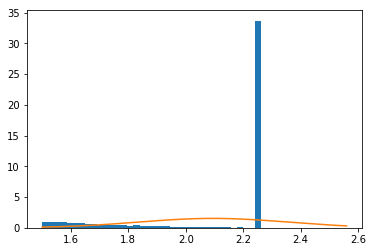

In [6]:
N=10000


## Lalande 21185
NN=np.zeros(N)

for i in range(N):
    print('\n i = ', i)
    Mi=M_l+dM_l*rd.normal()   #Monte Carlo
    Ri=R_l+dR_l*rd.normal()
    Li=L_l+dL_l*rd.normal()
    NN[i]=n_bissecao(Mi,Ri,Li,X_l,Z_l,1.5,3,1E-5) 
    
a,b,c=plt.hist(NN,density=True, bins = 50)
n_m=np.average(NN) 
print('\n Média com Monte Carlo : ', n_m)
a=norm.fit(b)  #Faz o fit de uma gaussiana ao histograma para determinar a média e desvio padrão
#plt.plot(a)
gauss(NN) 
#plt.ylim(25)
#plt.show()
print('\n n=',a[0],' (média da gaussiana) com uma incerteza de ',a[1])


 i =  0


C:\Users\bernc\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.8255157470703125 3.825592041015625
3.8255538940429688 3.825572967529297
3.825563430786133 3.825568199157715

 ni, nf finais :  3.825563430786133 3.825568199157715

 i =  1
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.81201171875 3.8126220703125
3.81231689453125 3.8126220703125


C:\Users\bernc\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


3.812469482421875 3.8126220703125
3.8125457763671875 3.8126220703125
3.8125839233398438 3.812602996826172
3.8125839233398438 3.812593460083008

 ni, nf finais :  3.8125839233398438 3.812593460083008

 i =  2
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822998046875
3.822845458984375 3.822998046875
3.8229217529296875 3.822998046875
3.8229598999023438 3.822978973388672
3.8229598999023438 3.822969436645508

 ni, nf finais :  3.8229598999023438 3.822969436645508

 i =  3
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830322265625
3.830169677734375 3.8302459716796875
3.830169677734375 3.8302078247070312
3.830188751220703 3.830198287963867

 ni, nf finais :  3.830188751220703 3.830198287963867


3.82269287109375 3.822711944580078
3.82269287109375 3.822702407836914

 ni, nf finais :  3.82269287109375 3.822702407836914

 i =  22
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.82666015625 3.826812744140625
3.82666015625 3.8267364501953125
3.8266983032226562 3.8267364501953125
3.8267173767089844 3.8267269134521484

 ni, nf finais :  3.8267173767089844 3.8267269134521484

 i =  23
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.8193359375 3.81964111328125
3.8193359375 3.819488525390625
3.8193359375 3.8194122314453125
3.8193359375 3.8193740844726562
3.819355010986328 3.8193740844726562
3.819364547729492 3.819369316101074

 ni, nf finais :  3.819364547729492 3.819369316101074

 i =  24
2.75 4.0
3

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822998046875
3.822845458984375 3.822998046875
3.8229217529296875 3.8229598999023438
3.8229217529296875 3.8229408264160156
3.8229217529296875 3.8229312896728516

 ni, nf finais :  3.8229217529296875 3.8229312896728516

 i =  43
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81719970703125 3.8175048828125
3.817352294921875 3.8175048828125
3.8174285888671875 3.8174667358398438
3.8174476623535156 3.8174571990966797

 ni, nf finais :  3.8174476623535156 3.8174571990966797

 i =  44
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820404052734375
3.8203277587

3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.818115234375
3.8180389404296875 3.818115234375
3.8180770874023438 3.818115234375
3.818096160888672 3.818115234375
3.818105697631836 3.818115234375

 ni, nf finais :  3.818105697631836 3.818115234375

 i =  65
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.819793701171875
3.8197174072265625 3.819793701171875
3.8197555541992188 3.819793701171875
3.819774627685547 3.819793701171875
3.819784164428711 3.819788932800293

 ni, nf finais :  3.819784164428711 3.819788932800293

 i =  66
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291015625 3.82

3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825592041015625 3.8256683349609375
3.825592041015625 3.8256301879882812
3.825592041015625 3.825611114501953
3.825601577758789 3.825611114501953

 ni, nf finais :  3.825601577758789 3.825611114501953

 i =  85
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832763671875
3.832611083984375 3.8326873779296875
3.832611083984375 3.8326492309570312
3.832630157470703 3.832639694213867

 ni, nf finais :  3.832630157470703 3.832639694213867

 i =  86
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.8187255859375 3.818878173828125
3.8188018798828125 3.818878173828125
3.818840026855

3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.80712890625 3.808349609375
3.8077392578125 3.80804443359375
3.807891845703125 3.80804443359375
3.8079681396484375 3.8080062866210938
3.8079681396484375 3.8079872131347656
3.8079776763916016 3.8079824447631836

 ni, nf finais :  3.8079776763916016 3.8079824447631836

 i =  106
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.83642578125
3.8358154296875 3.83612060546875
3.8358154296875 3.835968017578125
3.8358154296875 3.8358917236328125
3.8358535766601562 3.8358917236328125
3.8358726501464844 3.8358821868896484

 ni, nf finais :  3.8358726501464844 3.8358821868896484

 i =  107
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83184814453125 3.8321533203125
3.832000732421875 3.832077026367

3.825286865234375 3.825439453125
3.8253631591796875 3.825439453125
3.8254013061523438 3.825420379638672
3.8254013061523438 3.825410842895508

 ni, nf finais :  3.8254013061523438 3.825410842895508

 i =  126
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.82177734375 3.821929931640625
3.8218536376953125 3.821929931640625
3.8218917846679688 3.821910858154297
3.821901321411133 3.821910858154297

 ni, nf finais :  3.821901321411133 3.821910858154297

 i =  127
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291015625 3.8291778564453125
3.8291397094726562 3.8291587829589844
3.8291492462158203 3.8291540145874023

 ni, nf finais :  3.829149246

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.8284912109375 3.828643798828125
3.8285675048828125 3.8286056518554688
3.8285675048828125 3.8285865783691406
3.8285675048828125 3.8285770416259766

 ni, nf finais :  3.8285675048828125 3.8285770416259766

 i =  148
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.824371337890625 3.8244476318359375
3.8244094848632812 3.8244476318359375
3.8244285583496094 3.8244476318359375
3.8244380950927734 3.8244476318359375

 ni, nf finais :  3.8244380950927734 3.8244476318359375

 i =  149
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827

3.836578369140625 3.8366546630859375
3.836578369140625 3.8366165161132812
3.836578369140625 3.836597442626953
3.836587905883789 3.836592674255371

 ni, nf finais :  3.836587905883789 3.836592674255371

 i =  168
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.8241424560546875
3.8241043090820312 3.8241424560546875
3.8241233825683594 3.8241329193115234

 ni, nf finais :  3.8241233825683594 3.8241329193115234

 i =  169
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.835205078125 3.83551025390625
3.835357666015625 3.83551025390625
3.8354339599609375 3.8354721069335938
3.8354339599609375 3.8354530334472656
3.8354339599609375 3.8354434967041016

 ni, nf finais :  3.8354339599

3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820709228515625 3.82086181640625
3.8207855224609375 3.82086181640625
3.8208236694335938 3.820842742919922
3.8208236694335938 3.820833206176758

 ni, nf finais :  3.8208236694335938 3.820833206176758

 i =  189
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820556640625 3.820709228515625
3.820556640625 3.8206329345703125
3.8205947875976562 3.8206138610839844
3.8205947875976562 3.8206043243408203

 ni, nf finais :  3.8205947875976562 3.8206043243408203

 i =  190
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.815673828125
3.81536865234375 3.815521240234375
3.81536865234375 3.8154449462890625
3.81536865234375 3.8154067993164062
3.815387725830

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.814453125 3.81475830078125
3.814605712890625 3.8146820068359375
3.814605712890625 3.8146438598632812
3.814624786376953 3.8146438598632812
3.814634323120117 3.8146438598632812

 ni, nf finais :  3.814634323120117 3.8146438598632812

 i =  210
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296875
3.8309326171875 3.831085205078125
3.8310089111328125 3.8310470581054688
3.8310279846191406 3.8310375213623047

 ni, nf finais :  3.8310279846191406 3.8310375213623047

 i =  211
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.81781005859375
3.8175048828125 3.817657470703125
3.8175811767578125 3.81761932373046

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.81201171875 3.8126220703125
3.81201171875 3.81231689453125
3.81201171875 3.812164306640625
3.81201171875 3.8120880126953125
3.8120498657226562 3.8120689392089844
3.8120594024658203 3.8120689392089844

 ni, nf finais :  3.8120594024658203 3.8120689392089844

 i =  231
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.82421875
3.8241424560546875 3.82421875
3.8241806030273438 3.82421875
3.824199676513672 3.824209213256836

 ni, nf finais :  3.824199676513672 3.824209213256836

 i =  232
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015

3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830474853515625 3.83062744140625
3.8305511474609375 3.8305892944335938
3.8305702209472656 3.8305797576904297

 ni, nf finais :  3.8305702209472656 3.8305797576904297

 i =  251
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.80712890625 3.808349609375
3.80712890625 3.8077392578125
3.80712890625 3.80743408203125
3.80712890625 3.807281494140625
3.8072052001953125 3.807281494140625
3.8072433471679688 3.807262420654297
3.8072433471679688 3.807252883911133

 ni, nf finais :  3.8072433471679688 3.807252883911133

 i =  252
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830169677734375
3.8300933837890625 3.8301315307617188
3.8301124572753906 3.8301315307617188
3.8301219940185547 3.8301315307617188

 ni, nf finai

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.831390380859375
3.83123779296875 3.8313140869140625
3.8312759399414062 3.8313140869140625
3.8312950134277344 3.8313045501708984

 ni, nf finais :  3.8312950134277344 3.8313045501708984

 i =  272
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.815673828125
3.81536865234375 3.815521240234375
3.81536865234375 3.8154449462890625
3.81536865234375 3.8154067993164062
3.81536865234375 3.815387725830078
3.81536865234375 3.815378189086914

 ni, nf finais :  3.81536865234375 3.815378189086914

 i =  273
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.828338623046875
3.8282623

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818115234375 3.818267822265625
3.8181915283203125 3.8182296752929688
3.8181915283203125 3.8182106018066406
3.8182010650634766 3.8182058334350586

 ni, nf finais :  3.8182010650634766 3.8182058334350586

 i =  293
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818115234375 3.818267822265625
3.8181915283203125 3.8182296752929688
3.8182106018066406 3.8182201385498047

 ni, nf finais :  3.8182106018066406 3.8182201385498047

 i =  294
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.81719970703125
3.817047119140625 3.8171234130859375
3.817047119140625 3

3.821624755859375 3.8216629028320312
3.821624755859375 3.821643829345703
3.821624755859375 3.821634292602539

 ni, nf finais :  3.821624755859375 3.821634292602539

 i =  313
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833984375 3.8345947265625
3.83428955078125 3.834442138671875
3.8343658447265625 3.834442138671875
3.8344039916992188 3.834442138671875
3.834423065185547 3.834432601928711

 ni, nf finais :  3.834423065185547 3.834432601928711

 i =  314
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820404052734375
3.8203277587890625 3.8203659057617188
3.8203468322753906 3.8203563690185547

 ni, nf finais :  3.8203468322753906 3.8203563690185547

 i =  315
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.826202392578125 3.8262786865234375
3.8262405395507812 3.8262786865234375
3.8262596130371094 3.8262691497802734

 ni, nf finais :  3.8262596130371094 3.8262691497802734

 i =  335
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.8220062255859375
3.821929931640625 3.8219680786132812
3.821949005126953 3.8219680786132812
3.821958541870117 3.821963310241699

 ni, nf finais :  3.821958541870117 3.821963310241699

 i =  336
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82208251953125 3.822235

3.813232421875 3.8138427734375
3.813232421875 3.81353759765625
3.813232421875 3.813385009765625
3.8133087158203125 3.8133468627929688
3.8133277893066406 3.8133468627929688
3.8133373260498047 3.8133420944213867

 ni, nf finais :  3.8133373260498047 3.8133420944213867

 i =  355
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.827423095703125 3.8274993896484375
3.8274612426757812 3.8274803161621094
3.8274612426757812 3.8274707794189453

 ni, nf finais :  3.8274612426757812 3.8274707794189453

 i =  356
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.819793701171875
3.81964111328125 3.8197174072265625
3.8196792602539062 3.8197174072265625
3.8196983337402344 3.8197174072265625
3.8197078704833984 3.8197126388549805

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125
3.83673095703125 3.8370361328125
3.836883544921875 3.8369598388671875
3.836883544921875 3.8369216918945312
3.836883544921875 3.836902618408203
3.836893081665039 3.836897850036621

 ni, nf finais :  3.836893081665039 3.836897850036621

 i =  376
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827728271484375
3.8276519775390625 3.8276901245117188
3.8276519775390625 3.8276710510253906
3.8276615142822266 3.8276662826538086

 ni, nf finais :  3.8276615142822266 3.8276662826538086

 i =  377
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296875
3.8309326171875 3.

3.8097991943359375 3.80987548828125
3.8098373413085938 3.809856414794922
3.8098373413085938 3.809846878051758

 ni, nf finais :  3.8098373413085938 3.809846878051758

 i =  396
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830322265625
3.830169677734375 3.8302459716796875
3.8302078247070312 3.8302268981933594
3.8302173614501953 3.8302268981933594

 ni, nf finais :  3.8302173614501953 3.8302268981933594

 i =  397
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822845458984375
3.82269287109375 3.8227691650390625
3.8227310180664062 3.8227500915527344
3.8227310180664062 3.8227405548095703

 ni, nf finais :  3.8227310180664062 3.8227405548095703

 i =  398
2.75 4.0
3.375 4.0
3.6875 3.84375
3.76

3.831705093383789 3.831709861755371

 ni, nf finais :  3.831705093383789 3.831709861755371

 i =  417
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.824371337890625 3.82452392578125
3.8244476318359375 3.8244857788085938
3.8244667053222656 3.8244762420654297

 ni, nf finais :  3.8244667053222656 3.8244762420654297

 i =  418
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81658935546875
3.8162841796875 3.816436767578125
3.8163604736328125 3.816436767578125
3.8163986206054688 3.816436767578125
3.816417694091797 3.816436767578125
3.816427230834961 3.816431999206543

 ni, nf finais :  3.816427230834961 3.816431999206543

 i =  419
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.824

3.8334503173828125 3.8334693908691406
3.8334598541259766 3.8334693908691406

 ni, nf finais :  3.8334598541259766 3.8334693908691406

 i =  438
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.828643798828125 3.8287200927734375
3.828643798828125 3.8286819458007812
3.828643798828125 3.828662872314453
3.828653335571289 3.828658103942871

 ni, nf finais :  3.828653335571289 3.828658103942871

 i =  439
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375
3.81903076171875 3.8193359375
3.819183349609375 3.8193359375
3.8192596435546875 3.8192977905273438
3.8192596435546875 3.8192787170410156
3.8192596435546875 3.8192691802978516

 ni, nf finais :  3.8192596435546875 3.8192691802978516

 i =  440
2.75 4.0
3.375 4

3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.81842041015625 3.818572998046875
3.81842041015625 3.8184967041015625
3.81842041015625 3.8184585571289062
3.818439483642578 3.818449020385742

 ni, nf finais :  3.818439483642578 3.818449020385742

 i =  459
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.828643798828125 3.8287200927734375
3.8286819458007812 3.8287200927734375
3.8287010192871094 3.8287105560302734

 ni, nf finais :  3.8287010192871094 3.8287105560302734

 i =  460
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.8388671875
3.837646484375 3.8382568359375
3.837646484375 3.83795166015625
3.837799072265625 3.83795166015625
3.8378753662109375 3.8379135131835938
3.8378753662109375 3.8378944396972656
3.8378753662109375 3.8378849029541

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.8272705078125
3.827117919921875 3.8272705078125
3.8271942138671875 3.8272323608398438
3.8271942138671875 3.8272132873535156
3.8272037506103516 3.8272085189819336

 ni, nf finais :  3.8272037506103516 3.8272085189819336

 i =  480
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.8260498046875
3.825897216796875 3.8260498046875
3.8259735107421875 3.8260116577148438
3.8259735107421875 3.8259925842285156
3.8259735107421875 3.8259830474853516

 ni, nf finais :  3.8259735107421875 3.8259830474853516

 i =  481
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.81842041015625 3.

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.825439453125 3.8255157470703125
3.825439453125 3.8254776000976562
3.825458526611328 3.825468063354492

 ni, nf finais :  3.825458526611328 3.825468063354492

 i =  501
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832916259765625 3.8329925537109375
3.8329544067382812 3.8329734802246094
3.8329544067382812 3.8329639434814453

 ni, nf finais :  3.8329544067382812 3.8329639434814453

 i =  502
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.8284912109375
3.828338623046875 

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.8258209228515625 3.825897216796875
3.8258590698242188 3.825897216796875
3.825878143310547 3.825897216796875
3.825887680053711 3.825892448425293

 ni, nf finais :  3.825887680053711 3.825892448425293

 i =  522
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.821319580078125 3.8213958740234375
3.8213577270507812 3.8213958740234375
3.8213768005371094 3.8213863372802734

 ni, nf finais :  3.8213768005371094 3.8213863372802734

 i =  523
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.81597900390625 3.8162841796875
3.816131591796875 3.816207885

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.8255157470703125 3.8255538940429688
3.8255157470703125 3.8255348205566406
3.8255157470703125 3.8255252838134766

 ni, nf finais :  3.8255157470703125 3.8255252838134766

 i =  543
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.81414794921875
3.8138427734375 3.813995361328125
3.8138427734375 3.8139190673828125
3.8138427734375 3.8138809204101562
3.813861846923828 3.813871383666992

 ni, nf finais :  3.813861846923828 3.813871383666992

 i =  544
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.8046875 3.80712890625
3.805908203125 3.80712890625


2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.835205078125 3.83551025390625
3.835357666015625 3.8354339599609375
3.8353958129882812 3.8354148864746094
3.8353958129882812 3.8354053497314453

 ni, nf finais :  3.8353958129882812 3.8354053497314453

 i =  565
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832763671875
3.832611083984375 3.832763671875
3.8326873779296875 3.8327255249023438
3.8327064514160156 3.8327159881591797

 ni, nf finais :  3.8327064514160156 3.8327159881591797

 i =  566
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.81781005859375
3.817657470703125 3.81781005859375
3.8177337646484375 3.8177719116210938

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.81842041015625 3.8187255859375
3.818572998046875 3.8186492919921875
3.8186111450195312 3.8186302185058594
3.8186111450195312 3.8186206817626953

 ni, nf finais :  3.8186111450195312 3.8186206817626953

 i =  586
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.815673828125
3.81536865234375 3.815673828125
3.815521240234375 3.815673828125
3.8155975341796875 3.815673828125
3.8156356811523438 3.815673828125
3.815654754638672 3.815664291381836

 ni, nf finais :  3.815654754638672 3.815664291381836

 i =  587
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.8223876953125 3.822540283203125
3.8224639

3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820709228515625 3.82086181640625
3.8207855224609375 3.82086181640625
3.8208236694335938 3.82086181640625
3.820842742919922 3.820852279663086

 ni, nf finais :  3.820842742919922 3.820852279663086

 i =  607
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.840087890625 3.8406982421875
3.84039306640625 3.840545654296875
3.8404693603515625 3.8405075073242188
3.8404884338378906 3.8405075073242188
3.8404979705810547 3.8405027389526367

 ni, nf finais :  3.8404979705810547 3.8405027389526367

 i =  608
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8273468017578125 3.827423095703125
3.8273849487304688 3.827404022216797
3.8273849487304688 3.82739448547

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.8241424560546875
3.824066162109375 3.8241043090820312
3.824085235595703 3.824094772338867

 ni, nf finais :  3.824085235595703 3.824094772338867

 i =  628
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.8255157470703125 3.825592041015625
3.8255538940429688 3.825592041015625
3.825572967529297 3.825592041015625
3.825582504272461 3.825592041015625

 ni, nf finais :  3.825582504272461 3.825592041015625

 i =  629
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.840087890625 3.84130859375
3.8406982421875 3.84130859375
3.84100341796875 3.84130859375
3.841156005859375 3.8412322998046875
3.8411941528320312 3.8412322998046875
3.8412132263183594 3.8412322998046875
3.8412227630615234 3.8412322998046875

 ni, nf finais :  3.8412227630615234 3.8412322998046875

 i =  649
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.820098876953125 3.8201751708984375
3.8201370239257812 3.8201751708984375
3.8201560974121094 3.8201656341552734

 ni, nf finais :  3.8201560974121094 3.8201656341552734

 i =  650
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8289489

3.8304367065429688 3.830446243286133

 ni, nf finais :  3.8304367065429688 3.830446243286133

 i =  669
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.815673828125
3.81536865234375 3.815521240234375
3.81536865234375 3.8154449462890625
3.81536865234375 3.8154067993164062
3.81536865234375 3.815387725830078
3.81536865234375 3.815378189086914

 ni, nf finais :  3.81536865234375 3.815378189086914

 i =  670
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.81536865234375
3.8150634765625 3.815216064453125
3.8150634765625 3.8151397705078125
3.8151016235351562 3.8151397705078125
3.8151206970214844 3.8151302337646484

 ni, nf finais :  3.8151206970214844 3.8151302337646484

 i =  671
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.824218

3.8360824584960938 3.836091995239258

 ni, nf finais :  3.8360824584960938 3.836091995239258

 i =  690
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818267822265625 3.8183441162109375
3.818267822265625 3.8183059692382812
3.818267822265625 3.818286895751953
3.818277359008789 3.818282127380371

 ni, nf finais :  3.818277359008789 3.818282127380371

 i =  691
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.82635498046875 3.82666015625
3.826507568359375 3.82666015625
3.8265838623046875 3.82666015625
3.8266220092773438 3.826641082763672
3.826631546020508 3.826641082763672

 ni, nf finais :  3.826631546020508 3.826641082763672

 i =  692
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.83306884765625 3.8333740234375
3.833221435546875 3.8333740234375
3.8332977294921875 3.8333740234375
3.8333358764648438 3.833354949951172
3.8333358764648438 3.833345413208008

 ni, nf finais :  3.8333358764648438 3.833345413208008

 i =  711
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.8180389404296875
3.817962646484375 3.8180007934570312
3.817962646484375 3.817981719970703
3.817972183227539 3.817981719970703

 ni, nf finais :  3.817972183227539 3.817981719970703

 i =  712
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984

3.8178863525390625 3.8178958892822266

 ni, nf finais :  3.8178863525390625 3.8178958892822266

 i =  731
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.828948974609375
3.8288726806640625 3.8289108276367188
3.8288917541503906 3.8289108276367188
3.8289012908935547 3.8289108276367188

 ni, nf finais :  3.8289012908935547 3.8289108276367188

 i =  732
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.814453125
3.81414794921875 3.814453125
3.814300537109375 3.8143768310546875
3.8143386840820312 3.8143577575683594
3.8143386840820312 3.8143482208251953

 ni, nf finais :  3.8143386840820312 3.8143482208251953

 i =  733
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.8437

3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.82421875
3.8241424560546875 3.82421875
3.8241806030273438 3.82421875
3.824199676513672 3.82421875
3.824209213256836 3.82421875

 ni, nf finais :  3.824209213256836 3.82421875

 i =  752
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.8187255859375 3.818878173828125
3.8188018798828125 3.8188400268554688
3.8188209533691406 3.8188304901123047

 ni, nf finais :  3.8188209533691406 3.8188304901123047

 i =  753
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.8220062255859375
3.821929931640625 3.8219680786132812
3.821929931640625 3.821949005126953
3.821929931640625 3.82193946838

3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830169677734375
3.8300933837890625 3.830169677734375
3.8301315307617188 3.830169677734375
3.830150604248047 3.830160140991211

 ni, nf finais :  3.830150604248047 3.830160140991211

 i =  773
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.8199462890625
3.819793701171875 3.8199462890625
3.8198699951171875 3.8199462890625
3.8199081420898438 3.8199462890625
3.819927215576172 3.819936752319336

 ni, nf finais :  3.819927215576172 3.819936752319336

 i =  774
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81719970703125 3.8175048828125
3.817352294921875 3.8174285888671875
3.817352294921875 3.8173904418945312
3.817371368408203 3.817380905151367

 ni, nf fina

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296875
3.831085205078125 3.83123779296875
3.8311614990234375 3.8311996459960938
3.8311614990234375 3.8311805725097656
3.8311710357666016 3.8311805725097656

 ni, nf finais :  3.8311710357666016 3.8311805725097656

 i =  794
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.82177734375 3.821929931640625
3.82177734375 3.8218536376953125
3.8218154907226562 3.8218345642089844
3.8218154907226562 3.8218250274658203

 ni, nf finais :  3.8218154907226562 3.8218250274658203

 i =  795
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.81826782226562

3.825439453125 3.825458526611328
3.825439453125 3.825448989868164

 ni, nf finais :  3.825439453125 3.825448989868164

 i =  814
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.83551025390625 3.8358154296875
3.835662841796875 3.8357391357421875
3.8357009887695312 3.8357200622558594
3.8357009887695312 3.8357105255126953

 ni, nf finais :  3.8357009887695312 3.8357105255126953

 i =  815
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.823455810546875
3.8233795166015625 3.8234176635742188
3.8233795166015625 3.8233985900878906
3.8233795166015625 3.8233890533447266

 ni, nf finais :  3.8233795166015625 3.8233890533447266

 i =  816
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875


2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832916259765625 3.8329925537109375
3.8329544067382812 3.8329734802246094
3.8329639434814453 3.8329687118530273

 ni, nf finais :  3.8329639434814453 3.8329687118530273

 i =  835
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.82177734375
3.821624755859375 3.82177734375
3.8217010498046875 3.82177734375
3.8217391967773438 3.821758270263672
3.8217391967773438 3.821748733520508

 ni, nf finais :  3.8217391967773438 3.821748733520508

 i =  836
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.8095703125 3.810791015625
3.8101806640625 3.81048583984375
3.81018066406

3.8263072967529297 3.8263168334960938

 ni, nf finais :  3.8263072967529297 3.8263168334960938

 i =  855
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.81475830078125 3.8150634765625
3.814910888671875 3.8149871826171875
3.8149490356445312 3.8149871826171875
3.8149681091308594 3.8149871826171875
3.8149776458740234 3.8149871826171875

 ni, nf finais :  3.8149776458740234 3.8149871826171875

 i =  856
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.820098876953125 3.8201751708984375
3.8201370239257812 3.8201751708984375
3.8201560974121094 3.8201656341552734

 ni, nf finais :  3.8201560974121094 3.8201656341552734

 i =  857
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.819

3.814901351928711 3.814910888671875

 ni, nf finais :  3.814901351928711 3.814910888671875

 i =  876
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.827117919921875
3.82696533203125 3.8270416259765625
3.8270034790039062 3.8270225524902344
3.8270034790039062 3.8270130157470703

 ni, nf finais :  3.8270034790039062 3.8270130157470703

 i =  877
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.81719970703125
3.81689453125 3.817047119140625
3.8169708251953125 3.8170089721679688
3.8169708251953125 3.8169898986816406
3.8169803619384766 3.8169898986816406

 ni, nf finais :  3.8169803619384766 3.8169898986816406

 i =  878
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81445312

3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.817962646484375
3.81781005859375 3.8178863525390625
3.81781005859375 3.8178482055664062
3.81781005859375 3.817829132080078
3.817819595336914 3.817824363708496

 ni, nf finais :  3.817819595336914 3.817824363708496

 i =  898
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.81536865234375
3.8150634765625 3.815216064453125
3.8150634765625 3.8151397705078125
3.8151016235351562 3.8151206970214844
3.8151111602783203 3.8151206970214844

 ni, nf finais :  3.8151111602783203 3.8151206970214844

 i =  899
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83154296875 3.83184814453125
3.831695556640625 3.83184814453125
3.8317718505859375 3.8318099975585938
3.8317909240722656 3

3.8308563232421875 3.8308658599853516

 ni, nf finais :  3.8308563232421875 3.8308658599853516

 i =  919
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.824371337890625 3.8244476318359375
3.824371337890625 3.8244094848632812
3.824371337890625 3.824390411376953
3.824371337890625 3.824380874633789

 ni, nf finais :  3.824371337890625 3.824380874633789

 i =  920
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.8248291015625
3.824676513671875 3.8248291015625
3.8247528076171875 3.8248291015625
3.8247909545898438 3.8248291015625
3.824810028076172 3.8248291015625
3.824819564819336 3.8248291015625

 ni, nf finais :  3.824819564819336 3.8248291015625

 i =  9

3.8148250579833984 3.8148298263549805

 ni, nf finais :  3.8148250579833984 3.8148298263549805

 i =  939
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.82421875 3.824371337890625
3.82421875 3.8242950439453125
3.82421875 3.8242568969726562
3.824237823486328 3.8242568969726562
3.824247360229492 3.824252128601074

 ni, nf finais :  3.824247360229492 3.824252128601074

 i =  940
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.833984375
3.83367919921875 3.833831787109375
3.8337554931640625 3.8337936401367188
3.8337554931640625 3.8337745666503906
3.8337650299072266 3.8337745666503906

 ni, nf finais :  3.8337650299072266 3.8337745666503906

 i =  941
2.75 4.0
3.375 4.0
3.6875 3.8

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.814453125 3.81475830078125
3.814605712890625 3.81475830078125
3.8146820068359375 3.81475830078125
3.8147201538085938 3.814739227294922
3.8147201538085938 3.814729690551758

 ni, nf finais :  3.8147201538085938 3.814729690551758

 i =  960
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.82086181640625 3.8209381103515625
3.82086181640625 3.8208999633789062
3.82086181640625 3.820880889892578
3.82086181640625 3.820871353149414

 ni, nf finais :  3.82086181640625 3.820871353149414

 i =  961
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.8345947265625 3.83520507812

 ni, nf finais :  3.821014404296875 3.821023941040039

 i =  980
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.81781005859375
3.8175048828125 3.817657470703125
3.8175048828125 3.8175811767578125
3.8175048828125 3.8175430297851562
3.817523956298828 3.817533493041992

 ni, nf finais :  3.817523956298828 3.817533493041992

 i =  981
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.8193359375 3.81964111328125
3.819488525390625 3.8195648193359375
3.819488525390625 3.8195266723632812
3.819488525390625 3.819507598876953
3.819498062133789 3.819507598876953

 ni, nf finais :  3.819498062133789 3.819507598876953

 i =  982
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.824218

3.8358154296875 3.83612060546875
3.8358154296875 3.835968017578125
3.8358917236328125 3.8359298706054688
3.8359107971191406 3.8359203338623047

 ni, nf finais :  3.8359107971191406 3.8359203338623047

 i =  1001
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.81475830078125 3.8150634765625
3.814910888671875 3.8150634765625
3.8149871826171875 3.8150634765625
3.8150253295898438 3.815044403076172
3.8150253295898438 3.815034866333008

 ni, nf finais :  3.8150253295898438 3.815034866333008

 i =  1002
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.8211669921875
3.821014404296875 3.8210906982421875
3.8210525512695312 3.8210716247558594
3.8210525512695312 3.8210620880126953

 ni, nf finais :  3.8210525512695312 3.8210620880126953

 i =  100

3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827880859375
3.827728271484375 3.8278045654296875
3.8277664184570312 3.8278045654296875
3.8277854919433594 3.8277950286865234

 ni, nf finais :  3.8277854919433594 3.8277950286865234

 i =  1023
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.8220062255859375
3.821929931640625 3.8219680786132812
3.821929931640625 3.821949005126953
3.821929931640625 3.821939468383789

 ni, nf finais :  3.821929931640625 3.821939468383789

 i =  1024
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.8220062255859375
3.821929931640625 3.82196807861328

3.8242759704589844 3.8242855072021484

 ni, nf finais :  3.8242759704589844 3.8242855072021484

 i =  1043
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.8236083984375
3.823455810546875 3.8235321044921875
3.823455810546875 3.8234939575195312
3.823474884033203 3.823484420776367

 ni, nf finais :  3.823474884033203 3.823484420776367

 i =  1044
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.835205078125 3.83551025390625
3.835357666015625 3.83551025390625
3.8354339599609375 3.8354721069335938
3.8354530334472656 3.8354721069335938
3.8354625701904297 3.8354673385620117

 ni, nf finais :  3.8354625701904297 3.8354673385620117

 i =  1045
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.826812744140625 3.8268890380859375
3.826812744140625 3.8268508911132812
3.826831817626953 3.8268508911132812
3.826841354370117 3.8268508911132812

 ni, nf finais :  3.826841354370117 3.8268508911132812

 i =  1064
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81689453125
3.81658935546875 3.81689453125
3.816741943359375 3.81689453125
3.8168182373046875 3.81689453125
3.8168563842773438 3.816875457763672
3.8168563842773438 3.816865921020508

 ni, nf finais :  3.8168563842773438 3.816865921020508

 i =  1065
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83184814453125 3.832000732421875
3.83184814453125 3.8319244384765625
3.83184814453125 3.8318862915039062
3.83184814453125 3.831867218017578
3.831857681274414 3.831862449645996

 ni, nf finais :  3.831857681274414 3.831862449645996

 i =  1085
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820709228515625 3.82086181640625
3.8207855224609375 3.8208236694335938
3.8207855224609375 3.8208045959472656
3.8207855224609375 3.8207950592041016

 ni, nf finais :  3.8207855224609375 3.8207950592041016

 i =  1086
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260

3.8299312591552734 3.8299360275268555

 ni, nf finais :  3.8299312591552734 3.8299360275268555

 i =  1105
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830474853515625 3.8305511474609375
3.830474853515625 3.8305130004882812
3.830474853515625 3.830493927001953
3.830484390258789 3.830489158630371

 ni, nf finais :  3.830484390258789 3.830489158630371

 i =  1106
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.827423095703125 3.8274993896484375
3.827423095703125 3.8274612426757812
3.827442169189453 3.827451705932617

 ni, nf finais :  3.827442169189453 3.827451705932617

 i =  1107
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.8260498046875 3.826202392578125
3.8260498046875 3.8261260986328125
3.8260498046875 3.8260879516601562
3.8260498046875 3.826068878173828
3.826059341430664 3.826068878173828

 ni, nf finais :  3.826059341430664 3.826068878173828

 i =  1127
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832916259765625 3.8329925537109375
3.832916259765625 3.8329544067382812
3.832935333251953 3.832944869995117

 ni, nf finais :  3.832935333251953 3.832944869995117

 i =  1128
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832611083984375
3.83245849609375 3.8325347900390625
3.8324966430664062 3.8325157165527344
3.8324966430664062 3.8325061798095703

 ni, nf finais :  3.8324966430664062 3.8325061798095703

 i =  1147
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.828338623046875
3.8282623291015625 3.828338623046875
3.8283004760742188 3.828319549560547
3.8283004760742188 3.828310012817383

 ni, nf finais :  3.8283004760742188 3.828310012817383

 i =  1148
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.81781005859375
3.817657470703125 3.8177337646484375
3.817657470703125 3.8176956176757812
3.817676544189453 3.

3.8260498046875 3.826202392578125
3.8260498046875 3.8261260986328125
3.8260498046875 3.8260879516601562
3.826068878173828 3.8260879516601562
3.826078414916992 3.826083183288574

 ni, nf finais :  3.826078414916992 3.826083183288574

 i =  1167
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.8255157470703125 3.825592041015625
3.8255538940429688 3.825592041015625
3.825572967529297 3.825582504272461

 ni, nf finais :  3.825572967529297 3.825582504272461

 i =  1168
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.8255157470703125 3.825592041015625
3.8255538940429688 3.825572967529297
3.825563430786133 3.82556819915

3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81719970703125 3.8175048828125
3.817352294921875 3.8174285888671875
3.8173904418945312 3.8174285888671875
3.8174095153808594 3.8174285888671875
3.8174190521240234 3.8174238204956055

 ni, nf finais :  3.8174190521240234 3.8174238204956055

 i =  1188
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827880859375
3.827728271484375 3.827880859375
3.8278045654296875 3.827880859375
3.8278427124023438 3.827880859375
3.827861785888672 3.827871322631836

 ni, nf finais :  3.827861785888672 3.827871322631836

 i =  1189
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.8345947265625 3.83489990234375
3.8345947265625 3.8347473144531

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832611083984375
3.8325347900390625 3.8325729370117188
3.8325347900390625 3.8325538635253906
3.8325347900390625 3.8325443267822266

 ni, nf finais :  3.8325347900390625 3.8325443267822266

 i =  1209
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.826202392578125 3.8262786865234375
3.8262405395507812 3.8262596130371094
3.8262405395507812 3.8262500762939453

 ni, nf finais :  3.8262405395507812 3.8262500762939453

 i =  1210
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.82559204101562

3.8223876953125 3.822406768798828
3.8223876953125 3.822397232055664

 ni, nf finais :  3.8223876953125 3.822397232055664

 i =  1229
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81689453125
3.81658935546875 3.81689453125
3.816741943359375 3.81689453125
3.8168182373046875 3.81689453125
3.8168563842773438 3.816875457763672
3.816865921020508 3.81687068939209

 ni, nf finais :  3.816865921020508 3.81687068939209

 i =  1230
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.824981689453125 3.82513427734375
3.8250579833984375 3.8250961303710938
3.8250770568847656 3.8250865936279297

 ni, nf finais :  3.8250770568847656 3.8250865936279297

 i =  1231
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125
3.83673095703125 3.8370361328125
3.836883544921875 3.8369598388671875
3.8369216918945312 3.8369598388671875
3.8369407653808594 3.8369503021240234

 ni, nf finais :  3.8369407653808594 3.8369503021240234

 i =  1250
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.818878173828125 3.81903076171875
3.8189544677734375 3.81903076171875
3.8189926147460938 3.819011688232422
3.8189926147460938 3.819002151489258

 ni, nf finais :  3.8189926147460938 3.819002151489258

 i =  1251
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.8219

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.8297119140625 3.829864501953125
3.8297882080078125 3.829864501953125
3.8298263549804688 3.829864501953125
3.829845428466797 3.829854965209961

 ni, nf finais :  3.829845428466797 3.829854965209961

 i =  1270
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.827117919921875
3.8270416259765625 3.8270797729492188
3.8270416259765625 3.8270606994628906
3.8270416259765625 3.8270511627197266

 ni, nf finais :  3.8270416259765625 3.8270511627197266

 i =  1271
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.821319580078125 3.8213958740234375
3.821319580078125 3.821357727

3.8120498657226562 3.8120594024658203

 ni, nf finais :  3.8120498657226562 3.8120594024658203

 i =  1290
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.81719970703125
3.81689453125 3.817047119140625
3.8169708251953125 3.817047119140625
3.8170089721679688 3.817028045654297
3.8170089721679688 3.817018508911133

 ni, nf finais :  3.8170089721679688 3.817018508911133

 i =  1291
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81689453125
3.81658935546875 3.81689453125
3.816741943359375 3.8168182373046875
3.8167800903320312 3.8168182373046875
3.8167991638183594 3.8168087005615234

 ni, nf finais :  3.8167991638183594 3.8168087005615234

 i =  1292
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.824218

3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.81475830078125 3.814910888671875
3.8148345947265625 3.814910888671875
3.8148727416992188 3.814910888671875
3.814891815185547 3.814901351928711

 ni, nf finais :  3.814891815185547 3.814901351928711

 i =  1311
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8291015625
3.828948974609375 3.8291015625
3.8290252685546875 3.8290634155273438
3.8290443420410156 3.8290634155273438
3.8290538787841797 3.8290586471557617

 ni, nf finais :  3.8290538787841797 3.8290586471557617

 i =  1312
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.827423095703125 3.82757568359375
3.8274993896484375 3.82757568359375
3.827537536621

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.823455810546875
3.82330322265625 3.8233795166015625
3.82330322265625 3.8233413696289062
3.823322296142578 3.823331832885742

 ni, nf finais :  3.823322296142578 3.823331832885742

 i =  1332
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825592041015625 3.82574462890625
3.8256683349609375 3.82574462890625
3.8257064819335938 3.825725555419922
3.825716018676758 3.82572078704834

 ni, nf finais :  3.825716018676758 3.82572078704834

 i =  1333
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.8272705078125
3.8

3.82208251953125 3.822235107421875
3.8221588134765625 3.8221969604492188
3.8221778869628906 3.8221969604492188
3.8221874237060547 3.8221921920776367

 ni, nf finais :  3.8221874237060547 3.8221921920776367

 i =  1352
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81689453125
3.81658935546875 3.81689453125
3.816741943359375 3.81689453125
3.8168182373046875 3.81689453125
3.8168563842773438 3.816875457763672
3.816865921020508 3.816875457763672

 ni, nf finais :  3.816865921020508 3.816875457763672

 i =  1353
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8273468017578125 3.8273849487304688
3.8273468017578125 3.8273658752441406
3.8273563385009766 3.8273658752441406

 ni, nf finais :  3.8273563385009766 

3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.82177734375 3.821929931640625
3.82177734375 3.8218536376953125
3.8218154907226562 3.8218536376953125
3.8218345642089844 3.8218441009521484

 ni, nf finais :  3.8218345642089844 3.8218441009521484

 i =  1373
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830169677734375
3.8300933837890625 3.8301315307617188
3.8301124572753906 3.8301315307617188
3.8301219940185547 3.8301267623901367

 ni, nf finais :  3.8301219940185547 3.8301267623901367

 i =  1374
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.821319580078125 3.8213958740234375
3.821319580078125 3.8213577270507812
3.821338653564453 3.82

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.822998046875 3.823150634765625
3.8230743408203125 3.8231124877929688
3.8230934143066406 3.8231124877929688
3.8231029510498047 3.8231124877929688

 ni, nf finais :  3.8231029510498047 3.8231124877929688

 i =  1394
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.829559326171875
3.82940673828125 3.8294830322265625
3.82940673828125 3.8294448852539062
3.82940673828125 3.829425811767578
3.82940673828125 3.829416275024414

 ni, nf finais :  3.82940673828125 3.829416275024414

 i =  1395
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.8199462

 i =  1414
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375
3.81903076171875 3.819183349609375
3.8191070556640625 3.8191452026367188
3.8191070556640625 3.8191261291503906
3.8191070556640625 3.8191165924072266

 ni, nf finais :  3.8191070556640625 3.8191165924072266

 i =  1415
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.8223876953125 3.822540283203125
3.8223876953125 3.8224639892578125
3.8223876953125 3.8224258422851562
3.8223876953125 3.822406768798828
3.822397232055664 3.822402000427246

 ni, nf finais :  3.822397232055664 3.822402000427246

 i =  1416
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.82849121

3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818115234375 3.818267822265625
3.8181915283203125 3.8182296752929688
3.8181915283203125 3.8182106018066406
3.8181915283203125 3.8182010650634766

 ni, nf finais :  3.8181915283203125 3.8182010650634766

 i =  1435
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.83367919921875
3.833526611328125 3.8336029052734375
3.833526611328125 3.8335647583007812
3.833526611328125 3.833545684814453
3.833526611328125 3.833536148071289

 ni, nf finais :  3.833526611328125 3.833536148071289

 i =  1436
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.81597900390625 3.8162841796875
3.816131591796875 3.8162078857421875
3.816131591796875 3.8161697387695312
3.816131591796875 3.816150665283203
3.816141

3.82635498046875 3.8263931274414062
3.826374053955078 3.826383590698242

 ni, nf finais :  3.826374053955078 3.826383590698242

 i =  1455
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.80712890625 3.808349609375
3.8077392578125 3.80804443359375
3.8077392578125 3.807891845703125
3.8077392578125 3.8078155517578125
3.8077774047851562 3.8078155517578125
3.8077964782714844 3.8078060150146484

 ni, nf finais :  3.8077964782714844 3.8078060150146484

 i =  1456
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833984375 3.8345947265625
3.833984375 3.83428955078125
3.834136962890625 3.83428955078125
3.8342132568359375 3.8342514038085938
3.8342132568359375 3.8342323303222656
3.8342132568359375 3.8342227935791016

 ni, nf finais :  3.8342132568359375 3.8342227935791016

 i =  1457
2.75 4.0
3.375 4.0
3.6875 3

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291778564453125 3.829254150390625
3.8292160034179688 3.829235076904297
3.8292160034179688 3.829225540161133

 ni, nf finais :  3.8292160034179688 3.829225540161133

 i =  1476
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.822998046875 3.823150634765625
3.8230743408203125 3.8231124877929688
3.8230934143066406 3.8231029510498047

 ni, nf finais :  3.8230934143066406 3.8231029510498047

 i =  1477
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3

3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.8248291015625 3.824981689453125
3.8248291015625 3.8249053955078125
3.8248672485351562 3.8248863220214844
3.8248767852783203 3.8248815536499023

 ni, nf finais :  3.8248767852783203 3.8248815536499023

 i =  1497
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.83642578125
3.8358154296875 3.83612060546875
3.8358154296875 3.835968017578125
3.8358154296875 3.8358917236328125
3.8358154296875 3.8358535766601562
3.8358154296875 3.835834503173828
3.835824966430664 3.835829734802246

 ni, nf finais :  3.835824966430664 3.835829734802246

 i =  1498
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.814453125 3.814

3.830322265625 3.83062744140625
3.830474853515625 3.8305511474609375
3.830474853515625 3.8305130004882812
3.830474853515625 3.830493927001953
3.830484390258789 3.830493927001953

 ni, nf finais :  3.830484390258789 3.830493927001953

 i =  1517
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.83551025390625 3.8358154296875
3.835662841796875 3.8357391357421875
3.8357009887695312 3.8357200622558594
3.8357009887695312 3.8357105255126953

 ni, nf finais :  3.8357009887695312 3.8357105255126953

 i =  1518
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.80712890625 3.8095703125
3.808349609375 3.8089599609375
3.80865478515625 3.808807373046875
3.80865478515625 3.8087310791015625
3.8086929321289062 3.8087310791015625
3.8087120056152344 3.8087310791015625
3.8087215423583984 3.8087263107299805

 ni, nf f

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.8297119140625
3.829559326171875 3.8296356201171875
3.829559326171875 3.8295974731445312
3.829578399658203 3.829587936401367

 ni, nf finais :  3.829578399658203 3.829587936401367

 i =  1539
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825286865234375
3.82513427734375 3.8252105712890625
3.8251724243164062 3.8252105712890625
3.8251914978027344 3.8252105712890625
3.8252010345458984 3.8252105712890625

 ni, nf finais :  3.8252010345458984 3.8252105712890625

 i =  1540
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125

3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825286865234375
3.8252105712890625 3.8252487182617188
3.8252105712890625 3.8252296447753906
3.8252105712890625 3.8252201080322266

 ni, nf finais :  3.8252105712890625 3.8252201080322266

 i =  1560
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.810791015625 3.81109619140625
3.810791015625 3.810943603515625
3.8108673095703125 3.8109054565429688
3.8108863830566406 3.8109054565429688
3.8108959197998047 3.8109006881713867

 ni, nf finais :  3.8108959197998047 3.8109006881713867

 i =  1561
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.824066162109375
3.82391357421875 3.8239898681640625
3.82391357421875 3.8239517211914062
3.82391357421875 3.82

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82208251953125 3.822235107421875
3.82208251953125 3.8221588134765625
3.82208251953125 3.8221206665039062
3.822101593017578 3.8221206665039062
3.822111129760742 3.822115898132324

 ni, nf finais :  3.822111129760742 3.822115898132324

 i =  1581
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820709228515625 3.82086181640625
3.8207855224609375 3.82086181640625
3.8208236694335938 3.82086181640625
3.820842742919922 3.820852279663086

 ni, nf finais :  3.820842742919922 3.820852279663086

 i =  1582
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.8370361328125 3.83734130859375
3.837036132812

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.81201171875 3.8126220703125
3.81201171875 3.81231689453125
3.812164306640625 3.8122406005859375
3.812164306640625 3.8122024536132812
3.812183380126953 3.812192916870117

 ni, nf finais :  3.812183380126953 3.812192916870117

 i =  1602
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.829864501953125 3.8299407958984375
3.829864501953125 3.8299026489257812
3.829883575439453 3.829893112182617

 ni, nf finais :  3.829883575439453 3.829893112182617

 i =  1603
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822845458984375
3.8227691650390625 3.8228073120117188
3.822

3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825439453125
3.825286865234375 3.825439453125
3.8253631591796875 3.825439453125
3.8254013061523438 3.825439453125
3.825420379638672 3.825429916381836

 ni, nf finais :  3.825420379638672 3.825429916381836

 i =  1622
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81719970703125 3.8175048828125
3.817352294921875 3.8174285888671875
3.817352294921875 3.8173904418945312
3.817371368408203 3.817380905151367

 ni, nf finais :  3.817371368408203 3.817380905151367

 i =  1623
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.8388671875 3.840087890625
3.8388671875 3.8394775390625
3.83917236328125 3.8394775390625
3.839324951171875 3.8394012451171875
3.8393630981445312 3.8394012451171875
3.83938217163085

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.814453125 3.81475830078125
3.814605712890625 3.8146820068359375
3.8146438598632812 3.8146820068359375
3.8146629333496094 3.8146820068359375
3.8146724700927734 3.8146820068359375

 ni, nf finais :  3.8146724700927734 3.8146820068359375

 i =  1644
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.82421875 3.824371337890625
3.8242950439453125 3.8243331909179688
3.8243141174316406 3.8243236541748047

 ni, nf finais :  3.8243141174316406 3.8243236541748047

 i =  1645
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83184814453125 3.8

3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830322265625
3.830169677734375 3.830322265625
3.8302459716796875 3.830322265625
3.8302841186523438 3.830303192138672
3.830293655395508 3.83029842376709

 ni, nf finais :  3.830293655395508 3.83029842376709

 i =  1664
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375
3.81903076171875 3.819183349609375
3.81903076171875 3.8191070556640625
3.8190689086914062 3.8190879821777344
3.8190784454345703 3.8190879821777344

 ni, nf finais :  3.8190784454345703 3.8190879821777344

 i =  1665
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.8126220703125 3.813232421875
3.81292724609375 3.813079833984375
3.81292724609375 3.8130035400390625
3.8129653930664062 3.8129844665527344
3.8129749298095703 

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820556640625 3.820709228515625
3.820556640625 3.8206329345703125
3.8205947875976562 3.8206329345703125
3.8206138610839844 3.8206233978271484

 ni, nf finais :  3.8206138610839844 3.8206233978271484

 i =  1685
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.825439453125 3.8255157470703125
3.8254776000976562 3.8255157470703125
3.8254966735839844 3.8255062103271484

 ni, nf finais :  3.8254966735839844 3.8255062103271484

 i =  1686
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.829864501953125 3.83001708984375
3.8299

3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.81475830078125 3.814910888671875
3.8148345947265625 3.8148727416992188
3.8148536682128906 3.8148632049560547

 ni, nf finais :  3.8148536682128906 3.8148632049560547

 i =  1705
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.82574462890625 3.8258209228515625
3.8257827758789062 3.8258018493652344
3.8257923126220703 3.8258018493652344

 ni, nf finais :  3.8257923126220703 3.8258018493652344

 i =  1706
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.83642578125
3.8358154296875 3.83642578125
3.83612060546875 3.836273193359375
3.8361968994140625 3.836273193359375
3.8362350463867188 3.836254119873047
3.836244583129883 3.836254119873047

 ni, nf

3.8138427734375 3.813995361328125
3.8139190673828125 3.813995361328125
3.8139572143554688 3.813976287841797
3.8139572143554688 3.813966751098633

 ni, nf finais :  3.8139572143554688 3.813966751098633

 i =  1725
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.80712890625 3.8095703125
3.808349609375 3.8095703125
3.8089599609375 3.80926513671875
3.8089599609375 3.809112548828125
3.8090362548828125 3.809112548828125
3.8090744018554688 3.809112548828125
3.809093475341797 3.809103012084961

 ni, nf finais :  3.809093475341797 3.809103012084961

 i =  1726
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.8345947265625 3.835205078125
3.83489990234375 3.835205078125
3.835052490234375 3.8351287841796875
3.835052490234375 3.8350906372070312
3.835052490234375 3.835071563720703
3.835062026977539 3.835071563720

3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.8241424560546875
3.8241043090820312 3.8241424560546875
3.8241233825683594 3.8241424560546875
3.8241329193115234 3.8241376876831055

 ni, nf finais :  3.8241329193115234 3.8241376876831055

 i =  1745
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.8209381103515625 3.8209762573242188
3.8209571838378906 3.8209667205810547

 ni, nf finais :  3.8209571838378906 3.8209667205810547

 i =  1746
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.835205078125 3.83551025390625
3.835357666015625 3.8354339599609375
3.835357666015625 3.8353958129882812
3.835357666015625 3.835376739501953
3.835357666015625 3.835367202758789

 ni, nf finais : 

3.82757568359375 3.827880859375
3.827728271484375 3.8278045654296875
3.827728271484375 3.8277664184570312
3.827728271484375 3.827747344970703
3.827728271484375 3.827737808227539

 ni, nf finais :  3.827728271484375 3.827737808227539

 i =  1766
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.8241424560546875
3.8241043090820312 3.8241233825683594
3.8241043090820312 3.8241138458251953

 ni, nf finais :  3.8241043090820312 3.8241138458251953

 i =  1767
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.8241424560546875
3.824066162109375 3.8241043090820312
3.824085235595703 3.8241043090820312
3.8240947723

 ni, nf finais :  3.8241806030273438 3.824190139770508

 i =  1786
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83184814453125 3.8321533203125
3.832000732421875 3.8320770263671875
3.832000732421875 3.8320388793945312
3.832019805908203 3.832029342651367

 ni, nf finais :  3.832019805908203 3.832029342651367

 i =  1787
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.824676513671875
3.8246002197265625 3.8246383666992188
3.8246192932128906 3.8246288299560547

 ni, nf finais :  3.8246192932128906 3.8246288299560547

 i =  1788
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8242

3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.82421875 3.824371337890625
3.8242950439453125 3.824371337890625
3.8243331909179688 3.824371337890625
3.824352264404297 3.824371337890625
3.824361801147461 3.824371337890625

 ni, nf finais :  3.824361801147461 3.824371337890625

 i =  1807
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832763671875
3.832611083984375 3.832763671875
3.8326873779296875 3.8327255249023438
3.8327064514160156 3.8327255249023438
3.8327159881591797 3.8327255249023438

 ni, nf finais :  3.8327159881591797 3.8327255249023438

 i =  1808
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82482910156

3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.81414794921875
3.813995361328125 3.8140716552734375
3.8140335083007812 3.8140716552734375
3.8140525817871094 3.8140621185302734

 ni, nf finais :  3.8140525817871094 3.8140621185302734

 i =  1828
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.81597900390625 3.8162841796875
3.816131591796875 3.8162841796875
3.8162078857421875 3.8162460327148438
3.8162269592285156 3.8162460327148438
3.8162364959716797 3.8162412643432617

 ni, nf finais :  3.8162364959716797 3.8162412643432617

 i =  1829
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.830322265625 3.83039855957

3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.82177734375
3.821624755859375 3.8217010498046875
3.821624755859375 3.8216629028320312
3.821624755859375 3.821643829345703
3.821634292602539 3.821639060974121

 ni, nf finais :  3.821634292602539 3.821639060974121

 i =  1849
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818267822265625 3.81842041015625
3.8183441162109375 3.81842041015625
3.8183822631835938 3.818401336669922
3.818391799926758 3.818401336669922

 ni, nf finais :  3.818391799926758 3.818401336669922

 i =  1850
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.828948974

3.824056625366211 3.824061393737793

 ni, nf finais :  3.824056625366211 3.824061393737793

 i =  1869
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82208251953125 3.8223876953125
3.822235107421875 3.8223114013671875
3.8222732543945312 3.8223114013671875
3.8222923278808594 3.8223018646240234

 ni, nf finais :  3.8222923278808594 3.8223018646240234

 i =  1870
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833984375 3.8345947265625
3.833984375 3.83428955078125
3.833984375 3.834136962890625
3.833984375 3.8340606689453125
3.8340225219726562 3.8340415954589844
3.8340225219726562 3.8340320587158203

 ni, nf finais :  3.8340225219726562 3.8340320587158203

 i =  1871
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.8242

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.8345947265625 3.835205078125
3.83489990234375 3.835205078125
3.835052490234375 3.8351287841796875
3.835052490234375 3.8350906372070312
3.835071563720703 3.8350906372070312
3.835081100463867 3.8350906372070312

 ni, nf finais :  3.835081100463867 3.8350906372070312

 i =  1890
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.8180389404296875
3.817962646484375 3.8180007934570312
3.817962646484375 3.817981719970703
3.817962646484375 3.817972183227539

 ni, nf finais :  3.817962646484375 3.817972183227539

 i =  1891
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.8370361328125 3.837646484375
3.837341308593

3.8306655883789062 3.8306846618652344
3.8306751251220703 3.8306846618652344

 ni, nf finais :  3.8306751251220703 3.8306846618652344

 i =  1910
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.826202392578125 3.82635498046875
3.8262786865234375 3.8263168334960938
3.8262786865234375 3.8262977600097656
3.8262786865234375 3.8262882232666016

 ni, nf finais :  3.8262786865234375 3.8262882232666016

 i =  1911
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.8236083984375
3.823455810546875 3.8235321044921875
3.8234939575195312 3.8235130310058594
3.8235034942626953 3.8235130310058594

 ni, nf finais :  3.8235034942626953 3.8235130310058594

 i =  1912
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.827423095703125 3.8274993896484375
3.8274612426757812 3.8274993896484375
3.8274803161621094 3.8274898529052734

 ni, nf finais :  3.8274803161621094 3.8274898529052734

 i =  1931
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.823150634765625 3.82330322265625
3.8232269287109375 3.82330322265625
3.8232650756835938 3.82330322265625
3.823284149169922 3.82330322265625
3.823293685913086 3.823298454284668

 ni, nf finais :  3.823293685913086 3.823298454284668

 i =  1932
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.822998046875 

3.830322265625 3.83062744140625
3.830474853515625 3.83062744140625
3.8305511474609375 3.8305892944335938
3.8305511474609375 3.8305702209472656
3.8305606842041016 3.8305702209472656

 ni, nf finais :  3.8305606842041016 3.8305702209472656

 i =  1951
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832916259765625 3.8329925537109375
3.8329544067382812 3.8329734802246094
3.8329544067382812 3.8329639434814453

 ni, nf finais :  3.8329544067382812 3.8329639434814453

 i =  1952
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.8258209228515625 3.825897216796875
3.8258590698242188 3.825897216796875
3.825878143310547 3.825897216796875
3.825887680053711 3.825892448425293

 ni, nf 

3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.824981689453125 3.8250579833984375
3.824981689453125 3.8250198364257812
3.824981689453125 3.825000762939453
3.824991226196289 3.825000762939453

 ni, nf finais :  3.824991226196289 3.825000762939453

 i =  1972
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.8248291015625 3.824981689453125
3.8249053955078125 3.8249435424804688
3.8249053955078125 3.8249244689941406
3.8249149322509766 3.8249244689941406

 ni, nf finais :  3.8249149322509766 3.8249244689941406

 i =  1973
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.827880859375 3.82818603515625
3.827880859375 3.828033447265625


3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291778564453125 3.8292160034179688
3.8291969299316406 3.8292160034179688
3.8292064666748047 3.8292112350463867

 ni, nf finais :  3.8292064666748047 3.8292112350463867

 i =  1993
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822998046875
3.822845458984375 3.822998046875
3.8229217529296875 3.822998046875
3.8229598999023438 3.822978973388672
3.8229598999023438 3.822969436645508

 ni, nf finais :  3.8229598999023438 3.822969436645508

 i =  1994
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625

3.83154296875 3.8321533203125
3.83154296875 3.83184814453125
3.831695556640625 3.8317718505859375
3.831695556640625 3.8317337036132812
3.831714630126953 3.831724166870117

 ni, nf finais :  3.831714630126953 3.831724166870117

 i =  2013
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.840087890625 3.84130859375
3.8406982421875 3.84100341796875
3.8406982421875 3.840850830078125
3.8407745361328125 3.8408126831054688
3.8407745361328125 3.8407936096191406
3.8407745361328125 3.8407840728759766

 ni, nf finais :  3.8407745361328125 3.8407840728759766

 i =  2014
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.829254150390625 3.8293304443359375
3.8292922973632812 3.8293304443359375
3.8293113708496094 3.8293304443359375
3.8293209075927734 3.82932567

3.8388671875 3.84130859375
3.8388671875 3.840087890625
3.8388671875 3.8394775390625
3.8388671875 3.83917236328125
3.8388671875 3.839019775390625
3.8389434814453125 3.8389816284179688
3.8389434814453125 3.8389625549316406
3.8389530181884766 3.8389625549316406

 ni, nf finais :  3.8389530181884766 3.8389625549316406

 i =  2033
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.81109619140625 3.8114013671875
3.811248779296875 3.8114013671875
3.8113250732421875 3.8114013671875
3.8113632202148438 3.8114013671875
3.811382293701172 3.811391830444336

 ni, nf finais :  3.811382293701172 3.811391830444336

 i =  2034
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125
3.83642578125 3.83673095703125
3.83642578125 3.836578369140625
3.8365020751953125 3.8365402221679688
3.83650

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.821319580078125 3.8213958740234375
3.8213577270507812 3.8213958740234375
3.8213768005371094 3.8213958740234375
3.8213863372802734 3.8213958740234375

 ni, nf finais :  3.8213863372802734 3.8213958740234375

 i =  2054
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.8138427734375
3.81353759765625 3.8138427734375
3.813690185546875 3.8138427734375
3.8137664794921875 3.8138427734375
3.8138046264648438 3.813823699951172
3.8138046264648438 3.813814163208008

 ni, nf finais :  3.8138046264648438 3.813814163208008

 i =  2055
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.828186035

3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.828643798828125 3.82879638671875
3.8287200927734375 3.8287582397460938
3.8287391662597656 3.8287487030029297

 ni, nf finais :  3.8287391662597656 3.8287487030029297

 i =  2074
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.83154296875
3.831390380859375 3.8314666748046875
3.8314285278320312 3.8314666748046875
3.8314476013183594 3.8314666748046875
3.8314571380615234 3.8314619064331055

 ni, nf finais :  3.8314571380615234 3.8314619064331055

 i =  2075
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.82574462890625 3.8258209228515625
3.82578277587

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820404052734375
3.8203277587890625 3.820404052734375
3.8203659057617188 3.820384979248047
3.820375442504883 3.820384979248047

 ni, nf finais :  3.820375442504883 3.820384979248047

 i =  2095
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.81414794921875
3.813995361328125 3.8140716552734375
3.8140335083007812 3.8140716552734375
3.8140525817871094 3.8140621185302734

 ni, nf finais :  3.8140525817871094 3.8140621185302734

 i =  2096
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.827117919921875
3.8270416259765625 3.8270797729492188
3.8270

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291778564453125 3.829254150390625
3.8292160034179688 3.829235076904297
3.829225540161133 3.829230308532715

 ni, nf finais :  3.829225540161133 3.829230308532715

 i =  2116
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832763671875 3.832916259765625
3.832763671875 3.8328399658203125
3.832763671875 3.8328018188476562
3.832763671875 3.832782745361328
3.832763671875 3.832773208618164

 ni, nf finais :  3.832763671875 3.832773208618164

 i =  2117
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82727050781

3.834442138671875 3.8345184326171875
3.834442138671875 3.8344802856445312
3.834461212158203 3.8344802856445312
3.834470748901367 3.8344802856445312

 ni, nf finais :  3.834470748901367 3.8344802856445312

 i =  2135
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296875
3.831085205078125 3.8311614990234375
3.831085205078125 3.8311233520507812
3.831085205078125 3.831104278564453
3.831085205078125 3.831094741821289

 ni, nf finais :  3.831085205078125 3.831094741821289

 i =  2136
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82208251953125 3.8223876953125
3.822235107421875 3.8223876953125
3.8223114013671875 3.8223495483398438
3.8223304748535156 3.8223400115966797

 ni, nf finais :  3.8223304748535156 3.8223400115966797

 i =  2137


3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820404052734375
3.82025146484375 3.8203277587890625
3.8202896118164062 3.8203086853027344
3.8202991485595703 3.8203039169311523

 ni, nf finais :  3.8202991485595703 3.8203039169311523

 i =  2156
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.840087890625 3.8406982421875
3.84039306640625 3.8406982421875
3.840545654296875 3.8406982421875
3.8406219482421875 3.8406982421875
3.8406600952148438 3.8406982421875
3.840679168701172 3.840688705444336

 ni, nf finais :  3.840679168701172 3.840688705444336

 i =  2157
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.818115234375
3.8180389404296875 3.818115234375
3.81807708740

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296875
3.831085205078125 3.83123779296875
3.8311614990234375 3.83123779296875
3.8311996459960938 3.83123779296875
3.831218719482422 3.83123779296875
3.831228256225586 3.83123779296875

 ni, nf finais :  3.831228256225586 3.83123779296875

 i =  2177
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833984375 3.8345947265625
3.833984375 3.83428955078125
3.834136962890625 3.83428955078125
3.8342132568359375 3.83428955078125
3.8342514038085938 3.83428955078125
3.834270477294922 3.83428955078125
3.834280014038086 3.83428955078125

 ni, nf finais :  3.834280014038086 3.83428955078125

 i =  2178
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.8

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.823760986328125 3.8238372802734375
3.823760986328125 3.8237991333007812
3.823760986328125 3.823780059814453
3.823760986328125 3.823770523071289

 ni, nf finais :  3.823760986328125 3.823770523071289

 i =  2197
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.833984375
3.83367919921875 3.833984375
3.833831787109375 3.8339080810546875
3.8338699340820312 3.8339080810546875
3.8338890075683594 3.8338985443115234

 ni, nf finais :  3.8338890075683594 3.8338985443115234

 i =  2198
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.8193359375 3.81964111328125


3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8273468017578125 3.8273849487304688
3.8273658752441406 3.8273754119873047

 ni, nf finais :  3.8273658752441406 3.8273754119873047

 i =  2217
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.8284912109375 3.828643798828125
3.8285675048828125 3.8286056518554688
3.8285675048828125 3.8285865783691406
3.8285770416259766 3.8285818099975586

 ni, nf finais :  3.8285770416259766 3.8285818099975586

 i =  2218
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.810791015625 3.81109619140625
3.810791015625 3.810943603515625
3.8108673095703125 3.8109054565429688
3.8108673095703125 3.8108863830566406
3.8108673095703125 3.

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83184814453125 3.8321533203125
3.832000732421875 3.8321533203125
3.8320770263671875 3.8321151733398438
3.8320770263671875 3.8320960998535156
3.8320770263671875 3.8320865631103516

 ni, nf finais :  3.8320770263671875 3.8320865631103516

 i =  2238
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.8345947265625 3.835205078125
3.83489990234375 3.835052490234375
3.8349761962890625 3.8350143432617188
3.8349952697753906 3.8350143432617188
3.8350048065185547 3.8350143432617188

 ni, nf finais :  3.8350048065185547 3.8350143432617188

 i =  2239
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.81628

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.82086181640625 3.8209381103515625
3.8208999633789062 3.8209381103515625
3.8209190368652344 3.8209285736083984

 ni, nf finais :  3.8209190368652344 3.8209285736083984

 i =  2258
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.8260498046875 3.826202392578125
3.8260498046875 3.8261260986328125
3.8260498046875 3.8260879516601562
3.826068878173828 3.8260879516601562
3.826078414916992 3.8260879516601562

 ni, nf finais :  3.826078414916992 3.8260879516601562

 i =  2259
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375
3.81903076171875 3.819183349609375
3.81903076171875 3.8191070556640625
3.81903076171875 3.8190689086914062
3.81903076171875 3.819049835205078
3.819040298461914 3.819049835205078

 ni, nf finais :  3.819040298461914 3.819049835205078

 i =  2279
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.8388671875
3.837646484375 3.8388671875
3.8382568359375 3.83856201171875
3.838409423828125 3.8384857177734375
3.8384475708007812 3.8384857177734375
3.8384666442871094 3.8384857177734375
3.8384761810302734 3.8384809494018555

 ni, nf finais :  3.8384761810302734 3.8384809494018555

 i =  2280
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.8168

3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81658935546875
3.8162841796875 3.816436767578125
3.8163604736328125 3.816436767578125
3.8163986206054688 3.816436767578125
3.816417694091797 3.816436767578125
3.816427230834961 3.816436767578125

 ni, nf finais :  3.816427230834961 3.816436767578125

 i =  2299
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.8297119140625
3.829559326171875 3.8296356201171875
3.8295974731445312 3.8296356201171875
3.8296165466308594 3.8296356201171875
3.8296260833740234 3.8296308517456055

 ni, nf finais :  3.8296260833740234 3.8296308517456055

 i =  2300
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.8297119140625
3.829559326171875 3.8297119

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.8297119140625 3.829864501953125
3.8297882080078125 3.829864501953125
3.8298263549804688 3.829845428466797
3.829835891723633 3.829845428466797

 ni, nf finais :  3.829835891723633 3.829845428466797

 i =  2320
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.8345947265625 3.83489990234375
3.8345947265625 3.834747314453125
3.8346710205078125 3.834747314453125
3.8347091674804688 3.834747314453125
3.834728240966797 3.834747314453125
3.834737777709961 3.834747314453125

 ni, nf finais :  3.834737777709961 3.834747314453125

 i =  2321
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.81475830078125 3.814910888671875
3.8148345947265625 3.8148727416992188
3.8148345947265625 3.8148536682128906
3.8148441314697266 3.8148536682128906

 ni, nf finais :  3.8148441314697266 3.8148536682128906

 i =  2340
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8291015625
3.828948974609375 3.8290252685546875
3.828948974609375 3.8289871215820312
3.828968048095703 3.8289871215820312
3.828977584838867 3.8289871215820312

 ni, nf finais :  3.828977584838867 3.8289871215820312

 i =  2341
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.824066162109375
3.8239898681640625 3.8240280151367188
3.8240089416503906 3.8240280151367188
3.8240184783935547 3.8240232467651367

 ni, nf finais :  3.8240184783935547 3.8240232467651367

 i =  2360
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822998046875
3.822845458984375 3.822998046875
3.8229217529296875 3.8229598999023438
3.8229217529296875 3.8229408264160156
3.8229217529296875 3.8229312896728516

 ni, nf finais :  3.8229217529296875 3.8229312896728516

 i =  2361
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625

3.83123779296875 3.83154296875
3.831390380859375 3.83154296875
3.8314666748046875 3.83154296875
3.8315048217773438 3.83154296875
3.831523895263672 3.83154296875
3.831533432006836 3.83154296875

 ni, nf finais :  3.831533432006836 3.83154296875

 i =  2380
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.826812744140625 3.82696533203125
3.8268890380859375 3.82696533203125
3.8269271850585938 3.82696533203125
3.826946258544922 3.82696533203125
3.826955795288086 3.826960563659668

 ni, nf finais :  3.826955795288086 3.826960563659668

 i =  2381
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.82635498046875 3.826507568359375
3.8264312744140625 3.8264694213867188
3.8264312744140625 3

3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.830322265625 3.8303985595703125
3.830322265625 3.8303604125976562
3.830341339111328 3.830350875854492

 ni, nf finais :  3.830341339111328 3.830350875854492

 i =  2402
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8273468017578125 3.8273849487304688
3.8273468017578125 3.8273658752441406
3.8273563385009766 3.8273658752441406

 ni, nf finais :  3.8273563385009766 3.8273658752441406

 i =  2403
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.827880859375 3.82818603515625
3.828033447265625 3.8281097412109375
3.8280715942382812 3.8281097412109375
3.8280906677246094 3.828109741

3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81658935546875
3.816436767578125 3.8165130615234375
3.8164749145507812 3.8165130615234375
3.8164939880371094 3.8165035247802734

 ni, nf finais :  3.8164939880371094 3.8165035247802734

 i =  2422
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.8199462890625 3.820098876953125
3.8199462890625 3.8200225830078125
3.8199462890625 3.8199844360351562
3.819965362548828 3.8199844360351562
3.819974899291992 3.819979667663574

 ni, nf finais :  3.819974899291992 3.819979667663574

 i =  2423
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820556640625
3.820404052734375 3.8204803466796875
3.8204421997070312 3.8204612

3.826507568359375 3.8265457153320312
3.826526641845703 3.8265457153320312
3.826536178588867 3.826540946960449

 ni, nf finais :  3.826536178588867 3.826540946960449

 i =  2442
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.8220062255859375
3.8219680786132812 3.8219871520996094
3.8219680786132812 3.8219776153564453

 ni, nf finais :  3.8219680786132812 3.8219776153564453

 i =  2443
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825286865234375
3.82513427734375 3.8252105712890625
3.8251724243164062 3.8252105712890625
3.8251914978027344 3.8252105712890625
3.8252010345458984 3.8252058029174805

 ni, nf finais :  3.8252010345458984 3.825205802

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.8199462890625
3.819793701171875 3.8199462890625
3.8198699951171875 3.8199081420898438
3.8198890686035156 3.8199081420898438
3.8198986053466797 3.8199081420898438

 ni, nf finais :  3.8198986053466797 3.8199081420898438

 i =  2463
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.821624755859375
3.8215484619140625 3.821624755859375
3.8215866088867188 3.821605682373047
3.8215866088867188 3.821596145629883

 ni, nf finais :  3.8215866088867188 3.821596145629883

 i =  2464
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.83032226562

3.817962646484375 3.8180389404296875
3.8180007934570312 3.8180198669433594
3.8180007934570312 3.8180103302001953

 ni, nf finais :  3.8180007934570312 3.8180103302001953

 i =  2484
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.822540283203125 3.8226165771484375
3.822540283203125 3.8225784301757812
3.822540283203125 3.822559356689453
3.822540283203125 3.822549819946289

 ni, nf finais :  3.822540283203125 3.822549819946289

 i =  2485
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.8095703125 3.810791015625
3.8101806640625 3.810791015625
3.81048583984375 3.810638427734375
3.81048583984375 3.8105621337890625
3.81048583984375 3.8105239868164062
3.810504913330078 3.810514450073242

 ni, nf finais :  3.810504913330078 3.810514450073242

 i =  2486
2.75 4.0
3.375 4.0
3.6875 3.84375


3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.8303985595703125 3.830474853515625
3.8304367065429688 3.830455780029297
3.830446243286133 3.830451011657715

 ni, nf finais :  3.830446243286133 3.830451011657715

 i =  2505
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.833984375
3.83367919921875 3.833831787109375
3.8337554931640625 3.8337936401367188
3.8337554931640625 3.8337745666503906
3.8337554931640625 3.8337650299072266

 ni, nf finais :  3.8337554931640625 3.8337650299072266

 i =  2506
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.8126220703125 3.81292724609375
3.812774658203125 3.8128509521484375
3.8128128051757812 3.8128509521484375
3.8128318786621094 3.8128509521484375
3.8128414154052734 3.8128461837768555

 ni, nf f

3.8223876953125 3.82269287109375
3.8223876953125 3.822540283203125
3.8223876953125 3.8224639892578125
3.8223876953125 3.8224258422851562
3.8223876953125 3.822406768798828
3.8223876953125 3.822397232055664

 ni, nf finais :  3.8223876953125 3.822397232055664

 i =  2527
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.8284912109375 3.828643798828125
3.8285675048828125 3.8286056518554688
3.8285865783691406 3.8285961151123047

 ni, nf finais :  3.8285865783691406 3.8285961151123047

 i =  2528
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.8236083984375 3.823760986328125
3.8236083984375 3.8236846923828125
3.8236465454101562 3.8236846923828125
3.8236656188964844 3.8236751556396484

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832763671875
3.832611083984375 3.832763671875
3.8326873779296875 3.832763671875
3.8327255249023438 3.832744598388672
3.8327255249023438 3.832735061645508

 ni, nf finais :  3.8327255249023438 3.832735061645508

 i =  2548
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.821624755859375
3.8215484619140625 3.8215866088867188
3.8215484619140625 3.8215675354003906
3.8215484619140625 3.8215579986572266

 ni, nf finais :  3.8215484619140625 3.8215579986572266

 i =  2549
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.8179626

3.8238277435302734 3.8238372802734375

 ni, nf finais :  3.8238277435302734 3.8238372802734375

 i =  2567
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.820098876953125 3.82025146484375
3.8201751708984375 3.8202133178710938
3.8201942443847656 3.8202037811279297

 ni, nf finais :  3.8201942443847656 3.8202037811279297

 i =  2568
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.81475830078125 3.8150634765625
3.814910888671875 3.8150634765625
3.8149871826171875 3.8150634765625
3.8150253295898438 3.8150634765625
3.815044403076172 3.8150634765625
3.815053939819336 3.8150634765625

 ni, nf finais :  3.815053939819336 3.8150634765625

 i =  2569
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 

3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827728271484375
3.82757568359375 3.8276519775390625
3.8276138305664062 3.8276519775390625
3.8276329040527344 3.8276519775390625
3.8276424407958984 3.8276519775390625

 ni, nf finais :  3.8276424407958984 3.8276519775390625

 i =  2588
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.82208251953125
3.8220062255859375 3.82208251953125
3.8220443725585938 3.822063446044922
3.822053909301758 3.822063446044922

 ni, nf finais :  3.822053909301758 3.822063446044922

 i =  2589
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.827880859375 3.82818603515625
3.828033447265625 3.82818603515625
3

3.8357009887695312 3.8357391357421875
3.8357200622558594 3.8357391357421875
3.8357295989990234 3.8357391357421875

 ni, nf finais :  3.8357295989990234 3.8357391357421875

 i =  2608
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8272705078125 3.8273468017578125
3.8272705078125 3.8273086547851562
3.8272705078125 3.827289581298828
3.827280044555664 3.827284812927246

 ni, nf finais :  3.827280044555664 3.827284812927246

 i =  2609
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830322265625
3.830169677734375 3.8302459716796875
3.8302078247070312 3.8302268981933594
3.8302078247070312 3.8302173614501953

 ni, nf finais :  3.8302078247070312 3.8302173614501953

 i =  2610
2.75 4

3.824504852294922 3.82452392578125
3.824514389038086 3.824519157409668

 ni, nf finais :  3.824514389038086 3.824519157409668

 i =  2629
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.826812744140625 3.82696533203125
3.8268890380859375 3.8269271850585938
3.8269081115722656 3.8269271850585938
3.8269176483154297 3.8269224166870117

 ni, nf finais :  3.8269176483154297 3.8269224166870117

 i =  2630
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.82666015625 3.826812744140625
3.82666015625 3.8267364501953125
3.82666015625 3.8266983032226562
3.82666015625 3.826679229736328
3.82666015625 3.826669692993164

 ni, nf finais :  3.82666015625 3.826669692993164

 i =  2631
2.75 4.

3.8187255859375 3.818878173828125
3.8188018798828125 3.818878173828125
3.8188400268554688 3.818859100341797
3.8188400268554688 3.818849563598633

 ni, nf finais :  3.8188400268554688 3.818849563598633

 i =  2650
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.831390380859375
3.8313140869140625 3.831390380859375
3.8313522338867188 3.831371307373047
3.8313522338867188 3.831361770629883

 ni, nf finais :  3.8313522338867188 3.831361770629883

 i =  2651
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.8297119140625
3.829559326171875 3.8297119140625
3.8296356201171875 3.8297119140625
3.8296737670898438 3.829692840576172
3.8296737670898438 3.829683303833008

 ni, nf finais :  3.8296737670898438 3.829

3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.81536865234375
3.815216064453125 3.8152923583984375
3.8152542114257812 3.8152923583984375
3.8152732849121094 3.8152828216552734

 ni, nf finais :  3.8152732849121094 3.8152828216552734

 i =  2671
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.8303985595703125 3.830474853515625
3.8304367065429688 3.830455780029297
3.830446243286133 3.830451011657715

 ni, nf finais :  3.830446243286133 3.830451011657715

 i =  2672
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.8236083984375
3.823455810546875 3.8235321044921875
3.8234939575195312 3.8235321044921875
3.823513031

3.821910858154297 3.821920394897461

 ni, nf finais :  3.821910858154297 3.821920394897461

 i =  2691
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.818115234375
3.8180389404296875 3.8180770874023438
3.8180580139160156 3.8180770874023438
3.8180675506591797 3.8180723190307617

 ni, nf finais :  3.8180675506591797 3.8180723190307617

 i =  2692
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.8388671875
3.837646484375 3.8382568359375
3.83795166015625 3.8382568359375
3.838104248046875 3.8381805419921875
3.8381423950195312 3.8381805419921875
3.8381614685058594 3.8381805419921875
3.8381710052490234 3.8381805419921875

 ni, nf finais :  3.8381710052490234 3.8381805419921875

 i =  2693
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81658935546875
3.8162841796875 3.816436767578125
3.8163604736328125 3.8163986206054688
3.8163795471191406 3.8163986206054688
3.8163890838623047 3.8163938522338867

 ni, nf finais :  3.8163890838623047 3.8163938522338867

 i =  2712
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.82086181640625 3.8209381103515625
3.82086181640625 3.8208999633789062
3.82086181640625 3.820880889892578
3.82086181640625 3.820871353149414

 ni, nf finais :  3.82086181640625 3.820871353149414

 i =  2713
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.82666015625 3

3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.81414794921875
3.8138427734375 3.813995361328125
3.8138427734375 3.8139190673828125
3.8138809204101562 3.8139190673828125
3.8138999938964844 3.8139190673828125
3.8139095306396484 3.8139190673828125

 ni, nf finais :  3.8139095306396484 3.8139190673828125

 i =  2732
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.8258209228515625 3.825897216796875
3.8258590698242188 3.825878143310547
3.8258590698242188 3.825868606567383

 ni, nf finais :  3.8258590698242188 3.825868606567383

 i =  2733
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.8284912109375
3.828338623046875 3.8284149169921875
3.828338623046875 3.828376770019

3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.82666015625 3.826812744140625
3.8267364501953125 3.8267745971679688
3.8267555236816406 3.8267650604248047

 ni, nf finais :  3.8267555236816406 3.8267650604248047

 i =  2752
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.830780029296875
3.8307037353515625 3.8307418823242188
3.8307228088378906 3.8307323455810547

 ni, nf finais :  3.8307228088378906 3.8307323455810547

 i =  2753
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820556640625 3.820709228515625
3.820556640625 3.8206329345703125
3.820556640625 3.8205947875976562
3.820575714111328 3.820585250854492

 ni, nf finais :  3.820575714111328 3.820585250854492

 

3.8073482513427734 3.8073577880859375

 ni, nf finais :  3.8073482513427734 3.8073577880859375

 i =  2772
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.8236083984375 3.823760986328125
3.8236846923828125 3.823760986328125
3.8237228393554688 3.823760986328125
3.823741912841797 3.823760986328125
3.823751449584961 3.823756217956543

 ni, nf finais :  3.823751449584961 3.823756217956543

 i =  2773
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.81781005859375
3.8175048828125 3.817657470703125
3.8175048828125 3.8175811767578125
3.8175430297851562 3.8175811767578125
3.8175621032714844 3.8175811767578125
3.8175716400146484 3.8175811767578125

 ni, nf finais :  3.8175716400146484 3.8175811767578125

 i =  2774
2.75 4.0
3.375 4.0
3.6875 3.8437

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.82177734375 3.821929931640625
3.82177734375 3.8218536376953125
3.82177734375 3.8218154907226562
3.82177734375 3.821796417236328
3.82177734375 3.821786880493164

 ni, nf finais :  3.82177734375 3.821786880493164

 i =  2794
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.8220062255859375
3.8219680786132812 3.8220062255859375
3.8219871520996094 3.8219966888427734

 ni, nf finais :  3.8219871520996094 3.8219966888427734

 i =  2795
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.8144

3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.8241424560546875
3.824066162109375 3.8241043090820312
3.824085235595703 3.8241043090820312
3.824094772338867 3.824099540710449

 ni, nf finais :  3.824094772338867 3.824099540710449

 i =  2814
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.83642578125
3.8358154296875 3.83642578125
3.83612060546875 3.836273193359375
3.8361968994140625 3.8362350463867188
3.8361968994140625 3.8362159729003906
3.8361968994140625 3.8362064361572266

 ni, nf finais :  3.8361968994140625 3.8362064361572266

 i =  2815
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827728271484375
3.8276519775390625 3.82772827

3.84466552734375 3.844675064086914

 ni, nf finais :  3.84466552734375 3.844675064086914

 i =  2834
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832763671875 3.832916259765625
3.8328399658203125 3.8328781127929688
3.8328590393066406 3.8328685760498047

 ni, nf finais :  3.8328590393066406 3.8328685760498047

 i =  2835
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.81536865234375
3.815216064453125 3.81536865234375
3.8152923583984375 3.81536865234375
3.8153305053710938 3.815349578857422
3.815340042114258 3.815349578857422

 ni, nf finais :  3.815340042114258 3.815349578857422

 i =  2836
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.824

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.81536865234375
3.8150634765625 3.815216064453125
3.8151397705078125 3.8151779174804688
3.8151397705078125 3.8151588439941406
3.8151397705078125 3.8151493072509766

 ni, nf finais :  3.8151397705078125 3.8151493072509766

 i =  2856
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81689453125
3.81658935546875 3.816741943359375
3.81658935546875 3.8166656494140625
3.81658935546875 3.8166275024414062
3.816608428955078 3.8166275024414062
3.816617965698242 3.816622734069824

 ni, nf finais :  3.816617965698242 3.816622734069824

 i =  2857
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833

3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.822998046875 3.823150634765625
3.8230743408203125 3.8231124877929688
3.8230743408203125 3.8230934143066406
3.8230838775634766 3.8230886459350586

 ni, nf finais :  3.8230838775634766 3.8230886459350586

 i =  2877
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.817962646484375
3.81781005859375 3.8178863525390625
3.8178482055664062 3.8178672790527344
3.8178482055664062 3.8178577423095703

 ni, nf finais :  3.8178482055664062 3.8178577423095703

 i =  2878
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.81201171875 3.8126220703125
3.81231689453125 3.8126220703125
3.812469482421875 3.8125457763671875
3.8125076293945312 3.8125267028808594
3.8125171661376953 3.8125219345092773

 ni, nf finais :  3.812

3.8223876953125 3.822998046875
3.82269287109375 3.822845458984375
3.82269287109375 3.8227691650390625
3.8227310180664062 3.8227500915527344
3.8227310180664062 3.8227405548095703

 ni, nf finais :  3.8227310180664062 3.8227405548095703

 i =  2897
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.83154296875
3.831390380859375 3.8314666748046875
3.8314285278320312 3.8314666748046875
3.8314476013183594 3.8314666748046875
3.8314571380615234 3.8314666748046875

 ni, nf finais :  3.8314571380615234 3.8314666748046875

 i =  2898
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.827880859375 3.82818603515625
3.827880859375 3.828033447265625
3.8279571533203125 3.828033447265625
3.8279953002929688 3.828033447265625
3.828014373

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.824981689453125 3.8250579833984375
3.824981689453125 3.8250198364257812
3.824981689453125 3.825000762939453
3.824981689453125 3.824991226196289

 ni, nf finais :  3.824981689453125 3.824991226196289

 i =  2917
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.8180389404296875
3.8180007934570312 3.8180198669433594
3.8180007934570312 3.8180103302001953

 ni, nf finais :  3.8180007934570312 3.8180103302001953

 i =  2918
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.830780029296875
3.83062744140625 3.8307037353515625
3.83062744140625 3.8306655883

3.83917236328125 3.8394775390625
3.839324951171875 3.8394012451171875
3.839324951171875 3.8393630981445312
3.839324951171875 3.839344024658203
3.839334487915039 3.839344024658203

 ni, nf finais :  3.839334487915039 3.839344024658203

 i =  2938
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8273468017578125 3.827423095703125
3.8273849487304688 3.827404022216797
3.827394485473633 3.827404022216797

 ni, nf finais :  3.827394485473633 3.827404022216797

 i =  2939
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.819793701171875
3.81964111328125 3.8197174072265625
3.81964111328125 3.8196792602539062
3.81964111328125 3.819660186767578
3.81964111328125 3.819650650024414

 ni, nf 

3.8175811767578125 3.817657470703125
3.8176193237304688 3.817657470703125
3.817638397216797 3.817657470703125
3.817647933959961 3.817657470703125

 ni, nf finais :  3.817647933959961 3.817657470703125

 i =  2958
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296875
3.831085205078125 3.83123779296875
3.8311614990234375 3.8311996459960938
3.8311805725097656 3.8311901092529297

 ni, nf finais :  3.8311805725097656 3.8311901092529297

 i =  2959
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.8248291015625 3.824981689453125
3.8249053955078125 3.8249435424804688
3.8249244689941406 3.8249340057373047

 ni, nf finais :  3.8249244689941406 3.8249340057373047

 i =  2960
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84

3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.810791015625 3.81109619140625
3.810791015625 3.810943603515625
3.810791015625 3.8108673095703125
3.810791015625 3.8108291625976562
3.810810089111328 3.8108291625976562
3.810819625854492 3.810824394226074

 ni, nf finais :  3.810819625854492 3.810824394226074

 i =  2979
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.8297119140625 3.829864501953125
3.8297119140625 3.8297882080078125
3.8297119140625 3.8297500610351562
3.829730987548828 3.8297500610351562
3.829740524291992 3.8297500610351562

 ni, nf finais :  3.829740524291992 3.8297500610351562

 i =  2980
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.83551025390625 3.835662841796875
3.83551025390625

3.8137283325195312 3.8137664794921875
3.8137474060058594 3.8137569427490234

 ni, nf finais :  3.8137474060058594 3.8137569427490234

 i =  2999
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375
3.81903076171875 3.8193359375
3.819183349609375 3.8192596435546875
3.819183349609375 3.8192214965820312
3.819202423095703 3.819211959838867

 ni, nf finais :  3.819202423095703 3.819211959838867

 i =  3000
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.8209381103515625 3.8209762573242188
3.8209571838378906 3.8209667205810547

 ni, nf finais :  3.8209571838378906 3.8209667205810547

 i =  3001
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666

3.8187255859375 3.8188018798828125
3.8187637329101562 3.8188018798828125
3.8187828063964844 3.8188018798828125
3.8187923431396484 3.8188018798828125

 ni, nf finais :  3.8187923431396484 3.8188018798828125

 i =  3019
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81719970703125 3.817352294921875
3.81719970703125 3.8172760009765625
3.81719970703125 3.8172378540039062
3.817218780517578 3.8172378540039062
3.817228317260742 3.8172378540039062

 ni, nf finais :  3.817228317260742 3.8172378540039062

 i =  3020
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.80712890625 3.808349609375
3.80712890625 3.8077392578125
3.80743408203125 3.8077392578125
3.807586669921875 3.8077392578125
3.8076629638671875 3.8077011108398438
3.8076820373535156 3.8076915740966797

 ni, nf finais :  3.8076820373535156 3.8076915740966797



3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.8297119140625 3.829864501953125
3.8297882080078125 3.829864501953125
3.8298263549804688 3.829864501953125
3.829845428466797 3.829854965209961

 ni, nf finais :  3.829845428466797 3.829854965209961

 i =  3040
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375
3.81903076171875 3.8193359375
3.819183349609375 3.8193359375
3.8192596435546875 3.8193359375
3.8192977905273438 3.8193359375
3.819316864013672 3.819326400756836

 ni, nf finais :  3.819316864013672 3.819326400756836

 i =  3041
2.75 4.0
3.375 4.0
3.6875 4.0
3.84375 3.921875
3.84375 3.8828125
3.84375 3.86328125
3.84375 3.853515625
3.84375 3.8486328125
3.84375 3.84619140625
3.84375 3.844970703125
3.8443603515625 3.844970703125
3.84466552734375 3

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.8388671875
3.837646484375 3.8388671875
3.8382568359375 3.83856201171875
3.8382568359375 3.838409423828125
3.8382568359375 3.8383331298828125
3.8382568359375 3.8382949829101562
3.8382568359375 3.838275909423828
3.838266372680664 3.838271141052246

 ni, nf finais :  3.838266372680664 3.838271141052246

 i =  3062
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.821624755859375
3.82147216796875 3.8215484619140625
3.8215103149414062 3.8215484619140625
3.8215293884277344 3.8215389251708984

 ni, nf finais :  3.8215293884277344 3.8215389251708984

 i =  3063
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375


3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.829254150390625 3.82940673828125
3.8293304443359375 3.82940673828125
3.8293685913085938 3.829387664794922
3.829378128051758 3.82938289642334

 ni, nf finais :  3.829378128051758 3.82938289642334

 i =  3082
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.8370361328125 3.837646484375
3.83734130859375 3.837493896484375
3.83734130859375 3.8374176025390625
3.8373794555664062 3.8374176025390625
3.8373985290527344 3.8374080657958984

 ni, nf finais :  3.8373985290527344 3.8374080657958984

 i =  3083
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.83139038

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.823150634765625 3.8232269287109375
3.8231887817382812 3.8232078552246094
3.8231983184814453 3.8232030868530273

 ni, nf finais :  3.8231983184814453 3.8232030868530273

 i =  3103
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.827880859375 3.82818603515625
3.827880859375 3.828033447265625
3.827880859375 3.8279571533203125
3.8279190063476562 3.8279380798339844
3.8279285430908203 3.8279333114624023

 ni, nf finais :  3.8279285430908203 3.8279333114624023

 i =  3104
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8287

3.8154067993164062 3.8154258728027344
3.8154163360595703 3.8154258728027344

 ni, nf finais :  3.8154163360595703 3.8154258728027344

 i =  3123
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84375
3.84130859375 3.842529296875
3.8419189453125 3.842529296875
3.84222412109375 3.842376708984375
3.84222412109375 3.8423004150390625
3.84222412109375 3.8422622680664062
3.842243194580078 3.842252731323242

 ni, nf finais :  3.842243194580078 3.842252731323242

 i =  3124
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.8345947265625 3.83489990234375
3.8345947265625 3.834747314453125
3.8346710205078125 3.834747314453125
3.8347091674804688 3.834728240966797
3.8347091674804688 3.834718704223633

 ni, nf finais :  3.8347091674804688 3.834718704223633

 i =  3125
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375
3.81903076171875 3.819183349609375
3.81903076171875 3.8191070556640625
3.8190689086914062 3.8191070556640625
3.8190879821777344 3.8190975189208984

 ni, nf finais :  3.8190879821777344 3.8190975189208984

 i =  3144
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.820098876953125 3.82025146484375
3.8201751708984375 3.8202133178710938
3.8201751708984375 3.8201942443847656
3.8201751708984375 3.8201847076416016

 ni, nf finais :  3.8201751708984375 3.8201847076416016

 i =  3145
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.8345947265625 3.83489990234375
3.8

3.832296371459961 3.832301139831543

 ni, nf finais :  3.832296371459961 3.832301139831543

 i =  3164
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.82574462890625 3.8258209228515625
3.82574462890625 3.8257827758789062
3.825763702392578 3.8257827758789062
3.825773239135742 3.8257827758789062

 ni, nf finais :  3.825773239135742 3.8257827758789062

 i =  3165
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830169677734375
3.8300933837890625 3.830169677734375
3.8301315307617188 3.830169677734375
3.830150604248047 3.830160140991211

 ni, nf finais :  3.830150604248047 3.830160140991211

 i =  3166
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.8339

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.83551025390625 3.835662841796875
3.83551025390625 3.8355865478515625
3.8355484008789062 3.8355865478515625
3.8355674743652344 3.8355865478515625
3.8355770111083984 3.8355817794799805

 ni, nf finais :  3.8355770111083984 3.8355817794799805

 i =  3185
2.75 4.0
3.375 4.0
3.6875 4.0
3.84375 3.921875
3.84375 3.8828125
3.84375 3.86328125
3.84375 3.853515625
3.84375 3.8486328125
3.84619140625 3.8486328125
3.847412109375 3.8486328125
3.8480224609375 3.84832763671875
3.8480224609375 3.848175048828125
3.8480987548828125 3.848175048828125
3.8481369018554688 3.848155975341797
3.8481369018554688 3.848146438598633

 ni, nf finais :  3.8481369018554688 3.848146438598633

 i =  3186
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.821777343

3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.825439453125 3.8255157470703125
3.8254776000976562 3.8255157470703125
3.8254966735839844 3.8255062103271484

 ni, nf finais :  3.8254966735839844 3.8255062103271484

 i =  3207
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.8241424560546875
3.824066162109375 3.8241043090820312
3.824066162109375 3.824085235595703
3.824075698852539 3.824085235595703

 ni, nf finais :  3.824075698852539 3.824085235595703

 i =  3208
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8272705078125 3.8273468017578125
3.8272705078125 3.8273086547851562
3.827

3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.82177734375 3.821929931640625
3.8218536376953125 3.821929931640625
3.8218917846679688 3.821910858154297
3.821901321411133 3.821906089782715

 ni, nf finais :  3.821901321411133 3.821906089782715

 i =  3227
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.8199462890625
3.819793701171875 3.8198699951171875
3.8198318481445312 3.8198509216308594
3.8198413848876953 3.8198509216308594

 ni, nf finais :  3.8198413848876953 3.8198509216308594

 i =  3228
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.814453125
3.81414794921875 3.814300537109375
3.81

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.8388671875 3.840087890625
3.8394775390625 3.840087890625
3.83978271484375 3.840087890625
3.839935302734375 3.840087890625
3.8400115966796875 3.8400497436523438
3.8400306701660156 3.8400402069091797

 ni, nf finais :  3.8400306701660156 3.8400402069091797

 i =  3248
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.827423095703125 3.8274993896484375
3.8274612426757812 3.8274803161621094
3.8274612426757812 3.8274707794189453

 ni, nf finais :  3.8274612426757812 3.8274707794189453

 i =  3249
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162

3.8209381103515625 3.8209762573242188
3.8209381103515625 3.8209571838378906
3.8209476470947266 3.8209571838378906

 ni, nf finais :  3.8209476470947266 3.8209571838378906

 i =  3268
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.830322265625 3.8303985595703125
3.830322265625 3.8303604125976562
3.830322265625 3.830341339111328
3.830322265625 3.830331802368164

 ni, nf finais :  3.830322265625 3.830331802368164

 i =  3269
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.828948974609375
3.8288726806640625 3.8289108276367188
3.8288917541503906 3.8289108276367188
3.8289012908935547 3.8289108276367188

 ni, nf finais :  3.8289012908935547 3.828910827636718

3.8046875 3.814453125
3.8046875 3.8095703125
3.80712890625 3.8095703125
3.808349609375 3.8089599609375
3.808349609375 3.80865478515625
3.808502197265625 3.8085784912109375
3.808502197265625 3.8085403442382812
3.808502197265625 3.808521270751953
3.808502197265625 3.808511734008789

 ni, nf finais :  3.808502197265625 3.808511734008789

 i =  3289
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832763671875 3.832916259765625
3.8328399658203125 3.832916259765625
3.8328781127929688 3.832916259765625
3.832897186279297 3.832916259765625
3.832906723022461 3.832911491394043

 ni, nf finais :  3.832906723022461 3.832911491394043

 i =  3290
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.829406738

3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.81109619140625 3.8114013671875
3.811248779296875 3.8113250732421875
3.811248779296875 3.8112869262695312
3.811267852783203 3.8112869262695312
3.811277389526367 3.8112869262695312

 ni, nf finais :  3.811277389526367 3.8112869262695312

 i =  3309
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82208251953125 3.822235107421875
3.82208251953125 3.8221588134765625
3.82208251953125 3.8221206665039062
3.822101593017578 3.8221206665039062
3.822111129760742 3.8221206665039062

 ni, nf finais :  3.822111129760742 3.8221206665039062

 i =  3310
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830474853515625 3.8305511474609375
3.83

3.826202392578125 3.8262786865234375
3.826202392578125 3.8262405395507812
3.826221466064453 3.8262405395507812
3.826231002807617 3.826235771179199

 ni, nf finais :  3.826231002807617 3.826235771179199

 i =  3329
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.8248291015625
3.824676513671875 3.8247528076171875
3.824676513671875 3.8247146606445312
3.824695587158203 3.8247146606445312
3.824705123901367 3.824709892272949

 ni, nf finais :  3.824705123901367 3.824709892272949

 i =  3330
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.814453125
3.81414794921875 3.814300537109375
3.8142242431640625 3.814300537109375
3.8142623901367188 3.814300537109375
3.814281463623047 3.814291000366211


3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.827117919921875
3.8270416259765625 3.827117919921875
3.8270797729492188 3.827098846435547
3.8270797729492188 3.827089309692383

 ni, nf finais :  3.8270797729492188 3.827089309692383

 i =  3350
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.8248291015625 3.824981689453125
3.8248291015625 3.8249053955078125
3.8248672485351562 3.8249053955078125
3.8248863220214844 3.8249053955078125
3.8248958587646484 3.8249053955078125

 ni, nf finais :  3.8248958587646484 3.8249053955078125

 i =  3351
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046

3.817066192626953 3.8170852661132812
3.817075729370117 3.817080497741699

 ni, nf finais :  3.817075729370117 3.817080497741699

 i =  3369
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825286865234375
3.82513427734375 3.8252105712890625
3.82513427734375 3.8251724243164062
3.825153350830078 3.825162887573242

 ni, nf finais :  3.825153350830078 3.825162887573242

 i =  3370
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.82666015625 3.826812744140625
3.8267364501953125 3.8267745971679688
3.8267555236816406 3.8267650604248047

 ni, nf finais :  3.8267555236816406 3.8267650604248047

 i =  3371
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375


3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820709228515625 3.82086181640625
3.8207855224609375 3.82086181640625
3.8208236694335938 3.820842742919922
3.8208236694335938 3.820833206176758

 ni, nf finais :  3.8208236694335938 3.820833206176758

 i =  3390
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.8199462890625 3.820098876953125
3.8200225830078125 3.820098876953125
3.8200607299804688 3.820098876953125
3.820079803466797 3.820098876953125
3.820089340209961 3.820094108581543

 ni, nf finais :  3.820089340209961 3.820094108581543

 i =  3391
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.81597900390625 3.8162841796875
3.816131591796875 3.8162078857421875
3.8161697387695312 3

3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.820098876953125 3.82025146484375
3.8201751708984375 3.82025146484375
3.8202133178710938 3.82025146484375
3.820232391357422 3.82025146484375
3.820241928100586 3.820246696472168

 ni, nf finais :  3.820241928100586 3.820246696472168

 i =  3411
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.821624755859375
3.8215484619140625 3.821624755859375
3.8215866088867188 3.821605682373047
3.821596145629883 3.821605682373047

 ni, nf finais :  3.821596145629883 3.821605682373047

 i =  3412
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83154296875 3.83184814453125
3.831695556640625 3.831

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.823760986328125 3.82391357421875
3.8238372802734375 3.82391357421875
3.8238754272460938 3.823894500732422
3.8238754272460938 3.823884963989258

 ni, nf finais :  3.8238754272460938 3.823884963989258

 i =  3431
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.8260498046875 3.826202392578125
3.8260498046875 3.8261260986328125
3.8260879516601562 3.8261260986328125
3.8261070251464844 3.8261165618896484

 ni, nf finais :  3.8261070251464844 3.8261165618896484

 i =  3432
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452

3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832763671875
3.832611083984375 3.8326873779296875
3.8326492309570312 3.8326873779296875
3.8326683044433594 3.8326778411865234

 ni, nf finais :  3.8326683044433594 3.8326778411865234

 i =  3452
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.826812744140625 3.82696533203125
3.8268890380859375 3.82696533203125
3.8269271850585938 3.826946258544922
3.8269271850585938 3.826936721801758

 ni, nf finais :  3.8269271850585938 3.826936721801758

 i =  3453
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.8248291015625 3.824981689453125
3.8249053955078125 3.824981689453125
3.8249435424804688 3.824962615966797

3.8200225830078125 3.8200416564941406
3.8200321197509766 3.8200368881225586

 ni, nf finais :  3.8200321197509766 3.8200368881225586

 i =  3473
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.82635498046875 3.82666015625
3.826507568359375 3.8265838623046875
3.8265457153320312 3.8265647888183594
3.8265457153320312 3.8265552520751953

 ni, nf finais :  3.8265457153320312 3.8265552520751953

 i =  3474
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.831390380859375
3.8313140869140625 3.8313522338867188
3.8313140869140625 3.8313331604003906
3.8313140869140625 3.8313236236572266

 ni, nf finais :  3.8313140869140625 3.8313236236572266

 i =  3475
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.8

3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.81201171875 3.8126220703125
3.81231689453125 3.812469482421875
3.8123931884765625 3.812469482421875
3.8124313354492188 3.812469482421875
3.812450408935547 3.812459945678711

 ni, nf finais :  3.812450408935547 3.812459945678711

 i =  3495
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.823455810546875
3.8233795166015625 3.823455810546875
3.8234176635742188 3.823436737060547
3.823427200317383 3.823431968688965

 ni, nf finais :  3.823427200317383 3.823431968688965

 i =  3496
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.823760986328125 3.82391357421875
3.8238372802734375 3.82391357421875


3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.8260498046875
3.825897216796875 3.8259735107421875
3.825897216796875 3.8259353637695312
3.825916290283203 3.8259353637695312
3.825925827026367 3.8259353637695312

 ni, nf finais :  3.825925827026367 3.8259353637695312

 i =  3516
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.824676513671875
3.8246002197265625 3.824676513671875
3.8246383666992188 3.824657440185547
3.8246383666992188 3.824647903442383

 ni, nf finais :  3.8246383666992188 3.824647903442383

 i =  3517
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.823

3.827423095703125 3.8274993896484375
3.8274612426757812 3.8274993896484375
3.8274803161621094 3.8274993896484375
3.8274898529052734 3.8274993896484375

 ni, nf finais :  3.8274898529052734 3.8274993896484375

 i =  3536
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.827880859375 3.82818603515625
3.828033447265625 3.8281097412109375
3.8280715942382812 3.8281097412109375
3.8280906677246094 3.8281002044677734

 ni, nf finais :  3.8280906677246094 3.8281002044677734

 i =  3537
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820709228515625 3.82086181640625
3.8207855224609375 3.8208236694335938
3.8207855224609375 3.8208045959472656
3.8207950592041016 3.8207998275756836

 ni, nf finais :  3.8207950592041016 3.8207998275756836



2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.82208251953125
3.8220062255859375 3.82208251953125
3.8220443725585938 3.82208251953125
3.822063446044922 3.82208251953125
3.822072982788086 3.82208251953125

 ni, nf finais :  3.822072982788086 3.82208251953125

 i =  3557
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.81719970703125
3.817047119140625 3.81719970703125
3.8171234130859375 3.8171615600585938
3.8171234130859375 3.8171424865722656
3.8171234130859375 3.8171329498291016

 ni, nf finais :  3.8171234130859375 3.8171329498291016

 i =  3558
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82299804

3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.823150634765625 3.82330322265625
3.8232269287109375 3.82330322265625
3.8232650756835938 3.823284149169922
3.823274612426758 3.823284149169922

 ni, nf finais :  3.823274612426758 3.823284149169922

 i =  3577
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.8248291015625
3.824676513671875 3.8248291015625
3.8247528076171875 3.8248291015625
3.8247909545898438 3.824810028076172
3.8247909545898438 3.824800491333008

 ni, nf finais :  3.8247909545898438 3.824800491333008

 i =  3578
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.83154296875
3.831390380859375 3.8314666748046875
3.831390380859375

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.819793701171875
3.81964111328125 3.8197174072265625
3.81964111328125 3.8196792602539062
3.819660186767578 3.8196792602539062
3.819669723510742 3.8196792602539062

 ni, nf finais :  3.819669723510742 3.8196792602539062

 i =  3599
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.8388671875 3.840087890625
3.8394775390625 3.840087890625
3.83978271484375 3.840087890625
3.839935302734375 3.8400115966796875
3.839935302734375 3.8399734497070312
3.839954376220703 3.8399734497070312
3.839963912963867 3.839968681335449

 ni, nf finais :  3.839963912963867 3.839968681335449

 i =  3600
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822845458984375
3.8227691650390625 3.822845458984375
3.8228073120117188 3.822845458984375
3.822826385498047 3.822845458984375
3.822835922241211 3.822840690612793

 ni, nf finais :  3.822835922241211 3.822840690612793

 i =  3619
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.815673828125
3.81536865234375 3.815673828125
3.815521240234375 3.815673828125
3.8155975341796875 3.815673828125
3.8156356811523438 3.815673828125
3.815654754638672 3.815664291381836

 ni, nf finais :  3.815654754638672 3.815664291381836

 i =  3620
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.81994

3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833984375 3.8345947265625
3.833984375 3.83428955078125
3.833984375 3.834136962890625
3.8340606689453125 3.834136962890625
3.8340988159179688 3.834136962890625
3.834117889404297 3.834127426147461

 ni, nf finais :  3.834117889404297 3.834127426147461

 i =  3639
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.8248291015625 3.824981689453125
3.8249053955078125 3.824981689453125
3.8249435424804688 3.824962615966797
3.824953079223633 3.824957847595215

 ni, nf finais :  3.824953079223633 3.824957847595215

 i =  3640
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.81201171875
3.8114013671875 3.81201171875
3.81170654296875 3.81185913085

3.815673828125 3.81689453125
3.8162841796875 3.81658935546875
3.816436767578125 3.81658935546875
3.8165130615234375 3.81658935546875
3.8165512084960938 3.816570281982422
3.816560745239258 3.81656551361084

 ni, nf finais :  3.816560745239258 3.81656551361084

 i =  3659
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.82574462890625 3.8258209228515625
3.82574462890625 3.8257827758789062
3.82574462890625 3.825763702392578
3.825754165649414 3.825758934020996

 ni, nf finais :  3.825754165649414 3.825758934020996

 i =  3660
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.8284912109375 3.828643798828125
3.8284912109375 3.8285675048828125
3.8284912109375 3.8285293579101562
3.82

3.82666015625 3.826812744140625
3.82666015625 3.8267364501953125
3.8266983032226562 3.8267364501953125
3.8267173767089844 3.8267269134521484

 ni, nf finais :  3.8267173767089844 3.8267269134521484

 i =  3679
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82208251953125 3.822235107421875
3.82208251953125 3.8221588134765625
3.82208251953125 3.8221206665039062
3.82208251953125 3.822101593017578
3.82208251953125 3.822092056274414

 ni, nf finais :  3.82208251953125 3.822092056274414

 i =  3680
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.824066162109375
3.8239898681640625 3.8240280151367188
3.8239898681640625 3.8240089416503906
3.8239994049072266 3.8240041732788086

 ni, nf finais :  3.82

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.818878173828125 3.81903076171875
3.8189544677734375 3.8189926147460938
3.8189544677734375 3.8189735412597656
3.8189640045166016 3.8189687728881836

 ni, nf finais :  3.8189640045166016 3.8189687728881836

 i =  3700
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.820098876953125 3.82025146484375
3.8201751708984375 3.8202133178710938
3.8201942443847656 3.8202133178710938
3.8202037811279297 3.8202133178710938

 ni, nf finais :  3.8202037811279297 3.8202133178710938

 i =  3701
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.8199462890625
3.8

3.815673828125 3.81597900390625
3.815826416015625 3.8159027099609375
3.8158645629882812 3.8158836364746094
3.8158740997314453 3.8158788681030273

 ni, nf finais :  3.8158740997314453 3.8158788681030273

 i =  3721
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.819793701171875
3.8197174072265625 3.8197555541992188
3.8197174072265625 3.8197364807128906
3.8197269439697266 3.8197317123413086

 ni, nf finais :  3.8197269439697266 3.8197317123413086

 i =  3722
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291778564453125 3.829254150390625
3.8292160034179688 3.829254150390625
3.829235076904297 3.829244613647461

 ni, nf finais :  3.829235076904297 3.829

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82208251953125 3.8223876953125
3.822235107421875 3.8223114013671875
3.822235107421875 3.8222732543945312
3.822235107421875 3.822254180908203
3.822235107421875 3.822244644165039

 ni, nf finais :  3.822235107421875 3.822244644165039

 i =  3742
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.827880859375 3.82818603515625
3.827880859375 3.828033447265625
3.8279571533203125 3.8279953002929688
3.8279571533203125 3.8279762268066406
3.8279571533203125 3.8279666900634766

 ni, nf finais :  3.8279571533203125 3.8279666900634766

 i =  3743
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820556640625
3.820404052734375 3.820556640625
3.8204803466796875 3.820556640625
3.8205184936523438 3.820556640625
3.820537567138672 3.820547103881836

 ni, nf finais :  3.820537567138672 3.820547103881836

 i =  3763
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.8388671875 3.840087890625
3.8388671875 3.8394775390625
3.8388671875 3.83917236328125
3.8388671875 3.839019775390625
3.8389434814453125 3.8389816284179688
3.8389434814453125 3.8389625549316406
3.8389434814453125 3.8389530181884766

 ni, nf finais :  3.8389434814453125 3.8389530181884766

 i =  3764
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.82

3.8235321044921875 3.8236083984375
3.8235702514648438 3.823589324951172
3.823579788208008 3.82358455657959

 ni, nf finais :  3.823579788208008 3.82358455657959

 i =  3784
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.829254150390625 3.82940673828125
3.8293304443359375 3.8293685913085938
3.8293304443359375 3.8293495178222656
3.8293304443359375 3.8293399810791016

 ni, nf finais :  3.8293304443359375 3.8293399810791016

 i =  3785
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81719970703125 3.8175048828125
3.817352294921875 3.8174285888671875
3.817352294921875 3.8173904418945312
3.817371368408203 3.817380905151367

 ni, nf finais :  3.817371368408203 3.817380905151367

 i =  3786
2.75 4.0
3.375 4.0
3.6875 3.84375
3.7

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822845458984375
3.8227691650390625 3.822845458984375
3.8228073120117188 3.822845458984375
3.822826385498047 3.822845458984375
3.822835922241211 3.822840690612793

 ni, nf finais :  3.822835922241211 3.822840690612793

 i =  3805
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.818878173828125 3.8189544677734375
3.818878173828125 3.8189163208007812
3.818878173828125 3.818897247314453
3.818887710571289 3.818892478942871

 ni, nf finais :  3.818887710571289 3.818892478942871

 i =  3806
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.83642578125
3.8358154296875 3.83642578

3.82269287109375 3.822998046875
3.822845458984375 3.8229217529296875
3.822845458984375 3.8228836059570312
3.822864532470703 3.8228836059570312
3.822874069213867 3.8228836059570312

 ni, nf finais :  3.822874069213867 3.8228836059570312

 i =  3825
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832916259765625 3.8329925537109375
3.832916259765625 3.8329544067382812
3.832916259765625 3.832935333251953
3.832925796508789 3.832930564880371

 ni, nf finais :  3.832925796508789 3.832930564880371

 i =  3826
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.83642578125
3.8358154296875 3.83642578125
3.83612060546875 3.83642578125
3.836273193359375 3.8363494873046875
3.8363113403320312 3.8363304138183594
3.8363208770751953 3.83633041

3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.830322265625 3.8303985595703125
3.830322265625 3.8303604125976562
3.830322265625 3.830341339111328
3.830331802368164 3.830341339111328

 ni, nf finais :  3.830331802368164 3.830341339111328

 i =  3846
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.815673828125 3.81597900390625
3.815673828125 3.815826416015625
3.8157501220703125 3.8157882690429688
3.8157691955566406 3.8157882690429688
3.8157787322998047 3.8157882690429688

 ni, nf finais :  3.8157787322998047 3.8157882690429688

 i =  3847
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82208251953125 3.8223876953125
3.822235107421875 3

3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830474853515625 3.83062744140625
3.8305511474609375 3.83062744140625
3.8305892944335938 3.83062744140625
3.830608367919922 3.83062744140625
3.830617904663086 3.830622673034668

 ni, nf finais :  3.830617904663086 3.830622673034668

 i =  3867
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820709228515625 3.82086181640625
3.8207855224609375 3.82086181640625
3.8208236694335938 3.820842742919922
3.820833206176758 3.82083797454834

 ni, nf finais :  3.820833206176758 3.82083797454834

 i =  3868
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.819793701171875
3.81971740722656

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83154296875 3.83184814453125
3.831695556640625 3.8317718505859375
3.831695556640625 3.8317337036132812
3.831714630126953 3.8317337036132812
3.831724166870117 3.8317337036132812

 ni, nf finais :  3.831724166870117 3.8317337036132812

 i =  3889
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.827117919921875
3.8270416259765625 3.827117919921875
3.8270797729492188 3.827117919921875
3.827098846435547 3.827117919921875
3.827108383178711 3.827117919921875

 ni, nf finais :  3.827108383178711 3.827117919921875

 i =  3890
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81719

3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.829559326171875
3.82940673828125 3.8294830322265625
3.8294448852539062 3.8294830322265625
3.8294639587402344 3.8294830322265625
3.8294734954833984 3.8294782638549805

 ni, nf finais :  3.8294734954833984 3.8294782638549805

 i =  3909
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820556640625 3.820709228515625
3.820556640625 3.8206329345703125
3.820556640625 3.8205947875976562
3.820575714111328 3.8205947875976562
3.820585250854492 3.820590019226074

 ni, nf finais :  3.820585250854492 3.820590019226074

 i =  3910
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.830780029296875
3.83062744140625 3.830703735

3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.8126220703125 3.81292724609375
3.812774658203125 3.8128509521484375
3.8128128051757812 3.8128318786621094
3.8128128051757812 3.8128223419189453

 ni, nf finais :  3.8128128051757812 3.8128223419189453

 i =  3931
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.833984375
3.83367919921875 3.833831787109375
3.8337554931640625 3.8337936401367188
3.8337554931640625 3.8337745666503906
3.8337650299072266 3.8337745666503906

 ni, nf finais :  3.8337650299072266 3.8337745666503906

 i =  3932
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822845458984375
3.82269287109375 3.8227691650390625
3.82269287109375 3.8227310180664062
3.82271

3.8171234130859375 3.8171615600585938
3.8171424865722656 3.8171615600585938
3.8171520233154297 3.8171615600585938

 ni, nf finais :  3.8171520233154297 3.8171615600585938

 i =  3951
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.8248291015625
3.824676513671875 3.8247528076171875
3.8247146606445312 3.8247528076171875
3.8247337341308594 3.8247528076171875
3.8247432708740234 3.8247528076171875

 ni, nf finais :  3.8247432708740234 3.8247528076171875

 i =  3952
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.8284912109375
3.828338623046875 3.8284912109375
3.8284149169921875 3.8284530639648438
3.8284339904785156 3.8284435272216797

 ni, nf finais :  3.8284339904785156 3.8284435272216

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.824371337890625 3.82452392578125
3.8244476318359375 3.82452392578125
3.8244857788085938 3.824504852294922
3.824495315551758 3.82450008392334

 ni, nf finais :  3.824495315551758 3.82450008392334

 i =  3972
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820556640625
3.820404052734375 3.8204803466796875
3.8204421997070312 3.8204612731933594
3.8204421997070312 3.8204517364501953

 ni, nf finais :  3.8204421997070312 3.8204517364501953

 i =  3973
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375


3.835205078125 3.8358154296875
3.835205078125 3.83551025390625
3.835357666015625 3.8354339599609375
3.835357666015625 3.8353958129882812
3.835376739501953 3.8353958129882812
3.835386276245117 3.8353958129882812

 ni, nf finais :  3.835386276245117 3.8353958129882812

 i =  3992
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.8095703125 3.810791015625
3.8095703125 3.8101806640625
3.8095703125 3.80987548828125
3.809722900390625 3.8097991943359375
3.809722900390625 3.8097610473632812
3.809741973876953 3.8097610473632812
3.809751510620117 3.8097610473632812

 ni, nf finais :  3.809751510620117 3.8097610473632812

 i =  3993
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.823150634765625 3.8232269287109375
3.8231887817382812 3.8232078552246094
3.8231983184814

3.8207664489746094 3.8207855224609375
3.8207759857177734 3.8207855224609375

 ni, nf finais :  3.8207759857177734 3.8207855224609375

 i =  4013
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.81842041015625 3.818572998046875
3.8184967041015625 3.8185348510742188
3.8184967041015625 3.8185157775878906
3.8185062408447266 3.8185110092163086

 ni, nf finais :  3.8185062408447266 3.8185110092163086

 i =  4014
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.819793701171875
3.8197174072265625 3.819793701171875
3.8197555541992188 3.819793701171875
3.819774627685547 3.819793701171875
3.819784164428711 3.819788932800293

 ni, nf finais :  3.819784164428711 3.819788932800293

 i =  4015
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.80

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.8284912109375
3.828338623046875 3.8284149169921875
3.828338623046875 3.8283767700195312
3.828338623046875 3.828357696533203
3.828338623046875 3.828348159790039

 ni, nf finais :  3.828338623046875 3.828348159790039

 i =  4034
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.8248291015625
3.824676513671875 3.8247528076171875
3.824676513671875 3.8247146606445312
3.824695587158203 3.8247146606445312
3.824705123901367 3.824709892272949

 ni, nf finais :  3.824705123901367 3.824709892272949

 i =  4035
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.8309326171875
3.830780029296875 3.8309326171875
3.8308563232421875 3.8308944702148438
3.8308563232421875 3.8308753967285156
3.8308658599853516 3.8308753967285156

 ni, nf finais :  3.8308658599853516 3.8308753967285156

 i =  4055
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.827423095703125 3.82757568359375
3.8274993896484375 3.8275375366210938
3.8274993896484375 3.8275184631347656
3.8274993896484375 3.8275089263916016

 ni, nf finais :  3.8274993896484375 3.8275089263916016

 i =  4056
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8289

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.824371337890625 3.8244476318359375
3.8244094848632812 3.8244285583496094
3.8244094848632812 3.8244190216064453

 ni, nf finais :  3.8244094848632812 3.8244190216064453

 i =  4075
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81689453125
3.81658935546875 3.81689453125
3.816741943359375 3.8168182373046875
3.8167800903320312 3.8167991638183594
3.8167800903320312 3.8167896270751953

 ni, nf finais :  3.8167800903320312 3.8167896270751953

 i =  4076
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.8272705078125
3.827117919921875 3.8271942

3.8323822021484375 3.83245849609375
3.8324203491210938 3.83245849609375
3.832439422607422 3.83245849609375
3.832448959350586 3.83245849609375

 ni, nf finais :  3.832448959350586 3.83245849609375

 i =  4095
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.83367919921875
3.8333740234375 3.833526611328125
3.8333740234375 3.8334503173828125
3.8334121704101562 3.8334312438964844
3.8334217071533203 3.8334312438964844

 ni, nf finais :  3.8334217071533203 3.8334312438964844

 i =  4096
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.8095703125 3.810791015625
3.8095703125 3.8101806640625
3.8095703125 3.80987548828125
3.809722900390625 3.80987548828125
3.8097991943359375 3.8098373413085938
3.8097991943359375 3.8098182678222656
3.8097991943359375 3.8098087310791016

 ni, nf finais : 

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.81536865234375
3.8150634765625 3.815216064453125
3.8151397705078125 3.815216064453125
3.8151779174804688 3.815196990966797
3.8151779174804688 3.815187454223633

 ni, nf finais :  3.8151779174804688 3.815187454223633

 i =  4116
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.8370361328125 3.83734130859375
3.837188720703125 3.83734130859375
3.8372650146484375 3.8373031616210938
3.8372650146484375 3.8372840881347656
3.8372650146484375 3.8372745513916016

 ni, nf finais :  3.8372650146484375 3.8372745513916016

 i =  4117
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.8199462890625
3.819793

3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820404052734375
3.82025146484375 3.8203277587890625
3.82025146484375 3.8202896118164062
3.820270538330078 3.820280075073242

 ni, nf finais :  3.820270538330078 3.820280075073242

 i =  4137
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.815673828125 3.81597900390625
3.815673828125 3.815826416015625
3.8157501220703125 3.815826416015625
3.8157882690429688 3.815807342529297
3.8157882690429688 3.815797805786133

 ni, nf finais :  3.8157882690429688 3.815797805786133

 i =  4138
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.81414794921875
3.813995361328125 3.81414794921875
3.8140716552734375 3.81414794921875
3.8141098022460938 3.814147949

3.8150634765625 3.8151016235351562
3.8150634765625 3.815082550048828
3.8150634765625 3.815073013305664

 ni, nf finais :  3.8150634765625 3.815073013305664

 i =  4157
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.81781005859375
3.8175048828125 3.817657470703125
3.8175048828125 3.8175811767578125
3.8175430297851562 3.8175811767578125
3.8175621032714844 3.8175716400146484

 ni, nf finais :  3.8175621032714844 3.8175716400146484

 i =  4158
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.8297119140625 3.829864501953125
3.8297119140625 3.8297882080078125
3.8297500610351562 3.8297882080078125
3.8297691345214844 3.8297882080078125
3.8297786712646484 3.8297834396362305

 ni, nf finais :  3.8297786712646484 3.8297834396362305

 i =  4159
2.75 4.0
3.375 4.0
3.6875 3

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.828338623046875
3.8282623291015625 3.828338623046875
3.8283004760742188 3.828319549560547
3.828310012817383 3.828319549560547

 ni, nf finais :  3.828310012817383 3.828319549560547

 i =  4178
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.8248291015625 3.824981689453125
3.8248291015625 3.8249053955078125
3.8248291015625 3.8248672485351562
3.8248291015625 3.824848175048828
3.8248291015625 3.824838638305664

 ni, nf finais :  3.8248291015625 3.824838638305664

 i =  4179
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.83520

3.82757568359375 3.827880859375
3.827728271484375 3.8278045654296875
3.827728271484375 3.8277664184570312
3.827728271484375 3.827747344970703
3.827737808227539 3.827742576599121

 ni, nf finais :  3.827737808227539 3.827742576599121

 i =  4198
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.827880859375 3.82818603515625
3.827880859375 3.828033447265625
3.8279571533203125 3.828033447265625
3.8279953002929688 3.828014373779297
3.8279953002929688 3.828004837036133

 ni, nf finais :  3.8279953002929688 3.828004837036133

 i =  4199
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.8388671875
3.837646484375 3.8382568359375
3.837646484375 3.83795166015625
3.837646484375 3.837799072265625
3.8377227783203125 3.8377609252929688
3.8377418518066406 3.8377513885498047

 ni, nf finais :  3.8377

3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.824371337890625 3.8244476318359375
3.824371337890625 3.8244094848632812
3.824371337890625 3.824390411376953
3.824371337890625 3.824380874633789

 ni, nf finais :  3.824371337890625 3.824380874633789

 i =  4218
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.826202392578125 3.8262786865234375
3.826202392578125 3.8262405395507812
3.826221466064453 3.8262405395507812
3.826231002807617 3.8262405395507812

 ni, nf finais :  3.826231002807617 3.8262405395507812

 i =  4219
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825439453125
3.825286

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818115234375 3.818267822265625
3.8181915283203125 3.818267822265625
3.8182296752929688 3.818267822265625
3.818248748779297 3.818258285522461

 ni, nf finais :  3.818248748779297 3.818258285522461

 i =  4239
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.824676513671875
3.8246002197265625 3.824676513671875
3.8246383666992188 3.824657440185547
3.8246383666992188 3.824647903442383

 ni, nf finais :  3.8246383666992188 3.824647903442383

 i =  4240
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.824676513671875


3.8388671875 3.84130859375
3.8388671875 3.840087890625
3.8394775390625 3.840087890625
3.83978271484375 3.839935302734375
3.83978271484375 3.8398590087890625
3.8398208618164062 3.8398590087890625
3.8398399353027344 3.8398590087890625
3.8398494720458984 3.8398542404174805

 ni, nf finais :  3.8398494720458984 3.8398542404174805

 i =  4259
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.8388671875
3.837646484375 3.8382568359375
3.83795166015625 3.838104248046875
3.83795166015625 3.8380279541015625
3.83795166015625 3.8379898071289062
3.837970733642578 3.837980270385742

 ni, nf finais :  3.837970733642578 3.837980270385742

 i =  4260
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.819793701171875
3.81964111328125 3.8197174072265625
3.8196792602539062 3.81969833

3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.81109619140625 3.8114013671875
3.811248779296875 3.8114013671875
3.8113250732421875 3.8113632202148438
3.8113441467285156 3.8113632202148438
3.8113536834716797 3.8113584518432617

 ni, nf finais :  3.8113536834716797 3.8113584518432617

 i =  4279
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827728271484375
3.8276519775390625 3.8276901245117188
3.8276519775390625 3.8276710510253906
3.8276615142822266 3.8276710510253906

 ni, nf finais :  3.8276615142822266 3.8276710510253906

 i =  4280
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.8248291015625 3.824981689453125
3.8248291015625 3.8249053955078125
3.82482

3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.818878173828125 3.8189544677734375
3.8189163208007812 3.8189544677734375
3.8189353942871094 3.8189449310302734

 ni, nf finais :  3.8189353942871094 3.8189449310302734

 i =  4299
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.814453125 3.81475830078125
3.814605712890625 3.81475830078125
3.8146820068359375 3.8147201538085938
3.8147010803222656 3.8147106170654297

 ni, nf finais :  3.8147010803222656 3.8147106170654297

 i =  4300
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.832305908203125 3.8323822021484375
3.832305908203125 3.8323440551757812
3.832305908203125 3.832324981689453
3.832315444946289 3.832320213

3.8211669921875 3.821319580078125
3.8211669921875 3.8212432861328125
3.8212051391601562 3.8212242126464844
3.8212051391601562 3.8212146759033203

 ni, nf finais :  3.8212051391601562 3.8212146759033203

 i =  4319
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.821624755859375
3.82147216796875 3.8215484619140625
3.8215103149414062 3.8215293884277344
3.8215198516845703 3.8215293884277344

 ni, nf finais :  3.8215198516845703 3.8215293884277344

 i =  4320
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.81597900390625 3.816131591796875
3.81597900390625 3.8160552978515625
3.8160171508789062 3.8160362243652344
3.8160171508789062 3.8160266876220703

 ni, nf finais :  3.8160171508789062 3.8160266876220703

 i =  4321
2.75 4.0
3.375 4.0


3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.825439453125 3.8255157470703125
3.825439453125 3.8254776000976562
3.825458526611328 3.8254776000976562
3.825468063354492 3.8254776000976562

 ni, nf finais :  3.825468063354492 3.8254776000976562

 i =  4341
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827880859375
3.827728271484375 3.827880859375
3.8278045654296875 3.8278427124023438
3.8278236389160156 3.8278331756591797

 ni, nf finais :  3.8278236389160156 3.8278331756591797

 i =  4342
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.815673828125 3.81597900390625
3.815673828125 3.815826416015625
3.8157501220703125 3.8157882690429688
3.8157691955566406 3.8157787322998047

 ni, nf finais :  3.8157691955566406 3.8157

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.82635498046875 3.82666015625
3.826507568359375 3.8265838623046875
3.826507568359375 3.8265457153320312
3.826507568359375 3.826526641845703
3.826507568359375 3.826517105102539

 ni, nf finais :  3.826507568359375 3.826517105102539

 i =  4362
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.823760986328125 3.82391357421875
3.8238372802734375 3.8238754272460938
3.8238372802734375 3.8238563537597656
3.8238468170166016 3.8238515853881836

 ni, nf finais :  3.8238468170166016 3.8238515853881836

 i =  4363
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827

3.8324012756347656 3.8324108123779297

 ni, nf finais :  3.8324012756347656 3.8324108123779297

 i =  4381
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825592041015625 3.8256683349609375
3.8256301879882812 3.8256683349609375
3.8256492614746094 3.8256683349609375
3.8256587982177734 3.8256683349609375

 ni, nf finais :  3.8256587982177734 3.8256683349609375

 i =  4382
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.826202392578125 3.8262786865234375
3.8262405395507812 3.8262596130371094
3.8262405395507812 3.8262500762939453

 ni, nf finais :  3.8262405395507812 3.8262500762939453

 i =  4383
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.823150634765625 3.82330322265625
3.8232269287109375 3.82330322265625
3.8232650756835938 3.82330322265625
3.823284149169922 3.82330322265625
3.823293685913086 3.823298454284668

 ni, nf finais :  3.823293685913086 3.823298454284668

 i =  4402
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.8199462890625 3.820098876953125
3.8200225830078125 3.820098876953125
3.8200607299804688 3.820098876953125
3.820079803466797 3.820098876953125
3.820089340209961 3.820098876953125

 ni, nf finais :  3.820089340209961 3.820098876953125

 i =  4403
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.826660156

3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832611083984375
3.8325347900390625 3.832611083984375
3.8325729370117188 3.832611083984375
3.832592010498047 3.832601547241211

 ni, nf finais :  3.832592010498047 3.832601547241211

 i =  4423
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.8193359375 3.81964111328125
3.8193359375 3.819488525390625
3.8194122314453125 3.8194503784179688
3.8194122314453125 3.8194313049316406
3.8194217681884766 3.8194313049316406

 ni, nf finais :  3.8194217681884766 3.8194313049316406

 i =  4424
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.82086181640625 3.8209381103515625
3.8208999633789

3.824676513671875 3.8247528076171875
3.8247146606445312 3.8247337341308594
3.8247146606445312 3.8247241973876953

 ni, nf finais :  3.8247146606445312 3.8247241973876953

 i =  4443
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.840087890625 3.8406982421875
3.84039306640625 3.840545654296875
3.84039306640625 3.8404693603515625
3.8404312133789062 3.8404502868652344
3.8404312133789062 3.8404407501220703

 ni, nf finais :  3.8404312133789062 3.8404407501220703

 i =  4444
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.8211669921875 3.821319580078125
3.8211669921875 3.8212432861328125
3.8212051391601562 3.8212242126464844
3.8212146759033203 3.8212194442749023

 ni, nf finais :  3.8212146759033203 3.8212194442749023

 i =  4445
2.75 4.0
3.375 4.0
3.6875 3.84375
3.76

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.8248291015625
3.824676513671875 3.8247528076171875
3.824676513671875 3.8247146606445312
3.824695587158203 3.8247146606445312
3.824705123901367 3.824709892272949

 ni, nf finais :  3.824705123901367 3.824709892272949

 i =  4464
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.827117919921875
3.82696533203125 3.8270416259765625
3.8270034790039062 3.8270225524902344
3.8270034790039062 3.8270130157470703

 ni, nf finais :  3.8270034790039062 3.8270130157470703

 i =  4465
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.

3.8230743408203125 3.823150634765625
3.8231124877929688 3.823131561279297
3.8231124877929688 3.823122024536133

 ni, nf finais :  3.8231124877929688 3.823122024536133

 i =  4484
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.8388671875
3.837646484375 3.8388671875
3.8382568359375 3.83856201171875
3.8382568359375 3.838409423828125
3.8383331298828125 3.8383712768554688
3.8383522033691406 3.8383712768554688
3.8383617401123047 3.8383712768554688

 ni, nf finais :  3.8383617401123047 3.8383712768554688

 i =  4485
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.829559326171875
3.82940673828125 3.8294830322265625
3.8294448852539062 3.8294830322265625
3.8294639587402344 3.8294734954833984

 ni, nf finais :  3.8294639587402344 3.8294734954833984

 i =  4486
2.75 4.0
3.

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.823455810546875
3.82330322265625 3.8233795166015625
3.8233413696289062 3.8233795166015625
3.8233604431152344 3.8233699798583984

 ni, nf finais :  3.8233604431152344 3.8233699798583984

 i =  4505
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291015625 3.8291778564453125
3.8291015625 3.8291397094726562
3.8291015625 3.829120635986328
3.8291015625 3.829111099243164

 ni, nf finais :  3.8291015625 3.829111099243164

 i =  4506
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81719970703125 3.817504882

3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.8321533203125 3.832305908203125
3.8322296142578125 3.8322677612304688
3.8322486877441406 3.8322582244873047

 ni, nf finais :  3.8322486877441406 3.8322582244873047

 i =  4525
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.81597900390625 3.8162841796875
3.816131591796875 3.8162078857421875
3.8161697387695312 3.8162078857421875
3.8161888122558594 3.8162078857421875
3.8161983489990234 3.8162078857421875

 ni, nf finais :  3.8161983489990234 3.8162078857421875

 i =  4526
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.8303985595703125 3.8304367065429688
3.8303985595703125 3.830417633056

3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.81597900390625 3.816131591796875
3.8160552978515625 3.8160934448242188
3.8160552978515625 3.8160743713378906
3.8160648345947266 3.8160743713378906

 ni, nf finais :  3.8160648345947266 3.8160743713378906

 i =  4546
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.8199462890625
3.819793701171875 3.8199462890625
3.8198699951171875 3.8199462890625
3.8199081420898438 3.8199462890625
3.819927215576172 3.8199462890625
3.819936752319336 3.819941520690918

 ni, nf finais :  3.819936752319336 3.819941520690918

 i =  4547
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.8309326171875
3.830780029296875 3.8309326171875
3.8308563

3.819793701171875 3.8198699951171875
3.819793701171875 3.8198318481445312
3.819812774658203 3.819822311401367

 ni, nf finais :  3.819812774658203 3.819822311401367

 i =  4566
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375
3.81903076171875 3.8193359375
3.819183349609375 3.8193359375
3.8192596435546875 3.8193359375
3.8192977905273438 3.8193359375
3.819316864013672 3.8193359375
3.819326400756836 3.8193359375

 ni, nf finais :  3.819326400756836 3.8193359375

 i =  4567
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296875
3.831085205078125 3.8311614990234375
3.8311233520507812 3.8311424255371094
3.8311328887939453 3.8311376571655273

 ni, nf finais :  3.8311328887939453 3.8311376571655273

 i =  4568
2.75 4.0
3.375 4.0
3.6875 3.84

3.8316192626953125 3.8316574096679688
3.8316383361816406 3.8316574096679688
3.8316478729248047 3.8316526412963867

 ni, nf finais :  3.8316478729248047 3.8316526412963867

 i =  4586
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.81781005859375
3.8175048828125 3.817657470703125
3.8175811767578125 3.817657470703125
3.8176193237304688 3.817638397216797
3.817628860473633 3.817638397216797

 ni, nf finais :  3.817628860473633 3.817638397216797

 i =  4587
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.8138427734375
3.813232421875 3.81353759765625
3.813385009765625 3.8134613037109375
3.8134231567382812 3.8134613037109375
3.8134422302246094 3.8134517669677734

 ni, nf finais :  3.8134422302246094 3.8134517669677734

 i =  4588
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.818878173828125 3.8189544677734375
3.8189163208007812 3.8189544677734375
3.8189353942871094 3.8189544677734375
3.8189449310302734 3.8189496994018555

 ni, nf finais :  3.8189449310302734 3.8189496994018555

 i =  4608
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.8211669921875
3.821014404296875 3.8210906982421875
3.821014404296875 3.8210525512695312
3.821014404296875 3.821033477783203
3.821023941040039 3.821033477783203

 ni, nf finais :  3.821023941040039 3.821033477783203

 i =  4609
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.81719970703125
3.8170471

3.831714630126953 3.8317337036132812
3.831724166870117 3.831728935241699

 ni, nf finais :  3.831724166870117 3.831728935241699

 i =  4628
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833984375 3.8345947265625
3.83428955078125 3.834442138671875
3.83428955078125 3.8343658447265625
3.83428955078125 3.8343276977539062
3.83428955078125 3.834308624267578
3.83428955078125 3.834299087524414

 ni, nf finais :  3.83428955078125 3.834299087524414

 i =  4629
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833984375 3.8345947265625
3.83428955078125 3.8345947265625
3.834442138671875 3.8345947265625
3.8345184326171875 3.8345947265625
3.8345565795898438 3.834575653076172
3.8345565795898438 3.834566116333008

 ni, nf finais :  3.8345565795898438 3.8345661163330

3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825286865234375
3.82513427734375 3.8252105712890625
3.8251724243164062 3.8252105712890625
3.8251914978027344 3.8252010345458984

 ni, nf finais :  3.8251914978027344 3.8252010345458984

 i =  4650
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.81842041015625 3.8187255859375
3.818572998046875 3.8187255859375
3.8186492919921875 3.8186874389648438
3.8186492919921875 3.8186683654785156
3.8186588287353516 3.8186635971069336

 ni, nf finais :  3.8186588287353516 3.8186635971069336

 i =  4651
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820404052734375
3.82032775878906

3.8227310180664062 3.8227691650390625
3.8227500915527344 3.8227691650390625
3.8227596282958984 3.8227643966674805

 ni, nf finais :  3.8227596282958984 3.8227643966674805

 i =  4670
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.824981689453125 3.82513427734375
3.8250579833984375 3.82513427734375
3.8250961303710938 3.82513427734375
3.825115203857422 3.825124740600586

 ni, nf finais :  3.825115203857422 3.825124740600586

 i =  4671
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818115234375 3.818267822265625
3.818115234375 3.8181915283203125
3.818115234375 3.8181533813476562
3.818134307861328 3.818143844604492

 ni, nf finais :  3.818134307861328 3.818143844604492

 i =  4672
2.75 4.0
3.375 4

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.81719970703125
3.81689453125 3.817047119140625
3.81689453125 3.8169708251953125
3.8169326782226562 3.8169708251953125
3.8169517517089844 3.8169708251953125
3.8169612884521484 3.8169708251953125

 ni, nf finais :  3.8169612884521484 3.8169708251953125

 i =  4691
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.8199462890625 3.820098876953125
3.8200225830078125 3.820098876953125
3.8200607299804688 3.820098876953125
3.820079803466797 3.820098876953125
3.820089340209961 3.820094108581543

 ni, nf finais :  3.820089340209961 3.820094108581543

 i =  4692
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3

3.8272705078125 3.82757568359375
3.827423095703125 3.82757568359375
3.8274993896484375 3.8275375366210938
3.8274993896484375 3.8275184631347656
3.8275089263916016 3.8275136947631836

 ni, nf finais :  3.8275089263916016 3.8275136947631836

 i =  4712
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.82666015625 3.826812744140625
3.8267364501953125 3.8267745971679688
3.8267364501953125 3.8267555236816406
3.8267459869384766 3.8267507553100586

 ni, nf finais :  3.8267459869384766 3.8267507553100586

 i =  4713
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83154296875 3.83184814453125
3.831695556640625 3.8317718505859375
3.8317337036132812 3.8317527770996094
3.8317337036132812 3.8317432403564453

 ni, nf

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822845458984375
3.82269287109375 3.8227691650390625
3.82269287109375 3.8227310180664062
3.82269287109375 3.822711944580078
3.822702407836914 3.822711944580078

 ni, nf finais :  3.822702407836914 3.822711944580078

 i =  4733
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.83367919921875
3.833526611328125 3.83367919921875
3.8336029052734375 3.83367919921875
3.8336410522460938 3.833660125732422
3.833650588989258 3.833660125732422

 ni, nf finais :  3.833650588989258 3.833660125732422

 i =  4734
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.8046875 3.80712890625
3.805908203125 3.80712890625
3.8065185546875 3.80682373046875
3.8065185546875 3.806671142578125
3.8065948486328125 3.806671142578125
3.8066329956054688 3.806671142578125
3.806652069091797 3.806671142578125
3.806661605834961 3.806666374206543

 ni, nf finais :  3.806661605834961 3.806666374206543

 i =  4753
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.8321533203125 3.832305908203125
3.8322296142578125 3.8322677612304688
3.8322296142578125 3.8322486877441406
3.8322391510009766 3.8322486877441406

 ni, nf finais :  3.8322391510009766 3.8322486877441406

 i =  4754
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.8

3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.8255157470703125 3.825592041015625
3.8255538940429688 3.825592041015625
3.825572967529297 3.825592041015625
3.825582504272461 3.825587272644043

 ni, nf finais :  3.825582504272461 3.825587272644043

 i =  4773
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.8345947265625 3.83489990234375
3.834747314453125 3.8348236083984375
3.834747314453125 3.8347854614257812
3.834766387939453 3.834775924682617

 ni, nf finais :  3.834766387939453 3.834775924682617

 i =  4774
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818115234375 3.818267822265625
3.8181915283203125 3.81

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81689453125
3.81658935546875 3.81689453125
3.816741943359375 3.81689453125
3.8168182373046875 3.81689453125
3.8168563842773438 3.816875457763672
3.8168563842773438 3.816865921020508

 ni, nf finais :  3.8168563842773438 3.816865921020508

 i =  4795
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.8370361328125 3.83734130859375
3.837188720703125 3.83734130859375
3.8372650146484375 3.83734130859375
3.8373031616210938 3.837322235107422
3.837312698364258 3.837322235107422

 ni, nf finais :  3.837312698364258 3.837322235107422

 i =  4796
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574

3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.83642578125
3.8358154296875 3.83612060546875
3.8358154296875 3.835968017578125
3.8358154296875 3.8358917236328125
3.8358154296875 3.8358535766601562
3.835834503173828 3.835844039916992

 ni, nf finais :  3.835834503173828 3.835844039916992

 i =  4816
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.829254150390625 3.8293304443359375
3.8292922973632812 3.8293304443359375
3.8293113708496094 3.8293304443359375
3.8293209075927734 3.8293256759643555

 ni, nf finais :  3.8293209075927734 3.8293256759643555

 i =  4817
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8291015625
3.828

3.830169677734375 3.830322265625
3.8302459716796875 3.830322265625
3.8302841186523438 3.830322265625
3.830303192138672 3.830322265625
3.830312728881836 3.830317497253418

 ni, nf finais :  3.830312728881836 3.830317497253418

 i =  4836
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820556640625 3.820709228515625
3.8206329345703125 3.820709228515625
3.8206710815429688 3.820690155029297
3.820680618286133 3.820690155029297

 ni, nf finais :  3.820680618286133 3.820690155029297

 i =  4837
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84375
3.84130859375 3.842529296875
3.84130859375 3.8419189453125
3.84130859375 3.84161376953125
3.841461181640625 3.8415374755859375
3.841461181640625 3.8414993286132812
3.841480255126953 3.841489791870117

 ni, nf finais :  3.841480255126953 3.

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375
3.81903076171875 3.8193359375
3.819183349609375 3.8192596435546875
3.8192214965820312 3.8192405700683594
3.8192310333251953 3.8192405700683594

 ni, nf finais :  3.8192310333251953 3.8192405700683594

 i =  4857
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8272705078125 3.8273468017578125
3.8272705078125 3.8273086547851562
3.8272705078125 3.827289581298828
3.827280044555664 3.827289581298828

 ni, nf finais :  3.827280044555664 3.827289581298828

 i =  4858
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.82635498046875 3.826

3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.829254150390625 3.8293304443359375
3.8292922973632812 3.8293304443359375
3.8293113708496094 3.8293304443359375
3.8293209075927734 3.8293304443359375

 ni, nf finais :  3.8293209075927734 3.8293304443359375

 i =  4877
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830169677734375
3.83001708984375 3.8300933837890625
3.8300552368164062 3.8300933837890625
3.8300743103027344 3.8300933837890625
3.8300838470458984 3.8300933837890625

 ni, nf finais :  3.8300838470458984 3.8300933837890625

 i =  4878
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.828643798828125 3.8287200927734375
3.828643798828125 3.8286819458007812
3.828662872

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.8046875 3.80712890625
3.805908203125 3.80712890625
3.8065185546875 3.80682373046875
3.8065185546875 3.806671142578125
3.8065948486328125 3.8066329956054688
3.8065948486328125 3.8066139221191406
3.8065948486328125 3.8066043853759766

 ni, nf finais :  3.8065948486328125 3.8066043853759766

 i =  4898
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.823150634765625 3.8232269287109375
3.823150634765625 3.8231887817382812
3.823169708251953 3.8231887817382812
3.823179244995117 3.8231887817382812

 ni, nf finais :  3.823179244995117 3.8231887817382812

 i =  4899
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.822387695312

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.840087890625 3.8406982421875
3.84039306640625 3.8406982421875
3.840545654296875 3.8406219482421875
3.8405838012695312 3.8406028747558594
3.8405838012695312 3.8405933380126953

 ni, nf finais :  3.8405838012695312 3.8405933380126953

 i =  4919
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.8223876953125 3.822540283203125
3.8224639892578125 3.8225021362304688
3.8224639892578125 3.8224830627441406
3.8224735260009766 3.8224830627441406

 ni, nf finais :  3.8224735260009766 3.8224830627441406

 i =  4920
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822998046875
3.82284545

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830322265625
3.830169677734375 3.8302459716796875
3.830169677734375 3.8302078247070312
3.830188751220703 3.830198287963867

 ni, nf finais :  3.830188751220703 3.830198287963867

 i =  4940
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.833984375
3.83367919921875 3.833984375
3.833831787109375 3.833984375
3.8339080810546875 3.8339462280273438
3.8339271545410156 3.8339462280273438
3.8339366912841797 3.8339414596557617

 ni, nf finais :  3.8339366912841797 3.8339414596557617

 i =  4941
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.819

3.8349761962890625 3.835052490234375
3.8350143432617188 3.835033416748047
3.8350143432617188 3.835023880004883

 ni, nf finais :  3.8350143432617188 3.835023880004883

 i =  4960
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818267822265625 3.8183441162109375
3.818267822265625 3.8183059692382812
3.818286895751953 3.818296432495117

 ni, nf finais :  3.818286895751953 3.818296432495117

 i =  4961
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820404052734375
3.82025146484375 3.8203277587890625
3.8202896118164062 3.8203086853027344
3.8202896118164062 3.8202991485595703

 ni, nf finais :  3.8202896118164062 3.8202991485595703

 i =  4962
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.8220062255859375
3.8219680786132812 3.8219871520996094
3.8219680786132812 3.8219776153564453

 ni, nf finais :  3.8219680786132812 3.8219776153564453

 i =  4981
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8291015625
3.828948974609375 3.8291015625
3.8290252685546875 3.8291015625
3.8290634155273438 3.8291015625
3.829082489013672 3.8291015625
3.829092025756836 3.829096794128418

 ni, nf finais :  3.829092025756836 3.829096794128418

 i =  4982
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.

3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.8303985595703125 3.8304367065429688
3.8303985595703125 3.8304176330566406
3.8303985595703125 3.8304080963134766

 ni, nf finais :  3.8303985595703125 3.8304080963134766

 i =  5001
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818267822265625 3.81842041015625
3.8183441162109375 3.8183822631835938
3.8183441162109375 3.8183631896972656
3.8183441162109375 3.8183536529541016

 ni, nf finais :  3.8183441162109375 3.8183536529541016

 i =  5002
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.81781005859375
3.8175048828125 3.817657470703125
3.8175048828125 3.8175811767578125
3.8175048828125 3.8175430297851562
3.8

3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.82208251953125
3.8220062255859375 3.8220443725585938
3.8220062255859375 3.8220252990722656
3.8220157623291016 3.8220252990722656

 ni, nf finais :  3.8220157623291016 3.8220252990722656

 i =  5021
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827728271484375
3.82757568359375 3.8276519775390625
3.82757568359375 3.8276138305664062
3.82757568359375 3.827594757080078
3.827585220336914 3.827594757080078

 ni, nf finais :  3.827585220336914 3.827594757080078

 i =  5022
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.828338623046875
3.8282623291015625 3.828338623046875
3.8283004760742188 3.828338623046875
3.828319549560547

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83184814453125 3.8321533203125
3.832000732421875 3.8320770263671875
3.832000732421875 3.8320388793945312
3.832000732421875 3.832019805908203
3.832000732421875 3.832010269165039

 ni, nf finais :  3.832000732421875 3.832010269165039

 i =  5042
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.828948974609375
3.82879638671875 3.8288726806640625
3.8288345336914062 3.8288726806640625
3.8288536071777344 3.8288726806640625
3.8288631439208984 3.8288679122924805

 ni, nf finais :  3.8288631439208984 3.8288679122924805

 i =  5043
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.821319580078125 3.82147216796875
3.8213958740234375 3.82147216796875
3.8214340209960938 3.821453094482422
3.821443557739258 3.82144832611084

 ni, nf finais :  3.821443557739258 3.82144832611084

 i =  5062
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.82177734375 3.821929931640625
3.8218536376953125 3.821929931640625
3.8218917846679688 3.821929931640625
3.821910858154297 3.821920394897461

 ni, nf finais :  3.821910858154297 3.821920394897461

 i =  5063
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.818878173828125 3.8189544677734375
3

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8291015625
3.828948974609375 3.8291015625
3.8290252685546875 3.8290634155273438
3.8290443420410156 3.8290634155273438
3.8290538787841797 3.8290586471557617

 ni, nf finais :  3.8290538787841797 3.8290586471557617

 i =  5083
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.8220062255859375
3.821929931640625 3.8219680786132812
3.821949005126953 3.8219680786132812
3.821958541870117 3.821963310241699

 ni, nf finais :  3.821958541870117 3.821963310241699

 i =  5084
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.8321533203125 3.832305908203125
3.8321533203125 3.8322296142578125
3.8321533203125 3.8321914672851562
3.8321533203125 3.832172393798828
3.832162857055664 3.832167625427246

 ni, nf finais :  3.832162857055664 3.832167625427246

 i =  5103
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.81201171875
3.8114013671875 3.81170654296875
3.811553955078125 3.8116302490234375
3.811553955078125 3.8115921020507812
3.811573028564453 3.8115921020507812
3.811582565307617 3.811587333679199

 ni, nf finais :  3.811582565307617 3.811587333679199

 i =  5104
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.8138427734375
3.81353759765625

3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820556640625
3.820404052734375 3.8204803466796875
3.820404052734375 3.8204421997070312
3.820423126220703 3.8204421997070312
3.820432662963867 3.820437431335449

 ni, nf finais :  3.820432662963867 3.820437431335449

 i =  5123
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83154296875 3.83184814453125
3.831695556640625 3.8317718505859375
3.831695556640625 3.8317337036132812
3.831695556640625 3.831714630126953
3.831695556640625 3.831705093383789

 ni, nf finais :  3.831695556640625 3.831705093383789

 i =  5124
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.8248291015625 3.824981689453125
3.824905395507

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.821319580078125 3.82147216796875
3.8213958740234375 3.82147216796875
3.8214340209960938 3.821453094482422
3.8214340209960938 3.821443557739258

 ni, nf finais :  3.8214340209960938 3.821443557739258

 i =  5143
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.818115234375
3.8180389404296875 3.818115234375
3.8180770874023438 3.818115234375
3.818096160888672 3.818115234375
3.818105697631836 3.818115234375

 ni, nf finais :  3.818105697631836 3.818115234375

 i =  5144
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82208251953125 3.82223

3.8093414306640625 3.809417724609375
3.8093795776367188 3.809417724609375
3.809398651123047 3.809417724609375
3.809408187866211 3.809412956237793

 ni, nf finais :  3.809408187866211 3.809412956237793

 i =  5163
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8291015625
3.828948974609375 3.8291015625
3.8290252685546875 3.8291015625
3.8290634155273438 3.8291015625
3.829082489013672 3.829092025756836

 ni, nf finais :  3.829082489013672 3.829092025756836

 i =  5164
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.828643798828125 3.82879638671875
3.8287200927734375 3.82879638671875
3.8287582397460938 3.828777313232422
3.8287582397460938 3.828767776489258

 ni, nf f

3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825592041015625 3.82574462890625
3.8256683349609375 3.82574462890625
3.8257064819335938 3.82574462890625
3.825725555419922 3.825735092163086

 ni, nf finais :  3.825725555419922 3.825735092163086

 i =  5185
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.824676513671875
3.8246002197265625 3.824676513671875
3.8246383666992188 3.824676513671875
3.824657440185547 3.824666976928711

 ni, nf finais :  3.824657440185547 3.824666976928711

 i =  5186
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.824981689453125 3.8250579833984375
3.8250198364257812 3.8250579833984375
3.8250389099121094 3.

3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.826812744140625 3.82696533203125
3.8268890380859375 3.8269271850585938
3.8268890380859375 3.8269081115722656
3.8268985748291016 3.8269081115722656

 ni, nf finais :  3.8268985748291016 3.8269081115722656

 i =  5207
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81719970703125 3.8175048828125
3.817352294921875 3.8175048828125
3.8174285888671875 3.8175048828125
3.8174667358398438 3.817485809326172
3.817476272583008 3.81748104095459

 ni, nf finais :  3.817476272583008 3.81748104095459

 i =  5208
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.8255157470703125 3.8255538940429688
3.8255157470703125 3.

3.8240089416503906 3.8240280151367188
3.8240184783935547 3.8240232467651367

 ni, nf finais :  3.8240184783935547 3.8240232467651367

 i =  5227
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825439453125
3.825286865234375 3.825439453125
3.8253631591796875 3.825439453125
3.8254013061523438 3.825420379638672
3.825410842895508 3.825420379638672

 ni, nf finais :  3.825410842895508 3.825420379638672

 i =  5228
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.823455810546875
3.82330322265625 3.8233795166015625
3.82330322265625 3.8233413696289062
3.82330322265625 3.823322296142578
3.82330322265625 3.823312759399414

 ni, nf finais :  3.82330322265625 3.823312759399414

 i =  5229


3.82391357421875 3.82421875
3.824066162109375 3.8241424560546875
3.8241043090820312 3.8241233825683594
3.8241043090820312 3.8241138458251953

 ni, nf finais :  3.8241043090820312 3.8241138458251953

 i =  5248
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.8258209228515625 3.825897216796875
3.8258590698242188 3.825878143310547
3.825868606567383 3.825878143310547

 ni, nf finais :  3.825868606567383 3.825878143310547

 i =  5249
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.8193359375 3.81964111328125
3.8193359375 3.819488525390625
3.8194122314453125 3.819488525390625
3.8194503784179688 3.819469451904297
3.8194503784179688 3.819459915161133

 ni, nf finais :  3.8194503784179688 3.819459915161133

3.8225975036621094 3.8226165771484375
3.8226070404052734 3.8226118087768555

 ni, nf finais :  3.8226070404052734 3.8226118087768555

 i =  5268
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.840087890625 3.8406982421875
3.84039306640625 3.8406982421875
3.840545654296875 3.8406219482421875
3.8405838012695312 3.8406219482421875
3.8406028747558594 3.8406124114990234

 ni, nf finais :  3.8406028747558594 3.8406124114990234

 i =  5269
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.82086181640625 3.8209381103515625
3.82086181640625 3.8208999633789062
3.82086181640625 3.820880889892578
3.820871353149414 3.820880889892578

 ni, nf finais :  3.820871353149414 3.820880889892578

 i =  5270
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.81

3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.8284912109375
3.828338623046875 3.8284149169921875
3.8283767700195312 3.8284149169921875
3.8283958435058594 3.8284053802490234

 ni, nf finais :  3.8283958435058594 3.8284053802490234

 i =  5289
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.82177734375 3.821929931640625
3.82177734375 3.8218536376953125
3.8218154907226562 3.8218536376953125
3.8218345642089844 3.8218536376953125
3.8218441009521484 3.8218536376953125

 ni, nf finais :  3.8218441009521484 3.8218536376953125

 i =  5290
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.822998046875 3.823150634765625
3.8229

3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825286865234375
3.82513427734375 3.8252105712890625
3.8251724243164062 3.8251914978027344
3.8251724243164062 3.8251819610595703

 ni, nf finais :  3.8251724243164062 3.8251819610595703

 i =  5310
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.827117919921875
3.82696533203125 3.8270416259765625
3.82696533203125 3.8270034790039062
3.826984405517578 3.8270034790039062
3.826993942260742 3.8270034790039062

 ni, nf finais :  3.826993942260742 3.8270034790039062

 i =  5311
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.8199462890625
3.819793701171875 3.8199462890625
3.8198699951171875 3.81990814208

3.81781005859375 3.817962646484375
3.81781005859375 3.8178863525390625
3.81781005859375 3.8178482055664062
3.817829132080078 3.8178482055664062
3.817838668823242 3.817843437194824

 ni, nf finais :  3.817838668823242 3.817843437194824

 i =  5330
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.840087890625 3.84130859375
3.8406982421875 3.84130859375
3.84100341796875 3.841156005859375
3.84100341796875 3.8410797119140625
3.8410415649414062 3.8410797119140625
3.8410606384277344 3.8410797119140625
3.8410701751708984 3.8410797119140625

 ni, nf finais :  3.8410701751708984 3.8410797119140625

 i =  5331
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820709228515625 3.82086181640625
3.8207855224609375 3.82086181640625
3.8208236694335938 3.820842742919922
3.8208236694

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.829254150390625 3.82940673828125
3.8293304443359375 3.82940673828125
3.8293685913085938 3.82940673828125
3.829387664794922 3.82940673828125
3.829397201538086 3.82940673828125

 ni, nf finais :  3.829397201538086 3.82940673828125

 i =  5351
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833984375 3.8345947265625
3.83428955078125 3.8345947265625
3.834442138671875 3.8345184326171875
3.8344802856445312 3.8345184326171875
3.8344993591308594 3.8345088958740234

 ni, nf finais :  3.8344993591308594 3.8345088958740234

 i =  5352
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8

3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.8255157470703125 3.825592041015625
3.8255538940429688 3.825592041015625
3.825572967529297 3.825592041015625
3.825582504272461 3.825587272644043

 ni, nf finais :  3.825582504272461 3.825587272644043

 i =  5371
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.829559326171875
3.82940673828125 3.8294830322265625
3.82940673828125 3.8294448852539062
3.82940673828125 3.829425811767578
3.829416275024414 3.829421043395996

 ni, nf finais :  3.829416275024414 3.829421043395996

 i =  5372
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.80712890625 3.808349609375
3.8077392578125 3.80804443359375
3

3.8077869415283203 3.8077964782714844

 ni, nf finais :  3.8077869415283203 3.8077964782714844

 i =  5391
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.81842041015625 3.8187255859375
3.818572998046875 3.8186492919921875
3.8186111450195312 3.8186302185058594
3.8186206817626953 3.8186254501342773

 ni, nf finais :  3.8186206817626953 3.8186254501342773

 i =  5392
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827880859375
3.827728271484375 3.827880859375
3.8278045654296875 3.8278427124023438
3.8278045654296875 3.8278236389160156
3.8278045654296875 3.8278141021728516

 ni, nf finais :  3.8278045654296875 3.8278141021728516

 i =  5393
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.81

3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.8209381103515625 3.821014404296875
3.8209762573242188 3.820995330810547
3.8209762573242188 3.820985794067383

 ni, nf finais :  3.8209762573242188 3.820985794067383

 i =  5412
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827728271484375
3.8276519775390625 3.827728271484375
3.8276901245117188 3.827728271484375
3.827709197998047 3.827718734741211

 ni, nf finais :  3.827709197998047 3.827718734741211

 i =  5413
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832763671875 3.832916259765625
3.8328399658203125 3.8328781127929688
3.8328399658203125 3.8328590393066406
3.8328399658203125 3.8328495025634766

 ni, nf finai

3.824981689453125 3.82513427734375
3.8250579833984375 3.8250961303710938
3.8250770568847656 3.8250961303710938
3.8250865936279297 3.8250913619995117

 ni, nf finais :  3.8250865936279297 3.8250913619995117

 i =  5432
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.8236083984375
3.823455810546875 3.8236083984375
3.8235321044921875 3.8236083984375
3.8235702514648438 3.823589324951172
3.823579788208008 3.82358455657959

 ni, nf finais :  3.823579788208008 3.82358455657959

 i =  5433
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.828948974609375
3.8288726806640625 3.828948974609375
3.8289108276367188 3.828929901123047
3.8289108276367188 3.828920364379883

 ni, nf finais :  3.

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832763671875
3.832611083984375 3.8326873779296875
3.832611083984375 3.8326492309570312
3.832630157470703 3.8326492309570312
3.832639694213867 3.8326492309570312

 ni, nf finais :  3.832639694213867 3.8326492309570312

 i =  5453
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.81719970703125
3.817047119140625 3.81719970703125
3.8171234130859375 3.81719970703125
3.8171615600585938 3.817180633544922
3.817171096801758 3.817180633544922

 ni, nf finais :  3.817171096801758 3.817180633544922

 i =  5454
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.81597900390625 3.8162

3.821319580078125 3.821338653564453
3.821319580078125 3.821329116821289

 ni, nf finais :  3.821319580078125 3.821329116821289

 i =  5473
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.8126220703125 3.813232421875
3.81292724609375 3.813079833984375
3.8130035400390625 3.8130416870117188
3.8130035400390625 3.8130226135253906
3.8130035400390625 3.8130130767822266

 ni, nf finais :  3.8130035400390625 3.8130130767822266

 i =  5474
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.8297119140625
3.829559326171875 3.8296356201171875
3.829559326171875 3.8295974731445312
3.829578399658203 3.829587936401367

 ni, nf finais :  3.829578399658203 3.829587936401367

 i =  5475
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.8242187

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.8223876953125 3.822540283203125
3.8224639892578125 3.8225021362304688
3.8224830627441406 3.8224925994873047

 ni, nf finais :  3.8224830627441406 3.8224925994873047

 i =  5494
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.81842041015625 3.8187255859375
3.818572998046875 3.8186492919921875
3.8186111450195312 3.8186302185058594
3.8186111450195312 3.8186206817626953

 ni, nf finais :  3.8186111450195312 3.8186206817626953

 i =  5495
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.828643798828125 3.8287200927734375
3.8286819458007812 3.82870101

3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.823455810546875
3.82330322265625 3.8233795166015625
3.8233413696289062 3.8233795166015625
3.8233604431152344 3.8233795166015625
3.8233699798583984 3.8233795166015625

 ni, nf finais :  3.8233699798583984 3.8233795166015625

 i =  5514
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.821319580078125 3.8213958740234375
3.8213577270507812 3.8213958740234375
3.8213768005371094 3.8213958740234375
3.8213863372802734 3.8213958740234375

 ni, nf finais :  3.8213863372802734 3.8213958740234375

 i =  5515
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.8297119140625 3.829864501953125
3.8297119140625 3.8297882080078125
3.8297500610351562 3.8297691345214844

3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.8284912109375 3.828643798828125
3.8284912109375 3.8285675048828125
3.8285293579101562 3.8285675048828125
3.8285484313964844 3.8285675048828125
3.8285579681396484 3.8285627365112305

 ni, nf finais :  3.8285579681396484 3.8285627365112305

 i =  5535
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.8345947265625 3.835205078125
3.83489990234375 3.835052490234375
3.83489990234375 3.8349761962890625
3.8349380493164062 3.8349761962890625
3.8349571228027344 3.8349666595458984

 ni, nf finais :  3.8349571228027344 3.8349666595458984

 i =  5536
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.835205078125 3.8355102539062

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.8223876953125 3.822540283203125
3.8223876953125 3.8224639892578125
3.8224258422851562 3.8224449157714844
3.8224258422851562 3.8224353790283203

 ni, nf finais :  3.8224258422851562 3.8224353790283203

 i =  5556
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.829254150390625 3.8293304443359375
3.829254150390625 3.8292922973632812
3.829254150390625 3.829273223876953
3.829263687133789 3.829268455505371

 ni, nf finais :  3.829263687133789 3.829268455505371

 i =  5557
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.82177734375
3.821624

3.810791015625 3.81201171875
3.8114013671875 3.81201171875
3.81170654296875 3.811859130859375
3.81170654296875 3.8117828369140625
3.81170654296875 3.8117446899414062
3.81170654296875 3.811725616455078
3.81170654296875 3.811716079711914

 ni, nf finais :  3.81170654296875 3.811716079711914

 i =  5576
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.8236083984375 3.823760986328125
3.8236846923828125 3.823760986328125
3.8237228393554688 3.823760986328125
3.823741912841797 3.823760986328125
3.823751449584961 3.823760986328125

 ni, nf finais :  3.823751449584961 3.823760986328125

 i =  5577
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8291015625
3.828948974609375 

3.818115234375 3.8181915283203125
3.8181533813476562 3.8181724548339844
3.8181629180908203 3.8181724548339844

 ni, nf finais :  3.8181629180908203 3.8181724548339844

 i =  5596
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.8046875 3.80712890625
3.805908203125 3.8065185546875
3.805908203125 3.80621337890625
3.805908203125 3.806060791015625
3.805908203125 3.8059844970703125
3.805908203125 3.8059463500976562
3.805927276611328 3.8059463500976562
3.805936813354492 3.8059463500976562

 ni, nf finais :  3.805936813354492 3.8059463500976562

 i =  5597
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.8321533203125 3.832305908203125
3.8321533203125 3.8322296142578125
3.8321914672851562 3.8322105407714844
3.8321914672851562 3.8322010040283203

 ni, nf finais :  3.8321914672851562 3.8322010040

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820556640625 3.820709228515625
3.8206329345703125 3.8206710815429688
3.8206329345703125 3.8206520080566406
3.8206329345703125 3.8206424713134766

 ni, nf finais :  3.8206329345703125 3.8206424713134766

 i =  5617
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818115234375 3.818267822265625
3.8181915283203125 3.8182296752929688
3.8181915283203125 3.8182106018066406
3.8181915283203125 3.8182010650634766

 ni, nf finais :  3.8181915283203125 3.8182010650634766

 i =  5618
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.8

3.81964111328125 3.819793701171875
3.8197174072265625 3.819793701171875
3.8197555541992188 3.819774627685547
3.819765090942383 3.819769859313965

 ni, nf finais :  3.819765090942383 3.819769859313965

 i =  5637
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.829559326171875
3.82940673828125 3.8294830322265625
3.8294448852539062 3.8294639587402344
3.8294544219970703 3.8294639587402344

 ni, nf finais :  3.8294544219970703 3.8294639587402344

 i =  5638
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291015625 3.8291778564453125
3.8291397094726562 3.8291778564453125
3.8291587829589844 3.8291778564453125
3.8291683197021484 3.8291730880737305

 ni, nf fina

3.828948974609375 3.828968048095703
3.828958511352539 3.828963279724121

 ni, nf finais :  3.828958511352539 3.828963279724121

 i =  5657
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.819793701171875
3.81964111328125 3.8197174072265625
3.8196792602539062 3.8197174072265625
3.8196983337402344 3.8197078704833984

 ni, nf finais :  3.8196983337402344 3.8197078704833984

 i =  5658
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.82635498046875 3.826507568359375
3.82635498046875 3.8264312744140625
3.8263931274414062 3.8264312744140625
3.8264122009277344 3.8264217376708984

 ni, nf finais :  3.8264122009277344 3.8264217376708984

 i =  5659
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375

3.822998046875 3.82330322265625
3.822998046875 3.823150634765625
3.822998046875 3.8230743408203125
3.822998046875 3.8230361938476562
3.822998046875 3.823017120361328
3.823007583618164 3.823017120361328

 ni, nf finais :  3.823007583618164 3.823017120361328

 i =  5677
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.815673828125
3.81536865234375 3.815673828125
3.815521240234375 3.815673828125
3.8155975341796875 3.8156356811523438
3.8156166076660156 3.8156261444091797

 ni, nf finais :  3.8156166076660156 3.8156261444091797

 i =  5678
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.818115234375
3.8180389404296875 3.818115234375
3.8180770874023438 3.818096160888672
3.8180770874023438 3.818086624145508

 ni, nf f

3.8351383209228516 3.8351430892944336

 ni, nf finais :  3.8351383209228516 3.8351430892944336

 i =  5697
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830474853515625 3.83062744140625
3.8305511474609375 3.83062744140625
3.8305892944335938 3.83062744140625
3.830608367919922 3.830617904663086

 ni, nf finais :  3.830608367919922 3.830617904663086

 i =  5698
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.820098876953125 3.82025146484375
3.8201751708984375 3.8202133178710938
3.8201751708984375 3.8201942443847656
3.8201847076416016 3.8201894760131836

 ni, nf finais :  3.8201847076416016 3.8201894760131836

 i =  5699
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.824218

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.8297119140625 3.829864501953125
3.8297119140625 3.8297882080078125
3.8297119140625 3.8297500610351562
3.8297119140625 3.829730987548828
3.8297119140625 3.829721450805664

 ni, nf finais :  3.8297119140625 3.829721450805664

 i =  5718
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.81536865234375
3.815216064453125 3.81536865234375
3.8152923583984375 3.8153305053710938
3.8153114318847656 3.8153209686279297

 ni, nf finais :  3.8153114318847656 3.8153209686279297

 i =  5719
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375
3.81903076171875 3.819183349609375
3.8191070556640625 3.819183349609375
3

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.81109619140625 3.811248779296875
3.81109619140625 3.8111724853515625
3.8111343383789062 3.8111724853515625
3.8111534118652344 3.8111629486083984

 ni, nf finais :  3.8111534118652344 3.8111629486083984

 i =  5739
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.8211669921875 3.821319580078125
3.8211669921875 3.8212432861328125
3.8211669921875 3.8212051391601562
3.821186065673828 3.821195602416992

 ni, nf finais :  3.821186065673828 3.821195602416992

 i =  5740
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.83551025390625 3.835662841796875
3.83551025390625 3.8355865478515625


3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.8236083984375 3.823760986328125
3.8236846923828125 3.8237228393554688
3.8237037658691406 3.8237133026123047

 ni, nf finais :  3.8237037658691406 3.8237133026123047

 i =  5759
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820556640625
3.820404052734375 3.820556640625
3.8204803466796875 3.820556640625
3.8205184936523438 3.820537567138672
3.820528030395508 3.82053279876709

 ni, nf finais :  3.820528030395508 3.82053279876709

 i =  5760
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.815673828125
3.81536865234375 3.815521240234375
3.8154449462890625 3.815521240234375
3.8154830932617188 3.815521240234375
3.815

3.841909408569336 3.841914176940918

 ni, nf finais :  3.841909408569336 3.841914176940918

 i =  5780
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.82574462890625 3.8258209228515625
3.8257827758789062 3.8258209228515625
3.8258018493652344 3.8258113861083984

 ni, nf finais :  3.8258018493652344 3.8258113861083984

 i =  5781
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.822540283203125 3.8226165771484375
3.8225784301757812 3.8225975036621094
3.8225879669189453 3.8225975036621094

 ni, nf finais :  3.8225879669189453 3.8225975036621094

 i =  5782
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.832305908203125 3.83245849609375
3.8323822021484375 3.83245849609375
3.8324203491210938 3.83245849609375
3.832439422607422 3.832448959350586

 ni, nf finais :  3.832439422607422 3.832448959350586

 i =  5803
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81689453125
3.81658935546875 3.816741943359375
3.8166656494140625 3.816741943359375
3.8167037963867188 3.816741943359375
3.816722869873047 3.816732406616211

 ni, nf finais :  3.816722869873047 3.816732406616211

 i =  5804
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.828338623046875
3.828262

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.821319580078125 3.82147216796875
3.8213958740234375 3.82147216796875
3.8214340209960938 3.82147216796875
3.821453094482422 3.821462631225586

 ni, nf finais :  3.821453094482422 3.821462631225586

 i =  5825
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.81414794921875
3.813995361328125 3.81414794921875
3.8140716552734375 3.8141098022460938
3.8140907287597656 3.8141098022460938
3.8141002655029297 3.8141050338745117

 ni, nf finais :  3.8141002655029297 3.8141050338745117

 i =  5826
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.8295593

3.83123779296875 3.83154296875
3.831390380859375 3.83154296875
3.8314666748046875 3.8315048217773438
3.8314666748046875 3.8314857482910156
3.8314666748046875 3.8314762115478516

 ni, nf finais :  3.8314666748046875 3.8314762115478516

 i =  5845
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820404052734375
3.8203277587890625 3.820404052734375
3.8203659057617188 3.820404052734375
3.820384979248047 3.820394515991211

 ni, nf finais :  3.820384979248047 3.820394515991211

 i =  5846
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.83306884765625 3.8333740234375
3.833221435546875 3.8332977294921875
3.8332595825195312 3.8332786560058594
3.8332691192626953 3.8332786560058594

 ni, nf finais :  3.8332691192626953 3.8

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.8236083984375
3.823455810546875 3.8236083984375
3.8235321044921875 3.8236083984375
3.8235702514648438 3.8236083984375
3.823589324951172 3.8236083984375
3.823598861694336 3.8236083984375

 ni, nf finais :  3.823598861694336 3.8236083984375

 i =  5866
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.830322265625 3.8303985595703125
3.830322265625 3.8303604125976562
3.830322265625 3.830341339111328
3.830331802368164 3.830341339111328

 ni, nf finais :  3.830331802368164 3.830341339111328

 i =  5867
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3

3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.828948974609375
3.8288726806640625 3.828948974609375
3.8289108276367188 3.828948974609375
3.828929901123047 3.828939437866211

 ni, nf finais :  3.828929901123047 3.828939437866211

 i =  5886
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.810791015625 3.81109619140625
3.810943603515625 3.81109619140625
3.8110198974609375 3.8110580444335938
3.8110389709472656 3.8110580444335938
3.8110485076904297 3.8110580444335938

 ni, nf finais :  3.8110485076904297 3.8110580444335938

 i =  5887
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.8248291015625 3.824981689453125
3.8248291015625 3.8249053955078125
3.8248291

3.8419189453125 3.84222412109375
3.842071533203125 3.8421478271484375
3.842071533203125 3.8421096801757812
3.842071533203125 3.842090606689453
3.842071533203125 3.842081069946289

 ni, nf finais :  3.842071533203125 3.842081069946289

 i =  5906
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.82635498046875 3.826507568359375
3.82635498046875 3.8264312744140625
3.8263931274414062 3.8264122009277344
3.8264026641845703 3.8264122009277344

 ni, nf finais :  3.8264026641845703 3.8264122009277344

 i =  5907
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296875
3.8309326171875 3.831085205078125
3.8310089111328125 3.831085205078125
3.8310470581054688 3.831066131591797
3.8310470581054688 3.831056594848633

 ni, nf fin

3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.824981689453125 3.8250579833984375
3.824981689453125 3.8250198364257812
3.824981689453125 3.825000762939453
3.824981689453125 3.824991226196289

 ni, nf finais :  3.824981689453125 3.824991226196289

 i =  5927
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.829864501953125 3.8299407958984375
3.8299026489257812 3.8299217224121094
3.8299026489257812 3.8299121856689453

 ni, nf finais :  3.8299026489257812 3.8299121856689453

 i =  5928
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.81842041015625 3.818572998046875
3.8184967041015625 3.818572998046875
3.8185348510742188 3.818572998046875
3.818553924560547 3.818572998046875
3.818563461303711

3.83062744140625 3.830780029296875
3.83062744140625 3.8307037353515625
3.83062744140625 3.8306655883789062
3.830646514892578 3.830656051635742

 ni, nf finais :  3.830646514892578 3.830656051635742

 i =  5947
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.833984375
3.83367919921875 3.833831787109375
3.8337554931640625 3.8337936401367188
3.8337745666503906 3.8337936401367188
3.8337841033935547 3.8337888717651367

 ni, nf finais :  3.8337841033935547 3.8337888717651367

 i =  5948
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.827423095703125 3.82757568359375
3.8274993896484375 3.8275375366210938
3.8275184631347656 3.8275375366210938
3.8275279998779297 3.8275327682495117

 ni, nf finais :  3.8275279998779297 3.8275327

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.8260498046875 3.826202392578125
3.8260498046875 3.8261260986328125
3.8260498046875 3.8260879516601562
3.826068878173828 3.826078414916992

 ni, nf finais :  3.826068878173828 3.826078414916992

 i =  5968
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.835205078125 3.83551025390625
3.835357666015625 3.83551025390625
3.8354339599609375 3.8354721069335938
3.8354339599609375 3.8354530334472656
3.8354434967041016 3.8354482650756836

 ni, nf finais :  3.8354434967041016 3.8354482650756836

 i =  5969
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.8126220703125 3.8129

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.8255157470703125 3.825592041015625
3.8255538940429688 3.825592041015625
3.825572967529297 3.825582504272461

 ni, nf finais :  3.825572967529297 3.825582504272461

 i =  5988
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125
3.83642578125 3.83673095703125
3.83642578125 3.836578369140625
3.83642578125 3.8365020751953125
3.8364639282226562 3.8364830017089844
3.8364639282226562 3.8364734649658203

 ni, nf finais :  3.8364639282226562 3.8364734649658203

 i =  5989
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.83398

3.8180294036865234 3.8180341720581055

 ni, nf finais :  3.8180294036865234 3.8180341720581055

 i =  6009
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83154296875 3.83184814453125
3.831695556640625 3.8317718505859375
3.8317337036132812 3.8317527770996094
3.8317432403564453 3.8317527770996094

 ni, nf finais :  3.8317432403564453 3.8317527770996094

 i =  6010
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81689453125
3.81658935546875 3.81689453125
3.816741943359375 3.8168182373046875
3.816741943359375 3.8167800903320312
3.816741943359375 3.816761016845703
3.816751480102539 3.816756248474121

 ni, nf finais :  3.816751480102539 3.816756248474121

 i =  6011
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.8242187

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.82421875
3.8241424560546875 3.82421875
3.8241806030273438 3.824199676513672
3.8241806030273438 3.824190139770508

 ni, nf finais :  3.8241806030273438 3.824190139770508

 i =  6031
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.8209381103515625 3.8209762573242188
3.8209571838378906 3.8209667205810547

 ni, nf finais :  3.8209571838378906 3.8209667205810547

 i =  6032
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.8260498046875
3.825897216796875 3.8260498046875
3.825973510

3.831695556640625 3.8317718505859375
3.831695556640625 3.8317337036132812
3.831714630126953 3.831724166870117

 ni, nf finais :  3.831714630126953 3.831724166870117

 i =  6052
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83184814453125 3.8321533203125
3.832000732421875 3.8320770263671875
3.832000732421875 3.8320388793945312
3.832019805908203 3.832029342651367

 ni, nf finais :  3.832019805908203 3.832029342651367

 i =  6053
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830474853515625 3.83062744140625
3.8305511474609375 3.83062744140625
3.8305892944335938 3.83062744140625
3.830608367919922 3.830617904663086

 ni, nf finais :  3.830608367919922 3.830617904663086

 i =  6054
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.

3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.8211669921875 3.821319580078125
3.8211669921875 3.8212432861328125
3.8211669921875 3.8212051391601562
3.8211669921875 3.821186065673828
3.8211669921875 3.821176528930664

 ni, nf finais :  3.8211669921875 3.821176528930664

 i =  6074
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.8258209228515625 3.825897216796875
3.8258590698242188 3.825897216796875
3.825878143310547 3.825897216796875
3.825887680053711 3.825897216796875

 ni, nf finais :  3.825887680053711 3.825897216796875

 i =  6075
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.8236083984375
3.823455810546875 3.823

3.81842041015625 3.8187255859375
3.818572998046875 3.8186492919921875
3.8186111450195312 3.8186302185058594
3.8186206817626953 3.8186302185058594

 ni, nf finais :  3.8186206817626953 3.8186302185058594

 i =  6095
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.8211669921875 3.821319580078125
3.8212432861328125 3.821319580078125
3.8212814331054688 3.821300506591797
3.8212814331054688 3.821290969848633

 ni, nf finais :  3.8212814331054688 3.821290969848633

 i =  6096
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81689453125
3.81658935546875 3.816741943359375
3.8166656494140625 3.816741943359375
3.8167037963867188 3.816741943359375
3.816722869873047 3.816741943359375
3.816732406616211 3.816737174987793

 ni, nf finais :  3.8167

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8272705078125 3.8273468017578125
3.8272705078125 3.8273086547851562
3.8272705078125 3.827289581298828
3.8272705078125 3.827280044555664

 ni, nf finais :  3.8272705078125 3.827280044555664

 i =  6116
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.8321533203125 3.832305908203125
3.8322296142578125 3.8322677612304688
3.8322486877441406 3.8322582244873047

 ni, nf finais :  3.8322486877441406 3.8322582244873047

 i =  6117
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.82177734375 3.82

3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.82635498046875 3.826507568359375
3.8264312744140625 3.8264694213867188
3.8264503479003906 3.8264694213867188
3.8264598846435547 3.8264646530151367

 ni, nf finais :  3.8264598846435547 3.8264646530151367

 i =  6137
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.8180389404296875
3.8180007934570312 3.8180389404296875
3.8180198669433594 3.8180294036865234

 ni, nf finais :  3.8180198669433594 3.8180294036865234

 i =  6138
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.83642578125
3.8358154296875 3.83642578125
3.83612060546875 3.83642578125
3.836273193359375 3.83642578125
3.8363494873046875 3.8363876342773438
3.8363494873046875 3.8363685

3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.81201171875 3.8126220703125
3.81201171875 3.81231689453125
3.812164306640625 3.8122406005859375
3.812164306640625 3.8122024536132812
3.812183380126953 3.812192916870117

 ni, nf finais :  3.812183380126953 3.812192916870117

 i =  6158
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.835205078125 3.83551025390625
3.835205078125 3.835357666015625
3.835205078125 3.8352813720703125
3.8352432250976562 3.8352813720703125
3.8352622985839844 3.8352718353271484

 ni, nf finais :  3.8352622985839844 3.8352718353271484

 i =  6159
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.818878173828125 3.81903076171875
3.818954467773

3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832916259765625 3.83306884765625
3.8329925537109375 3.8330307006835938
3.8329925537109375 3.8330116271972656
3.8329925537109375 3.8330020904541016

 ni, nf finais :  3.8329925537109375 3.8330020904541016

 i =  6178
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.8297119140625
3.829559326171875 3.8297119140625
3.8296356201171875 3.8297119140625
3.8296737670898438 3.8297119140625
3.829692840576172 3.829702377319336

 ni, nf finais :  3.829692840576172 3.829702377319336

 i =  6179
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822998046875
3.822845458984375 3.8229217529296875
3.822845458984375 3.8228836059570312
3.822864532470703 

3.8258209228515625 3.8258590698242188
3.8258209228515625 3.8258399963378906
3.8258304595947266 3.8258399963378906

 ni, nf finais :  3.8258304595947266 3.8258399963378906

 i =  6199
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.829559326171875
3.82940673828125 3.8294830322265625
3.82940673828125 3.8294448852539062
3.829425811767578 3.8294448852539062
3.829435348510742 3.8294448852539062

 ni, nf finais :  3.829435348510742 3.8294448852539062

 i =  6200
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.8211669921875
3.821014404296875 3.8210906982421875
3.8210525512695312 3.8210906982421875
3.8210716247558594 3.8210811614990234

 ni, nf finais :  3.8210716247558594 3.8210811614990234

 i =  6201
2.75 4.0
3.375 4.0
3.687

3.828510284423828 3.828519821166992

 ni, nf finais :  3.828510284423828 3.828519821166992

 i =  6219
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.828643798828125 3.82879638671875
3.8287200927734375 3.8287582397460938
3.8287200927734375 3.8287391662597656
3.8287200927734375 3.8287296295166016

 ni, nf finais :  3.8287200927734375 3.8287296295166016

 i =  6220
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.832305908203125 3.83245849609375
3.8323822021484375 3.8324203491210938
3.8324012756347656 3.8324203491210938
3.8324108123779297 3.8324203491210938

 ni, nf finais :  3.8324108123779297 3.8324203491210938

 i =  6221
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.8242187

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83154296875 3.83184814453125
3.831695556640625 3.8317718505859375
3.831695556640625 3.8317337036132812
3.831695556640625 3.831714630126953
3.831695556640625 3.831705093383789

 ni, nf finais :  3.831695556640625 3.831705093383789

 i =  6240
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.831390380859375
3.8313140869140625 3.8313522338867188
3.8313331604003906 3.8313522338867188
3.8313426971435547 3.8313522338867188

 ni, nf finais :  3.8313426971435547 3.8313522338867188

 i =  6241
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291

3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.8303985595703125 3.830474853515625
3.8304367065429688 3.830474853515625
3.830455780029297 3.830465316772461

 ni, nf finais :  3.830455780029297 3.830465316772461

 i =  6260
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.8388671875 3.840087890625
3.8394775390625 3.840087890625
3.83978271484375 3.840087890625
3.839935302734375 3.8400115966796875
3.839935302734375 3.8399734497070312
3.839954376220703 3.839963912963867

 ni, nf finais :  3.839954376220703 3.839963912963867

 i =  6261
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.828948974609375
3.82879638671875 3.8288726806640625
3.8288345336914062 3.8288726806640625
3.8288536071777

3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.80712890625 3.8095703125
3.808349609375 3.8089599609375
3.808349609375 3.80865478515625
3.808502197265625 3.80865478515625
3.8085784912109375 3.80865478515625
3.8086166381835938 3.80865478515625
3.808635711669922 3.808645248413086

 ni, nf finais :  3.808635711669922 3.808645248413086

 i =  6280
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.810791015625 3.81109619140625
3.810943603515625 3.81109619140625
3.8110198974609375 3.81109619140625
3.8110580444335938 3.811077117919922
3.811067581176758 3.81107234954834

 ni, nf finais :  3.811067581176758 3.81107234954834

 i =  6281
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.8138427734375
3.81353759765625 3.8138427734375
3.8136901855468

3.823446273803711 3.823455810546875

 ni, nf finais :  3.823446273803711 3.823455810546875

 i =  6300
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.8199462890625 3.820098876953125
3.8200225830078125 3.8200607299804688
3.8200225830078125 3.8200416564941406
3.8200321197509766 3.8200368881225586

 ni, nf finais :  3.8200321197509766 3.8200368881225586

 i =  6301
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.829864501953125 3.83001708984375
3.8299407958984375 3.8299789428710938
3.8299407958984375 3.8299598693847656
3.8299407958984375 3.8299503326416016

 ni, nf finais :  3.8299407958984375 3.8299503326416016

 i =  6302
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421

3.8251914978027344 3.8252010345458984

 ni, nf finais :  3.8251914978027344 3.8252010345458984

 i =  6321
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.8321533203125 3.832305908203125
3.8322296142578125 3.8322677612304688
3.8322486877441406 3.8322677612304688
3.8322582244873047 3.8322677612304688

 ni, nf finais :  3.8322582244873047 3.8322677612304688

 i =  6322
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.820098876953125 3.82025146484375
3.8201751708984375 3.8202133178710938
3.8201942443847656 3.8202133178710938
3.8202037811279297 3.8202085494995117

 ni, nf finais :  3.8202037811279297 3.8202085494995117

 i =  6323
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.8284912109375
3.828338623046875 3.8284149169921875
3.828338623046875 3.8283767700195312
3.828338623046875 3.828357696533203
3.828348159790039 3.828357696533203

 ni, nf finais :  3.828348159790039 3.828357696533203

 i =  6342
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.81201171875 3.8126220703125
3.81231689453125 3.8126220703125
3.812469482421875 3.8125457763671875
3.8125076293945312 3.8125457763671875
3.8125267028808594 3.8125457763671875
3.8125362396240234 3.8125410079956055

 ni, nf finais :  3.8125362396240234 3.8125410079956055

 i =  6343
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.8278

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.821624755859375
3.8215484619140625 3.821624755859375
3.8215866088867188 3.821624755859375
3.821605682373047 3.821624755859375
3.821615219116211 3.821619987487793

 ni, nf finais :  3.821615219116211 3.821619987487793

 i =  6363
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.81781005859375
3.817657470703125 3.8177337646484375
3.817657470703125 3.8176956176757812
3.817657470703125 3.817676544189453
3.817667007446289 3.817676544189453

 ni, nf finais :  3.817667007446289 3.817676544189453

 i =  6364
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.8193359375 3.81964111328125
3.8194885

3.82177734375 3.82208251953125
3.821929931640625 3.8220062255859375
3.8219680786132812 3.8220062255859375
3.8219871520996094 3.8219966888427734

 ni, nf finais :  3.8219871520996094 3.8219966888427734

 i =  6383
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.81201171875
3.8114013671875 3.81170654296875
3.8114013671875 3.811553955078125
3.8114013671875 3.8114776611328125
3.8114013671875 3.8114395141601562
3.811420440673828 3.811429977416992

 ni, nf finais :  3.811420440673828 3.811429977416992

 i =  6384
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.8297119140625 3.829864501953125
3.8297882080078125 3.829864501953125
3.8298263549804688 3.829864501953125
3.829845428466797 3.829864501953125
3.829854965209961 3.829864501953125

 ni, nf finais :  3.829854965209961 

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.829254150390625 3.8293304443359375
3.8292922973632812 3.8293113708496094
3.8292922973632812 3.8293018341064453

 ni, nf finais :  3.8292922973632812 3.8293018341064453

 i =  6404
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.835205078125 3.83551025390625
3.835205078125 3.835357666015625
3.8352813720703125 3.835357666015625
3.8353195190429688 3.835338592529297
3.8353195190429688 3.835329055786133

 ni, nf finais :  3.8353195190429688 3.835329055786133

 i =  6405
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125


3.825620651245117 3.8256301879882812

 ni, nf finais :  3.825620651245117 3.8256301879882812

 i =  6425
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.83642578125
3.8358154296875 3.83642578125
3.83612060546875 3.836273193359375
3.83612060546875 3.8361968994140625
3.8361587524414062 3.8361778259277344
3.8361587524414062 3.8361682891845703

 ni, nf finais :  3.8361587524414062 3.8361682891845703

 i =  6426
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.827880859375 3.82818603515625
3.828033447265625 3.8281097412109375
3.828033447265625 3.8280715942382812
3.828033447265625 3.828052520751953
3.828033447265625 3.828042984008789

 ni, nf finais :  3.828033447265625 3.828042984008789

 i =  6427
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3

3.8171234130859375 3.8171615600585938
3.8171424865722656 3.8171615600585938
3.8171520233154297 3.8171567916870117

 ni, nf finais :  3.8171520233154297 3.8171567916870117

 i =  6447
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.8284912109375
3.828338623046875 3.8284912109375
3.8284149169921875 3.8284912109375
3.8284530639648438 3.828472137451172
3.828462600708008 3.828472137451172

 ni, nf finais :  3.828462600708008 3.828472137451172

 i =  6448
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827728271484375
3.8276519775390625 3.827728271484375
3.8276901245117188 3.827728271484375
3.827709197998047 3.827718734741211

 ni, nf finais :  3.827709197998047 3.827718734741211

 i =  6449
2.75 4.0
3.37

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832916259765625 3.8329925537109375
3.832916259765625 3.8329544067382812
3.832935333251953 3.8329544067382812
3.832944869995117 3.8329544067382812

 ni, nf finais :  3.832944869995117 3.8329544067382812

 i =  6469
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.824371337890625 3.82452392578125
3.8244476318359375 3.82452392578125
3.8244857788085938 3.824504852294922
3.824495315551758 3.82450008392334

 ni, nf finais :  3.824495315551758 3.82450008392334

 i =  6470
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.81750

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.829254150390625 3.82940673828125
3.8293304443359375 3.8293685913085938
3.8293495178222656 3.8293685913085938
3.8293590545654297 3.8293638229370117

 ni, nf finais :  3.8293590545654297 3.8293638229370117

 i =  6491
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.82208251953125
3.8220062255859375 3.8220443725585938
3.8220252990722656 3.8220443725585938
3.8220348358154297 3.8220443725585938

 ni, nf finais :  3.8220348358154297 3.8220443725585938

 i =  6492
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820

3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827880859375
3.827728271484375 3.8278045654296875
3.827728271484375 3.8277664184570312
3.827728271484375 3.827747344970703
3.827737808227539 3.827747344970703

 ni, nf finais :  3.827737808227539 3.827747344970703

 i =  6511
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291778564453125 3.829254150390625
3.8292160034179688 3.829254150390625
3.829235076904297 3.829254150390625
3.829244613647461 3.829254150390625

 ni, nf finais :  3.829244613647461 3.829254150390625

 i =  6512
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.8219299316

3.8145580291748047 3.8145627975463867

 ni, nf finais :  3.8145580291748047 3.8145627975463867

 i =  6531
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820556640625
3.820404052734375 3.8204803466796875
3.8204421997070312 3.8204803466796875
3.8204612731933594 3.8204708099365234

 ni, nf finais :  3.8204612731933594 3.8204708099365234

 i =  6532
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.824981689453125 3.8250579833984375
3.824981689453125 3.8250198364257812
3.824981689453125 3.825000762939453
3.824981689453125 3.824991226196289

 ni, nf finais :  3.824981689453125 3.824991226196289

 i =  6533
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3

3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827880859375
3.827728271484375 3.8278045654296875
3.827728271484375 3.8277664184570312
3.827747344970703 3.827756881713867

 ni, nf finais :  3.827747344970703 3.827756881713867

 i =  6552
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.818115234375
3.8180389404296875 3.818115234375
3.8180770874023438 3.818096160888672
3.818086624145508 3.818096160888672

 ni, nf finais :  3.818086624145508 3.818096160888672

 i =  6553
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.8370361328125 3.83734130859375
3.837188720703125 3.8372650146484375
3.837188720703125 3.8372268676757812
3.837207794189453 3.8372268676757812
3.

3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.822998046875 3.823150634765625
3.822998046875 3.8230743408203125
3.8230361938476562 3.8230743408203125
3.8230552673339844 3.8230743408203125
3.8230648040771484 3.8230743408203125

 ni, nf finais :  3.8230648040771484 3.8230743408203125

 i =  6574
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830322265625
3.830169677734375 3.830322265625
3.8302459716796875 3.830322265625
3.8302841186523438 3.830322265625
3.830303192138672 3.830312728881836

 ni, nf finais :  3.830303192138672 3.830312728881836

 i =  6575
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830322265625
3.830169677734

3.82391357421875 3.824066162109375
3.8239898681640625 3.8240280151367188
3.8240089416503906 3.8240184783935547

 ni, nf finais :  3.8240089416503906 3.8240184783935547

 i =  6594
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.814453125
3.81414794921875 3.814453125
3.814300537109375 3.8143768310546875
3.814300537109375 3.8143386840820312
3.814300537109375 3.814319610595703
3.814300537109375 3.814310073852539

 ni, nf finais :  3.814300537109375 3.814310073852539

 i =  6595
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.81201171875 3.8126220703125
3.81201171875 3.81231689453125
3.81201171875 3.812164306640625
3.8120880126953125 3.812164306640625
3.8121261596679688 3.812164306640625
3.812145233154297 3.812164306640625
3.812154769897461 3.8121643

3.8138427734375 3.81414794921875
3.813995361328125 3.8140716552734375
3.813995361328125 3.8140335083007812
3.814014434814453 3.8140335083007812
3.814023971557617 3.8140335083007812

 ni, nf finais :  3.814023971557617 3.8140335083007812

 i =  6614
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8272705078125 3.8273468017578125
3.8272705078125 3.8273086547851562
3.8272705078125 3.827289581298828
3.8272705078125 3.827280044555664

 ni, nf finais :  3.8272705078125 3.827280044555664

 i =  6615
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.82421875 3.824371337890625
3.8242950439453125 3.824371337890625
3.8243331909179688 3.824352264404297
3.824333190

3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.823150634765625 3.82330322265625
3.8232269287109375 3.82330322265625
3.8232650756835938 3.82330322265625
3.823284149169922 3.823293685913086

 ni, nf finais :  3.823284149169922 3.823293685913086

 i =  6635
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.82574462890625 3.8258209228515625
3.8257827758789062 3.8258018493652344
3.8257923126220703 3.8258018493652344

 ni, nf finais :  3.8257923126220703 3.8258018493652344

 i =  6636
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.827423095703125 3.82757568359375
3.8274993896484375 3.8275375366210938
3.8274993896484375 3.8275184631347656
3

3.824066162109375 3.8241424560546875
3.8241043090820312 3.8241424560546875
3.8241233825683594 3.8241424560546875
3.8241329193115234 3.8241376876831055

 ni, nf finais :  3.8241329193115234 3.8241376876831055

 i =  6655
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.8209381103515625 3.8209762573242188
3.8209571838378906 3.8209762573242188
3.8209667205810547 3.8209714889526367

 ni, nf finais :  3.8209667205810547 3.8209714889526367

 i =  6656
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.824066162109375
3.82391357421875 3.8239898681640625
3.82391357421875 3.8239517211914062
3.823932647705078 3.823942184448242

 ni, nf finais :  3.823932647705078 3.823942184448242

 i =  6657
2.

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.819793701171875
3.8197174072265625 3.8197555541992188
3.8197364807128906 3.8197555541992188
3.8197460174560547 3.8197555541992188

 ni, nf finais :  3.8197460174560547 3.8197555541992188

 i =  6676
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.82666015625 3.826812744140625
3.8267364501953125 3.8267745971679688
3.8267555236816406 3.8267745971679688
3.8267650604248047 3.8267698287963867

 ni, nf finais :  3.8267650604248047 3.8267698287963867

 i =  6677
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.814453125 3.81475830078125
3.814605712890625 3.81475830078125
3.8146820068359375 3.8147201538085938
3.8147010803222656 3.8147106170654297

 ni, nf finais :  3.8147010803222656 3.8147106170654297

 i =  6696
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291015625 3.8291778564453125
3.8291397094726562 3.8291778564453125
3.8291587829589844 3.8291683197021484

 ni, nf finais :  3.8291587829589844 3.8291683197021484

 i =  6697
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.81414794921875
3.813995361328125 3.81407165

3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125
3.83642578125 3.83673095703125
3.836578369140625 3.83673095703125
3.8366546630859375 3.83673095703125
3.8366928100585938 3.836711883544922
3.836702346801758 3.836711883544922

 ni, nf finais :  3.836702346801758 3.836711883544922

 i =  6717
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.8255157470703125 3.825592041015625
3.8255538940429688 3.825592041015625
3.825572967529297 3.825582504272461

 ni, nf finais :  3.825572967529297 3.825582504272461

 i =  6718
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830169677734375
3.83009338

3.826784133911133 3.826788902282715

 ni, nf finais :  3.826784133911133 3.826788902282715

 i =  6737
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825592041015625 3.8256683349609375
3.825592041015625 3.8256301879882812
3.825592041015625 3.825611114501953
3.825592041015625 3.825601577758789

 ni, nf finais :  3.825592041015625 3.825601577758789

 i =  6738
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84375
3.84130859375 3.84375
3.842529296875 3.8431396484375
3.842529296875 3.84283447265625
3.842681884765625 3.8427581787109375
3.842681884765625 3.8427200317382812
3.842681884765625 3.842700958251953
3.842691421508789 3.842696189880371

 ni, nf finais :  3.842691421508789 3.842696189880371

 i =  6739
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.

3.8177719116210938 3.817781448364258

 ni, nf finais :  3.8177719116210938 3.817781448364258

 i =  6757
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818115234375 3.818267822265625
3.8181915283203125 3.8182296752929688
3.8181915283203125 3.8182106018066406
3.8181915283203125 3.8182010650634766

 ni, nf finais :  3.8181915283203125 3.8182010650634766

 i =  6758
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.83367919921875
3.8333740234375 3.833526611328125
3.8334503173828125 3.8334884643554688
3.8334693908691406 3.8334884643554688
3.8334789276123047 3.8334836959838867

 ni, nf finais :  3.8334789276123047 3.8334836959838867

 i =  6759
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.8

3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.8248291015625
3.824676513671875 3.8248291015625
3.8247528076171875 3.8248291015625
3.8247909545898438 3.824810028076172
3.8247909545898438 3.824800491333008

 ni, nf finais :  3.8247909545898438 3.824800491333008

 i =  6778
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.828643798828125 3.82879638671875
3.8287200927734375 3.8287582397460938
3.8287200927734375 3.8287391662597656
3.8287296295166016 3.8287391662597656

 ni, nf finais :  3.8287296295166016 3.8287391662597656

 i =  6779
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.8309326171875
3.830780029296875 3.8308563232421875
3.8307800292

3.8246383666992188 3.824657440185547
3.8246383666992188 3.824647903442383

 ni, nf finais :  3.8246383666992188 3.824647903442383

 i =  6798
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832763671875
3.832611083984375 3.832763671875
3.8326873779296875 3.832763671875
3.8327255249023438 3.832744598388672
3.8327255249023438 3.832735061645508

 ni, nf finais :  3.8327255249023438 3.832735061645508

 i =  6799
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125
3.83673095703125 3.8370361328125
3.836883544921875 3.8370361328125
3.8369598388671875 3.8370361328125
3.8369979858398438 3.837017059326172
3.837007522583008 3.837017059326172

 ni, nf finais :  3.837007522583008 3.837017059326172

 i =  6800
2.75 4.0
3.375 4.0
3.6875 

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.821319580078125 3.82147216796875
3.8213958740234375 3.82147216796875
3.8214340209960938 3.82147216796875
3.821453094482422 3.821462631225586

 ni, nf finais :  3.821453094482422 3.821462631225586

 i =  6819
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83184814453125 3.8321533203125
3.832000732421875 3.8320770263671875
3.832000732421875 3.8320388793945312
3.832019805908203 3.832029342651367

 ni, nf finais :  3.832019805908203 3.832029342651367

 i =  6820
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125
3.83673095703125 3.8370361328125
3.836883544921875 3.8369

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.81597900390625 3.8162841796875
3.816131591796875 3.8162078857421875
3.8161697387695312 3.8162078857421875
3.8161888122558594 3.8162078857421875
3.8161983489990234 3.8162031173706055

 ni, nf finais :  3.8161983489990234 3.8162031173706055

 i =  6839
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.8209381103515625 3.8209762573242188
3.8209571838378906 3.8209667205810547

 ni, nf finais :  3.8209571838378906 3.8209667205810547

 i =  6840
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.81719970703125
3.81689453125 3.817047119140625
3.8169708251953125 3.8170089721679688
3.8169898986816406 3.8169994354248047

3.8356246948242188 3.835662841796875
3.835643768310547 3.835662841796875
3.835653305053711 3.835658073425293

 ni, nf finais :  3.835653305053711 3.835658073425293

 i =  6859
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825592041015625 3.82574462890625
3.8256683349609375 3.8257064819335938
3.8256683349609375 3.8256874084472656
3.8256683349609375 3.8256778717041016

 ni, nf finais :  3.8256683349609375 3.8256778717041016

 i =  6860
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.8046875
3.78515625 3.8046875
3.794921875 3.8046875
3.7998046875 3.8046875
3.80224609375 3.803466796875
3.80224609375 3.8028564453125
3.80224609375 3.80255126953125
3.80224609375 3.802398681640625
3.8023223876953125 3.802398681640625
3.8023605346679688 3.802379608154297
3.802370071411133 3.802374839782715

 ni, nf finais :  3.802370071411133 3.802374839782

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.80712890625 3.8095703125
3.808349609375 3.8095703125
3.8089599609375 3.80926513671875
3.8089599609375 3.809112548828125
3.8090362548828125 3.809112548828125
3.8090744018554688 3.809112548828125
3.809093475341797 3.809103012084961

 ni, nf finais :  3.809093475341797 3.809103012084961

 i =  6880
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.8236083984375 3.823760986328125
3.8236846923828125 3.823760986328125
3.8237228393554688 3.823760986328125
3.823741912841797 3.823751449584961

 ni, nf finais :  3.823741912841797 3.823751449584961

 i =  6881
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875


3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.83306884765625 3.833221435546875
3.83306884765625 3.8331451416015625
3.83306884765625 3.8331069946289062
3.833087921142578 3.833097457885742

 ni, nf finais :  3.833087921142578 3.833097457885742

 i =  6900
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.8248291015625
3.824676513671875 3.8248291015625
3.8247528076171875 3.8248291015625
3.8247909545898438 3.8248291015625
3.824810028076172 3.824819564819336

 ni, nf finais :  3.824810028076172 3.824819564819336

 i =  6901
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.82635498046875 3.826507568359375
3.82635498046875 3.8264312744140625
3.8

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.821319580078125 3.82147216796875
3.8213958740234375 3.8214340209960938
3.8213958740234375 3.8214149475097656
3.8214054107666016 3.8214101791381836

 ni, nf finais :  3.8214054107666016 3.8214101791381836

 i =  6921
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.830322265625 3.8303985595703125
3.8303604125976562 3.8303794860839844
3.8303699493408203 3.8303747177124023

 ni, nf finais :  3.8303699493408203 3.8303747177124023

 i =  6922
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625


3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.8260498046875
3.825897216796875 3.8260498046875
3.8259735107421875 3.8260498046875
3.8260116577148438 3.826030731201172
3.8260116577148438 3.826021194458008

 ni, nf finais :  3.8260116577148438 3.826021194458008

 i =  6941
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.8358154296875
3.83551025390625 3.8358154296875
3.835662841796875 3.8358154296875
3.8357391357421875 3.8357772827148438
3.8357391357421875 3.8357582092285156
3.8357391357421875 3.8357486724853516

 ni, nf finais :  3.8357391357421875 3.8357486724853516

 i =  6942
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.831390380859375
3.8313140869140625 3.831390380859375
3.8313522338867188 3.831390380

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832916259765625 3.8329925537109375
3.832916259765625 3.8329544067382812
3.832916259765625 3.832935333251953
3.832916259765625 3.832925796508789

 ni, nf finais :  3.832916259765625 3.832925796508789

 i =  6963
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.8248291015625
3.824676513671875 3.8247528076171875
3.824676513671875 3.8247146606445312
3.824695587158203 3.824705123901367

 ni, nf finais :  3.824695587158203 3.824705123901367

 i =  6964
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.81475830078125 3.81491088867187

3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125
3.83673095703125 3.8370361328125
3.836883544921875 3.8369598388671875
3.836883544921875 3.8369216918945312
3.836883544921875 3.836902618408203
3.836883544921875 3.836893081665039

 ni, nf finais :  3.836883544921875 3.836893081665039

 i =  6983
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.823760986328125 3.82391357421875
3.8238372802734375 3.82391357421875
3.8238754272460938 3.82391357421875
3.823894500732422 3.823904037475586

 ni, nf finais :  3.823894500732422 3.823904037475586

 i =  6984
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.822540283203125 3.8226165771484375
3.822540283203125 3.

3.825286865234375 3.8253631591796875
3.8253250122070312 3.8253631591796875
3.8253440856933594 3.8253631591796875
3.8253536224365234 3.8253631591796875

 ni, nf finais :  3.8253536224365234 3.8253631591796875

 i =  7003
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.82177734375
3.821624755859375 3.82177734375
3.8217010498046875 3.8217391967773438
3.8217010498046875 3.8217201232910156
3.8217010498046875 3.8217105865478516

 ni, nf finais :  3.8217010498046875 3.8217105865478516

 i =  7004
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.81842041015625 3.818572998046875
3.8184967041015625 3.8185348510742188
3.8184967041015625 3.8185157775878906
3.8184967041015625 3.8185062408447266

 ni, nf finais :  3.8184967041015625 3.818506240

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.826812744140625 3.82696533203125
3.8268890380859375 3.8269271850585938
3.8269081115722656 3.8269176483154297

 ni, nf finais :  3.8269081115722656 3.8269176483154297

 i =  7025
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.832305908203125 3.83245849609375
3.8323822021484375 3.83245849609375
3.8324203491210938 3.832439422607422
3.832429885864258 3.83243465423584

 ni, nf finais :  3.832429885864258 3.83243465423584

 i =  7026
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827880859375
3.827728271484375 3.827880859375
3.82

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.8199462890625 3.820098876953125
3.8200225830078125 3.820098876953125
3.8200607299804688 3.820098876953125
3.820079803466797 3.820098876953125
3.820089340209961 3.820098876953125

 ni, nf finais :  3.820089340209961 3.820098876953125

 i =  7046
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.82421875
3.8241424560546875 3.82421875
3.8241806030273438 3.82421875
3.824199676513672 3.82421875
3.824209213256836 3.82421875

 ni, nf finais :  3.824209213256836 3.82421875

 i =  7047
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84375
3.8413085

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832763671875 3.832916259765625
3.8328399658203125 3.832916259765625
3.8328781127929688 3.832916259765625
3.832897186279297 3.832906723022461

 ni, nf finais :  3.832897186279297 3.832906723022461

 i =  7068
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820709228515625 3.82086181640625
3.8207855224609375 3.82086181640625
3.8208236694335938 3.820842742919922
3.8208236694335938 3.820833206176758

 ni, nf finais :  3.8208236694335938 3.820833206176758

 i =  7069
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.8263549

3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8272705078125 3.8273468017578125
3.8273086547851562 3.8273277282714844
3.8273086547851562 3.8273181915283203

 ni, nf finais :  3.8273086547851562 3.8273181915283203

 i =  7089
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.840087890625 3.84130859375
3.8406982421875 3.84100341796875
3.840850830078125 3.8409271240234375
3.840850830078125 3.8408889770507812
3.840850830078125 3.840869903564453
3.840860366821289 3.840865135192871

 ni, nf finais :  3.840860366821289 3.840865135192871

 i =  7090
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820404052734375
3.82025146484375 3.8203277587890625
3.8202896118164

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.8180389404296875
3.817962646484375 3.8180007934570312
3.817981719970703 3.8180007934570312
3.817991256713867 3.8180007934570312

 ni, nf finais :  3.817991256713867 3.8180007934570312

 i =  7111
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.818115234375
3.8180389404296875 3.818115234375
3.8180770874023438 3.818096160888672
3.818086624145508 3.81809139251709

 ni, nf finais :  3.818086624145508 3.81809139251709

 i =  7112
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125
3.83673095703125 3.8370361328

3.8195648193359375 3.8196029663085938
3.8195648193359375 3.8195838928222656
3.8195648193359375 3.8195743560791016

 ni, nf finais :  3.8195648193359375 3.8195743560791016

 i =  7131
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827880859375
3.827728271484375 3.827880859375
3.8278045654296875 3.827880859375
3.8278427124023438 3.827880859375
3.827861785888672 3.827871322631836

 ni, nf finais :  3.827861785888672 3.827871322631836

 i =  7132
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.8199462890625
3.819793701171875 3.8199462890625
3.8198699951171875 3.8199462890625
3.8199081420898438 3.8199462890625
3.819927215576172 3.819936752319336

 ni, nf finais :  3.819927215576172 3.81993675231933

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.823760986328125 3.8238372802734375
3.8237991333007812 3.8238182067871094
3.8237991333007812 3.8238086700439453

 ni, nf finais :  3.8237991333007812 3.8238086700439453

 i =  7153
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.8388671875 3.840087890625
3.8388671875 3.8394775390625
3.83917236328125 3.8394775390625
3.839324951171875 3.8394775390625
3.8394012451171875 3.8394775390625
3.8394393920898438 3.839458465576172
3.8394393920898438 3.839448928833008

 ni, nf finais :  3.8394393920898438 3.839448928833008

 i =  7154
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832611083984375
3

3.823160171508789 3.823169708251953

 ni, nf finais :  3.823160171508789 3.823169708251953

 i =  7173
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.8187255859375 3.818878173828125
3.8188018798828125 3.8188400268554688
3.8188209533691406 3.8188400268554688
3.8188304901123047 3.8188352584838867

 ni, nf finais :  3.8188304901123047 3.8188352584838867

 i =  7174
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.833984375
3.83367919921875 3.833831787109375
3.83367919921875 3.8337554931640625
3.8337173461914062 3.8337554931640625
3.8337364196777344 3.8337554931640625
3.8337459564208984 3.8337507247924805

 ni, nf finais :  3.8337459564208984 3.8337507247924805

 i =  7175
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 

3.83154296875 3.8321533203125
3.83154296875 3.83184814453125
3.831695556640625 3.8317718505859375
3.8317337036132812 3.8317527770996094
3.8317432403564453 3.8317527770996094

 ni, nf finais :  3.8317432403564453 3.8317527770996094

 i =  7194
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825439453125
3.825286865234375 3.825439453125
3.8253631591796875 3.825439453125
3.8254013061523438 3.825420379638672
3.8254013061523438 3.825410842895508

 ni, nf finais :  3.8254013061523438 3.825410842895508

 i =  7195
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83184814453125 3.832000732421875
3.83184814453125 3.8319244384765625
3.83184814453125 3.8318862915039062
3.83184814453125 3.831867218017578


3.826669692993164 3.826679229736328

 ni, nf finais :  3.826669692993164 3.826679229736328

 i =  7215
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.8211669921875 3.821319580078125
3.8211669921875 3.8212432861328125
3.8212051391601562 3.8212242126464844
3.8212146759033203 3.8212242126464844

 ni, nf finais :  3.8212146759033203 3.8212242126464844

 i =  7216
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.830780029296875
3.8307037353515625 3.8307418823242188
3.8307228088378906 3.8307323455810547

 ni, nf finais :  3.8307228088378906 3.8307323455810547

 i =  7217
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119

3.8392868041992188 3.839305877685547
3.839296340942383 3.839301109313965

 ni, nf finais :  3.839296340942383 3.839301109313965

 i =  7235
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.828338623046875
3.8282623291015625 3.828338623046875
3.8283004760742188 3.828338623046875
3.828319549560547 3.828338623046875
3.828329086303711 3.828338623046875

 ni, nf finais :  3.828329086303711 3.828338623046875

 i =  7236
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.8388671875 3.840087890625
3.8394775390625 3.83978271484375
3.839630126953125 3.83978271484375
3.8397064208984375 3.8397445678710938
3.8397064208984375 3.8397254943847656
3.8397064208984375 3.8397159576416016

 ni, nf finais :  3.8397064208984375 3.8397159576416016

 i =  7237
2.75 4.0
3.375 4.0
3.687

3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.820098876953125 3.8201751708984375
3.820098876953125 3.8201370239257812
3.820098876953125 3.820117950439453
3.820108413696289 3.820117950439453

 ni, nf finais :  3.820108413696289 3.820117950439453

 i =  7256
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.827423095703125 3.82757568359375
3.8274993896484375 3.82757568359375
3.8275375366210938 3.82757568359375
3.827556610107422 3.827566146850586

 ni, nf finais :  3.827556610107422 3.827566146850586

 i =  7257
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.8236083984375 3.823760986328125
3.8236846923828125 3.823722839

3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.827880859375 3.82818603515625
3.828033447265625 3.82818603515625
3.8281097412109375 3.82818603515625
3.8281478881835938 3.82818603515625
3.828166961669922 3.828176498413086

 ni, nf finais :  3.828166961669922 3.828176498413086

 i =  7276
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.8388671875
3.837646484375 3.8382568359375
3.83795166015625 3.8382568359375
3.838104248046875 3.8382568359375
3.8381805419921875 3.8382568359375
3.8382186889648438 3.838237762451172
3.838228225708008 3.83823299407959

 ni, nf finais :  3.838228225708008 3.83823299407959

 i =  7277
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.830322265625 3.8303985595703125
3.830322265625 3.8303604125976562
3.8303

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825592041015625 3.82574462890625
3.8256683349609375 3.82574462890625
3.8257064819335938 3.825725555419922
3.8257064819335938 3.825716018676758

 ni, nf finais :  3.8257064819335938 3.825716018676758

 i =  7297
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.821319580078125 3.82147216796875
3.8213958740234375 3.8214340209960938
3.8213958740234375 3.8214149475097656
3.8214054107666016 3.8214149475097656

 ni, nf finais :  3.8214054107666016 3.8214149475097656

 i =  7298
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375


3.8140716552734375 3.8140907287597656
3.8140716552734375 3.8140811920166016

 ni, nf finais :  3.8140716552734375 3.8140811920166016

 i =  7317
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822845458984375
3.82269287109375 3.8227691650390625
3.8227310180664062 3.8227500915527344
3.8227310180664062 3.8227405548095703

 ni, nf finais :  3.8227310180664062 3.8227405548095703

 i =  7318
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.840087890625 3.8406982421875
3.84039306640625 3.840545654296875
3.84039306640625 3.8404693603515625
3.8404312133789062 3.8404693603515625
3.8404502868652344 3.8404693603515625
3.8404598236083984 3.8404645919799805

 ni, nf finais :  3.8404598236083984 3.8404645919799805

 i =  7319
2.75 4.0
3.375 4.0
3.6875 3.84375
3.7656

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.8193359375 3.81964111328125
3.819488525390625 3.8195648193359375
3.819488525390625 3.8195266723632812
3.819507598876953 3.8195266723632812
3.819517135620117 3.819521903991699

 ni, nf finais :  3.819517135620117 3.819521903991699

 i =  7338
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.824981689453125 3.82513427734375
3.8250579833984375 3.82513427734375
3.8250961303710938 3.82513427734375
3.825115203857422 3.825124740600586

 ni, nf finais :  3.825115203857422 3.825124740600586

 i =  7339
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.8171

3.827880859375 3.82818603515625
3.827880859375 3.828033447265625
3.8279571533203125 3.8279953002929688
3.8279762268066406 3.8279953002929688
3.8279857635498047 3.8279953002929688

 ni, nf finais :  3.8279857635498047 3.8279953002929688

 i =  7358
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820556640625
3.820404052734375 3.820556640625
3.8204803466796875 3.820556640625
3.8205184936523438 3.820556640625
3.820537567138672 3.820547103881836

 ni, nf finais :  3.820537567138672 3.820547103881836

 i =  7359
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.826812744140625 3.8268890380859375
3.826812744140625 3.8268508911132812
3.826831817626953 3.8268508911132812
3.826841354370117 

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.8370361328125 3.83734130859375
3.8370361328125 3.837188720703125
3.8371124267578125 3.8371505737304688
3.8371124267578125 3.8371315002441406
3.8371124267578125 3.8371219635009766

 ni, nf finais :  3.8371124267578125 3.8371219635009766

 i =  7379
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.833984375
3.83367919921875 3.833831787109375
3.83367919921875 3.8337554931640625
3.83367919921875 3.8337173461914062
3.83367919921875 3.833698272705078
3.83367919921875 3.833688735961914

 ni, nf finais :  3.83367919921875 3.833688735961914

 i =  7380
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.83

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833984375 3.8345947265625
3.833984375 3.83428955078125
3.834136962890625 3.8342132568359375
3.8341751098632812 3.8341941833496094
3.8341846466064453 3.8341941833496094

 ni, nf finais :  3.8341846466064453 3.8341941833496094

 i =  7401
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.8388671875 3.840087890625
3.8388671875 3.8394775390625
3.8388671875 3.83917236328125
3.839019775390625 3.8390960693359375
3.839019775390625 3.8390579223632812
3.839019775390625 3.839038848876953
3.839019775390625 3.839029312133789

 ni, nf finais :  3.839019775390625 3.839029312133789

 i =  7402
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82543

3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8291015625
3.828948974609375 3.8290252685546875
3.8289871215820312 3.8290252685546875
3.8290061950683594 3.8290252685546875
3.8290157318115234 3.8290205001831055

 ni, nf finais :  3.8290157318115234 3.8290205001831055

 i =  7422
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.83642578125
3.8358154296875 3.83642578125
3.83612060546875 3.83642578125
3.836273193359375 3.83642578125
3.8363494873046875 3.8363876342773438
3.8363494873046875 3.8363685607910156
3.8363590240478516 3.8363685607910156

 ni, nf finais :  3.8363590240478516 3.8363685607910156

 i =  7423
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.8187255859375 3.818878173828125
3.8

3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.82635498046875 3.82666015625
3.826507568359375 3.82666015625
3.8265838623046875 3.8266220092773438
3.8265838623046875 3.8266029357910156
3.8265838623046875 3.8265933990478516

 ni, nf finais :  3.8265838623046875 3.8265933990478516

 i =  7442
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.826812744140625 3.82696533203125
3.8268890380859375 3.8269271850585938
3.8268890380859375 3.8269081115722656
3.8268890380859375 3.8268985748291016

 ni, nf finais :  3.8268890380859375 3.8268985748291016

 i =  7443
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375
3.81903076171875 3.819183349609375
3.8190

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.831390380859375
3.83123779296875 3.8313140869140625
3.8312759399414062 3.8312950134277344
3.8312854766845703 3.8312902450561523

 ni, nf finais :  3.8312854766845703 3.8312902450561523

 i =  7463
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.8272705078125
3.827117919921875 3.8272705078125
3.8271942138671875 3.8272323608398438
3.8271942138671875 3.8272132873535156
3.8271942138671875 3.8272037506103516

 ni, nf finais :  3.8271942138671875 3.8272037506103516

 i =  7464
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.8

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.827117919921875
3.82696533203125 3.8270416259765625
3.8270034790039062 3.8270416259765625
3.8270225524902344 3.8270416259765625
3.8270320892333984 3.8270416259765625

 ni, nf finais :  3.8270320892333984 3.8270416259765625

 i =  7483
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.815673828125
3.81536865234375 3.815521240234375
3.8154449462890625 3.815521240234375
3.8154830932617188 3.815521240234375
3.815502166748047 3.815511703491211

 ni, nf finais :  3.815502166748047 3.815511703491211

 i =  7484
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.8260498

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.8272705078125
3.827117919921875 3.8271942138671875
3.827117919921875 3.8271560668945312
3.827117919921875 3.827136993408203
3.827117919921875 3.827127456665039

 ni, nf finais :  3.827117919921875 3.827127456665039

 i =  7505
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.8199462890625
3.819793701171875 3.8198699951171875
3.819793701171875 3.8198318481445312
3.819812774658203 3.819822311401367

 ni, nf finais :  3.819812774658203 3.819822311401367

 i =  7506
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.8388671875
3.837646484375 3.8382568359375
3.83795166015625 3.838256835

3.8294830322265625 3.829559326171875
3.8295211791992188 3.829559326171875
3.829540252685547 3.829549789428711

 ni, nf finais :  3.829540252685547 3.829549789428711

 i =  7525
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.828338623046875
3.82818603515625 3.8282623291015625
3.82818603515625 3.8282241821289062
3.82818603515625 3.828205108642578
3.82818603515625 3.828195571899414

 ni, nf finais :  3.82818603515625 3.828195571899414

 i =  7526
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81658935546875
3.8162841796875 3.816436767578125
3.8163604736328125 3.8163986206054688
3.8163795471191406 3.8163986206054688
3.8163890838623047 3.8163938522338867

 ni, nf finais :  3.8163890838623047 3.8163938522338867

 i =  7527
2.75

3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.8303985595703125 3.8304367065429688
3.8304176330566406 3.8304367065429688
3.8304271697998047 3.8304367065429688

 ni, nf finais :  3.8304271697998047 3.8304367065429688

 i =  7547
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830169677734375
3.8300933837890625 3.8301315307617188
3.8301124572753906 3.8301219940185547

 ni, nf finais :  3.8301124572753906 3.8301219940185547

 i =  7548
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.8193359375 3.81964111328125
3.8193359375 3.819488525390625
3.8193359375 3.8194122314453125
3.8193740844726562 3.8194122314453125
3.8193931579589844 3.8194026947021484

 ni, nf finais :  3.8193931579589844 3.819402

3.8368072509765625 3.8368453979492188
3.8368072509765625 3.8368263244628906
3.8368167877197266 3.8368263244628906

 ni, nf finais :  3.8368167877197266 3.8368263244628906

 i =  7568
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296875
3.8309326171875 3.831085205078125
3.8310089111328125 3.831085205078125
3.8310470581054688 3.831066131591797
3.831056594848633 3.831061363220215

 ni, nf finais :  3.831056594848633 3.831061363220215

 i =  7569
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.8388671875
3.837646484375 3.8388671875
3.8382568359375 3.83856201171875
3.8382568359375 3.838409423828125
3.8382568359375 3.8383331298828125
3.8382568359375 3.8382949829101562
3.8382568359375 3.838275909423828
3.838266372680664 3.838271141052246

 ni, nf finais :  3.838266372680664 3.83827114105

3.8291778564453125 3.8292160034179688
3.8291778564453125 3.8291969299316406
3.8291778564453125 3.8291873931884766

 ni, nf finais :  3.8291778564453125 3.8291873931884766

 i =  7588
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.8126220703125 3.81292724609375
3.812774658203125 3.81292724609375
3.8128509521484375 3.81292724609375
3.8128890991210938 3.81292724609375
3.812908172607422 3.81292724609375
3.812917709350586 3.812922477722168

 ni, nf finais :  3.812917709350586 3.812922477722168

 i =  7589
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.818115234375 3.81842041015625
3.818115234375 3.818267822265625
3.818115234375 3.8181915283203125
3.8181533813476562 3.8181915283203125
3.8181724548339844 3.8181819915771484

 ni, nf finais :  3.8181724548339844 3.8181819915771484

 i 

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8291015625
3.828948974609375 3.8291015625
3.8290252685546875 3.8291015625
3.8290634155273438 3.8291015625
3.829082489013672 3.829092025756836

 ni, nf finais :  3.829082489013672 3.829092025756836

 i =  7610
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291015625 3.8291778564453125
3.8291015625 3.8291397094726562
3.829120635986328 3.829130172729492

 ni, nf finais :  3.829120635986328 3.829130172729492

 i =  7611
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296

3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.82421875 3.824371337890625
3.82421875 3.8242950439453125
3.82421875 3.8242568969726562
3.824237823486328 3.824247360229492

 ni, nf finais :  3.824237823486328 3.824247360229492

 i =  7631
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.8193359375 3.81964111328125
3.8193359375 3.819488525390625
3.8194122314453125 3.8194503784179688
3.8194122314453125 3.8194313049316406
3.8194122314453125 3.8194217681884766

 ni, nf finais :  3.8194122314453125 3.8194217681884766

 i =  7632
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.823455810546875
3.82330322265625 3.8233795166015625
3.82330322265625 3.82334136962890

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.81201171875
3.8114013671875 3.81170654296875
3.811553955078125 3.8116302490234375
3.811553955078125 3.8115921020507812
3.811573028564453 3.811582565307617

 ni, nf finais :  3.811573028564453 3.811582565307617

 i =  7652
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.8297119140625
3.829559326171875 3.8296356201171875
3.8295974731445312 3.8296165466308594
3.8296070098876953 3.8296117782592773

 ni, nf finais :  3.8296070098876953 3.8296117782592773

 i =  7653
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820556640625 3.820709228515625
3.820556640625 3.82063293457031

 i =  7673
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.820098876953125 3.82025146484375
3.8201751708984375 3.82025146484375
3.8202133178710938 3.82025146484375
3.820232391357422 3.82025146484375
3.820241928100586 3.82025146484375

 ni, nf finais :  3.820241928100586 3.82025146484375

 i =  7674
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.815673828125
3.81536865234375 3.815673828125
3.815521240234375 3.815673828125
3.8155975341796875 3.815673828125
3.8156356811523438 3.815654754638672
3.815645217895508 3.815654754638672

 ni, nf finais :  3.815645217895508 3.815654754638672

 i =  7675
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8315429

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.830780029296875
3.83062744140625 3.8307037353515625
3.83062744140625 3.8306655883789062
3.83062744140625 3.830646514892578
3.83062744140625 3.830636978149414

 ni, nf finais :  3.83062744140625 3.830636978149414

 i =  7696
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.824066162109375
3.82391357421875 3.8239898681640625
3.8239517211914062 3.8239707946777344
3.8239612579345703 3.8239660263061523

 ni, nf finais :  3.8239612579345703 3.8239660263061523

 i =  7697
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.

3.8322296142578125 3.832305908203125
3.8322677612304688 3.832286834716797
3.832277297973633 3.832286834716797

 ni, nf finais :  3.832277297973633 3.832286834716797

 i =  7716
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.828948974609375
3.8288726806640625 3.828948974609375
3.8289108276367188 3.828929901123047
3.8289108276367188 3.828920364379883

 ni, nf finais :  3.8289108276367188 3.828920364379883

 i =  7717
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8046875 3.8095703125
3.80712890625 3.8095703125
3.808349609375 3.8089599609375
3.808349609375 3.80865478515625
3.808349609375 3.808502197265625
3.8084259033203125 3.808502197265625
3.8084640502929688 3.808502197265625
3.808483123779297 3.808492660522461

 ni, nf finais :  3.808483123779297 3.808492660522461

 i 

3.8375606536865234 3.8375654220581055

 ni, nf finais :  3.8375606536865234 3.8375654220581055

 i =  7736
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.82421875 3.824371337890625
3.82421875 3.8242950439453125
3.82421875 3.8242568969726562
3.82421875 3.824237823486328
3.82421875 3.824228286743164

 ni, nf finais :  3.82421875 3.824228286743164

 i =  7737
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.81201171875 3.8126220703125
3.81201171875 3.81231689453125
3.812164306640625 3.8122406005859375
3.8122024536132812 3.8122406005859375
3.8122215270996094 3.8122310638427734

 ni, nf finais :  3.8122215270996094 3.8122310638427734

 i =  7738
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3

3.829559326171875 3.829568862915039

 ni, nf finais :  3.829559326171875 3.829568862915039

 i =  7756
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.8138427734375
3.81353759765625 3.8138427734375
3.813690185546875 3.8137664794921875
3.8137283325195312 3.8137474060058594
3.8137283325195312 3.8137378692626953

 ni, nf finais :  3.8137283325195312 3.8137378692626953

 i =  7757
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820404052734375
3.82025146484375 3.8203277587890625
3.8202896118164062 3.8203086853027344
3.8202896118164062 3.8202991485595703

 ni, nf finais :  3.8202896118164062 3.8202991485595703

 i =  7758
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83

3.82757568359375 3.827585220336914

 ni, nf finais :  3.82757568359375 3.827585220336914

 i =  7777
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.826202392578125 3.82635498046875
3.8262786865234375 3.82635498046875
3.8263168334960938 3.826335906982422
3.826326370239258 3.826335906982422

 ni, nf finais :  3.826326370239258 3.826335906982422

 i =  7778
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.826202392578125 3.82635498046875
3.8262786865234375 3.8263168334960938
3.8262977600097656 3.8263072967529297

 ni, nf finais :  3.8262977600097656 3.8263072967529297

 i =  7779
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82910156

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.830780029296875
3.8307037353515625 3.8307418823242188
3.8307228088378906 3.8307323455810547

 ni, nf finais :  3.8307228088378906 3.8307323455810547

 i =  7798
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296875
3.831085205078125 3.8311614990234375
3.8311233520507812 3.8311424255371094
3.8311233520507812 3.8311328887939453

 ni, nf finais :  3.8311233520507812 3.8311328887939453

 i =  7799
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827728271484375
3.8276519775390625 3.827728271484375
3.8276901245117188 3.827709197998047
3.827699661254883 3.827709197998047

 ni, nf finais :  3

3.8238563537597656 3.8238658905029297

 ni, nf finais :  3.8238563537597656 3.8238658905029297

 i =  7818
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.824066162109375
3.82391357421875 3.8239898681640625
3.8239517211914062 3.8239898681640625
3.8239707946777344 3.8239803314208984

 ni, nf finais :  3.8239707946777344 3.8239803314208984

 i =  7819
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.8126220703125 3.813232421875
3.81292724609375 3.813079833984375
3.8130035400390625 3.8130416870117188
3.8130035400390625 3.8130226135253906
3.8130130767822266 3.8130226135253906

 ni, nf finais :  3.8130130767822266 3.8130226135253906

 i =  7820
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.8

3.821624755859375 3.8216629028320312
3.821643829345703 3.821653366088867

 ni, nf finais :  3.821643829345703 3.821653366088867

 i =  7839
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.828338623046875
3.8282623291015625 3.828338623046875
3.8283004760742188 3.828319549560547
3.828310012817383 3.828314781188965

 ni, nf finais :  3.828310012817383 3.828314781188965

 i =  7840
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.83306884765625 3.833221435546875
3.83306884765625 3.8331451416015625
3.83306884765625 3.8331069946289062
3.833087921142578 3.8331069946289062
3.833097457885742 3.833102226257324

 ni, nf finais :  3.833097457885742 3.833102226257324

 i =  7841
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.

3.822540283203125 3.822549819946289

 ni, nf finais :  3.822540283203125 3.822549819946289

 i =  7859
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.823455810546875
3.8233795166015625 3.8234176635742188
3.8233985900878906 3.8234081268310547

 ni, nf finais :  3.8233985900878906 3.8234081268310547

 i =  7860
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.818878173828125 3.8189544677734375
3.8189163208007812 3.8189544677734375
3.8189353942871094 3.8189544677734375
3.8189449310302734 3.8189544677734375

 ni, nf finais :  3.8189449310302734 3.8189544677734375

 i =  7861
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82

3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.83154296875
3.831390380859375 3.83154296875
3.8314666748046875 3.83154296875
3.8315048217773438 3.831523895263672
3.831514358520508 3.831523895263672

 ni, nf finais :  3.831514358520508 3.831523895263672

 i =  7881
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.81414794921875
3.8138427734375 3.813995361328125
3.8139190673828125 3.813995361328125
3.8139572143554688 3.813995361328125
3.813976287841797 3.813985824584961

 ni, nf finais :  3.813976287841797 3.813985824584961

 i =  7882
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825439453125
3.825286865234375 3.825439453125

3.8267745971679688 3.826812744140625
3.826793670654297 3.826812744140625
3.826803207397461 3.826812744140625

 ni, nf finais :  3.826803207397461 3.826812744140625

 i =  7901
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.832305908203125 3.8323822021484375
3.832305908203125 3.8323440551757812
3.832324981689453 3.832334518432617

 ni, nf finais :  3.832324981689453 3.832334518432617

 i =  7902
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.8220062255859375
3.8219680786132812 3.8219871520996094
3.8219680786132812 3.8219776153564453

 ni, nf finais :  3.8219680786132812 3.8219776153564453

 i =  7903
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.8126220703125 3.813232421875
3.81292724609375 3.813079833984375
3.8130035400390625 3.813079833984375
3.8130416870117188 3.813060760498047
3.8130416870117188 3.813051223754883

 ni, nf finais :  3.8130416870117188 3.813051223754883

 i =  7922
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.833984375
3.83367919921875 3.833831787109375
3.83367919921875 3.8337554931640625
3.83367919921875 3.8337173461914062
3.833698272705078 3.8337173461914062
3.833707809448242 3.833712577819824

 ni, nf finais :  3.833707809448242 3.833712577819824

 i =  7923
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.81109619

3.827880859375 3.8279571533203125
3.8279190063476562 3.8279380798339844
3.8279285430908203 3.8279333114624023

 ni, nf finais :  3.8279285430908203 3.8279333114624023

 i =  7943
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.83154296875
3.831390380859375 3.8314666748046875
3.8314285278320312 3.8314666748046875
3.8314476013183594 3.8314571380615234

 ni, nf finais :  3.8314476013183594 3.8314571380615234

 i =  7944
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.8223876953125 3.822540283203125
3.8224639892578125 3.822540283203125
3.8225021362304688 3.822540283203125
3.822521209716797 3.822530746459961

 ni, nf finais :  3.822521209716797 3.822530746459961

 i =  7945
2.75 4.0
3.375 4.0
3.6875 3.84375
3.76

3.8270416259765625 3.827117919921875
3.8270797729492188 3.827098846435547
3.827089309692383 3.827094078063965

 ni, nf finais :  3.827089309692383 3.827094078063965

 i =  7964
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.8220062255859375
3.821929931640625 3.8219680786132812
3.821929931640625 3.821949005126953
3.821929931640625 3.821939468383789

 ni, nf finais :  3.821929931640625 3.821939468383789

 i =  7965
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125
3.83673095703125 3.8370361328125
3.836883544921875 3.8370361328125
3.8369598388671875 3.8370361328125
3.8369979858398438 3.837017059326172
3.8369979858398438 3.837007522583008

 ni, nf finais :  3.8369979858398438 3.8370075225830

3.832763671875 3.8333740234375
3.83306884765625 3.833221435546875
3.8331451416015625 3.833221435546875
3.8331832885742188 3.833221435546875
3.833202362060547 3.833221435546875
3.833211898803711 3.833216667175293

 ni, nf finais :  3.833211898803711 3.833216667175293

 i =  7985
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.8236083984375 3.823760986328125
3.8236846923828125 3.823760986328125
3.8237228393554688 3.823741912841797
3.823732376098633 3.823737144470215

 ni, nf finais :  3.823732376098633 3.823737144470215

 i =  7986
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81658935546875
3.816436767578125 3.8165130615234375
3.8164749145507812 3.8165130615234375
3.8164939880371094 3.8165035247802734

 ni, nf 

3.8409461975097656 3.8409557342529297

 ni, nf finais :  3.8409461975097656 3.8409557342529297

 i =  8005
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.83367919921875
3.8333740234375 3.833526611328125
3.8333740234375 3.8334503173828125
3.8334121704101562 3.8334312438964844
3.8334217071533203 3.8334312438964844

 ni, nf finais :  3.8334217071533203 3.8334312438964844

 i =  8006
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296875
3.831085205078125 3.83123779296875
3.8311614990234375 3.83123779296875
3.8311996459960938 3.83123779296875
3.831218719482422 3.83123779296875
3.831228256225586 3.83123779296875

 ni, nf finais :  3.831228256225586 3.83123779296875

 i =  8007
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3

3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.8255157470703125 3.8255538940429688
3.8255348205566406 3.8255443572998047

 ni, nf finais :  3.8255348205566406 3.8255443572998047

 i =  8026
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.829254150390625 3.8293304443359375
3.8292922973632812 3.8293113708496094
3.8293018341064453 3.8293066024780273

 ni, nf finais :  3.8293018341064453 3.8293066024780273

 i =  8027
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.829254150390625 3.82940673828125
3.8293304443359375 3.82940673828125
3.8293685913085938 3.82940673828125
3.829387664794922 3.8294067382812

3.8186492919921875 3.8186874389648438
3.8186492919921875 3.8186683654785156
3.8186492919921875 3.8186588287353516

 ni, nf finais :  3.8186492919921875 3.8186588287353516

 i =  8046
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.832305908203125 3.83245849609375
3.8323822021484375 3.8324203491210938
3.8324012756347656 3.8324108123779297

 ni, nf finais :  3.8324012756347656 3.8324108123779297

 i =  8047
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832916259765625 3.8329925537109375
3.832916259765625 3.8329544067382812
3.832916259765625 3.832935333251953
3.832916259765625 3.832925796508789

 ni, nf finais :  3.832916259765625 3.832925796508789

 i =  8048
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765

3.826507568359375 3.82666015625
3.8265838623046875 3.8266220092773438
3.8266029357910156 3.8266124725341797

 ni, nf finais :  3.8266029357910156 3.8266124725341797

 i =  8066
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.82574462890625 3.8258209228515625
3.82574462890625 3.8257827758789062
3.825763702392578 3.8257827758789062
3.825773239135742 3.8257827758789062

 ni, nf finais :  3.825773239135742 3.8257827758789062

 i =  8067
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.8095703125 3.810791015625
3.8095703125 3.8101806640625
3.80987548828125 3.8101806640625
3.810028076171875 3.8101806640625
3.8101043701171875 3.8101425170898438
3.8101043701171875 3.8101234436035156
3.8101139068603516 3.8101186752319336

 ni, nf finais :  3.8101139068603516 3.810

3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.83306884765625 3.833221435546875
3.8331451416015625 3.833221435546875
3.8331832885742188 3.833202362060547
3.8331832885742188 3.833192825317383

 ni, nf finais :  3.8331832885742188 3.833192825317383

 i =  8087
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833984375 3.8345947265625
3.83428955078125 3.834442138671875
3.83428955078125 3.8343658447265625
3.83428955078125 3.8343276977539062
3.83428955078125 3.834308624267578
3.834299087524414 3.834308624267578

 ni, nf finais :  3.834299087524414 3.834308624267578

 i =  8088
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830322265625
3.830169677734375 3.830322265625
3.8302459716796875 3.8302841186523438
3.8302459

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.8223876953125 3.822540283203125
3.8224639892578125 3.822540283203125
3.8225021362304688 3.822540283203125
3.822521209716797 3.822530746459961

 ni, nf finais :  3.822521209716797 3.822530746459961

 i =  8109
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.815673828125 3.81597900390625
3.815826416015625 3.8159027099609375
3.815826416015625 3.8158645629882812
3.815826416015625 3.815845489501953
3.815835952758789 3.815840721130371

 ni, nf finais :  3.815835952758789 3.815840721130371

 i =  8110
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.8388671875 3.840087890625
3.8388671875 3.8394775390625
3.8388671875 3.83

3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.82208251953125
3.8220062255859375 3.8220443725585938
3.8220062255859375 3.8220252990722656
3.8220062255859375 3.8220157623291016

 ni, nf finais :  3.8220062255859375 3.8220157623291016

 i =  8129
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.828338623046875
3.82818603515625 3.8282623291015625
3.8282241821289062 3.8282432556152344
3.8282337188720703 3.8282384872436523

 ni, nf finais :  3.8282337188720703 3.8282384872436523

 i =  8130
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.8236083984375 3.823760986328125
3.8236846923828125 3.8237228393554688
3.8236846923828125 3.823703

3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82147216796875
3.8211669921875 3.821319580078125
3.8212432861328125 3.8212814331054688
3.8212432861328125 3.8212623596191406
3.8212528228759766 3.8212623596191406

 ni, nf finais :  3.8212528228759766 3.8212623596191406

 i =  8150
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820556640625 3.820709228515625
3.8206329345703125 3.8206710815429688
3.8206329345703125 3.8206520080566406
3.8206424713134766 3.8206520080566406

 ni, nf finais :  3.8206424713134766 3.8206520080566406

 i =  8151
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830169677734375
3.83001708984375 3.8300933837890625


3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.828338623046875
3.82818603515625 3.8282623291015625
3.8282241821289062 3.8282432556152344
3.8282241821289062 3.8282337188720703

 ni, nf finais :  3.8282241821289062 3.8282337188720703

 i =  8171
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.83642578125
3.8358154296875 3.83642578125
3.83612060546875 3.836273193359375
3.8361968994140625 3.836273193359375
3.8362350463867188 3.836273193359375
3.836254119873047 3.836273193359375
3.836263656616211 3.836268424987793

 ni, nf finais :  3.836263656616211 3.836268424987793

 i =  8172
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125
3.83673095703125 3.836883544921875
3.83673095703125 3.8368072509765625
3.8367691040039062 3.8367881774902344

3.819202423095703 3.8192214965820312
3.819211959838867 3.8192214965820312

 ni, nf finais :  3.819211959838867 3.8192214965820312

 i =  8192
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8273468017578125 3.827423095703125
3.8273849487304688 3.827404022216797
3.8273849487304688 3.827394485473633

 ni, nf finais :  3.8273849487304688 3.827394485473633

 i =  8193
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.827880859375 3.82818603515625
3.827880859375 3.828033447265625
3.827880859375 3.8279571533203125
3.8279190063476562 3.8279380798339844
3.8279285430908203 3.8279380798339844

 ni, nf finais :  3.8279285430908203 3.8279380798339844

 i =  8194
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.8437

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.8211669921875
3.821014404296875 3.8210906982421875
3.8210525512695312 3.8210716247558594
3.8210525512695312 3.8210620880126953

 ni, nf finais :  3.8210525512695312 3.8210620880126953

 i =  8215
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.824981689453125 3.82513427734375
3.8250579833984375 3.8250961303710938
3.8250579833984375 3.8250770568847656
3.8250579833984375 3.8250675201416016

 ni, nf finais :  3.8250579833984375 3.8250675201416016

 i =  8216
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.8284912109375 3.8

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82208251953125 3.822235107421875
3.82208251953125 3.8221588134765625
3.82208251953125 3.8221206665039062
3.822101593017578 3.822111129760742

 ni, nf finais :  3.822101593017578 3.822111129760742

 i =  8236
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81658935546875
3.8162841796875 3.816436767578125
3.8163604736328125 3.816436767578125
3.8163986206054688 3.816417694091797
3.8163986206054688 3.816408157348633

 ni, nf finais :  3.8163986206054688 3.816408157348633

 i =  8237
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83184814453125 3.8321533203125
3.832000732421875 3.8321

3.8155975341796875 3.8156166076660156
3.8155975341796875 3.8156070709228516

 ni, nf finais :  3.8155975341796875 3.8156070709228516

 i =  8256
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.82574462890625 3.8258209228515625
3.8257827758789062 3.8258018493652344
3.8257827758789062 3.8257923126220703

 ni, nf finais :  3.8257827758789062 3.8257923126220703

 i =  8257
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81689453125
3.81658935546875 3.816741943359375
3.81658935546875 3.8166656494140625
3.8166275024414062 3.8166465759277344
3.8166275024414062 3.8166370391845703

 ni, nf finais :  3.8166275024414062 3.8166370391845703

 i =  8258
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.824218

3.822263717651367 3.8222732543945312

 ni, nf finais :  3.822263717651367 3.8222732543945312

 i =  8277
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.832305908203125 3.83245849609375
3.8323822021484375 3.83245849609375
3.8324203491210938 3.83245849609375
3.832439422607422 3.83245849609375
3.832448959350586 3.83245849609375

 ni, nf finais :  3.832448959350586 3.83245849609375

 i =  8278
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.82635498046875 3.82666015625
3.826507568359375 3.8265838623046875
3.826507568359375 3.8265457153320312
3.826507568359375 3.826526641845703
3.826517105102539 3.826521873474121

 ni, nf finais :  3.826517105102539 3.826521873474121

 i =  8279
2.75 4.0
3.375 4.0
3.6875 3.8

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825439453125
3.825286865234375 3.8253631591796875
3.8253250122070312 3.8253631591796875
3.8253440856933594 3.8253631591796875
3.8253536224365234 3.8253583908081055

 ni, nf finais :  3.8253536224365234 3.8253583908081055

 i =  8299
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.8297119140625 3.829864501953125
3.8297882080078125 3.8298263549804688
3.8298072814941406 3.8298263549804688
3.8298168182373047 3.8298215866088867

 ni, nf finais :  3.8298168182373047 3.8298215866088867

 i =  8300
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.830780029296875
3.8307037353515625 3.8307418823242188
3.8307228088378906 3.8307418823242188
3.8307323455810547 3.8307371139526367

 ni, nf finais :  3.8307323455810547 3.8307371139526367

 i =  8320
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.8095703125 3.810791015625
3.8095703125 3.8101806640625
3.80987548828125 3.810028076171875
3.8099517822265625 3.8099899291992188
3.8099517822265625 3.8099708557128906
3.8099517822265625 3.8099613189697266

 ni, nf finais :  3.8099517822265625 3.8099613189697266

 i =  8321
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833984375 3.8345947265625
3.83428955078125 3.8345947265625
3.834442138671875 3.8345947265625
3.8345184

3.8193359375 3.81964111328125
3.8193359375 3.819488525390625
3.8193359375 3.8194122314453125
3.8193740844726562 3.8193931579589844
3.8193836212158203 3.8193883895874023

 ni, nf finais :  3.8193836212158203 3.8193883895874023

 i =  8341
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.833984375 3.8345947265625
3.83428955078125 3.8345947265625
3.834442138671875 3.8345184326171875
3.834442138671875 3.8344802856445312
3.834442138671875 3.834461212158203
3.834442138671875 3.834451675415039

 ni, nf finais :  3.834442138671875 3.834451675415039

 i =  8342
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.828338623046875
3.82818603515625 3.8282623291015625
3.82818603515625 3.8282241821289062
3.82818603515625 3.828205108642578
3.8281

3.824514389038086 3.824519157409668

 ni, nf finais :  3.824514389038086 3.824519157409668

 i =  8362
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.825439453125 3.82574462890625
3.825439453125 3.825592041015625
3.8255157470703125 3.8255538940429688
3.8255157470703125 3.8255348205566406
3.8255252838134766 3.8255300521850586

 ni, nf finais :  3.8255252838134766 3.8255300521850586

 i =  8363
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.8193359375 3.81964111328125
3.819488525390625 3.8195648193359375
3.8195266723632812 3.8195648193359375
3.8195457458496094 3.8195648193359375
3.8195552825927734 3.8195648193359375

 ni, nf finais :  3.8195552825927734 3.8195648193359375

 i =  8364
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.843

3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.8303985595703125 3.830474853515625
3.8304367065429688 3.830455780029297
3.8304367065429688 3.830446243286133

 ni, nf finais :  3.8304367065429688 3.830446243286133

 i =  8383
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.823150634765625 3.82330322265625
3.8232269287109375 3.8232650756835938
3.8232269287109375 3.8232460021972656
3.8232364654541016 3.8232412338256836

 ni, nf finais :  3.8232364654541016 3.8232412338256836

 i =  8384
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8291015625
3.828948974609375 3.

3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.814453125
3.81414794921875 3.814300537109375
3.8142242431640625 3.814300537109375
3.8142623901367188 3.814300537109375
3.814281463623047 3.814291000366211

 ni, nf finais :  3.814281463623047 3.814291000366211

 i =  8403
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830169677734375
3.83001708984375 3.8300933837890625
3.83001708984375 3.8300552368164062
3.83001708984375 3.830036163330078
3.830026626586914 3.830036163330078

 ni, nf finais :  3.830026626586914 3.830036163330078

 i =  8404
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81658935546875
3.816436767578125 3.81658935546875
3.8165130615234375 3.8165512084960938
3.8165321350097656 3.81655

3.82940673828125 3.8297119140625
3.829559326171875 3.8296356201171875
3.8295974731445312 3.8296165466308594
3.8296070098876953 3.8296165466308594

 ni, nf finais :  3.8296070098876953 3.8296165466308594

 i =  8425
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.8370361328125 3.83734130859375
3.8370361328125 3.837188720703125
3.8370361328125 3.8371124267578125
3.8370361328125 3.8370742797851562
3.8370361328125 3.837055206298828
3.837045669555664 3.837055206298828

 ni, nf finais :  3.837045669555664 3.837055206298828

 i =  8426
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822845458984375
3.8227691650390625 3.8228073120117188
3.8227882385253906 3.8227977752685547

 ni, nf finais :  3.8227882385253906 3.8227977752685547

 i =  8427
2.75 4.0
3

3.820556640625 3.820709228515625
3.820556640625 3.8206329345703125
3.8205947875976562 3.8206329345703125
3.8206138610839844 3.8206233978271484

 ni, nf finais :  3.8206138610839844 3.8206233978271484

 i =  8445
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.810791015625 3.81109619140625
3.810791015625 3.810943603515625
3.8108673095703125 3.810943603515625
3.8109054565429688 3.810924530029297
3.8109054565429688 3.810914993286133

 ni, nf finais :  3.8109054565429688 3.810914993286133

 i =  8446
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.81109619140625 3.8114013671875
3.811248779296875 3.8114013671875
3.8113250732421875 3.8113632202148438
3.8113441467285156 3.8113536834716797

 ni, nf finais :  3.8113441467285156 3.8113536834716797

 i =  8447
2.75 4.0
3.375 4.0
3.6875 3.

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.83367919921875
3.833526611328125 3.83367919921875
3.8336029052734375 3.83367919921875
3.8336410522460938 3.83367919921875
3.833660125732422 3.833669662475586

 ni, nf finais :  3.833660125732422 3.833669662475586

 i =  8466
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.8187255859375 3.818878173828125
3.8187255859375 3.8188018798828125
3.8187255859375 3.8187637329101562
3.8187255859375 3.818744659423828
3.8187255859375 3.818735122680664

 ni, nf finais :  3.8187255859375 3.818735122680664

 i =  8467
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.817810

3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82208251953125 3.8223876953125
3.822235107421875 3.8223114013671875
3.822235107421875 3.8222732543945312
3.822254180908203 3.822263717651367

 ni, nf finais :  3.822254180908203 3.822263717651367

 i =  8488
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.8260498046875
3.825897216796875 3.8259735107421875
3.825897216796875 3.8259353637695312
3.825897216796875 3.825916290283203
3.825906753540039 3.825911521911621

 ni, nf finais :  3.825906753540039 3.825911521911621

 i =  8489
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.8309326171875
3.830780029296875 3.8308563232421875
3.8308181762695312 3.8308563232421875
3.8308372497558594 3.8308467864

3.8259735107421875 3.8260498046875
3.8260116577148438 3.826030731201172
3.8260116577148438 3.826021194458008

 ni, nf finais :  3.8260116577148438 3.826021194458008

 i =  8510
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.8193359375
3.81903076171875 3.819183349609375
3.81903076171875 3.8191070556640625
3.8190689086914062 3.8191070556640625
3.8190879821777344 3.8190975189208984

 ni, nf finais :  3.8190879821777344 3.8190975189208984

 i =  8511
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.81781005859375
3.817657470703125 3.8177337646484375
3.817657470703125 3.8176956176757812
3.817676544189453 3.8176956176757812
3.817686080932617 3.817690849304199

 ni, nf finais :  3.817686080932617 3.817690849304199

 i =  8512
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.

3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.8248291015625
3.824676513671875 3.8247528076171875
3.8247146606445312 3.8247337341308594
3.8247146606445312 3.8247241973876953

 ni, nf finais :  3.8247146606445312 3.8247241973876953

 i =  8531
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.8211669921875
3.821014404296875 3.8211669921875
3.8210906982421875 3.8211669921875
3.8211288452148438 3.821147918701172
3.8211288452148438 3.821138381958008

 ni, nf finais :  3.8211288452148438 3.821138381958008

 i =  8532
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825439453125
3.825286865234375 3.825439453125
3.8253631591796875 3.82

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.8309326171875
3.830780029296875 3.8309326171875
3.8308563232421875 3.8309326171875
3.8308944702148438 3.8309326171875
3.830913543701172 3.8309326171875
3.830923080444336 3.8309326171875

 ni, nf finais :  3.830923080444336 3.8309326171875

 i =  8552
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.81781005859375
3.8175048828125 3.817657470703125
3.8175048828125 3.8175811767578125
3.8175430297851562 3.8175811767578125
3.8175621032714844 3.8175716400146484

 ni, nf finais :  3.8175621032714844 3.8175716400146484

 i =  8553
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.82742309570

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83123779296875
3.831085205078125 3.8311614990234375
3.831085205078125 3.8311233520507812
3.831104278564453 3.8311233520507812
3.831113815307617 3.831118583679199

 ni, nf finais :  3.831113815307617 3.831118583679199

 i =  8574
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.82177734375 3.821929931640625
3.8218536376953125 3.8218917846679688
3.8218536376953125 3.8218727111816406
3.8218631744384766 3.8218727111816406

 ni, nf finais :  3.8218631744384766 3.8218727111816406

 i =  8575
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.817199707

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.82635498046875 3.826507568359375
3.82635498046875 3.8264312744140625
3.82635498046875 3.8263931274414062
3.826374053955078 3.8263931274414062
3.826383590698242 3.8263931274414062

 ni, nf finais :  3.826383590698242 3.8263931274414062

 i =  8596
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.81475830078125 3.814910888671875
3.8148345947265625 3.8148727416992188
3.8148345947265625 3.8148536682128906
3.8148345947265625 3.8148441314697266

 ni, nf finais :  3.8148345947265625 3.8148441314697266

 i =  8597
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.824829101

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84375
3.84130859375 3.842529296875
3.84130859375 3.8419189453125
3.84161376953125 3.8419189453125
3.841766357421875 3.8418426513671875
3.8418045043945312 3.8418426513671875
3.8418235778808594 3.8418331146240234

 ni, nf finais :  3.8418235778808594 3.8418331146240234

 i =  8618
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.81719970703125
3.817047119140625 3.8171234130859375
3.8170852661132812 3.8171043395996094
3.8170852661132812 3.8170948028564453

 ni, nf finais :  3.8170852661132812 3.8170948028564453

 i =  8619
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.82421875 3.824371337890

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.823760986328125 3.8238372802734375
3.8237991333007812 3.8238182067871094
3.8237991333007812 3.8238086700439453

 ni, nf finais :  3.8237991333007812 3.8238086700439453

 i =  8639
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.8236083984375
3.823455810546875 3.8235321044921875
3.8234939575195312 3.8235321044921875
3.8235130310058594 3.8235225677490234

 ni, nf finais :  3.8235130310058594 3.8235225677490234

 i =  8640
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.8284912109375 3.828643798828

3.82421875 3.82452392578125
3.82421875 3.824371337890625
3.8242950439453125 3.8243331909179688
3.8243141174316406 3.8243331909179688
3.8243236541748047 3.8243284225463867

 ni, nf finais :  3.8243236541748047 3.8243284225463867

 i =  8660
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.814453125 3.81475830078125
3.814453125 3.814605712890625
3.8145294189453125 3.814605712890625
3.8145675659179688 3.814586639404297
3.8145675659179688 3.814577102661133

 ni, nf finais :  3.8145675659179688 3.814577102661133

 i =  8661
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.824981689453125 3.8250579833984375
3.824981689453125 3.8250198364257812
3.824981689453125 3.825000762939453
3.824991226196289 3.82500076293945

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.823760986328125 3.8238372802734375
3.8237991333007812 3.8238372802734375
3.8238182067871094 3.8238372802734375
3.8238277435302734 3.8238325119018555

 ni, nf finais :  3.8238277435302734 3.8238325119018555

 i =  8682
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.8193359375 3.81964111328125
3.8193359375 3.819488525390625
3.8194122314453125 3.819488525390625
3.8194503784179688 3.819488525390625
3.819469451904297 3.819478988647461

 ni, nf finais :  3.819469451904297 3.819478988647461

 i =  8683
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.82666015625 3.826812744140625
3.82666015625 3.8267364501953125
3.8266983032226562 3.8267364501953125
3.8267173767089844 3.8267269134521484

 ni, nf finais :  3.8267173767089844 3.8267269134521484

 i =  8704
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.8370361328125 3.83734130859375
3.8370361328125 3.837188720703125
3.8370361328125 3.8371124267578125
3.8370361328125 3.8370742797851562
3.837055206298828 3.8370742797851562
3.837064743041992 3.837069511413574

 ni, nf finais :  3.837064743041992 3.837069511413574

 i =  8705
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8

3.8175048828125 3.817657470703125
3.8175048828125 3.8175811767578125
3.8175430297851562 3.8175621032714844
3.8175525665283203 3.8175573348999023

 ni, nf finais :  3.8175525665283203 3.8175573348999023

 i =  8725
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830474853515625 3.8305511474609375
3.8305130004882812 3.8305320739746094
3.8305130004882812 3.8305225372314453

 ni, nf finais :  3.8305130004882812 3.8305225372314453

 i =  8726
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291778564453125 3.829254150390625
3.8292160034179688 3.829254150390625
3.829235076904297 3.829244613647461

 ni, nf finais :  3.829235076904297 3.829244613647461

 i =  8727
2.75 4.0

3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825286865234375
3.8252105712890625 3.8252487182617188
3.8252296447753906 3.8252391815185547

 ni, nf finais :  3.8252296447753906 3.8252391815185547

 i =  8747
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.818878173828125 3.8189544677734375
3.818878173828125 3.8189163208007812
3.818897247314453 3.818906784057617

 ni, nf finais :  3.818897247314453 3.818906784057617

 i =  8748
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.8236083984375 3.823760986328125
3.8236083984375 3.8236846923828125
3.8236083984375 3.8236465454101562
3.823627471923828 3.8236465454101562
3.823637008666992 3.823641777038

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.824676513671875
3.8246002197265625 3.824676513671875
3.8246383666992188 3.824657440185547
3.8246383666992188 3.824647903442383

 ni, nf finais :  3.8246383666992188 3.824647903442383

 i =  8769
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.828643798828125 3.8287200927734375
3.8286819458007812 3.8287200927734375
3.8287010192871094 3.8287200927734375
3.8287105560302734 3.8287153244018555

 ni, nf finais :  3.8287105560302734 3.8287153244018555

 i =  8770
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.829406738

3.8351287841796875 3.8351669311523438
3.8351287841796875 3.8351478576660156
3.8351287841796875 3.8351383209228516

 ni, nf finais :  3.8351287841796875 3.8351383209228516

 i =  8789
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.8211669921875
3.821014404296875 3.8210906982421875
3.821014404296875 3.8210525512695312
3.821014404296875 3.821033477783203
3.821023941040039 3.821033477783203

 ni, nf finais :  3.821023941040039 3.821033477783203

 i =  8790
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625 3.830780029296875
3.8307037353515625 3.8307418823242188
3.8307228088378906 3.8307323455810547

 ni, nf finais :  3.8307228088378906 3.8307323455810547

 i =  8791
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375


3.8125648498535156 3.8125743865966797

 ni, nf finais :  3.8125648498535156 3.8125743865966797

 i =  8810
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.827423095703125 3.8274993896484375
3.827423095703125 3.8274612426757812
3.827442169189453 3.827451705932617

 ni, nf finais :  3.827442169189453 3.827451705932617

 i =  8811
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.8248291015625 3.82513427734375
3.824981689453125 3.82513427734375
3.8250579833984375 3.8250961303710938
3.8250579833984375 3.8250770568847656
3.8250579833984375 3.8250675201416016

 ni, nf finais :  3.8250579833984375 3.8250675201416016

 i =  8812
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.822540283203125 3.8226165771484375
3.8225784301757812 3.8226165771484375
3.8225975036621094 3.8226070404052734

 ni, nf finais :  3.8225975036621094 3.8226070404052734

 i =  8831
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.820556640625
3.82025146484375 3.820404052734375
3.8203277587890625 3.820404052734375
3.8203659057617188 3.820404052734375
3.820384979248047 3.820394515991211

 ni, nf finais :  3.820384979248047 3.820394515991211

 i =  8832
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.826812744140625 3.82696533203125
3.8268890380859375 3.8

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.8211669921875
3.821014404296875 3.8211669921875
3.8210906982421875 3.8211288452148438
3.8211097717285156 3.8211288452148438
3.8211193084716797 3.8211240768432617

 ni, nf finais :  3.8211193084716797 3.8211240768432617

 i =  8851
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.81536865234375
3.815216064453125 3.8152923583984375
3.815216064453125 3.8152542114257812
3.815235137939453 3.8152542114257812
3.815244674682617 3.8152542114257812

 ni, nf finais :  3.815244674682617 3.8152542114257812

 i =  8852
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.823760986328125 3.823837280

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.833984375
3.8333740234375 3.83367919921875
3.8333740234375 3.833526611328125
3.8333740234375 3.8334503173828125
3.8333740234375 3.8334121704101562
3.833393096923828 3.833402633666992

 ni, nf finais :  3.833393096923828 3.833402633666992

 i =  8873
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.8199462890625
3.819793701171875 3.8198699951171875
3.819793701171875 3.8198318481445312
3.819812774658203 3.8198318481445312
3.819822311401367 3.819827079772949

 ni, nf finais :  3.819822311401367 3.819827079772949

 i =  8874
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.815673828125 3.81597900390625
3.8156738281

3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.823150634765625 3.82330322265625
3.8232269287109375 3.8232650756835938
3.8232460021972656 3.8232555389404297

 ni, nf finais :  3.8232460021972656 3.8232555389404297

 i =  8895
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830322265625 3.830474853515625
3.8303985595703125 3.830474853515625
3.8304367065429688 3.830474853515625
3.830455780029297 3.830474853515625
3.830465316772461 3.830470085144043

 ni, nf finais :  3.830465316772461 3.830470085144043

 i =  8896
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.83642578125 3.8370361328125
3.83673095703125 3.836883544921875
3.83673095703125 3.8368072509

3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.81719970703125
3.81689453125 3.817047119140625
3.81689453125 3.8169708251953125
3.81689453125 3.8169326782226562
3.816913604736328 3.8169326782226562
3.816923141479492 3.8169326782226562

 ni, nf finais :  3.816923141479492 3.8169326782226562

 i =  8917
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.814453125
3.8138427734375 3.81414794921875
3.813995361328125 3.8140716552734375
3.813995361328125 3.8140335083007812
3.813995361328125 3.814014434814453
3.813995361328125 3.814004898071289

 ni, nf finais :  3.813995361328125 3.814004898071289

 i =  8918
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82666015625
3.8263

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84375
3.84130859375 3.84375
3.842529296875 3.8431396484375
3.842529296875 3.84283447265625
3.842529296875 3.842681884765625
3.842529296875 3.8426055908203125
3.8425674438476562 3.8425865173339844
3.8425769805908203 3.8425817489624023

 ni, nf finais :  3.8425769805908203 3.8425817489624023

 i =  8937
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827880859375
3.827728271484375 3.827880859375
3.8278045654296875 3.827880859375
3.8278427124023438 3.827861785888672
3.8278427124023438 3.827852249145508

 ni, nf finais :  3.8278427124023438 3.827852249145508

 i =  8938
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.83062744140625

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.8272705078125 3.827423095703125
3.8272705078125 3.8273468017578125
3.8273086547851562 3.8273277282714844
3.8273086547851562 3.8273181915283203

 ni, nf finais :  3.8273086547851562 3.8273181915283203

 i =  8959
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.82421875
3.8241424560546875 3.82421875
3.8241806030273438 3.824199676513672
3.824190139770508 3.82419490814209

 ni, nf finais :  3.824190139770508 3.82419490814209

 i =  8960
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375

3.8250961303710938 3.82513427734375
3.825115203857422 3.825124740600586

 ni, nf finais :  3.825115203857422 3.825124740600586

 i =  8979
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.8284912109375 3.828643798828125
3.8284912109375 3.8285675048828125
3.8284912109375 3.8285293579101562
3.828510284423828 3.8285293579101562
3.828519821166992 3.8285293579101562

 ni, nf finais :  3.828519821166992 3.8285293579101562

 i =  8980
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.835205078125 3.83642578125
3.8358154296875 3.83642578125
3.83612060546875 3.83642578125
3.836273193359375 3.83642578125
3.8363494873046875 3.83642578125
3.8363876342773438 3.836406707763672
3.8363876342773438 3.836397171020508

 ni, nf finais :  3.8363876342773438 3.836

3.8284912109375 3.82879638671875
3.8284912109375 3.828643798828125
3.8285675048828125 3.8286056518554688
3.8285865783691406 3.8286056518554688
3.8285961151123047 3.8286056518554688

 ni, nf finais :  3.8285961151123047 3.8286056518554688

 i =  9001
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.826202392578125 3.8262786865234375
3.8262405395507812 3.8262786865234375
3.8262596130371094 3.8262786865234375
3.8262691497802734 3.8262786865234375

 ni, nf finais :  3.8262691497802734 3.8262786865234375

 i =  9002
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.824676513671875
3.82452392578125 3.8246002197265625
3.8245620727539062 3.8245811462402344
3.8245620727539062 3.824

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.823150634765625 3.8232269287109375
3.823150634765625 3.8231887817382812
3.823169708251953 3.823179244995117

 ni, nf finais :  3.823169708251953 3.823179244995117

 i =  9022
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.82574462890625 3.8258209228515625
3.82574462890625 3.8257827758789062
3.825763702392578 3.825773239135742

 ni, nf finais :  3.825763702392578 3.825773239135742

 i =  9023
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.8138427734375
3.813232421875 3.81353759765625
3.813232421875 3.813385009765625
3.813232421875 3.8133087158

3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.821624755859375
3.8215484619140625 3.821624755859375
3.8215866088867188 3.821624755859375
3.821605682373047 3.821615219116211

 ni, nf finais :  3.821605682373047 3.821615219116211

 i =  9042
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.822540283203125 3.8226165771484375
3.822540283203125 3.8225784301757812
3.822559356689453 3.8225784301757812
3.822568893432617 3.822573661804199

 ni, nf finais :  3.822568893432617 3.822573661804199

 i =  9043
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234375
3.832763671875 3.83306884765625
3.832763671875 3.832916259765625
3.832763671875 3.8328399658203125
3.832763671875 3.8328018188476562


3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81658935546875
3.8162841796875 3.816436767578125
3.8162841796875 3.8163604736328125
3.8163223266601562 3.8163604736328125
3.8163414001464844 3.8163604736328125
3.8163509368896484 3.8163604736328125

 ni, nf finais :  3.8163509368896484 3.8163604736328125

 i =  9062
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.827880859375
3.82757568359375 3.827880859375
3.827728271484375 3.827880859375
3.8278045654296875 3.8278427124023438
3.8278236389160156 3.8278427124023438
3.8278331756591797 3.8278379440307617

 ni, nf finais :  3.8278331756591797 3.8278379440307617

 i =  9063
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.823150634765625 3.8232269287109375
3.823150634765625 3.8231887817382812
3.823169708251953 3.823179244995117

 ni, nf finais :  3.823169708251953 3.823179244995117

 i =  9083
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.827423095703125 3.8274993896484375
3.827423095703125 3.8274612426757812
3.827442169189453 3.827451705932617

 ni, nf finais :  3.827442169189453 3.827451705932617

 i =  9084
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.8193359375 3.81964111328125
3.8193359375 3.819488525390625
3.8194122314453125 3.819450378

3.831085205078125 3.83123779296875
3.8311614990234375 3.8311996459960938
3.8311805725097656 3.8311901092529297

 ni, nf finais :  3.8311805725097656 3.8311901092529297

 i =  9104
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.8187255859375 3.818878173828125
3.8187255859375 3.8188018798828125
3.8187637329101562 3.8188018798828125
3.8187828063964844 3.8188018798828125
3.8187923431396484 3.8187971115112305

 ni, nf finais :  3.8187923431396484 3.8187971115112305

 i =  9105
2.75 4.0
3.375 4.0
3.6875 4.0
3.84375 3.921875
3.84375 3.8828125
3.84375 3.86328125
3.84375 3.853515625
3.8486328125 3.85107421875
3.8486328125 3.849853515625
3.8492431640625 3.849853515625
3.84954833984375 3.849853515625
3.849700927734375 3.849853515625
3.8497772216796875 3.849853515625
3.8498153686523438 3.849853515625
3.849834442138672 3.849843978881836

 ni, nf finais :  3.849

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.819793701171875
3.81964111328125 3.8197174072265625
3.81964111328125 3.8196792602539062
3.81964111328125 3.819660186767578
3.819650650024414 3.819655418395996

 ni, nf finais :  3.819650650024414 3.819655418395996

 i =  9126
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82208251953125 3.822235107421875
3.82208251953125 3.8221588134765625
3.82208251953125 3.8221206665039062
3.82208251953125 3.822101593017578
3.82208251953125 3.822092056274414

 ni, nf finais :  3.82208251953125 3.822092056274414

 i =  9127
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533

3.833984375 3.835205078125
3.833984375 3.8345947265625
3.83428955078125 3.834442138671875
3.8343658447265625 3.8344039916992188
3.8343849182128906 3.8344039916992188
3.8343944549560547 3.8344039916992188

 ni, nf finais :  3.8343944549560547 3.8344039916992188

 i =  9146
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.823455810546875
3.82330322265625 3.8233795166015625
3.8233413696289062 3.8233795166015625
3.8233604431152344 3.8233795166015625
3.8233699798583984 3.8233747482299805

 ni, nf finais :  3.8233699798583984 3.8233747482299805

 i =  9147
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.826812744140625 3.82696533203125
3.8268890380859375 3.82696533203125
3.8269271850585938 3.

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.827117919921875
3.8270416259765625 3.8270797729492188
3.8270606994628906 3.8270797729492188
3.8270702362060547 3.8270750045776367

 ni, nf finais :  3.8270702362060547 3.8270750045776367

 i =  9168
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.828643798828125 3.8287200927734375
3.828643798828125 3.8286819458007812
3.828643798828125 3.828662872314453
3.828653335571289 3.828658103942871

 ni, nf finais :  3.828653335571289 3.828658103942871

 i =  9169
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.815673828125
3.81536865234375 3.815521240

3.82421875 3.825439453125
3.8248291015625 3.825439453125
3.82513427734375 3.825286865234375
3.82513427734375 3.8252105712890625
3.82513427734375 3.8251724243164062
3.82513427734375 3.825153350830078
3.82513427734375 3.825143814086914

 ni, nf finais :  3.82513427734375 3.825143814086914

 i =  9189
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.8248291015625
3.824676513671875 3.8248291015625
3.8247528076171875 3.8248291015625
3.8247909545898438 3.8248291015625
3.824810028076172 3.824819564819336

 ni, nf finais :  3.824810028076172 3.824819564819336

 i =  9190
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82696533203125 3.8272705078125
3.827117919921875 3.8272705078125
3.8271942138671875 3.827

3.810791015625 3.8114013671875
3.810791015625 3.81109619140625
3.810943603515625 3.81109619140625
3.8110198974609375 3.81109619140625
3.8110580444335938 3.811077117919922
3.8110580444335938 3.811067581176758

 ni, nf finais :  3.8110580444335938 3.811067581176758

 i =  9209
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83154296875 3.83184814453125
3.831695556640625 3.8317718505859375
3.8317337036132812 3.8317718505859375
3.8317527770996094 3.8317718505859375
3.8317623138427734 3.8317718505859375

 ni, nf finais :  3.8317623138427734 3.8317718505859375

 i =  9210
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.814453125 3.81475830078125
3.814605712890625 3.81475830078125
3.8146820068359375 3.8147201538085938
3.814701080322265

3.8211669921875 3.821319580078125
3.8212432861328125 3.821319580078125
3.8212814331054688 3.821319580078125
3.821300506591797 3.821319580078125
3.821310043334961 3.821319580078125

 ni, nf finais :  3.821310043334961 3.821319580078125

 i =  9229
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.823760986328125 3.8238372802734375
3.823760986328125 3.8237991333007812
3.823760986328125 3.823780059814453
3.823760986328125 3.823770523071289

 ni, nf finais :  3.823760986328125 3.823770523071289

 i =  9230
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.8291015625
3.82879638671875 3.8291015625
3.828948974609375 3.8290252685546875
3.8289871215820312 3.8290252685546875
3.8290061950683594 3.82902526855

3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.823760986328125 3.8238372802734375
3.823760986328125 3.8237991333007812
3.823760986328125 3.823780059814453
3.823760986328125 3.823770523071289

 ni, nf finais :  3.823760986328125 3.823770523071289

 i =  9251
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.82940673828125 3.829559326171875
3.82940673828125 3.8294830322265625
3.8294448852539062 3.8294830322265625
3.8294639587402344 3.8294830322265625
3.8294734954833984 3.8294782638549805

 ni, nf finais :  3.8294734954833984 3.8294782638549805

 i =  9252
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832763671875
3.832611083984375

3.8261260986328125 3.8261451721191406
3.8261260986328125 3.8261356353759766

 ni, nf finais :  3.8261260986328125 3.8261356353759766

 i =  9271
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.8321533203125
3.83154296875 3.83184814453125
3.831695556640625 3.8317718505859375
3.8317337036132812 3.8317527770996094
3.8317432403564453 3.8317527770996094

 ni, nf finais :  3.8317432403564453 3.8317527770996094

 i =  9272
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.8199462890625 3.820098876953125
3.8199462890625 3.8200225830078125
3.8199844360351562 3.8200225830078125
3.8200035095214844 3.8200130462646484

 ni, nf finais :  3.8200035095214844 3.8200130462646484

 i =  9273
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375


3.82666015625 3.827880859375
3.82666015625 3.8272705078125
3.82666015625 3.82696533203125
3.826812744140625 3.82696533203125
3.8268890380859375 3.82696533203125
3.8269271850585938 3.82696533203125
3.826946258544922 3.82696533203125
3.826955795288086 3.82696533203125

 ni, nf finais :  3.826955795288086 3.82696533203125

 i =  9293
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.829254150390625 3.82940673828125
3.8293304443359375 3.8293685913085938
3.8293495178222656 3.8293685913085938
3.8293590545654297 3.8293685913085938

 ni, nf finais :  3.8293590545654297 3.8293685913085938

 i =  9294
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832763671875
3.832611083984375 3.832763671875
3

3.8164749145507812 3.8165130615234375
3.8164939880371094 3.8165035247802734

 ni, nf finais :  3.8164939880371094 3.8165035247802734

 i =  9313
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8193359375 3.8199462890625
3.81964111328125 3.8199462890625
3.819793701171875 3.8198699951171875
3.8198318481445312 3.8198509216308594
3.8198318481445312 3.8198413848876953

 ni, nf finais :  3.8198318481445312 3.8198413848876953

 i =  9314
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832763671875
3.832611083984375 3.832763671875
3.8326873779296875 3.832763671875
3.8327255249023438 3.832744598388672
3.832735061645508 3.832744598388672

 ni, nf finais :  3.832735061645508 3.832744598388672

 i =  9315
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.

3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.8199462890625 3.820098876953125
3.8200225830078125 3.820098876953125
3.8200607299804688 3.820079803466797
3.8200607299804688 3.820070266723633

 ni, nf finais :  3.8200607299804688 3.820070266723633

 i =  9335
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.8260498046875
3.825897216796875 3.8259735107421875
3.8259353637695312 3.8259544372558594
3.8259449005126953 3.8259544372558594

 ni, nf finais :  3.8259449005126953 3.8259544372558594

 i =  9336
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.817962646484375
3.81781005859375 3.8178863525390625
3.8178482055664062 3.8178672790527344
3.8178577423095703 3.81

3.8225784301757812 3.8225879669189453

 ni, nf finais :  3.8225784301757812 3.8225879669189453

 i =  9356
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81658935546875
3.816436767578125 3.8165130615234375
3.816436767578125 3.8164749145507812
3.816455841064453 3.8164749145507812
3.816465377807617 3.8164749145507812

 ni, nf finais :  3.816465377807617 3.8164749145507812

 i =  9357
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.82330322265625 3.823455810546875
3.82330322265625 3.8233795166015625
3.82330322265625 3.8233413696289062
3.823322296142578 3.8233413696289062
3.823331832885742 3.823336601257324

 ni, nf finais :  3.823331832885742 3.823336601257324

 i =  9358
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.8242187

3.8187255859375 3.818744659423828
3.8187255859375 3.818735122680664

 ni, nf finais :  3.8187255859375 3.818735122680664

 i =  9376
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.83245849609375
3.832305908203125 3.8323822021484375
3.832305908203125 3.8323440551757812
3.832324981689453 3.832334518432617

 ni, nf finais :  3.832324981689453 3.832334518432617

 i =  9377
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.8209381103515625 3.821014404296875
3.8209762573242188 3.820995330810547
3.820985794067383 3.820990562438965

 ni, nf finais :  3.820985794067383 3.820990562438965

 i =  9378
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875


3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.81536865234375
3.815216064453125 3.8152923583984375
3.8152542114257812 3.8152923583984375
3.8152732849121094 3.8152828216552734

 ni, nf finais :  3.8152732849121094 3.8152828216552734

 i =  9398
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.81536865234375
3.815216064453125 3.8152923583984375
3.815216064453125 3.8152542114257812
3.815216064453125 3.815235137939453
3.815216064453125 3.815225601196289

 ni, nf finais :  3.815216064453125 3.815225601196289

 i =  9399
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.829177856

 ni, nf finais :  3.813413619995117 3.8134231567382812

 i =  9419
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.81597900390625 3.8162841796875
3.816131591796875 3.8162078857421875
3.8161697387695312 3.8161888122558594
3.8161697387695312 3.8161792755126953

 ni, nf finais :  3.8161697387695312 3.8161792755126953

 i =  9420
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81689453125 3.81719970703125
3.817047119140625 3.81719970703125
3.8171234130859375 3.81719970703125
3.8171615600585938 3.817180633544922
3.817171096801758 3.81717586517334

 ni, nf finais :  3.817171096801758 3.81717586517334

 i =  9421
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.8168945312

3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.8138427734375
3.81353759765625 3.813690185546875
3.81353759765625 3.8136138916015625
3.81353759765625 3.8135757446289062
3.81353759765625 3.813556671142578
3.81353759765625 3.813547134399414

 ni, nf finais :  3.81353759765625 3.813547134399414

 i =  9440
2.75 4.0
3.375 4.0
3.6875 4.0
3.84375 3.921875
3.84375 3.8828125
3.84375 3.86328125
3.84375 3.853515625
3.84375 3.8486328125
3.84619140625 3.847412109375
3.84619140625 3.8468017578125
3.84619140625 3.84649658203125
3.84619140625 3.846343994140625
3.84619140625 3.8462677001953125
3.8462295532226562 3.8462486267089844
3.8462390899658203 3.8462486267089844

 ni, nf finais :  3.8462390899658203 3.8462486267089844

 i =  9441
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.8220825195312

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.818115234375
3.817962646484375 3.818115234375
3.8180389404296875 3.818115234375
3.8180770874023438 3.818096160888672
3.818086624145508 3.81809139251709

 ni, nf finais :  3.818086624145508 3.81809139251709

 i =  9461
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.82330322265625
3.822998046875 3.823150634765625
3.8230743408203125 3.823150634765625
3.8231124877929688 3.823150634765625
3.823131561279297 3.823150634765625
3.823141098022461 3.823145866394043

 ni, nf finais :  3.823141098022461 3.823145866394043

 i =  9462
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.8205566

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830474853515625 3.8305511474609375
3.830474853515625 3.8305130004882812
3.830493927001953 3.830503463745117

 ni, nf finais :  3.830493927001953 3.830503463745117

 i =  9481
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820556640625 3.820709228515625
3.8206329345703125 3.8206710815429688
3.8206329345703125 3.8206520080566406
3.8206424713134766 3.8206472396850586

 ni, nf finais :  3.8206424713134766 3.8206472396850586

 i =  9482
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.8138427734375
3.81353759765625 3.813690185546875
3.81353759765625 3.8136138916015625
3.8135375976

3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.8126220703125 3.81292724609375
3.8126220703125 3.812774658203125
3.8126983642578125 3.8127365112304688
3.8126983642578125 3.8127174377441406
3.8127079010009766 3.8127174377441406

 ni, nf finais :  3.8127079010009766 3.8127174377441406

 i =  9503
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.8309326171875
3.830322265625 3.83062744140625
3.830474853515625 3.83062744140625
3.8305511474609375 3.8305892944335938
3.8305702209472656 3.8305892944335938
3.8305797576904297 3.8305845260620117

 ni, nf finais :  3.8305797576904297 3.8305845260620117

 i =  9504
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.82421875
3.8236083984375 3.82391357421875
3.823760986328125 3.8238372802734375
3.82379913330

3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.82086181640625 3.821014404296875
3.82086181640625 3.8209381103515625
3.8208999633789062 3.8209381103515625
3.8209190368652344 3.8209381103515625
3.8209285736083984 3.8209381103515625

 ni, nf finais :  3.8209285736083984 3.8209381103515625

 i =  9523
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832763671875
3.832611083984375 3.8326873779296875
3.832611083984375 3.8326492309570312
3.832630157470703 3.8326492309570312
3.832639694213867 3.832644462585449

 ni, nf finais :  3.832639694213867 3.832644462585449

 i =  9524
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.83154296875
3.831390380859375 3.8314666748046875
3.8314285278320312 

3.8291015625 3.8291778564453125
3.8291397094726562 3.8291778564453125
3.8291587829589844 3.8291778564453125
3.8291683197021484 3.8291778564453125

 ni, nf finais :  3.8291683197021484 3.8291778564453125

 i =  9543
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81689453125
3.81658935546875 3.816741943359375
3.81658935546875 3.8166656494140625
3.8166275024414062 3.8166465759277344
3.8166275024414062 3.8166370391845703

 ni, nf finais :  3.8166275024414062 3.8166370391845703

 i =  9544
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.830322265625 3.83154296875
3.8309326171875 3.83154296875
3.83123779296875 3.831390380859375
3.83123779296875 3.8313140869140625
3.83123779296875 3.8312759399414062
3.831256866455078 3.8312759399414062
3.831266403198242 3.831271171569824

 ni, nf finais :  3.83126640

3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.81201171875 3.8126220703125
3.81201171875 3.81231689453125
3.812164306640625 3.8122406005859375
3.812164306640625 3.8122024536132812
3.812183380126953 3.8122024536132812
3.812192916870117 3.812197685241699

 ni, nf finais :  3.812192916870117 3.812197685241699

 i =  9564
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.833984375 3.83642578125
3.833984375 3.835205078125
3.8345947265625 3.835205078125
3.83489990234375 3.835052490234375
3.83489990234375 3.8349761962890625
3.83489990234375 3.8349380493164062
3.834918975830078 3.8349380493164062
3.834928512573242 3.834933280944824

 ni, nf finais :  3.834928512573242 3.834933280944824

 i =  9565
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375
3.822998046875 3.8233032226562

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.8260498046875 3.826202392578125
3.8260498046875 3.8261260986328125
3.8260498046875 3.8260879516601562
3.826068878173828 3.826078414916992

 ni, nf finais :  3.826068878173828 3.826078414916992

 i =  9584
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.82421875 3.824371337890625
3.82421875 3.8242950439453125
3.8242568969726562 3.8242950439453125
3.8242759704589844 3.8242855072021484

 ni, nf finais :  3.8242759704589844 3.8242855072021484

 i =  9585
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.8294067

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291015625 3.8291778564453125
3.8291015625 3.8291397094726562
3.8291015625 3.829120635986328
3.8291015625 3.829111099243164

 ni, nf finais :  3.8291015625 3.829111099243164

 i =  9606
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.810791015625 3.8114013671875
3.810791015625 3.81109619140625
3.810791015625 3.810943603515625
3.810791015625 3.8108673095703125
3.8108291625976562 3.8108482360839844
3.8108291625976562 3.8108386993408203

 ni, nf finais :  3.8108291625976562 3.8108386993408203

 i =  9607
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82543

3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.824676513671875
3.82452392578125 3.8246002197265625
3.82452392578125 3.8245620727539062
3.82452392578125 3.824542999267578
3.82452392578125 3.824533462524414

 ni, nf finais :  3.82452392578125 3.824533462524414

 i =  9628
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82452392578125 3.824676513671875
3.82452392578125 3.8246002197265625
3.8245620727539062 3.8246002197265625
3.8245811462402344 3.8246002197265625
3.8245906829833984 3.8246002197265625

 ni, nf finais :  3.8245906829833984 3.8246002197265625

 i =  9629
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.8388671875
3.83642578125 3.837646484375
3.8370361328125 3.837646484375
3.83734130859375 3.837646484375
3.

3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.8258209228515625 3.8258590698242188
3.8258209228515625 3.8258399963378906
3.8258304595947266 3.8258399963378906

 ni, nf finais :  3.8258304595947266 3.8258399963378906

 i =  9648
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.814453125 3.8150634765625
3.814453125 3.81475830078125
3.814605712890625 3.81475830078125
3.8146820068359375 3.8147201538085938
3.8147010803222656 3.8147106170654297

 ni, nf finais :  3.8147010803222656 3.8147106170654297

 i =  9649
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.83001708984375
3.829864501953125 3.83001708984375
3.8299407958984375 3.8299789428710938
3.8299407958984375 3.8299598693847656
3

3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.82574462890625 3.8258209228515625
3.8257827758789062 3.8258209228515625
3.8258018493652344 3.8258209228515625
3.8258113861083984 3.8258161544799805

 ni, nf finais :  3.8258113861083984 3.8258161544799805

 i =  9669
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.827880859375 3.82818603515625
3.828033447265625 3.82818603515625
3.8281097412109375 3.82818603515625
3.8281478881835938 3.828166961669922
3.8281478881835938 3.828157424926758

 ni, nf finais :  3.8281478881835938 3.828157424926758

 i =  9670
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.815673828125 3.81597900390625
3.815826416015625 3.

3.8260498046875 3.82666015625
3.82635498046875 3.82666015625
3.826507568359375 3.82666015625
3.8265838623046875 3.82666015625
3.8266220092773438 3.82666015625
3.826641082763672 3.82666015625
3.826650619506836 3.826655387878418

 ni, nf finais :  3.826650619506836 3.826655387878418

 i =  9689
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.82177734375 3.8223876953125
3.82177734375 3.82208251953125
3.821929931640625 3.8220062255859375
3.821929931640625 3.8219680786132812
3.821949005126953 3.8219680786132812
3.821958541870117 3.821963310241699

 ni, nf finais :  3.821958541870117 3.821963310241699

 i =  9690
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.81689453125
3.8162841796875 3.81658935546875
3.8162841796875 3.816436767578125
3.8162841796875 3.8163604736328125
3.8163223266601562 3.81634140

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.81201171875 3.8126220703125
3.81231689453125 3.812469482421875
3.8123931884765625 3.812469482421875
3.8124313354492188 3.812450408935547
3.8124313354492188 3.812440872192383

 ni, nf finais :  3.8124313354492188 3.812440872192383

 i =  9709
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291015625 3.8291778564453125
3.8291015625 3.8291397094726562
3.8291015625 3.829120635986328
3.8291015625 3.829111099243164

 ni, nf finais :  3.8291015625 3.829111099243164

 i =  9710
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.82

3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.813232421875
3.8126220703125 3.813232421875
3.81292724609375 3.813079833984375
3.81292724609375 3.8130035400390625
3.8129653930664062 3.8129844665527344
3.8129653930664062 3.8129749298095703

 ni, nf finais :  3.8129653930664062 3.8129749298095703

 i =  9730
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.822998046875
3.82269287109375 3.822845458984375
3.8227691650390625 3.8228073120117188
3.8227691650390625 3.8227882385253906
3.8227691650390625 3.8227787017822266

 ni, nf finais :  3.8227691650390625 3.8227787017822266

 i =  9731
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.8193359375 3.820556640625
3.8199462890625 3.82025146484375
3.820098876953125 3.82025146484375
3.8201751708984375 3.820

3.8300552368164062 3.8300647735595703

 ni, nf finais :  3.8300552368164062 3.8300647735595703

 i =  9750
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.8095703125 3.810791015625
3.8095703125 3.8101806640625
3.80987548828125 3.810028076171875
3.8099517822265625 3.8099899291992188
3.8099517822265625 3.8099708557128906
3.8099613189697266 3.8099660873413086

 ni, nf finais :  3.8099613189697266 3.8099660873413086

 i =  9751
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.828338623046875
3.82818603515625 3.8282623291015625
3.8282241821289062 3.8282623291015625
3.8282432556152344 3.8282623291015625
3.8282527923583984 3.8282575607299805

 ni, nf finais :  3.8282527923583984 3.8282575607299805

 i =  9752
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375


3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.818115234375
3.81781005859375 3.817962646484375
3.8178863525390625 3.8179244995117188
3.8178863525390625 3.8179054260253906
3.8178958892822266 3.8179006576538086

 ni, nf finais :  3.8178958892822266 3.8179006576538086

 i =  9772
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.81201171875
3.8095703125 3.810791015625
3.8101806640625 3.810791015625
3.81048583984375 3.810638427734375
3.81048583984375 3.8105621337890625
3.8105239868164062 3.8105621337890625
3.8105430603027344 3.8105621337890625
3.8105525970458984 3.8105621337890625

 ni, nf finais :  3.8105525970458984 3.8105621337890625

 i =  9773
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.827880859375
3.8272705078125 3.82757568359375
3.827423095703125 3.827575683593

3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.8284912109375 3.828643798828125
3.8284912109375 3.8285675048828125
3.8285293579101562 3.8285675048828125
3.8285484313964844 3.8285675048828125
3.8285579681396484 3.8285675048828125

 ni, nf finais :  3.8285579681396484 3.8285675048828125

 i =  9794
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.8321533203125 3.832763671875
3.83245849609375 3.832611083984375
3.83245849609375 3.8325347900390625
3.8324966430664062 3.8325157165527344
3.8325061798095703 3.8325157165527344

 ni, nf finais :  3.8325061798095703 3.8325157165527344

 i =  9795
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.833984375
3.832763671875 3.8333740234

3.835205078125 3.835357666015625
3.8352813720703125 3.835357666015625
3.8353195190429688 3.835338592529297
3.835329055786133 3.835333824157715

 ni, nf finais :  3.835329055786133 3.835333824157715

 i =  9815
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.81689453125 3.8175048828125
3.81719970703125 3.8175048828125
3.817352294921875 3.8175048828125
3.8174285888671875 3.8175048828125
3.8174667358398438 3.817485809326172
3.817476272583008 3.817485809326172

 ni, nf finais :  3.817476272583008 3.817485809326172

 i =  9816
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8193359375
3.8187255859375 3.81903076171875
3.818878173828125 3.81903076171875
3.8189544677734375 3.81903076171875
3.8189926147460938 3.819011688232422
3.8189926147460938 3.819002151489258

 ni, nf finais :  3.8189926147460938 3.819002151489258

 i = 

3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8284912109375
3.82818603515625 3.8284912109375
3.828338623046875 3.8284149169921875
3.828338623046875 3.8283767700195312
3.828357696533203 3.828367233276367

 ni, nf finais :  3.828357696533203 3.828367233276367

 i =  9837
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820709228515625 3.82086181640625
3.8207855224609375 3.8208236694335938
3.8207855224609375 3.8208045959472656
3.8207950592041016 3.8207998275756836

 ni, nf finais :  3.8207950592041016 3.8207998275756836

 i =  9838
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830322265625
3.830169677734375 3.830322265625
3.83

3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82879638671875
3.8284912109375 3.828643798828125
3.8284912109375 3.8285675048828125
3.8284912109375 3.8285293579101562
3.8284912109375 3.828510284423828
3.828500747680664 3.828505516052246

 ni, nf finais :  3.828500747680664 3.828505516052246

 i =  9859
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8297119140625 3.830322265625
3.83001708984375 3.830169677734375
3.8300933837890625 3.830169677734375
3.8301315307617188 3.830150604248047
3.830141067504883 3.830150604248047

 ni, nf finais :  3.830141067504883 3.830150604248047

 i =  9860
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.82421875
3.822998046875 3.8236083984375

3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.8211669921875
3.820556640625 3.82086181640625
3.820709228515625 3.82086181640625
3.8207855224609375 3.8208236694335938
3.8207855224609375 3.8208045959472656
3.8207950592041016 3.8208045959472656

 ni, nf finais :  3.8207950592041016 3.8208045959472656

 i =  9881
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.82666015625
3.8260498046875 3.82635498046875
3.826202392578125 3.82635498046875
3.8262786865234375 3.82635498046875
3.8263168334960938 3.826335906982422
3.826326370239258 3.82633113861084

 ni, nf finais :  3.826326370239258 3.82633113861084

 i =  9882
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.8046875 3.814453125
3.8095703125 3.814453125
3.81201171875 3.814453125
3.813232421875 3.8138427734375
3.81353759765625 3.813690185

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.84375
3.833984375 3.84375
3.8388671875 3.84130859375
3.8388671875 3.840087890625
3.8388671875 3.8394775390625
3.83917236328125 3.839324951171875
3.8392486572265625 3.839324951171875
3.8392868041992188 3.839305877685547
3.839296340942383 3.839301109313965

 ni, nf finais :  3.839296340942383 3.839301109313965

 i =  9903
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.82421875 3.824371337890625
3.8242950439453125 3.8243331909179688
3.8242950439453125 3.8243141174316406
3.8242950439453125 3.8243045806884766

 ni, nf finais :  3.8242950439453125 3.8243045806884766

 i =  9904
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.833984375
3.83154296875 3.832763671875
3.83154296875 3.

3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.8193359375
3.818115234375 3.8187255859375
3.81842041015625 3.8187255859375
3.818572998046875 3.8186492919921875
3.818572998046875 3.8186111450195312
3.818572998046875 3.818592071533203
3.818582534790039 3.818587303161621

 ni, nf finais :  3.818582534790039 3.818587303161621

 i =  9924
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.8291015625 3.83154296875
3.8291015625 3.830322265625
3.8291015625 3.8297119140625
3.8291015625 3.82940673828125
3.8291015625 3.829254150390625
3.8291778564453125 3.8292160034179688
3.8291969299316406 3.8292160034179688
3.8292064666748047 3.8292112350463867

 ni, nf finais :  3.8292064666748047 3.8292112350463867

 i =  9925
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.814453125 3.815673828125
3.8150634765625 3.815673828125
3.81536865234375 3.8155212402343

2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.814453125 3.81689453125
3.815673828125 3.8162841796875
3.815673828125 3.81597900390625
3.815826416015625 3.8159027099609375
3.815826416015625 3.8158645629882812
3.815845489501953 3.8158645629882812
3.815855026245117 3.8158645629882812

 ni, nf finais :  3.815855026245117 3.8158645629882812

 i =  9945
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.82421875 3.825439453125
3.82421875 3.8248291015625
3.82421875 3.82452392578125
3.824371337890625 3.8244476318359375
3.8244094848632812 3.8244476318359375
3.8244285583496094 3.8244380950927734

 ni, nf finais :  3.8244285583496094 3.8244380950927734

 i =  9946
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82666015625 3.8291015625
3.827880859375 3.8291015625
3.8284912109375 3.82910

3.8236083984375 3.82421875
3.82391357421875 3.82421875
3.824066162109375 3.82421875
3.8241424560546875 3.82421875
3.8241806030273438 3.82421875
3.824199676513672 3.82421875
3.824209213256836 3.82421875

 ni, nf finais :  3.824209213256836 3.82421875

 i =  9965
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.8193359375
3.81689453125 3.818115234375
3.8175048828125 3.81781005859375
3.817657470703125 3.81781005859375
3.8177337646484375 3.8177719116210938
3.8177337646484375 3.8177528381347656
3.8177433013916016 3.8177528381347656

 ni, nf finais :  3.8177433013916016 3.8177528381347656

 i =  9966
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82421875
3.82177734375 3.822998046875
3.8223876953125 3.82269287109375
3.8223876953125 3.822540283203125
3.8223876953125 3.8224639892578125
3.8224258422851562 3.8224449157714844
3.8224353790283203 3.8224449157714844

 ni, nf finais :  3.82243537902832

3.8215293884277344 3.8215484619140625
3.8215389251708984 3.8215484619140625

 ni, nf finais :  3.8215389251708984 3.8215484619140625

 i =  9986
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875
3.814453125 3.82421875
3.8193359375 3.82177734375
3.820556640625 3.82177734375
3.8211669921875 3.82177734375
3.82147216796875 3.821624755859375
3.8215484619140625 3.821624755859375
3.8215866088867188 3.821624755859375
3.821605682373047 3.821615219116211

 ni, nf finais :  3.821605682373047 3.821615219116211

 i =  9987
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.84375
3.82421875 3.833984375
3.82421875 3.8291015625
3.82421875 3.82666015625
3.825439453125 3.8260498046875
3.82574462890625 3.825897216796875
3.8258209228515625 3.8258590698242188
3.8258209228515625 3.8258399963378906
3.8258209228515625 3.8258304595947266

 ni, nf finais :  3.8258209228515625 3.8258304595947266

 i =  9988
2.75 4.0
3.375 4.0
3.6875 3.84375
3.765625 3.84375
3.8046875 3.82421875


C:\Users\bernc\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


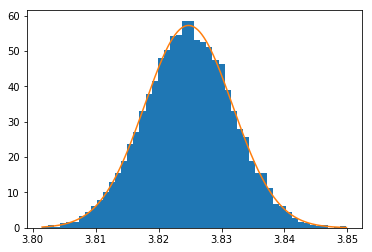

n= 3.8256635665893555 com uma incerteza de  0.014234233726591168


In [7]:
#BETA VIRGINIS
# N = 1000
N = 10000
NNN=np.zeros(N)
for i in range(N):
    print('\n i = ', i)
    Mi=M_beta+dM_beta*rd.normal()
    Ri=R_beta+dR_beta*rd.normal()
    Li = L_beta+dL_beta*rd.normal()
    NNN[i]=n_bissecao(Mi,Ri,Li,X_beta,Z_beta,1.5,4.,1E-5)
   
d,e,f=plt.hist(NNN,density=True, bins = 50)  
n_=np.average(NNN)
print(n_)
g = norm.fit(e)
gauss(NNN)
#plt.xlim(3800,3840)
plt.savefig('emiss_beta.png', orientation='landscape',format='png')
plt.show()
print('n=',g[0],'com uma incerteza de ',g[1])



In [8]:
print('\n PARA O SOL: \n')
print('n = ', n_bissecao(M_Sol,R_Sol,L_Sol,X_Sol,Z_Sol,1.5,4,1E-15))  #para Sol


 PARA O SOL: 

2.75 3.375
3.0625 3.21875
3.140625 3.21875
3.1796875 3.19921875
3.189453125 3.1943359375
3.19189453125 3.193115234375
3.19189453125 3.1925048828125
3.19189453125 3.19219970703125
3.19189453125 3.192047119140625
3.19189453125 3.1919708251953125
3.1919326782226562 3.1919708251953125
3.1919517517089844 3.1919708251953125
3.1919612884521484 3.1919660568237305
3.1919612884521484 3.1919636726379395
3.1919612884521484 3.191962480545044
3.1919612884521484 3.191961884498596
3.1919612884521484 3.1919615864753723
3.1919612884521484 3.1919614374637604
3.1919613629579544 3.1919614374637604
3.1919614002108574 3.1919614374637604
3.191961418837309 3.1919614374637604
3.1919614281505346 3.1919614374637604
3.1919614328071475 3.1919614374637604
3.191961435135454 3.1919614374637604
3.191961436299607 3.1919614374637604
3.1919614368816838 3.1919614374637604
3.191961437172722 3.1919614373182412
3.1919614372454816 3.1919614372818614
3.1919614372454816 3.1919614372636715
3.1919614372545766 3.191

In [19]:
M=[M_beta,M_l]
R=[R_beta,R_l]
L=[L_beta,L_l]
XX=[X_beta,X_l]
ZZ=[Z_beta,Z_l]
nn=[g[0],a[0]] #adicionar valores de n

c1 = caixa_negra(M[0],R[0],L[0],XX[0],ZZ[0],nn[0])
plt.show()
c2 = caixa_negra(M[1],R[1],L[1],XX[1],ZZ[1],nn[1])
plt.show()
c3 = caixa_negra(M_Sol,R_Sol,L_Sol,X_Sol,Z_Sol,n_bissecao(M_Sol,R_Sol,L_Sol,X_Sol,Z_Sol,1.5,4,1E-15))

C:\Users\bernc\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


2.75 3.375
3.0625 3.21875
3.140625 3.21875
3.1796875 3.19921875
3.189453125 3.1943359375
3.19189453125 3.193115234375
3.19189453125 3.1925048828125
3.19189453125 3.19219970703125
3.19189453125 3.192047119140625
3.19189453125 3.1919708251953125
3.1919326782226562 3.1919708251953125
3.1919517517089844 3.1919708251953125
3.1919612884521484 3.1919660568237305
3.1919612884521484 3.1919636726379395
3.1919612884521484 3.191962480545044
3.1919612884521484 3.191961884498596
3.1919612884521484 3.1919615864753723
3.1919612884521484 3.1919614374637604
3.1919613629579544 3.1919614374637604
3.1919614002108574 3.1919614374637604
3.191961418837309 3.1919614374637604
3.1919614281505346 3.1919614374637604
3.1919614328071475 3.1919614374637604
3.191961435135454 3.1919614374637604
3.191961436299607 3.1919614374637604
3.1919614368816838 3.1919614374637604
3.191961437172722 3.1919614373182412
3.1919614372454816 3.1919614372818614
3.1919614372454816 3.1919614372636715
3.1919614372545766 3.1919614372636715
3.

In [10]:
def graficos_junto(a, l):  #l são labels
    var_contagem = 0
    for i in a:
        'Theta'
        #plt.title(title)
        plt.xlabel(r'$ \xi/\xi_s$', fontsize=18)
        plt.ylabel(r'$\theta$', fontsize=18)
        #plt.plot(E/qsi_sup,theta)
        plt.plot(i[1]/i[2], i[4], label = l[var_contagem])
        plt.legend()
        plt.savefig('theta.pdf', orientation='landscape',format='png')
        var_contagem+=1
    plt.show()
    
    var_contagem = 0
    for i in a:
        'Densidade'
        #plt.title(title)
        plt.xlabel(r'$ r/R_* $', fontsize=18)
        plt.ylabel(r'$ \rho$ $(g.cm^{-3})$', fontsize=18)
        #plt.plot(r/R,ro)
        plt.plot(i[7],i[3], label = l[var_contagem])
        plt.legend()
        plt.savefig('densidade.pdf', orientation='landscape',format='png')
        var_contagem += 1
    plt.show()
    
    var_contagem = 0
    for i in a:
        'Temperatura'
        #plt.title(title)
        plt.xlabel(r'$ r/R_* $', fontsize=18)
        plt.ylabel('Temperatura (K)', fontsize=18)
        #plt.plot(r/R,T)
        plt.plot(i[7],i[8], label = l[var_contagem])
        plt.legend()
        plt.savefig('temperatura.pdf', orientation='landscape',format='png')
        var_contagem += 1
    plt.show()
    
    
    for i in a:
        'Emissividade'
        #plt.title(title)
        plt.xlabel(r'$ r/R_* $', fontsize=18)
        plt.ylabel(r'$\epsilon_{pp}, \epsilon_{CNO}, \epsilon$ $(erg.g^{-1}.s^{-1})$' , fontsize=18)
        #plt.plot(r[:i+1]/R, epsPP, label='Emissividade por cadeias PP')
        plt.plot(i[9][0],i[13], label='Emissividade por cadeias PP')
        #plt.plot(r[:i+1]/R, epsCNO, label='Emissividade por ciclo CNO')
        plt.plot(i[9][0],i[12], label='Emissividade por ciclo CNO')
        #plt.plot(r[:i+1]/R, emiss, label='Emissividade')
        plt.plot(i[9][0],i[14], label='Emissividade')
        plt.legend()
        plt.savefig('emissividade.pdf', orientation='landscape',format='png')
        plt.show()
    
    var_contagem = 0
    for i in a:
        if var_contagem != 1:
            'Luminosidade'
            #plt.title(title)
            plt.xlabel(r'$ m/M_* $', fontsize=18)
            plt.ylabel('$L_r$ $/L_*$', fontsize=18)
            #plt.plot(m[:len(Lr_L)]/M,Lr_L)
            plt.plot(i[10],i[11], label = l[var_contagem])
            plt.legend()
            plt.savefig('lumin.pdf', orientation='landscape',format='png')
        else:
            'Luminosidade'
            #plt.title(title)
            plt.xlabel(r'$ m/M_* $', fontsize=18)
            plt.ylabel('$L_r$ $/L_*$', fontsize=18)
            #plt.plot(m[:len(Lr_L)]/M,Lr_L)
            plt.plot(i[10],i[11]/max(i[11]), label = l[var_contagem])  #para normalizar
            plt.legend()
            plt.savefig('lumin.pdf', orientation='landscape',format='png')
        var_contagem +=1 
    plt.show()

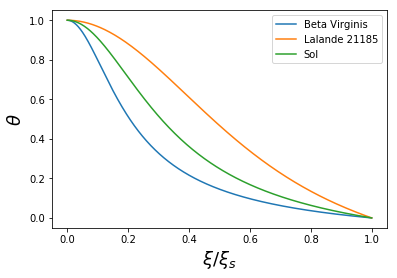

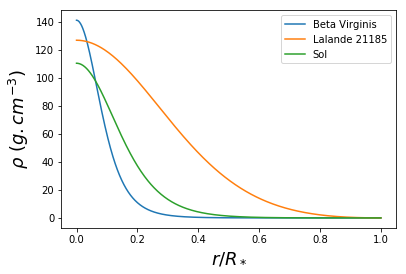

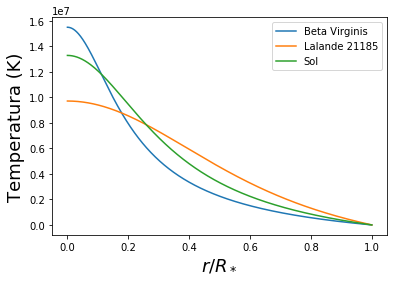

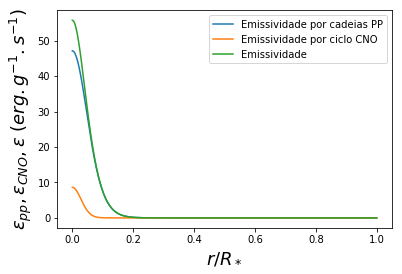

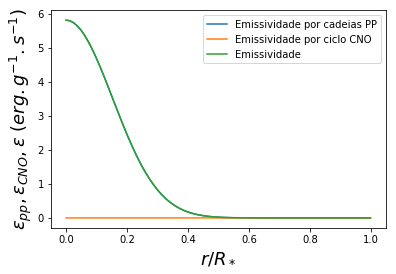

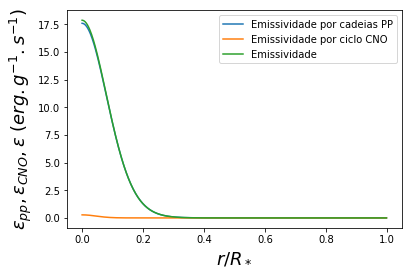

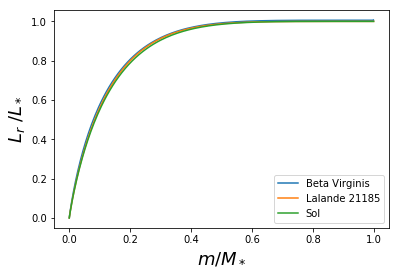

In [11]:
LIS = (c1,c2,c3)
l = ['Beta Virginis', 'Lalande 21185', 'Sol']
graficos_junto(LIS,l)

In [12]:
def graficos(cn):  #cn é caixa negra
    'Theta'
    plt.xlabel(r'$ \xi/\xi_s$', fontsize=18)
    plt.ylabel(r'$\theta$', fontsize=18)
    #plt.plot(E/qsi_sup,theta)
    plt.plot(cn[1]/cn[2], cn[4])
    plt.savefig('theta.pdf', orientation='landscape',format='pdf')
    plt.show()
    
    
    'Densidade'
    plt.xlabel(r'$ r/R_* $', fontsize=18)
    plt.ylabel(r'$ \rho$ $(g.cm^{-3})$', fontsize=18)
    #plt.plot(r/R,ro)
    plt.plot(cn[7],cn[3])
    plt.savefig('densidade.pdf', orientation='landscape',format='pdf')
    plt.show()
    
    'Temperatura'
    plt.xlabel(r'$ r/R_* $', fontsize=18)
    plt.ylabel('Temperatura (K)', fontsize=18)
    #plt.plot(r/R,T)
    plt.plot(cn[7],cn[8])
    plt.savefig('temperatura.pdf', orientation='landscape',format='pdf')
    plt.show()
    
    'Emissividade'
    plt.xlabel(r'$ r/R_* $', fontsize=18)
    plt.ylabel(r'$\epsilon_{pp}, \epsilon_{CNO}, \epsilon$ $(erg.g^{-1}.s^{-1})$' , fontsize=18)
    #plt.plot(r[:i+1]/R, epsPP, label='Emissividade por cadeias PP')
    plt.plot(cn[9][0],cn[13], label='Emissividade por cadeias PP')
    #plt.plot(r[:i+1]/R, epsCNO, label='Emissividade por ciclo CNO')
    plt.plot(cn[9][0],cn[12], label='Emissividade por ciclo CNO')
    #plt.plot(r[:i+1]/R, emiss, label='Emissividade total')
    plt.plot(cn[9][0],cn[14], label='Emissividade total')
    plt.legend()
    plt.savefig('emissividade.png', orientation='landscape',format='png')
    plt.show()

    'Luminosidade'
    plt.xlabel(r'$ m/M_* $', fontsize=18)
    plt.ylabel('$L_r$ $/L_*$', fontsize=18)
    #plt.plot(m[:len(Lr_L)]/M,Lr_L)
    plt.plot(cn[10],cn[11])
    plt.savefig('lumus.pdf', orientation='landscape',format='pdf')
    plt.show()

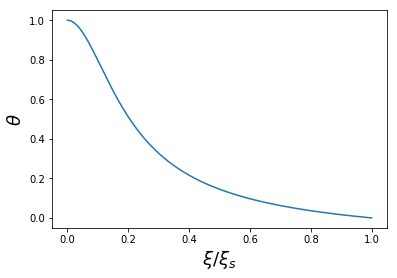

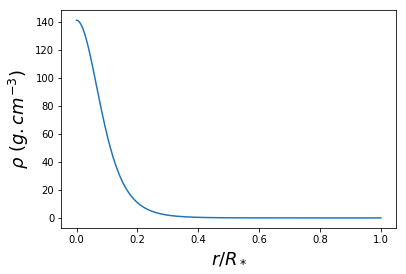

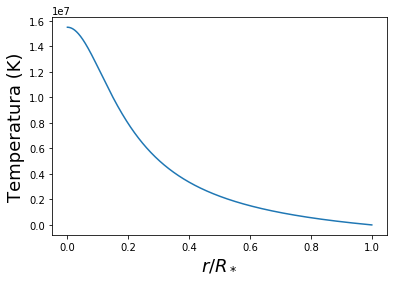

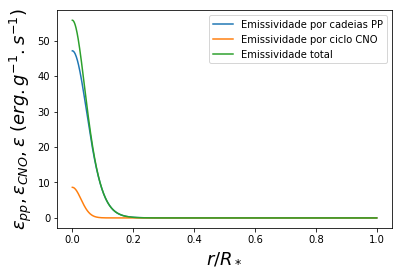

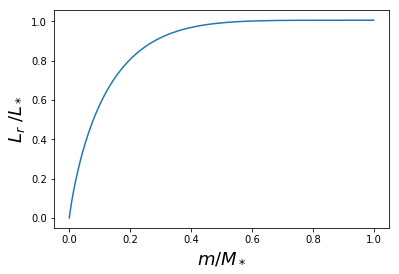

In [13]:
graficos(c1)

In [24]:
#Densidade e temperatura central do Sol, para validação
#print(c2)
#Densidade central:
print(c3[16])
#Temperatura central:
print(c3[15])

110.44593428690452
13290369.497640744


In [25]:
#qsi_0, theta_sup
qsi0_b,thetalinha_sup_b = c1[2],c1[6]
qsi0_l,thetalinha_sup_l = c2[2], c2[6]
print(qsi0_b,thetalinha_sup_b)
print(qsi0_l,thetalinha_sup_l)

12.53097104883156 -0.011629115595671738
4.402810424208187 -0.1235888869266275


In [26]:
def f(r,n,qsi):
    y1=r[0]
    y2=r[1]
    fy1=y2
    fy2=-(np.abs(y1)**n)-2*y2/qsi
    return np.array([fy1, fy2], float)


def RK4(a,b,N,f,y1,y2,n): 
    h = (b-a)/N
    tpoints = np.arange(a,b,h)
    ypoints = []
    y1points = []
    r = np.array([y1, y2], float)
    
    for i in tpoints:
        ypoints.append(r[0])
        y1points.append(r[1])
        k1 = h*f(r,n,i)
        k2 = h*f(r+0.5*k1,n,i+0.5*h)
        k3 = h*f(r+0.5*k2,n,i+0.5*h)
        k4 = h*f(r+k3,n,i+h)
        r += (k1+2*k2+2*k3+k4)/6
        
    return np.array(tpoints), np.array(ypoints), np.array(y1points)

C:\Users\bernc\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """


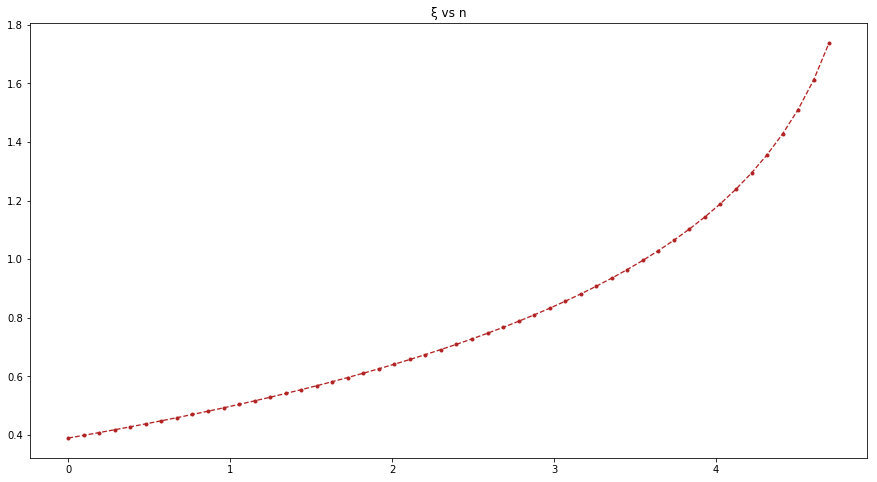

In [27]:
def politropo_gráfico(n):
    tpoints, ypoints, y1points = RK4(1e-8,200,100000,f,1-(1e-8)**2/2,-1e-8,n)

    zero=np.argwhere(ypoints<0)
    #print(zero)
    #print('ZEROO')
    
    yp=(ypoints[zero[0]])
    ym=(ypoints[zero[0]-1])
    qsip=tpoints[zero[0]]
    qsim=tpoints[zero[0]-1]
    qsi_zero = (-(qsim-qsip)/(ym-yp))*yp+qsip
            
    return np.log10(qsi_zero)

ns = np.linspace(0,4.7,50)
Qsis=[]

for i in ns:
    Qsi_z = politropo_gráfico(i)
    Qsis.append(Qsi_z)
    #print(i)
plt.figure(figsize=(15,8))
plt.plot(ns, Qsis, color='firebrick', marker='.', linestyle='dashed', linewidth=1.3)
plt.title('ξ vs n')
plt.savefig('qsi.png', orientation='landscape',format='png')
plt.show()

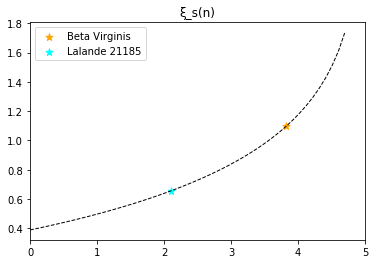

In [28]:
#plt.figure(figsize=(15,8))
plt.plot(ns, Qsis, color='black', marker='', linestyle='dashed', linewidth=1)
plt.scatter(3.824438,1.097484743, color='orange', marker='*', label= 'Beta Virginis', s=55)
plt.scatter(2.109375,0.6571150238, color='aqua', marker='*', label='Lalande 21185', s=55)
#índice politrópico, log10(qsi_sup) que vem da última célula
plt.title('ξ_s(n)')
plt.xlim(0,5)
plt.legend()
plt.savefig('qsi2.png', orientation='landscape',format='png')
plt.show()

## Apêndice

In [ ]:
#OUTRAS POSSÍVEIS FUNÇÕES DE INTEGRAÇÃO

def integrador_trapezio2(f,a,b,N):
    x=  np.linspace(a,b,N+1)    #N é número de intervalos
    f1=f(x)
    h = (b-a)/ N  #spacing
    return (f1[0]+f1[-1] + 2*f1[1:-1].sum())*h/2

def RK4(a,b,f,N,x): # x é condição inicial
    h = (b-a)/N

    tpoints = np.arange(a,b,h)
    xpoints = []
    for t in tpoints:
        xpoints.append(x)
        k1 = h*f(x,t)
        k2 = h*f(x+0.5*k1,t+0.5*h)
        k3 = h*f(x+0.5*k2,t+0.5*h)
        k4 = h*f(x+k3,t+h)
        x += (k1+2*k2+2*k3+k4)/6
    return tpoints,xpoints

In [ ]:
#Resolução da equação de Lane-Emden para n diferentes

#Para ξ=0 (centro da estrela), temos y1(ξ=0) = 1 e y2(ξ=0) = 0
#Método integração coelhos de Computacional
plt.figure(figsize=(7,16))
def cond_inic(deltaξ):
    y1_i = 1 - ((deltaξ) ** 2) / 2
    y2_i = -deltaξ
    return y1_i,y2_i

def f2(r,ξ,n):
    y1 = r[0]
    y2 = r[1]
    fy1 = (y2)        
    fy2 =  -(abs(y1)) ** n - (2 * y2) / ξ
    return np.array([fy1,fy2],float)

val = [0,1,1.5,3,4,5]   #Valores da figura 3.1
for k in val:
    n = k
    a =  1e-8
    b = 15 #Nota: Escolhi até 15 para comparar com Figura 3.1
    N = 1000
    h = (b-a)/N

    tpoints2 = np.arange(a,b,h)
    xpoints2 = []
    ypoints2 = []

    #Vou fazer, para testar, caso n = 1
    deltaξ = 1e-8
    r = np.array([cond_inic(deltaξ)[0],cond_inic(deltaξ)[1]],float)      #condições iniciais; y1(ξ=0) = 1 e y2(ξ=0) = 0 
    for i in tpoints2:
        xpoints2.append(r[0])
        ypoints2.append(r[1])
        k1 = h*f2(r,i,n)
        k2 = h*f2(r+0.5*k1,i+0.5*h,n)
        k3 = h*f2(r+0.5*k2,i+0.5*h,n)
        k4 = h*f2(r+k3,i+h,n)
        #print(r)
        r += (k1+2*k2+2*k3+k4)/6 
    print('n =', k)
    zero = np.zeros(len(tpoints2))
    #plt.figure(figsize=(3,4))
    #plt.subplot(3,2,2)
    plt.plot(tpoints2,xpoints2, label ='n = '+ str(k))      #Isto ainda faz parte do loop inicial  
    plt.xlim(0,15)
    plt.ylim(0,1.1) #Para comparar com Figura 3.1
    plt.xlabel("ξ")
    plt.legend()
    plt.savefig('qsin.png', orientation='landscape',format='png')
    #plt.show()
plt.show()

In [ ]:
#Cálculo mais rigoroso dos zeros

N2 = 1000 #cuidado porque se fosse N o nome seria igual do do outro programa 
#e depois ele ficaria muito lento porque correria 1000 vezes; embora no fim queira mudar
#para 1000 portanto não faça diferença, ainda assim seria um erro de programação
val = [0,1,3,3.1,4,5]
V1 = np.zeros((len(val),N2))       #para valores de tpoints2; ksi
V2 = np.zeros((len(val),N2))        #para valores de xpoints2; theta
V3 = np.zeros((len(val),N2))        #para valores de ypoints2; theta_linha
zeros_theta = []
zeros_thetalinha = []
cont = 0
for k in val:
    n = k
    print('n =', k)
    a =  1e-8
    b = 15 #Nota: Escolhi até 15 para comparar com Figura 3.1
    h = (b-a)/N2

    tpoints2 = np.arange(a,b,h)
    xpoints2 = []   #Preciso de alterar para guardar os dados
    ypoints2 = []

    #Vou fazer, para testar, caso n = 1
    deltaξ = 1e-8
    r = np.array([cond_inic(deltaξ)[0],cond_inic(deltaξ)[1]],float) 
    #condições iniciais; y1(ξ=0) = 1 e y2(ξ=0) = 0 
    p = 0 #Iniciar variável
    for i in tpoints2:
        xpoints2.append(r[0])
        ypoints2.append(r[1])
        k1 = h*f2(r,i,n)
        k2 = h*f2(r+0.5*k1,i+0.5*h,n)
        k3 = h*f2(r+0.5*k2,i+0.5*h,n)
        k4 = h*f2(r+k3,i+h,n)
        r += (k1+2*k2+2*k3+k4)/6 
       
        
#Para determinar os zeros, quero estudar o produto dos valores e ver quando é negativo

        if p>0:
            #Isto é para caso de xpoints
#Basicamente vê se a diferença entre este ponto e o anterior é menor do que zero,
#ou seja, se o ponto anterior
            if xpoints2[p]*xpoints2[p-1] < 0:
                zero_x = -( (tpoints2[p]-tpoints2[p-1])/(xpoints2[p]-xpoints2[p-1]))*xpoints2[p-1]+tpoints2[p-1]
                print('Zero da função 1 é', zero_x)
                zeros_theta.append(zero_x)
                print('Zero_x = ' , zero_x)
                #zero_derivada = ( -(tpoints2[p]-tpoints2[p-1])/(ypoints2[p]-ypoints2[p-1]))*ypoints2[p-1]+tpoints2[p-1]
                zero_derivada = ypoints2[p]
                zeros_thetalinha.append(zero_derivada)
        p +=1  #Valor que diz em que ciclo vamos 
    V1[cont,:] = tpoints2
    V2[cont,:] = xpoints2
    V3[cont,:] = ypoints2
    zero = np.zeros(len(tpoints2))
    plt.plot(tpoints2,zero, 'black') #Linha t = 0
    plt.plot(tpoints2,xpoints2, 'crimson', label = 'n = '+ str(k))      #Isto ainda faz parte do loop inicial  
    plt.xlim(0,15)
    plt.ylim(0,1.1) #Para comparar com Figura 3.1
    #Nota: Tudo o que é depois do primeiro zero é para deitar fora
    plt.xlabel("ξ")
    plt.ylabel("Theta")
    plt.legend()
    plt.show()
    plt.plot(tpoints2,ypoints2, 'orange', label = 'derivada n=' + str(k))
    plt.legend()
    plt.show()
    cont +=1
print('Zeros = ' , zeros_theta)
print('Zeros derivada = ' , zeros_thetalinha)

In [ ]:
#Cálculo do erro para n = 0 e n = 1, que são as únicas soluções analíticas
#Além disso, notamos que, para n = 5, nunca toca no zer, como suposto
#Queremos erro, para n=1, entre zero e pi menor do que 1e-8
#Teste para n = 1: 
a = 3.1415926542546386 - np.pi
err1 = abs(a)
if err1 <= 1e-8:
    print('Sucesso!')
else:
    print('Critical Failure.')
print(err1)
#Teste para n = 0:
b = 2.449489742186075 - np.sqrt(6)
err0 = abs(b)
if err0 <= 1e-8:
    print('Sucesso!')
else:
    print('Critical Failure.')
print(err0)
#Nota: Agora escrevemos em programa, mas queremos isto em subrotina

In [ ]:
#Função geral que calcule isto para 1 dado n:
#Corta já valores menores do que 0
def poli(n):
    'calcula theta, theta_linha e ksi para um dado n'
    N = 1000
    V1 = np.zeros(N)       #para valores de tpoints2; ksi
    V2 = np.zeros(N)        #para valores de xpoints2; theta
    V3 = np.zeros(N)        #para valores de ypoints2; theta_linha
    zeros_theta = []
    zeros_thetalinha = []
    cont = 0
    k = n
    #print('n =', k)
    a =  1e-8
    b = 15 #Nota: Escolhi até 15 para comparar com Figura 3.1
    h = (b-a)/N

    tpoints2 = np.arange(a,b,h)
    xpoints2 = []   #Preciso de alterar para guardar os dados
    ypoints2 = []

        #Vou fazer, para testar, caso n = 1
    deltaξ = 1e-8
    r = np.array([cond_inic(deltaξ)[0],cond_inic(deltaξ)[1]],float) 
        #condições iniciais; y1(ξ=0) = 1 e y2(ξ=0) = 0 
    p = 0 #Iniciar variável
    for i in tpoints2:
        xpoints2.append(r[0])
        ypoints2.append(r[1])
        k1 = h*f2(r,i,n)
        k2 = h*f2(r+0.5*k1,i+0.5*h,n)
        k3 = h*f2(r+0.5*k2,i+0.5*h,n)
        k4 = h*f2(r+k3,i+h,n)
        r += (k1+2*k2+2*k3+k4)/6 


    #Para determinar os zeros, quero estudar o produto dos valores e ver quando é negativo

        if p>0:
                #Isto é para caso de xpoints
    #Basicamente vê se a diferença entre este ponto e o anterior é menor do que zero,
    #ou seja, se o ponto anterior
            if xpoints2[p]*xpoints2[p-1] < 0:
                zero_theta = -( (tpoints2[p]-tpoints2[p-1])/(xpoints2[p]-xpoints2[p-1]))*xpoints2[p-1]+tpoints2[p-1]
                len_corte = p
                #print('Zero da função 1 é', zero_x)
                zeros_theta.append(zero_x)
                #print('Zero_x = ' , zero_x)
                    #zero_derivada = ( -(tpoints2[p]-tpoints2[p-1])/(ypoints2[p]-ypoints2[p-1]))*ypoints2[p-1]+tpoints2[p-1]
                zero_derivada = ypoints2[p]
                zeros_thetalinha.append(zero_derivada)
        p +=1  #Valor que diz em que ciclo vamos 
#     V1[cont] = tpoints2
#     V2[cont] = xpoints2
#     V3[cont] = ypoints2
    zero = np.zeros(len(tpoints2))
#     plt.plot(tpoints2,zero, 'black') #Linha t = 0
#     plt.plot(tpoints2,xpoints2, 'crimson', label = 'n = '+ str(k))      #Isto ainda faz parte do loop inicial  
#     plt.xlim(0,15)
#     plt.ylim(0,1.1) #Para comparar com Figura 3.1
#         #Nota: Tudo o que é depois do primeiro zero é para deitar fora
#     plt.xlabel("ξ")
#     plt.ylabel("Theta")
#     plt.legend()
#     plt.show()
#     plt.plot(tpoints2,ypoints2, 'orange', label = 'derivada n=' + str(k))
#     plt.legend()
#     plt.show()
    cont +=1
#     print('Zeros = ' , zeros_theta)
#     print('Zeros derivada = ' , zeros_thetalinha)
    tpoints_pos = np.zeros(len_corte)
    theta_pos = np.zeros(len_corte)
    theta_linha_pos = np.zeros(len_corte) 
    for l in range(len_corte):
        tpoints_pos[l] = tpoints2[l]
        theta_pos[l] = xpoints2[l]
        theta_linha_pos[l] = ypoints2[l]
    ksi = tpoints_pos
    theta = theta_pos
    theta_linha = theta_linha_pos
    qsi_sup = zero_theta 
    return ksi,theta,theta_linha,qsi_sup,zero_derivada
    
#print(poli(3.1)[1])

In [ ]:
print(poli(1)[3], poli(1)[4])
print(poli(0)[3], poli(0)[4])

In [ ]:
#PARA AS ESTRELAS OBTIDAS, RESPETIVAMENTE, BETA VIRGINIS E LALANDE 21185
print(poli(3.824438)[3], poli(3.824438)[4])
print(poli(2.109375)[3], poli(2.109375)[4])